# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>





The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

We load SQLITE database as it is easy to query it
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive(1)". Otherwise, it will be set to "negative(0)".

In [40]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [41]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [42]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [43]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [44]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [45]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [46]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [47]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [48]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [49]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [50]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [51]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [52]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [53]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [54]:

sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [55]:

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [56]:

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [58]:
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [59]:
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [60]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [61]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1520.33it/s]


In [62]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [63]:
for i in range(5):
    print(final['Summary'].values[i])
    print('*'*50)

thirty bucks?
**************************************************
Flies Begone
**************************************************
WOW Make your own 'slickers' !
**************************************************
Great Product
**************************************************
Good stuff!
**************************************************


In [64]:
from tqdm import tqdm
preprocessed_review_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_review_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 2400.29it/s]


In [65]:
preprocessed_review_summary[900]

'great value'

# [4] Featurization

## [4.1] BAG OF WORDS

In [66]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [67]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [68]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [69]:
# Training Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [71]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [72]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
for i in sent_vectors:
    print(i)

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:07<00:00, 628.17it/s]


4986
[ 0.67077003 -0.26906492 -0.18734724  0.01024853  0.19341444  0.43330058
  0.02286589  0.1289325  -0.1434156  -0.11800228  0.19979198 -0.05420984
 -0.54099284  0.68822125  0.39916685 -0.41781765 -0.13398938 -0.34446008
 -0.05814892  0.36973437 -0.14746834  0.14572424 -0.20209939  0.18726236
 -0.214582    0.13435931 -0.75202141  0.00436388 -0.05606325  0.19377788
  0.32107686 -0.10388588  0.52092552  0.08915984 -0.09907057  0.26751061
  0.14895167  0.07453504  0.3821132  -0.08756055  0.16532717 -0.4867726
 -0.36033177 -0.4013766   0.08827174 -0.21458433  0.45108448 -1.00128143
  0.09315487  0.102321  ]
[ 0.71729452 -0.27963856 -0.21692653  0.00736738  0.19511804  0.45637205
  0.03243934  0.14439324 -0.13876594 -0.13119307  0.228777   -0.04609941
 -0.61654597  0.71649989  0.45882058 -0.45273637 -0.16204788 -0.39553174
 -0.09023487  0.40335693 -0.13878213  0.14154258 -0.21950169  0.19642296
 -0.26293026  0.15365284 -0.83412139  0.02792178 -0.06105082  0.18680754
  0.36862682 -0.12781

  0.12403541  0.12327819]
[ 0.70059448 -0.28368688 -0.25047797  0.00568605  0.21457947  0.46984152
  0.02622922  0.22009829 -0.14631304 -0.16785334  0.23841892 -0.01269059
 -0.67333234  0.75804431  0.4755991  -0.49033345 -0.17904766 -0.41240713
 -0.04154015  0.46667298 -0.1505023   0.07200095 -0.21923356  0.22922678
 -0.36660301  0.13548785 -0.78359492  0.01744505 -0.09117782  0.24753781
  0.45075846 -0.16666446  0.72938427  0.12777995 -0.04502682  0.22376694
  0.27728561  0.05602659  0.39335566 -0.19160412  0.27523264 -0.55279378
 -0.5097153  -0.46877908  0.0975727  -0.33221437  0.5613768  -1.17663383
  0.11786001  0.11528489]
[ 0.65912575 -0.25940128 -0.18226739  0.0019489   0.20749998  0.44382011
  0.01265966  0.10535121 -0.14054139 -0.09806878  0.17331035 -0.07006612
 -0.51486651  0.69215431  0.36011578 -0.41394786 -0.13765886 -0.33779677
 -0.05601654  0.36142423 -0.13558982  0.15644203 -0.18726039  0.17374252
 -0.17755114  0.1263449  -0.73389912 -0.02164619 -0.04132884  0.19330652

  0.11516052  0.08681991]
[ 0.90125183 -0.33378403 -0.24887387 -0.02538933  0.33305099  0.66027797
 -0.00537877  0.10086654 -0.21263791 -0.13336147  0.18414967 -0.11851347
 -0.72212128  0.96988614  0.43760744 -0.55509026 -0.22075486 -0.45088266
 -0.04145114  0.48009003 -0.12629082  0.24546983 -0.29687142  0.21684604
 -0.17607794  0.1640812  -1.02764892 -0.07962031 -0.04369934  0.26094924
  0.32151887 -0.18172076  0.50150922  0.13734271 -0.22281159  0.46923515
  0.05683248  0.18217879  0.49116317 -0.07974154  0.13075459 -0.60884286
 -0.45278165 -0.47255529  0.10789905 -0.24192535  0.57232388 -1.24098599
  0.11838592  0.20118866]
[ 0.63823436 -0.26918333 -0.24112756  0.01261373  0.21006356  0.42911971
  0.0269788   0.26984273 -0.11453354 -0.1960055   0.22248488  0.00946952
 -0.67136397  0.67367979  0.46660679 -0.50007931 -0.21320488 -0.39314914
  0.00689421  0.45913426 -0.15841724  0.02069155 -0.17825461  0.23066672
 -0.43820005  0.11227159 -0.68469053 -0.00747724 -0.11348969  0.24171456

  0.09950759  0.11868296]
[ 0.78149558 -0.34295726 -0.2337919   0.03069641  0.23545639  0.50514777
  0.04107104  0.23176795 -0.17501313 -0.17164843  0.26528359 -0.03306057
 -0.67382307  0.81247369  0.5059105  -0.53959046 -0.19934025 -0.42324322
 -0.0309157   0.48373574 -0.20900318  0.12069972 -0.20181097  0.24608438
 -0.37074472  0.15670192 -0.81053535 -0.00768919 -0.09785219  0.26804915
  0.44611887 -0.1443919   0.73071348  0.13284713 -0.03630101  0.239061
  0.31336899  0.03288133  0.41943777 -0.20841227  0.29453549 -0.57415132
 -0.51834893 -0.48515298  0.09473767 -0.35052291  0.59898559 -1.25112924
  0.14391185  0.11517533]
[ 0.78787028 -0.35673483 -0.24409187  0.030908    0.2106609   0.5040812
  0.01786912  0.16892321 -0.15362324 -0.12859985  0.25593638 -0.0636067
 -0.58832331  0.80967554  0.45733256 -0.51373736 -0.16774869 -0.40277808
 -0.06417679  0.43339514 -0.20560796  0.13384363 -0.16964442  0.24046286
 -0.26092525  0.16036156 -0.8239877  -0.00817504 -0.07907573  0.24218803
  0

  1.30808186e-01  9.97005687e-02]
[ 0.79430806 -0.32560798 -0.21624707  0.00886694  0.2287574   0.50635904
  0.02545056  0.14569531 -0.18472749 -0.12978035  0.23105769 -0.07162702
 -0.61626046  0.82991694  0.43923011 -0.47000519 -0.1512026  -0.38676564
 -0.06326514  0.4353014  -0.1746103   0.17688433 -0.22714853  0.21019694
 -0.2303694   0.1513861  -0.84942126 -0.00405644 -0.06616993  0.23513352
  0.34751519 -0.13381706  0.56768922  0.11408783 -0.10908459  0.32208576
  0.1660084   0.08413819  0.42564906 -0.09705854  0.20365595 -0.52957005
 -0.41468693 -0.41634289  0.11000715 -0.26121201  0.50587928 -1.13293157
  0.11096687  0.13859294]
[ 0.71890535 -0.30930066 -0.21259335  0.02528874  0.19216133  0.45937679
  0.0273419   0.16321776 -0.13315841 -0.11286945  0.22579321 -0.06018927
 -0.55605936  0.72693068  0.43707032 -0.47583165 -0.15759484 -0.37376412
 -0.06662562  0.40387163 -0.18976409  0.12514028 -0.15907365  0.21383514
 -0.26507209  0.1410904  -0.76970816  0.00270384 -0.06789747  0.

  0.08667146  0.11978683]
[ 0.71601373 -0.31508552 -0.22424775  0.02334104  0.19676321  0.45856966
  0.02777531  0.16465998 -0.15099285 -0.13125715  0.23996083 -0.04045324
 -0.57896835  0.74588631  0.45037561 -0.46583172 -0.15392541 -0.38633388
 -0.05797254  0.4271522  -0.17572199  0.12667701 -0.18689428  0.22579966
 -0.27211114  0.15477057 -0.76212634  0.00951815 -0.07882959  0.21907233
  0.37964151 -0.10544579  0.60827473  0.10701156 -0.05571296  0.24135249
  0.21175881  0.05238379  0.38964399 -0.13455284  0.22469423 -0.52442666
 -0.43217024 -0.43159627  0.09328096 -0.27198611  0.50009786 -1.10079777
  0.11358387  0.10212979]
[ 6.43355879e-01 -2.75274547e-01 -1.93445886e-01  1.90414355e-02
  1.80105996e-01  4.11521964e-01  2.97168386e-02  1.73207387e-01
 -1.29069006e-01 -1.31308211e-01  2.10371472e-01 -3.72444351e-02
 -5.35287236e-01  6.59445523e-01  4.08986791e-01 -4.33258857e-01
 -1.49517855e-01 -3.37247770e-01 -4.28266430e-02  3.85588465e-01
 -1.70257275e-01  9.47464028e-02 -1.569

  0.11010527  0.11032639]
[ 0.68967462 -0.27409549 -0.18911676  0.00908903  0.18282445  0.42839179
  0.02709102  0.15271292 -0.12626952 -0.12837944  0.20583214 -0.0601933
 -0.56718352  0.69749435  0.4247176  -0.44416475 -0.13921742 -0.3554491
 -0.0663185   0.38802079 -0.16012326  0.13653816 -0.19640523  0.18977253
 -0.24917007  0.13447179 -0.77277072  0.01372609 -0.06095812  0.19457752
  0.34291091 -0.1056093   0.57185813  0.07777228 -0.08026028  0.26398891
  0.18154711  0.07326548  0.39822454 -0.10102687  0.17794527 -0.52786361
 -0.38938232 -0.43018515  0.08787863 -0.23660616  0.47785029 -1.04387281
  0.10458084  0.0923173 ]
[ 7.16406844e-01 -3.13064774e-01 -2.10847589e-01  1.17329023e-02
  2.05930567e-01  4.78587482e-01  2.66105461e-02  1.74843661e-01
 -1.64381105e-01 -1.51343290e-01  1.89491980e-01 -5.28201328e-02
 -5.85351651e-01  7.60675829e-01  3.95151654e-01 -4.38315224e-01
 -1.58042516e-01 -3.59297442e-01 -1.10852175e-02  4.14367275e-01
 -1.59329435e-01  1.29489723e-01 -2.00215

  0.10364284  0.09612457]
[ 0.70937596 -0.30189458 -0.20791532  0.01047765  0.2135081   0.46993048
  0.01362033  0.13096649 -0.15548813 -0.12149318  0.20218845 -0.06670664
 -0.5494671   0.73208906  0.38996068 -0.45022193 -0.15139399 -0.35449034
 -0.04333032  0.39109138 -0.14932985  0.15108462 -0.20053796  0.19050957
 -0.19669961  0.1388814  -0.76982417 -0.01773794 -0.05999185  0.21337006
  0.29738081 -0.10756808  0.50164558  0.10214727 -0.10522079  0.29620445
  0.13259606  0.08743392  0.38256557 -0.0906467   0.1671568  -0.49109597
 -0.3724996  -0.38205969  0.0835795  -0.22803716  0.44744538 -1.01107199
  0.10849718  0.1232467 ]
[ 0.72104684 -0.32139721 -0.21869495  0.03276457  0.20148718  0.4658206
  0.03070178  0.14532432 -0.16473198 -0.11911896  0.25272052 -0.04782805
 -0.57227296  0.7580654   0.44551636 -0.46559838 -0.15560761 -0.38353528
 -0.06537997  0.4168681  -0.16842101  0.14816757 -0.20817176  0.22682828
 -0.24539541  0.15808016 -0.78201896  0.00945692 -0.07461164  0.22221304


  0.13174255  0.09431478]
[ 0.72417809 -0.30269293 -0.20309904  0.02039628  0.1979      0.45635921
  0.02869092  0.13213145 -0.15347416 -0.11915003  0.22023666 -0.05866886
 -0.57546559  0.75602614  0.4331956  -0.44601736 -0.14118024 -0.37819322
 -0.06826286  0.41027894 -0.16015966  0.15525475 -0.21284882  0.20964071
 -0.22540195  0.15811166 -0.79342832  0.01949276 -0.06033051  0.21012984
  0.35056654 -0.10362975  0.55927057  0.0974284  -0.0893586   0.28590597
  0.16042342  0.07313416  0.40082559 -0.10322622  0.19810309 -0.50916763
 -0.3940579  -0.42240975  0.10184138 -0.22969315  0.48344044 -1.08353155
  0.09805269  0.10274823]
[ 0.65017071 -0.28133013 -0.19010891  0.02143569  0.16817449  0.40380424
  0.02884235  0.17191393 -0.12966608 -0.14294468  0.18205097 -0.04055766
 -0.53634531  0.65361739  0.38605743 -0.41910023 -0.14373841 -0.32344316
 -0.02805403  0.36925325 -0.15961145  0.09476081 -0.164862    0.18552205
 -0.26966988  0.13010649 -0.67191965  0.01430157 -0.06960262  0.20391659

 0. 0.]
[ 0.74131536 -0.2912873  -0.21684403  0.01199142  0.23667765  0.48720152
  0.01560697  0.16663166 -0.14467094 -0.13529747  0.21153917 -0.06236686
 -0.6202136   0.77504101  0.43656949 -0.49264457 -0.17710127 -0.39191412
 -0.05065365  0.43403233 -0.16969019  0.14198869 -0.20450574  0.21177348
 -0.26920873  0.12821442 -0.82174703 -0.02435469 -0.0695528   0.22858364
  0.37008588 -0.14027275  0.61536876  0.10740398 -0.08050648  0.28353259
  0.20097558  0.07519812  0.40824092 -0.13573034  0.20412436 -0.54503953
 -0.44481982 -0.44102993  0.09681726 -0.27591848  0.52979664 -1.11510315
  0.12459967  0.11953539]
[ 0.78544133 -0.309805   -0.20848224  0.01614511  0.20653691  0.48511753
  0.02731965  0.16399616 -0.1439841  -0.13566985  0.23345128 -0.07161674
 -0.63693613  0.7994847   0.47631579 -0.5105345  -0.16858583 -0.40018928
 -0.07812534  0.42460635 -0.1778637   0.1658939  -0.22659618  0.21410425
 -0.27155474  0.14327612 -0.8731005   0.01324248 -0.0705157   0.21578661
  0.37654076 -0.1

  0.10146304  0.08628042]
[ 0.8460092  -0.3175391  -0.24126451 -0.0189067   0.28859092  0.60581709
  0.00576772  0.0893413  -0.19185276 -0.11151056  0.19240378 -0.11093003
 -0.65954418  0.89241794  0.43282717 -0.49897868 -0.17270654 -0.42853951
 -0.06497107  0.46171094 -0.13126199  0.23431086 -0.265267    0.19768762
 -0.16764122  0.17369496 -0.97394834 -0.0401432  -0.03327823  0.22525287
  0.3170992  -0.14700481  0.48629269  0.10986448 -0.20756568  0.41150506
  0.05379665  0.1651582   0.48616384 -0.05599927  0.13568528 -0.58042167
 -0.41863259 -0.46000393  0.11094046 -0.21123779  0.52953373 -1.18496976
  0.10075894  0.17844582]
[ 0.8625304  -0.35480521 -0.22395827  0.01082965  0.27396215  0.57701522
  0.01513166  0.12798762 -0.18786307 -0.11280294  0.22520893 -0.10118365
 -0.64555662  0.90105364  0.44575511 -0.53441724 -0.17824564 -0.41602018
 -0.06286265  0.45595085 -0.18291978  0.21493135 -0.23624668  0.22041549
 -0.19942188  0.1572748  -0.94227655 -0.03767856 -0.05440129  0.24993539

  0.11672709  0.09730354]
[ 0.73589276 -0.31064955 -0.20205314  0.01962635  0.19851349  0.45993535
  0.03706982  0.14350303 -0.15783652 -0.12392357  0.23526612 -0.05832413
 -0.57946451  0.75373467  0.44116635 -0.44821555 -0.1506484  -0.37214771
 -0.06992735  0.40700922 -0.17378104  0.16474316 -0.20881053  0.21553109
 -0.23510054  0.1522673  -0.80477665  0.01439788 -0.07096838  0.21243991
  0.34687995 -0.10497476  0.56647572  0.09549253 -0.08513122  0.28676373
  0.17446825  0.06220181  0.40412493 -0.09205953  0.19577708 -0.52920987
 -0.38801375 -0.4318306   0.10451359 -0.23829566  0.48947396 -1.10516679
  0.1038075   0.10403692]
[ 0.66964442 -0.28129733 -0.22654847  0.00328408  0.19502053  0.4427105
  0.02487066  0.22924999 -0.13760102 -0.17243986  0.21347998 -0.00335929
 -0.62585081  0.72275733  0.46662296 -0.47892785 -0.17050815 -0.38544342
 -0.02160315  0.44803067 -0.17210686  0.07298573 -0.17843552  0.23727943
 -0.37887045  0.13458843 -0.7200932   0.01998142 -0.09568151  0.24063062


  0.13839922  0.10986215]
[ 0.80196115 -0.37157693 -0.25116359  0.02498304  0.20396163  0.51499503
  0.02094189  0.1920718  -0.17460743 -0.15257744  0.2303945  -0.05000454
 -0.60739741  0.8320158   0.44630957 -0.50052715 -0.15707745 -0.40233211
 -0.02964919  0.45964477 -0.19667117  0.12138785 -0.19362014  0.2400001
 -0.28867564  0.16243186 -0.80998844  0.01800545 -0.07850244  0.25377201
  0.37963363 -0.11011202  0.63029665  0.13498248 -0.07018013  0.27250392
  0.23231302  0.06935525  0.40886346 -0.16187688  0.24454637 -0.53385125
 -0.47540753 -0.416093    0.08899321 -0.29362308  0.5125985  -1.1477417
  0.13422818  0.12060534]
[ 0.69905283 -0.26805726 -0.19856291  0.00129463  0.18280865  0.43235315
  0.03955236  0.12677093 -0.10928614 -0.11477528  0.20885429 -0.06092636
 -0.57532393  0.72828207  0.46558339 -0.4204678  -0.11413544 -0.40284014
 -0.09359068  0.43229882 -0.13860072  0.12395185 -0.21085351  0.21766496
 -0.23357543  0.16283287 -0.81074081  0.05733424 -0.0508476   0.18666687
 

  0.1321629   0.09485273]
[ 0.74873735 -0.35155365 -0.22876402  0.03627028  0.19574724  0.48169953
  0.03046865  0.1949848  -0.15718633 -0.16149948  0.23743204 -0.03515909
 -0.60634872  0.77374759  0.45623988 -0.4888948  -0.17688297 -0.40145097
 -0.03194755  0.44074699 -0.19154886  0.11062916 -0.17856363  0.24174985
 -0.31105111  0.16918086 -0.76757219  0.00279919 -0.09090181  0.23530659
  0.38828587 -0.10184977  0.65176009  0.12093335 -0.05089271  0.2412049
  0.25405373  0.03674298  0.38709656 -0.17482327  0.24508805 -0.52779634
 -0.4616052  -0.42976413  0.09024944 -0.29759585  0.52700999 -1.13327801
  0.13712113  0.10036144]
[ 0.76056014 -0.34799027 -0.21775792  0.0393618   0.19938136  0.48800943
  0.02889976  0.16960954 -0.15150684 -0.13107019  0.23847051 -0.06106751
 -0.55434792  0.77189809  0.43952175 -0.49779187 -0.16659531 -0.37667783
 -0.0421081   0.41867699 -0.20601257  0.13682237 -0.16226961  0.22671049
 -0.26187536  0.15673686 -0.77332166 -0.01217508 -0.08336109  0.23261762


  0.09784409  0.1164506 ]
[ 0.61163694 -0.29015666 -0.17188365  0.0512215   0.15400356  0.38701839
  0.03136946  0.09335399 -0.13745336 -0.07311359  0.2326561  -0.05213424
 -0.42998511  0.63363341  0.38375881 -0.41073106 -0.12053467 -0.31702148
 -0.06900923  0.33937232 -0.15690946  0.14367869 -0.16309774  0.19840926
 -0.16802939  0.13959115 -0.66091075  0.00745658 -0.05731295  0.18949089
  0.26603668 -0.05045904  0.4371183   0.09166524 -0.03841599  0.23485287
  0.12081758  0.03832619  0.33657497 -0.06496819  0.15605455 -0.43129977
 -0.30385058 -0.34928155  0.08173369 -0.15253416  0.37288601 -0.89631307
  0.07984794  0.0877095 ]
[ 0.60605554 -0.26362227 -0.21128682  0.01772973  0.18513718  0.39194922
  0.02694933  0.17988744 -0.11534482 -0.12979714  0.23967291 -0.01304914
 -0.56153061  0.63260487  0.41917846 -0.43584616 -0.15909562 -0.36598049
 -0.04910331  0.39992052 -0.14234325  0.07124777 -0.1854827   0.21262783
 -0.291343    0.12118082 -0.68714084  0.00735822 -0.08570212  0.20408399

  0.10129904  0.1025335 ]
[ 0.7441194  -0.2982525  -0.18597478  0.01794229  0.21044751  0.46928206
  0.02495286  0.11503618 -0.16240199 -0.11201447  0.20399165 -0.08309441
 -0.53858642  0.74494294  0.39257444 -0.43946193 -0.14119802 -0.34052273
 -0.06951523  0.36852879 -0.16034175  0.18168862 -0.20826662  0.18294952
 -0.16909681  0.1417103  -0.80216288 -0.00213844 -0.05896424  0.20169866
  0.2693149  -0.10584634  0.48286991  0.08536942 -0.11949098  0.32638877
  0.11418596  0.08356076  0.40386126 -0.05301174  0.13614537 -0.49922227
 -0.34164066 -0.38137785  0.09325501 -0.20877415  0.44148243 -1.01157258
  0.10434971  0.12099824]
[ 0.73915897 -0.31636451 -0.23094857  0.03037698  0.21342243  0.46798942
  0.03109808  0.16197188 -0.16935824 -0.12738619  0.249985   -0.05422285
 -0.5972258   0.76313344  0.46074277 -0.47774083 -0.15834075 -0.38942496
 -0.06725764  0.43360604 -0.17857939  0.14008428 -0.21155842  0.2376518
 -0.27080877  0.16117069 -0.79688755  0.01739744 -0.07760743  0.23371813


  0.0882462   0.09762173]
[ 0.56765684 -0.23377909 -0.17426267  0.01285145  0.16592186  0.36406644
  0.02270821  0.12005419 -0.12353646 -0.10536235  0.18928271 -0.03065768
 -0.48327631  0.60009994  0.36524227 -0.36098607 -0.11917296 -0.31730884
 -0.0610879   0.34012684 -0.12545116  0.11437388 -0.17716238  0.1815342
 -0.21247918  0.12299154 -0.63807872  0.02142794 -0.05785407  0.16999662
  0.30873925 -0.09678766  0.48889096  0.08237064 -0.05954494  0.21303688
  0.1513131   0.05171978  0.31721246 -0.09278348  0.18043476 -0.42015296
 -0.33219477 -0.35285686  0.08965892 -0.20405895  0.40734613 -0.89387809
  0.0704466   0.07860731]
[ 0.76034387 -0.3072622  -0.22893467  0.01615671  0.22665634  0.48199762
  0.02860609  0.17185038 -0.14720274 -0.14690756  0.22175905 -0.05675442
 -0.62025024  0.75658009  0.44602502 -0.48342226 -0.16895222 -0.38494245
 -0.06329341  0.42328891 -0.16819033  0.14003129 -0.19841079  0.21810187
 -0.28127736  0.15038662 -0.8311709   0.00796586 -0.07919255  0.22252553


  0.12020449  0.10746651]
[ 0.53774143 -0.2418472  -0.16296699  0.02870721  0.12309797  0.32031886
  0.01745573  0.15481178 -0.09042669 -0.12383677  0.14613142 -0.03151905
 -0.45124898  0.52713312  0.32072303 -0.36312232 -0.12481814 -0.28629029
 -0.01639522  0.30214021 -0.13593904  0.04523286 -0.12911303  0.15208265
 -0.25351896  0.11327306 -0.54962191  0.02582301 -0.04905789  0.17772414
  0.29968479 -0.08761533  0.51631476  0.08773089 -0.02435067  0.15825486
  0.21205625  0.02242089  0.28490228 -0.15545396  0.18040878 -0.37463489
 -0.3510994  -0.31900058  0.0592981  -0.23454563  0.38044757 -0.81448686
  0.11490757  0.05951575]
[ 0.72442055 -0.3161074  -0.22518873  0.02427274  0.19357716  0.45922416
  0.03512021  0.16394779 -0.15549393 -0.14699555  0.22416163 -0.03062253
 -0.6230638   0.75789952  0.45571155 -0.45622065 -0.15858016 -0.40609986
 -0.05815724  0.42662482 -0.161155    0.12804772 -0.21683727  0.22992012
 -0.28894848  0.17687953 -0.78602866  0.03169039 -0.06966688  0.21499229

  0.11926701  0.10928069]
[ 0.66548901 -0.30696757 -0.2049528   0.03188426  0.17161228  0.41547918
  0.02823179  0.18810107 -0.13628171 -0.16282617  0.18214014 -0.03420969
 -0.57735172  0.6661634   0.39627853 -0.43565327 -0.16557011 -0.35093155
 -0.00405185  0.38552798 -0.15470241  0.07047636 -0.17847697  0.19230963
 -0.30971386  0.15710194 -0.68447021  0.02485162 -0.07040818  0.21680288
  0.36332871 -0.11434573  0.61425328  0.11620332 -0.05277308  0.22232478
  0.24959414  0.0366542   0.34256718 -0.18751601  0.22699624 -0.46278926
 -0.42874359 -0.39060718  0.08490198 -0.28128751  0.480456   -1.02513347
  0.12509192  0.08644466]
[ 0.64304816 -0.26438473 -0.20734666  0.00836618  0.16302075  0.40241207
  0.04218095  0.12923694 -0.10798667 -0.13998385  0.17802408 -0.02176724
 -0.62818086  0.68056919  0.46296739 -0.39265679 -0.14144912 -0.41892792
 -0.06740536  0.42629432 -0.09986079  0.10304754 -0.23264736  0.22115967
 -0.28217031  0.19426806 -0.76153645  0.07775893 -0.05062505  0.16313673

  0.14986749  0.11244798]
[ 0.78414496 -0.33384104 -0.24224154  0.00823961  0.23273992  0.52434748
  0.0164518   0.13847553 -0.17066858 -0.12060142  0.24329967 -0.06651011
 -0.604936    0.82029221  0.43966604 -0.48216538 -0.15105876 -0.40616319
 -0.07187267  0.44819463 -0.16675099  0.15409119 -0.20985705  0.22299066
 -0.21994624  0.15605461 -0.85354003 -0.00647851 -0.06426684  0.22955773
  0.34914694 -0.13288537  0.56899287  0.10994625 -0.10485204  0.31211986
  0.14990334  0.0918984   0.436128   -0.09917296  0.19339996 -0.54474757
 -0.42666868 -0.42602221  0.09968504 -0.25412437  0.49169809 -1.13445592
  0.11664453  0.13620459]
[ 0.72772866 -0.31763503 -0.22112094  0.01799271  0.21999187  0.47844512
  0.02173167  0.16187609 -0.16820312 -0.12928682  0.22519784 -0.05068403
 -0.58610983  0.76575999  0.44017115 -0.46875196 -0.16000722 -0.37636205
 -0.04556441  0.43409493 -0.18225246  0.1401917  -0.1844283   0.22160821
 -0.27228913  0.15118261 -0.76635044 -0.00893841 -0.07874055  0.23571384

  0.13021826  0.05543543]
[ 0.81726827 -0.36277607 -0.23755219  0.03450542  0.21914137  0.51162347
  0.03555797  0.18229903 -0.16948432 -0.13804917  0.25233673 -0.06470153
 -0.63316331  0.82664611  0.48866372 -0.53042047 -0.17620757 -0.41019009
 -0.06359609  0.44954639 -0.20546934  0.14812148 -0.19006333  0.23629883
 -0.29915599  0.16335933 -0.85493213  0.00826577 -0.07905528  0.24658334
  0.37703208 -0.1132324   0.65355346  0.11966285 -0.0661806   0.28394924
  0.23159782  0.06495902  0.44809497 -0.13576154  0.21782234 -0.59625438
 -0.46668129 -0.47324858  0.0958662  -0.28339613  0.53503586 -1.2055446
  0.13408077  0.11531093]
[ 0.76199118 -0.31897367 -0.20679032  0.01324658  0.20298714  0.48847574
  0.01893781  0.14414621 -0.15691909 -0.12021635  0.20485317 -0.08707581
 -0.54640148  0.77050144  0.40964313 -0.46013034 -0.14133734 -0.34726792
 -0.05192523  0.40053773 -0.18400769  0.16683819 -0.17641913  0.18126894
 -0.21248421  0.14648274 -0.79326253 -0.01119877 -0.06210249  0.21959628


  0.09122417  0.08936242]
[ 0.6811641  -0.30023273 -0.19590939  0.02068242  0.19203398  0.42298354
  0.03146492  0.17093931 -0.15619863 -0.13607112  0.22598425 -0.03973457
 -0.55216084  0.69381545  0.41884486 -0.42987506 -0.15167583 -0.34410963
 -0.04549369  0.39436012 -0.17293887  0.1239313  -0.18416123  0.20600041
 -0.26961581  0.14200644 -0.71551262  0.00748335 -0.08271196  0.20992078
  0.34686893 -0.112623    0.57415862  0.10675174 -0.04049825  0.23445861
  0.21820119  0.03981832  0.3602494  -0.12418607  0.21901042 -0.48547434
 -0.39655631 -0.39725083  0.09193241 -0.2631935   0.47237973 -1.04314809
  0.10765614  0.09737525]
[ 0.65532716 -0.2832508  -0.20479612  0.01700413  0.19444338  0.42788687
  0.0279785   0.15487442 -0.15143725 -0.13087731  0.21613192 -0.03539113
 -0.55141315  0.68209578  0.4122699  -0.41767334 -0.15234736 -0.34744048
 -0.05132749  0.39237178 -0.15454475  0.12392247 -0.18512405  0.20266263
 -0.25794977  0.13980434 -0.71785361  0.00302374 -0.08139073  0.19804799

  0.05344912  0.10660536]
[ 0.69582936 -0.32128203 -0.2068226   0.04944418  0.184347    0.45126898
  0.03278271  0.10660959 -0.17693122 -0.0874003   0.27160416 -0.04886778
 -0.51474047  0.74424654  0.43814408 -0.45723467 -0.13964529 -0.37207019
 -0.07748708  0.39700387 -0.16315967  0.17541515 -0.22520598  0.22756548
 -0.18748468  0.15552516 -0.76255294  0.01066433 -0.06679387  0.22761602
  0.32160242 -0.06489654  0.47423078  0.12203388 -0.06309656  0.28904974
  0.12900634  0.05626008  0.3712108  -0.07138856  0.19182351 -0.48393486
 -0.34881971 -0.39867576  0.10302568 -0.18017365  0.42885795 -1.05028781
  0.07256302  0.10998959]
[ 0.69759551 -0.29143334 -0.20562629  0.02380282  0.2052294   0.47392663
  0.02276572  0.07529793 -0.16574309 -0.08240371  0.23015826 -0.08140215
 -0.5295162   0.74177644  0.40069735 -0.46303515 -0.13944287 -0.3583454
 -0.07890719  0.38152924 -0.11966771  0.18811757 -0.24504473  0.19355503
 -0.13238408  0.13199385 -0.81059801 -0.01200755 -0.03761598  0.21096016


  0.11175014  0.10515272]
[ 0.77858141 -0.35589978 -0.24012605  0.03427596  0.20475577  0.51294307
  0.03500057  0.20726445 -0.17982752 -0.15752621  0.24667102 -0.02882901
 -0.62721443  0.82715069  0.50499925 -0.50107287 -0.16833885 -0.41289513
 -0.03463925  0.47765365 -0.2106388   0.12704279 -0.17498578  0.24809408
 -0.35503435  0.18226866 -0.7901357   0.00717483 -0.09903633  0.25447391
  0.41773573 -0.10419653  0.69608882  0.13871668 -0.04014765  0.22645589
  0.29878703  0.0393532   0.40546365 -0.18847782  0.2893431  -0.55667957
 -0.50584802 -0.46267726  0.08947198 -0.32274465  0.56378688 -1.21079157
  0.1387812   0.12452569]
[ 0.6557658  -0.26067731 -0.21271036 -0.00122677  0.1945737   0.42784807
  0.02483454  0.13334121 -0.15275434 -0.1212478   0.21496641 -0.03009427
 -0.58385696  0.70823025  0.43669274 -0.3890546  -0.12396143 -0.38085236
 -0.07389825  0.41170697 -0.12428459  0.12971962 -0.22295818  0.21331103
 -0.25513107  0.15900808 -0.74947382  0.04328277 -0.06650663  0.19315442

  0.13813197  0.10996663]
[ 0.78645725 -0.29098852 -0.2146961  -0.01001698  0.25593085  0.5397677
  0.02049035  0.10993889 -0.18268812 -0.12545112  0.20374595 -0.0780641
 -0.63769477  0.81584606  0.42474293 -0.46109954 -0.17062828 -0.39701062
 -0.06876233  0.42553118 -0.12877457  0.21425581 -0.27384364  0.19738829
 -0.1831984   0.15499916 -0.92148874 -0.02013953 -0.0531123   0.19949578
  0.32140728 -0.14451338  0.51026793  0.09627099 -0.17856666  0.38455717
  0.07332943  0.1257699   0.44145068 -0.05908618  0.14667028 -0.54711305
 -0.37073861 -0.44738201  0.12034994 -0.21417574  0.5056493  -1.13787028
  0.07759962  0.1420765 ]
[ 0.6456948  -0.2464785  -0.1976812   0.01094384  0.20823985  0.40947933
  0.01637141  0.17411209 -0.11947407 -0.13106246  0.21025657 -0.0354323
 -0.57322883  0.69518369  0.4087285  -0.44373557 -0.14263819 -0.36350541
 -0.05205865  0.41227187 -0.16460212  0.09398392 -0.18112834  0.20758158
 -0.27808152  0.10542196 -0.70443781 -0.00722258 -0.06752571  0.22396951
  

  0.11248926  0.095303  ]
[ 0.81813914 -0.33130588 -0.20106599  0.00712811  0.2464766   0.51350149
  0.02071423  0.14710883 -0.18085388 -0.12981461  0.22815215 -0.09421411
 -0.62847963  0.84094058  0.43575012 -0.47466333 -0.15829308 -0.37465481
 -0.0601858   0.43113453 -0.18455203  0.20973735 -0.2350204   0.19279522
 -0.20660452  0.1490683  -0.88056178 -0.00484561 -0.06249289  0.22040356
  0.32386487 -0.12951489  0.54156415  0.10818499 -0.12057222  0.36008698
  0.15375244  0.09504632  0.44478765 -0.07464382  0.18075851 -0.5491607
 -0.39349944 -0.42293051  0.11148489 -0.2384539   0.49835054 -1.14626693
  0.1022075   0.13915276]
[ 0.70481269 -0.27535388 -0.18425077 -0.0116267   0.20915003  0.48566729
  0.0139811   0.11093844 -0.16895547 -0.11279     0.16214293 -0.08294307
 -0.52609458  0.73633323  0.36519962 -0.42526391 -0.12831744 -0.32145552
 -0.04420314  0.36133176 -0.1328972   0.17583885 -0.20385772  0.16042296
 -0.15994662  0.13051748 -0.77616346 -0.01768294 -0.04810473  0.20469277


  0.10726831  0.11656574]
[ 7.04963236e-01 -2.87227529e-01 -2.04554927e-01  1.21760771e-02
  2.15821844e-01  4.59644704e-01  2.53410768e-02  1.50207117e-01
 -1.50750432e-01 -1.26965969e-01  2.14399084e-01 -5.01156313e-02
 -5.85349788e-01  7.43122594e-01  4.25770269e-01 -4.47618372e-01
 -1.51782755e-01 -3.72039111e-01 -5.23112785e-02  4.14724791e-01
 -1.59878195e-01  1.43026873e-01 -2.06313347e-01  2.09771292e-01
 -2.46861236e-01  1.42626287e-01 -7.71571336e-01 -9.42652935e-05
 -6.64645899e-02  2.14960649e-01  3.55967911e-01 -1.17856851e-01
  5.63626918e-01  1.04750930e-01 -7.73004660e-02  2.72219579e-01
  1.88062120e-01  6.96000507e-02  3.92542049e-01 -1.19452287e-01
  2.02477665e-01 -5.14076912e-01 -4.14798440e-01 -4.19799584e-01
  9.54589358e-02 -2.54271391e-01  4.91944212e-01 -1.07401396e+00
  1.05516657e-01  1.14260324e-01]
[ 7.72454606e-01 -3.25615955e-01 -2.11208906e-01  1.28985817e-02
  2.22749985e-01  4.87988934e-01  2.37158946e-02  1.42590729e-01
 -1.87825144e-01 -1.27616435e-

  1.17691443e-01  1.74132603e-01]
[ 0.69037352 -0.2934193  -0.20314873  0.0158894   0.19654539  0.44269801
  0.02298351  0.1652076  -0.1529882  -0.12840188  0.2124166  -0.04499443
 -0.5609566   0.71928731  0.41834564 -0.44968386 -0.14774786 -0.3547658
 -0.04385843  0.40358027 -0.17750068  0.12748434 -0.18629735  0.20926169
 -0.26753756  0.14002278 -0.73738351  0.0077269  -0.07291028  0.21984429
  0.34579178 -0.10889078  0.58460588  0.10941385 -0.05383727  0.24532145
  0.21094683  0.0506996   0.37215037 -0.12662208  0.20989303 -0.49991753
 -0.40719106 -0.40366653  0.08277871 -0.26721898  0.48390924 -1.04731916
  0.11857279  0.10627276]
[ 7.68106993e-01 -3.05643524e-01 -2.07216715e-01  1.06637379e-02
  2.14100958e-01  4.82406324e-01  2.19435128e-02  1.46503070e-01
 -1.62213051e-01 -1.24872203e-01  2.16680904e-01 -7.01849213e-02
 -5.95889619e-01  7.83501772e-01  4.34848441e-01 -4.67327347e-01
 -1.44933029e-01 -3.71359598e-01 -6.98021957e-02  4.12246453e-01
 -1.65945994e-01  1.73196096e-01

  0.11129738  0.08989919]
[ 0.66037985 -0.28260107 -0.20304542  0.02076443  0.19108698  0.4228153
  0.02573616  0.16440443 -0.13992275 -0.13022338  0.21363127 -0.03585826
 -0.54773532  0.69071973  0.40933286 -0.42707129 -0.14702211 -0.35011267
 -0.04545853  0.40312218 -0.16630169  0.11112867 -0.17087313  0.20477581
 -0.26436707  0.13421097 -0.69937056  0.00696229 -0.0789838   0.20381591
  0.35326052 -0.11542127  0.5813712   0.10461955 -0.04262292  0.22311173
  0.21596966  0.04123278  0.35009662 -0.13271078  0.21503331 -0.48093305
 -0.40683496 -0.3922004   0.09177164 -0.26363217  0.46811384 -1.01610839
  0.10909942  0.09722475]
[ 0.89484999 -0.35633997 -0.25882878 -0.00317828  0.27539232  0.57654193
  0.02827976  0.17227054 -0.19960476 -0.15178389  0.24821208 -0.08069268
 -0.70973849  0.93775457  0.49655281 -0.55828565 -0.17149206 -0.44570621
 -0.06807459  0.49780134 -0.18825065  0.18530604 -0.25372082  0.22714728
 -0.26275171  0.15217244 -0.95773958 -0.03394576 -0.08236936  0.27185074


  0.15008773  0.12034154]
[ 0.71739694 -0.32506111 -0.21277335  0.02137143  0.19721311  0.45211953
  0.01591479  0.16393771 -0.15783338 -0.12732765  0.19575238 -0.05652969
 -0.55014379  0.74121734  0.38911929 -0.45120084 -0.14181565 -0.35167558
 -0.02341666  0.40849674 -0.1766734   0.10791716 -0.16152781  0.20265691
 -0.24165304  0.13275459 -0.71795198 -0.00733162 -0.06761879  0.2256175
  0.32293998 -0.1121626   0.55964623  0.11547141 -0.05566155  0.253895
  0.20327087  0.04706451  0.36408681 -0.13983049  0.21199163 -0.47061013
 -0.41350171 -0.3604537   0.08119658 -0.26885531  0.45520163 -1.01367561
  0.12991652  0.11626383]
[ 0.7205271  -0.27215661 -0.23898655 -0.01078466  0.21162091  0.47969839
  0.01017992  0.23775839 -0.13753859 -0.16080316  0.20173157 -0.03761335
 -0.63306754  0.77272007  0.4549537  -0.47850618 -0.14872539 -0.3871303
 -0.0199114   0.45462716 -0.16280017  0.06871604 -0.17803916  0.21085514
 -0.35995065  0.13715753 -0.74434514  0.01864094 -0.08907466  0.25617618
  0

  0.10628723  0.07805729]
[ 0.75805984 -0.32939691 -0.23210188  0.019981    0.20879222  0.49543935
  0.02593207  0.18540461 -0.1654337  -0.14420726  0.23197588 -0.05146959
 -0.61667406  0.80010739  0.45812067 -0.48405491 -0.15955277 -0.3953795
 -0.04195977  0.44993223 -0.18118977  0.13242632 -0.20361898  0.22758759
 -0.29842152  0.15214403 -0.8036476   0.00630615 -0.0800224   0.24242922
  0.38383057 -0.11688887  0.63130162  0.12380528 -0.07003235  0.26743782
  0.23125944  0.07120315  0.40825764 -0.14796848  0.24146601 -0.54211871
 -0.459202   -0.43493452  0.09689674 -0.28322089  0.52186362 -1.14458357
  0.11899717  0.12294776]
[ 0.67766013 -0.29871493 -0.19017786  0.03311487  0.18308662  0.42995269
  0.03350018  0.14924504 -0.14364192 -0.12739145  0.21507837 -0.04579256
 -0.53847062  0.69575148  0.40736947 -0.43712269 -0.1493748  -0.34586637
 -0.04728287  0.3803413  -0.16559094  0.13516774 -0.18144488  0.20004565
 -0.24718839  0.13894237 -0.71686134  0.00396714 -0.07401     0.20257847


  0.1048457   0.07724194]
[ 0.70236175 -0.30039654 -0.20765691  0.0218074   0.19857154  0.44614504
  0.02510649  0.14649895 -0.1467075  -0.11523263  0.22864541 -0.05325364
 -0.55276338  0.73484912  0.42626966 -0.4441037  -0.14029933 -0.37393208
 -0.06504322  0.40798477 -0.17046031  0.13595418 -0.18662352  0.21451018
 -0.23768663  0.14519479 -0.75478095  0.00661558 -0.06413684  0.21340404
  0.34210745 -0.10011691  0.56305269  0.10304348 -0.06569861  0.2546386
  0.18289388  0.05557433  0.38192231 -0.11029308  0.20483936 -0.50465667
 -0.40326397 -0.40599929  0.09397131 -0.24384003  0.47047381 -1.04776906
  0.10998221  0.10511731]
[ 0.77725769 -0.33759088 -0.23845768  0.02839311  0.22439255  0.50619084
  0.03042304  0.14704409 -0.15502297 -0.11253003  0.26223495 -0.06653192
 -0.60639376  0.80164159  0.48969344 -0.50947271 -0.16318102 -0.41594357
 -0.08484364  0.44854068 -0.17573765  0.1493743  -0.21321382  0.24963469
 -0.24506578  0.16843039 -0.86245888  0.00965054 -0.07148542  0.23028966


  0.09282204  0.09429182]
[ 0.85913285 -0.31629387 -0.23422788 -0.0157489   0.28803882  0.60387465
  0.00223495  0.08259749 -0.19199391 -0.10297009  0.20401136 -0.12110734
 -0.66083658  0.89516165  0.42500025 -0.51264318 -0.1792557  -0.42162338
 -0.07886501  0.44439868 -0.13409723  0.2374044  -0.28181005  0.2024384
 -0.14658137  0.15169916 -1.0020377  -0.03134313 -0.03463446  0.23215982
  0.30454605 -0.16011999  0.48155762  0.10148503 -0.20615684  0.44188056
  0.02675497  0.1626591   0.49821559 -0.03703485  0.12011151 -0.5851302
 -0.38795521 -0.46417965  0.11087612 -0.2098658   0.51764966 -1.18429273
  0.09629537  0.18056235]
[ 0.71516581 -0.31838881 -0.20967937  0.03822533  0.19381426  0.45662234
  0.03028597  0.15217311 -0.1446964  -0.12837115  0.24071295 -0.05079544
 -0.56300142  0.73518214  0.44609266 -0.47110207 -0.16997659 -0.37917866
 -0.0663338   0.40287821 -0.17712547  0.13719385 -0.19292244  0.22932742
 -0.24546865  0.14994176 -0.77804452  0.00178164 -0.0842654   0.20627988
 

  1.25750000e-01  1.03505337e-01]
[ 6.78815037e-01 -2.32585260e-01 -2.52739417e-01 -1.23178067e-03
  1.67045825e-01  4.57047648e-01  2.72774148e-02  1.39111759e-01
 -9.93430157e-02 -1.17984207e-01  2.08767375e-01  1.10647489e-02
 -7.18661289e-01  7.54064994e-01  5.24355335e-01 -4.66616763e-01
 -1.20851839e-01 -4.79811189e-01 -1.48526298e-01  4.36497354e-01
 -1.13834119e-01  1.41816415e-01 -2.45645827e-01  2.44557026e-01
 -3.16044918e-01  1.95119929e-01 -8.38974957e-01  8.89720754e-02
 -2.76691584e-02  1.84039384e-01  5.12427434e-01 -9.80302958e-02
  7.53973982e-01  5.50851699e-02 -9.47925202e-02  2.16017615e-01
  1.82911597e-01  6.47118139e-02  4.33321595e-01 -1.80142629e-01
  2.35460942e-01 -5.81364617e-01 -4.73764236e-01 -5.59065810e-01
  1.48441167e-01 -2.44462601e-01  6.07869204e-01 -1.23642433e+00
  9.32561228e-02  3.84726604e-02]
[ 7.03633210e-01 -3.13934387e-01 -2.02762116e-01  2.96480447e-02
  1.88978357e-01  4.26445889e-01  1.66156038e-02  1.53793702e-01
 -1.16448382e-01 -1.07

  0.11095143  0.10955963]
[ 0.76382447 -0.32310118 -0.23319379  0.02649009  0.192652    0.46343455
  0.01775123  0.1736549  -0.11737469 -0.13639398  0.23283488 -0.07277089
 -0.59357579  0.73885702  0.44764364 -0.50489191 -0.16633469 -0.38685074
 -0.07943108  0.4009107  -0.18114006  0.11162206 -0.17774605  0.21361568
 -0.2578024   0.14711104 -0.83495618  0.00588255 -0.07622903  0.2152608
  0.34266425 -0.11537032  0.65578616  0.0813752  -0.05872913  0.26744634
  0.19577769  0.05195649  0.42154078 -0.10902962  0.17574458 -0.57610067
 -0.41007832 -0.44834898  0.09644051 -0.26182561  0.48492656 -1.10612529
  0.14201859  0.09457433]
[ 0.69015174 -0.31073325 -0.20290549  0.02815255  0.18341834  0.43528132
  0.0318404   0.16195944 -0.15188209 -0.1433825   0.21230961 -0.04129233
 -0.56261415  0.71264743  0.41509936 -0.43630475 -0.15094231 -0.35922567
 -0.0387692   0.39679441 -0.16376089  0.11714248 -0.19353763  0.20534341
 -0.26836563  0.15492679 -0.72846952  0.01902908 -0.06797441  0.21542953


  0.15698586  0.10147777]
[ 0.73935484 -0.30422838 -0.20598621  0.01725687  0.21201317  0.45288864
  0.01693713  0.16089887 -0.13645626 -0.11534577  0.23828488 -0.07064024
 -0.58133314  0.75805303  0.431009   -0.47328188 -0.15066615 -0.3852562
 -0.07004108  0.415826   -0.18629682  0.14129209 -0.19005896  0.21559871
 -0.24844156  0.13242504 -0.79421661  0.00633356 -0.06377488  0.22149783
  0.34929171 -0.11880484  0.60635979  0.09451583 -0.06126443  0.26902901
  0.19222675  0.0593645   0.41057116 -0.10533439  0.20573968 -0.53174763
 -0.41323236 -0.42069136  0.09077935 -0.2666671   0.48883895 -1.08346305
  0.11903764  0.11237768]
[ 0.80019732 -0.38996431 -0.23769769  0.09063694  0.20112962  0.46497312
  0.03742764  0.15024554 -0.11937019 -0.08732997  0.26968794 -0.09239875
 -0.4961928   0.71643749  0.45626189 -0.52618352 -0.16204451 -0.36769822
 -0.10031148  0.38444902 -0.25425582  0.1443182  -0.09337052  0.24346691
 -0.21363393  0.18468698 -0.8092368  -0.00487803 -0.07802892  0.21070387


  0.09253829  0.06120765]
[ 0.58691703 -0.257876   -0.16935887  0.0256724   0.15143938  0.36344814
  0.03203258  0.1623627  -0.11995654 -0.12098975  0.1891173  -0.03447637
 -0.4729444   0.59674651  0.36703649 -0.38798585 -0.13118549 -0.29405186
 -0.03895644  0.34567294 -0.172647    0.09333325 -0.12981607  0.19207026
 -0.2597363   0.12121221 -0.60561581  0.00601967 -0.07501454  0.18686986
  0.31277162 -0.08408048  0.52924623  0.09012925 -0.01093784  0.17295991
  0.2169673   0.02333247  0.30872583 -0.13065754  0.19528192 -0.43405827
 -0.3680443  -0.35376366  0.06991392 -0.23875371  0.42219426 -0.90769655
  0.11200397  0.07595509]
[ 0.70827603 -0.32355308 -0.22329777  0.04510562  0.19854927  0.4619873
  0.01843537  0.18116874 -0.1304598  -0.12705706  0.23646753 -0.05134473
 -0.56592546  0.73186256  0.44373596 -0.50717943 -0.16832747 -0.38511968
 -0.02932479  0.42956873 -0.18073188  0.10205864 -0.16532734  0.22730434
 -0.28961326  0.13287375 -0.74008562 -0.01275156 -0.08315471  0.23716467


  0.11611928  0.12789005]
[ 0.77152868 -0.34736696 -0.23985545  0.0405778   0.21114229  0.49222108
  0.03254936  0.20819151 -0.1496558  -0.15361032  0.26249006 -0.0433898
 -0.63967173  0.79230093  0.49040067 -0.54043748 -0.18891797 -0.41276931
 -0.04742582  0.46903144 -0.20470225  0.11303045 -0.19160404  0.24590744
 -0.34029831  0.14896606 -0.82034242  0.00810702 -0.09156231  0.25183872
  0.41629358 -0.13196105  0.71223914  0.12135385 -0.02673115  0.2479065
  0.27266544  0.03577834  0.41544902 -0.17345372  0.25231378 -0.57688503
 -0.48262202 -0.4698548   0.09451862 -0.31199331  0.54784532 -1.19117593
  0.14297279  0.10751322]
[ 0.91501493 -0.3981364  -0.2718587   0.03609021  0.25943589  0.59899432
  0.02428897  0.1425611  -0.22085606 -0.11536579  0.31061058 -0.07767082
 -0.67823653  0.96072992  0.52502594 -0.59081517 -0.18736546 -0.46967556
 -0.09418468  0.49717394 -0.21170957  0.21896633 -0.27284679  0.27555865
 -0.22256005  0.18633135 -1.00046819 -0.01283942 -0.06980031  0.28984404
 

  0.09451671  0.14023039]
[ 0.7337124  -0.34329358 -0.21675847  0.04276089  0.19076899  0.46497694
  0.03017288  0.16265499 -0.1554779  -0.1226401   0.25535121 -0.05431253
 -0.554789    0.75513565  0.44993983 -0.48848701 -0.16198923 -0.37487215
 -0.05563475  0.4118617  -0.19301143  0.1342357  -0.1760167   0.23055955
 -0.2625358   0.15674874 -0.76294749  0.00306009 -0.08374655  0.22885601
  0.34306535 -0.08939476  0.5965325   0.1133015  -0.04036681  0.2517164
  0.20485687  0.03871967  0.38149216 -0.12360513  0.21951725 -0.52542708
 -0.41263904 -0.41913937  0.09516475 -0.24672382  0.48193913 -1.09222263
  0.1226327   0.10469034]
[ 0.56745589 -0.25307274 -0.17230425  0.0275297   0.16315822  0.36871689
  0.02332768  0.103544   -0.13960769 -0.08707155  0.19373777 -0.03575588
 -0.44007682  0.60634608  0.34110404 -0.36019122 -0.11893643 -0.29659327
 -0.05054547  0.33066823 -0.12526116  0.12329038 -0.17213398  0.17773475
 -0.17610066  0.12417622 -0.61536215  0.0072646  -0.05966077  0.17702954


  0.09377069  0.12159879]
[ 0.67495689 -0.2838676  -0.20435245  0.03858522  0.17899737  0.41780263
  0.02228722  0.17455276 -0.11827143 -0.12500404  0.22622301 -0.03931144
 -0.54116902  0.70761744  0.42171267 -0.48187876 -0.15605078 -0.36596862
 -0.05738255  0.39479829 -0.18324779  0.09989899 -0.16355276  0.21336691
 -0.27257434  0.11670591 -0.71715276 -0.0031617  -0.0798446   0.22778769
  0.36023467 -0.10591795  0.61405013  0.10486427 -0.02082018  0.21285136
  0.23348091  0.03465795  0.36283392 -0.14337486  0.22264354 -0.50621552
 -0.42579171 -0.40693514  0.07422241 -0.27060957  0.47023341 -1.02522053
  0.13711076  0.09311461]
[ 0.68233969 -0.27927017 -0.20768171  0.0228715   0.17819046  0.44257387
  0.02335113  0.14448493 -0.13197741 -0.10798453  0.21540265 -0.05001481
 -0.5206581   0.71405476  0.42253401 -0.43803789 -0.12464939 -0.36050281
 -0.06660453  0.39518815 -0.16777205  0.12612654 -0.17254788  0.20819624
 -0.23410713  0.14375125 -0.73494575  0.01292183 -0.05931054  0.21227108

  0.06714896  0.1011343 ]
[ 7.94695778e-01 -3.50352022e-01 -2.45291993e-01  2.72167373e-02
  2.28373757e-01  5.20442329e-01  2.02521014e-02  1.92965906e-01
 -1.75662417e-01 -1.43218289e-01  2.38286444e-01 -5.04729343e-02
 -5.94147895e-01  8.39124157e-01  4.50961024e-01 -5.08153155e-01
 -1.57598900e-01 -3.91308389e-01 -4.01715885e-02  4.66021545e-01
 -2.11429062e-01  1.37237254e-01 -1.79640336e-01  2.39448969e-01
 -2.82297538e-01  1.53161393e-01 -7.96538639e-01  8.36378410e-05
 -8.64229127e-02  2.61221440e-01  3.70605227e-01 -1.09310626e-01
  6.17618603e-01  1.40606533e-01 -5.45104338e-02  2.72104494e-01
  2.39576563e-01  5.99262171e-02  3.96212794e-01 -1.46199872e-01
  2.50508578e-01 -5.44321929e-01 -4.75396374e-01 -4.17647262e-01
  8.50280111e-02 -2.96292917e-01  5.14942044e-01 -1.13513104e+00
  1.45058704e-01  1.35816898e-01]
[ 0.76363901 -0.33192455 -0.24286279  0.03643976  0.21333362  0.50079051
  0.02141115  0.16624564 -0.16062968 -0.12434131  0.26015493 -0.05081515
 -0.59862317  

  0.07333908  0.11325537]
[ 0.66737673 -0.28440687 -0.21012507  0.02193856  0.19111418  0.43130182
  0.02871741  0.17496874 -0.13852003 -0.13834832  0.22061272 -0.03525021
 -0.571779    0.68866569  0.42728882 -0.44863129 -0.1642476  -0.35907086
 -0.04648242  0.40398512 -0.16178264  0.10651901 -0.18541391  0.21257816
 -0.28728519  0.131135   -0.72554435  0.00797835 -0.08200642  0.2088588
  0.3641723  -0.12609772  0.60976896  0.10367518 -0.04660505  0.23014723
  0.21888229  0.04495789  0.35896525 -0.13636567  0.21473628 -0.50468363
 -0.41260195 -0.41349332  0.08811821 -0.26921833  0.4885269  -1.04502597
  0.1122213   0.09110122]
[ 0.72332851 -0.2967406  -0.22264583  0.01776412  0.2116982   0.46142681
  0.02703757  0.18468903 -0.14080186 -0.13948007  0.23826954 -0.04456285
 -0.61362815  0.75123317  0.45390729 -0.49324698 -0.17383919 -0.38825585
 -0.06132663  0.43212551 -0.1789653   0.1154367  -0.19647579  0.22933219
 -0.29541191  0.13356538 -0.7925677  -0.00303349 -0.08110109  0.23213107


  0.13536798  0.12006858]
[ 0.75291479 -0.30710303 -0.24997799  0.00865685  0.23938275  0.48721519
  0.02139996  0.21033434 -0.14470464 -0.15918074  0.25269464 -0.03667277
 -0.69357639  0.79295543  0.4958885  -0.5160264  -0.18835035 -0.43829506
 -0.0544437   0.48459459 -0.17564205  0.1139232  -0.2289965   0.25024382
 -0.34586623  0.1444092  -0.83949453  0.01353861 -0.09117333  0.24178354
  0.45895979 -0.15603142  0.73349406  0.11694646 -0.0500432   0.25981144
  0.26465216  0.0573223   0.41981368 -0.17218339  0.2624363  -0.58528822
 -0.49910604 -0.49929149  0.1088416  -0.33174387  0.59008886 -1.22719416
  0.12080161  0.10792896]
[ 0.72312939 -0.27791194 -0.25971001  0.00742899  0.21728697  0.46400079
  0.02566286  0.23770414 -0.10919011 -0.15935778  0.2552851  -0.02466959
 -0.70440013  0.7672231   0.51791624 -0.54121063 -0.17355539 -0.44856968
 -0.07023912  0.49266845 -0.18111197  0.06729033 -0.20284454  0.25243476
 -0.40529471  0.12633943 -0.83106473  0.01874249 -0.08796781  0.25398839

  0.09958457  0.1059276 ]
[ 0.71756939 -0.289317   -0.21512719  0.01783224  0.20922778  0.43617399
  0.02716102  0.16121067 -0.11343742 -0.12138389  0.2431291  -0.05873452
 -0.61236405  0.73797572  0.47327194 -0.47219763 -0.15901869 -0.4111332
 -0.08092568  0.43473433 -0.17032572  0.12397362 -0.20797026  0.23394512
 -0.27657997  0.14682288 -0.81398243  0.03067284 -0.07103564  0.21189449
  0.39971397 -0.1236249   0.65755511  0.09061742 -0.0425104   0.25375847
  0.20958834  0.05812537  0.42005316 -0.11843345  0.23155626 -0.56483843
 -0.44017016 -0.47111682  0.09862479 -0.27483028  0.52208498 -1.13544252
  0.10198849  0.08720647]
[ 0.74612963 -0.3176223  -0.22179725  0.02292908  0.21117771  0.46359725
  0.03325449  0.18700771 -0.15950321 -0.14390776  0.25023648 -0.04240023
 -0.62091019  0.77534533  0.46534626 -0.48806637 -0.16527521 -0.38867093
 -0.06328799  0.4404442  -0.19570617  0.13592391 -0.20307756  0.22788549
 -0.29694864  0.14724088 -0.80549784  0.01126568 -0.08246133  0.23621609


  0.13091089  0.09748276]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 0.62147713 -0.26325026 -0.18641139  0.01906358  0.18276309  0.39160967
  0.02610841  0.14286848 -0.13337684 -0.11742255  0.20728946 -0.03832578
 -0.52771677  0.65187983  0.39619195 -0.39684164 -0.13590387 -0.34408302
 -0.05546403  0.37157925 -0.14789609  0.1229658  -0.18758599  0.19941225
 -0.23647395  0.13754243 -0.67973038  0.01641768 -0.06729921  0.18831548
  0.3350311  -0.10174721  0.53631592  0.09399855 -0.05373541  0.22582605
  0.17863054  0.04494197  0.340033   -0.11195203  0.20589402 -0.45275521
 -0.36917973 -0.38481846  0.09758059 -0.23371988  0.45010408 -0.97994652
  0.0858791   0.08416219]
[ 0.51926954 -0.22975381 -0.15980718  0.01343302  0.14723208  0.33884158
  0.01672792  0.13521439 -0.12379771 -0.10192011  0.16229718 -0.02144057
 -0.41812274  0.55166451  0.3242925  -0.34161324 -0.10898476 -0.

  0.07537623  0.14196059]
[ 0.64712966 -0.24731854 -0.19049259  0.00477861  0.16472884  0.3783055
  0.04178322  0.13957729 -0.09779672 -0.11537823  0.21104748 -0.03718517
 -0.58429196  0.66969747  0.47167123 -0.41238847 -0.12459886 -0.39427649
 -0.10287095  0.41122135 -0.14448948  0.11250956 -0.20169693  0.21998009
 -0.27260596  0.15200696 -0.76188803  0.05938854 -0.05590793  0.17376614
  0.41039281 -0.10836827  0.64273861  0.07171524 -0.04142682  0.20910295
  0.20810496  0.05751409  0.40990063 -0.13020484  0.23229183 -0.53800681
 -0.42467338 -0.46994627  0.0969275  -0.25316265  0.51042558 -1.0908159
  0.08033656  0.05434622]
[ 0.57784203 -0.24205243 -0.17867549  0.02385149  0.16647079  0.36467888
  0.02489534  0.16291151 -0.10664834 -0.11681194  0.19364123 -0.03209151
 -0.49049611  0.58447289  0.37442305 -0.39741555 -0.13447002 -0.31145101
 -0.04426654  0.34502644 -0.15230261  0.07728936 -0.14170314  0.17501388
 -0.26623193  0.10982143 -0.61272958  0.00862481 -0.06444609  0.1922403
  

  0.10418843  0.09275286]
[ 0.7859074  -0.336685   -0.22997657  0.01481277  0.23430287  0.52000321
  0.02165655  0.14881047 -0.16948516 -0.12662314  0.23376847 -0.07257602
 -0.60304961  0.81714252  0.43879204 -0.48942912 -0.16568796 -0.3947335
 -0.05724161  0.43591801 -0.17814479  0.16562528 -0.20810945  0.22497479
 -0.23436351  0.15852976 -0.84467884 -0.0128873  -0.06984634  0.23484623
  0.33949192 -0.11866083  0.56829598  0.11650298 -0.09684017  0.31239593
  0.1634946   0.0847113   0.41918084 -0.10638253  0.19447337 -0.54707152
 -0.42288222 -0.42836313  0.09614966 -0.25648119  0.50174214 -1.12869392
  0.1190151   0.13430071]
[ 0.62815511 -0.27577705 -0.20073392  0.02621251  0.17322739  0.39735371
  0.02272806  0.16846888 -0.11319069 -0.10988508  0.21557218 -0.04244407
 -0.49944252  0.64311361  0.39633516 -0.43081711 -0.13696534 -0.34283575
 -0.05261464  0.37482857 -0.1708568   0.08779881 -0.14291472  0.20754847
 -0.25485148  0.12504166 -0.66372492  0.00621498 -0.07410085  0.20470345


  0.15572578  0.09895206]
[ 0.79337696 -0.36379862 -0.24320076  0.03868553  0.20216165  0.49836561
  0.04203933  0.1686361  -0.15409957 -0.1341506   0.2751478  -0.05057942
 -0.63649999  0.78899483  0.5176373  -0.50673273 -0.17478747 -0.43307708
 -0.09553086  0.45361233 -0.19543734  0.15893494 -0.18844375  0.24800947
 -0.29007892  0.19942498 -0.8639646   0.02637614 -0.09059975  0.20594803
  0.39960364 -0.09408351  0.68540146  0.09450421 -0.06310393  0.26151702
  0.21058022  0.04615655  0.44021952 -0.12568745  0.22261774 -0.59804177
 -0.43929173 -0.4985435   0.12444111 -0.2611191   0.54495352 -1.23790614
  0.11424769  0.08017582]
[ 0.85759911 -0.44804239 -0.27154963  0.08521243  0.181168    0.50636677
  0.03162173  0.16139039 -0.12644145 -0.10061624  0.2993306  -0.09691305
 -0.51378543  0.76728669  0.48388187 -0.55233565 -0.1713576  -0.39301168
 -0.11339217  0.38827323 -0.25893035  0.14088207 -0.09121633  0.25952599
 -0.20979716  0.20311047 -0.87049944 -0.00819117 -0.10340576  0.20777925

  0.12877233  0.08220803]
[ 0.76926094 -0.36736772 -0.23544242  0.04625962  0.20305952  0.48101776
  0.03103656  0.17287398 -0.15198833 -0.12912014  0.25892381 -0.06283499
 -0.56137889  0.75309599  0.45357691 -0.49760558 -0.17312116 -0.37337008
 -0.06353747  0.41041641 -0.21048489  0.13294434 -0.1539774   0.23319109
 -0.25882311  0.16459315 -0.79620662 -0.00935841 -0.09546862  0.22327215
  0.32880465 -0.09147014  0.61999894  0.10628599 -0.02905746  0.2562084
  0.21082711  0.03077719  0.39452437 -0.11516292  0.19356497 -0.55187651
 -0.40498768 -0.42381048  0.09404625 -0.25383178  0.47311759 -1.10591227
  0.13906461  0.10483465]
[ 8.24162548e-01 -4.21993595e-01 -2.59331279e-01  8.20354027e-02
  1.89140937e-01  4.96180918e-01  2.53345566e-02  1.44093270e-01
 -1.23953164e-01 -8.76431616e-02  2.76953497e-01 -9.56287704e-02
 -4.80812694e-01  7.46569137e-01  4.54350046e-01 -5.32238636e-01
 -1.59333507e-01 -3.76199096e-01 -1.09781540e-01  3.74071727e-01
 -2.51460166e-01  1.40901930e-01 -8.0128

  0.12352252  0.10131959]
[ 7.83214125e-01 -3.49299372e-01 -2.38404732e-01  3.04613522e-02
  2.26041680e-01  4.93439536e-01  2.73089245e-02  2.23189630e-01
 -1.45244842e-01 -1.52314448e-01  2.69161302e-01 -4.64830957e-02
 -6.46782905e-01  8.01076805e-01  5.02263240e-01 -5.44633363e-01
 -1.89530687e-01 -4.14136161e-01 -4.71951158e-02  4.76700164e-01
 -2.35827200e-01  1.19442174e-01 -1.69254738e-01  2.50360634e-01
 -3.59938676e-01  1.51506756e-01 -8.11714323e-01  7.60746802e-04
 -1.02233791e-01  2.53568248e-01  4.28860557e-01 -1.22134146e-01
  7.48962549e-01  1.18886993e-01 -7.81350970e-03  2.26108477e-01
  3.05317996e-01  2.93933036e-02  4.18362190e-01 -1.80518666e-01
  2.68826945e-01 -6.05348042e-01 -5.00779485e-01 -4.80491609e-01
  8.86993489e-02 -3.41767112e-01  5.72992140e-01 -1.22257220e+00
  1.57117350e-01  1.09602139e-01]
[ 0.71397703 -0.32268602 -0.21153432  0.03539197  0.19358555  0.45190983
  0.02976168  0.1628973  -0.14684143 -0.12336352  0.24323736 -0.04928938
 -0.55503392  

  0.16479135  0.13025019]
[ 0.79449241 -0.3702294  -0.22858104  0.0345621   0.20757036  0.50035533
  0.03500088  0.18216046 -0.16653298 -0.13792712  0.26344296 -0.05748905
 -0.59038124  0.81442451  0.48434825 -0.50274338 -0.15223471 -0.39069549
 -0.06926881  0.44967287 -0.2257413   0.1426142  -0.15833601  0.23972317
 -0.28721018  0.17107558 -0.81255665  0.00399084 -0.08719948  0.24050658
  0.37599701 -0.0957255   0.64563171  0.11893867 -0.041465    0.25070229
  0.24532096  0.04160787  0.42369731 -0.14096116  0.22991132 -0.57106259
 -0.4603231  -0.44154405  0.0947752  -0.28944848  0.51812488 -1.17291129
  0.14313183  0.11220795]
[ 0.76108817 -0.32811514 -0.22618098  0.0267535   0.21197081  0.48312079
  0.02455803  0.16492986 -0.14975545 -0.11662981  0.24590634 -0.05760885
 -0.5634472   0.79854186  0.45146709 -0.48865737 -0.13804698 -0.38998171
 -0.07619577  0.43966398 -0.20464613  0.13487488 -0.16128565  0.23669242
 -0.2519952   0.14855461 -0.79278614  0.00205782 -0.07267236  0.24422795

  0.12874274  0.1104353 ]
[ 0.7130725  -0.32596441 -0.22134716  0.03720716  0.20116562  0.45039133
  0.03141473  0.19406931 -0.14049872 -0.13974689  0.24332958 -0.03717224
 -0.56751663  0.7294782   0.45922058 -0.48781995 -0.16615448 -0.37056634
 -0.04673602  0.4228794  -0.20273501  0.11017586 -0.14671713  0.23302064
 -0.30922908  0.14922909 -0.74148786 -0.00354501 -0.09643178  0.22421452
  0.3786627  -0.10682472  0.65119022  0.11424859 -0.01932742  0.21624113
  0.2569674   0.0267859   0.37528487 -0.16002552  0.23126747 -0.53875625
 -0.44765909 -0.42951845  0.08685184 -0.29302815  0.50763344 -1.09679612
  0.13944728  0.09234584]
[ 0.60006824 -0.2531896  -0.17952342  0.01997882  0.17921362  0.37811206
  0.01445378  0.16019839 -0.0975837  -0.11224762  0.20201356 -0.04208516
 -0.4929067   0.62645819  0.38317942 -0.43110363 -0.12413944 -0.32512606
 -0.04705818  0.36837302 -0.16795816  0.08242834 -0.12861777  0.19415382
 -0.25617284  0.10410063 -0.62816052 -0.01190694 -0.06579563  0.20461993

  0.11711431  0.12814523]
[ 0.7084054  -0.28608879 -0.19481011  0.01379138  0.19639101  0.44204306
  0.02768588  0.15338157 -0.13575101 -0.12222085  0.21055629 -0.05889875
 -0.56646639  0.72512298  0.42461175 -0.44987002 -0.14418095 -0.36301498
 -0.06573134  0.39391631 -0.16827355  0.14715054 -0.19190941  0.19814424
 -0.24189022  0.13408848 -0.77558685  0.00678073 -0.06939529  0.20793122
  0.33838694 -0.11028464  0.56936218  0.09142913 -0.08084867  0.26599328
  0.1799797   0.06884046  0.39422964 -0.10027158  0.18776979 -0.52132876
 -0.39706077 -0.41608719  0.09318422 -0.25048338  0.47632841 -1.0537972
  0.11141262  0.10242413]
[ 0.77340953 -0.34197536 -0.23457436  0.0375644   0.22275878  0.51146245
  0.03089099  0.16701518 -0.17020577 -0.13158023  0.24793176 -0.0560992
 -0.61484759  0.79469926  0.4669016  -0.51814191 -0.18419102 -0.40116425
 -0.04966606  0.44831563 -0.18669798  0.1506897  -0.20690484  0.2358622
 -0.27794553  0.1561941  -0.83467272 -0.01061874 -0.08562596  0.24079402
  

  0.11106482  0.10143888]
[ 0.70844543 -0.38412574 -0.22348712  0.08529283  0.14280479  0.3969924
  0.0216012   0.14094243 -0.08694415 -0.07936741  0.25927229 -0.08393235
 -0.40247046  0.61020722  0.39236377 -0.47413984 -0.15469173 -0.31439324
 -0.09724237  0.2981868  -0.23813746  0.10697801 -0.05171866  0.21607841
 -0.17129043  0.16208054 -0.70665287 -0.01916887 -0.09204003  0.17062529
  0.20490834 -0.0102402   0.56419761  0.05938586  0.03776928  0.19991131
  0.16206327 -0.0306845   0.34882694 -0.05121589  0.09973761 -0.51365664
 -0.28369182 -0.3605993   0.07505887 -0.16828482  0.33733161 -0.91094528
  0.1635617   0.06657328]
[ 0.7597428  -0.33645411 -0.21548503  0.03939437  0.21396783  0.48057504
  0.03011914  0.14672948 -0.15076187 -0.12303026  0.24152078 -0.07174831
 -0.57905403  0.75878594  0.44723063 -0.48891112 -0.18053654 -0.38711904
 -0.06224121  0.40835545 -0.17890006  0.15841329 -0.19731631  0.22717018
 -0.23482199  0.15598095 -0.81545336 -0.01086795 -0.0783365   0.21142537


  0.12860811  0.1039153 ]
[ 0.76983106 -0.33048754 -0.23416562  0.02199927  0.21591671  0.48292598
  0.02379332  0.16247467 -0.15091856 -0.13370172  0.24852563 -0.06004149
 -0.60526627  0.78014063  0.45773923 -0.49044153 -0.16536022 -0.39842785
 -0.07427106  0.42680392 -0.17867952  0.14001623 -0.20203393  0.22705432
 -0.25585672  0.1555532  -0.83909328  0.00312947 -0.08234879  0.22062853
  0.35753955 -0.11976687  0.63083366  0.10048268 -0.07165241  0.28681343
  0.18592876  0.05915816  0.41463124 -0.10317161  0.20094975 -0.5661893
 -0.41645551 -0.44610277  0.10584476 -0.26111676  0.50123761 -1.13681863
  0.1226077   0.10925362]
[ 0.68548641 -0.28395884 -0.22866768  0.01709036  0.21818711  0.45446683
  0.03051779  0.21247722 -0.14763798 -0.16733491  0.22764973 -0.01294504
 -0.636539    0.72579464  0.4591694  -0.47694136 -0.18199745 -0.39239915
 -0.02945828  0.44656038 -0.16978968  0.08820954 -0.19759444  0.22915226
 -0.35286228  0.13248535 -0.7423948  -0.00272848 -0.09480034  0.23477935


  0.10018939  0.10794126]
[ 0.61581661 -0.25166229 -0.18121393  0.01019134  0.17541164  0.39006384
  0.0256881   0.13606308 -0.1260819  -0.11619491  0.19165129 -0.03730277
 -0.51931898  0.65026505  0.39235032 -0.39025456 -0.12898315 -0.33852224
 -0.05853039  0.36888484 -0.1406101   0.11698743 -0.18076768  0.19528284
 -0.22990926  0.13353324 -0.68148359  0.0182975  -0.06106536  0.18178953
  0.32691185 -0.10063053  0.53030519  0.08625884 -0.06029689  0.22827703
  0.17292662  0.05535261  0.34375783 -0.10935623  0.19222271 -0.45943693
 -0.3691648  -0.37870659  0.08613856 -0.22509206  0.44166835 -0.95447978
  0.08985158  0.0854997 ]
[ 0.67760756 -0.27925887 -0.23050961  0.01846007  0.19852829  0.44025422
  0.02792489  0.2007744  -0.12610363 -0.15741894  0.22742553 -0.01694452
 -0.62200197  0.71403193  0.45931641 -0.48494543 -0.16982659 -0.39584908
 -0.04630326  0.43668207 -0.16160436  0.08211809 -0.19863713  0.22956378
 -0.33245369  0.13113344 -0.75093678  0.00627944 -0.08860159  0.2260062


  0.14645576  0.12024039]
[ 7.79570256e-01 -3.01051901e-01 -2.30428700e-01 -3.57203687e-04
  2.20942913e-01  4.97448541e-01  2.74948816e-02  1.97448454e-01
 -1.62012629e-01 -1.53405829e-01  2.24704626e-01 -5.02007926e-02
 -6.70513034e-01  8.11106439e-01  4.92196709e-01 -4.93736329e-01
 -1.56200633e-01 -4.12510734e-01 -5.69899056e-02  4.64712292e-01
 -1.70135070e-01  1.29225124e-01 -2.20263451e-01  2.22151078e-01
 -3.24344186e-01  1.50905603e-01 -8.48401987e-01  2.91751731e-02
 -7.47450338e-02  2.45541850e-01  4.22153933e-01 -1.45340615e-01
  6.89932064e-01  1.14332539e-01 -8.39275558e-02  2.73920830e-01
  2.52045347e-01  8.34586140e-02  4.49674235e-01 -1.55253600e-01
  2.50031108e-01 -5.92793446e-01 -4.96334665e-01 -4.83811482e-01
  1.00577302e-01 -3.11050071e-01  5.66902142e-01 -1.21372965e+00
  1.19507634e-01  1.24381849e-01]
[ 0.77221252 -0.28370689 -0.22127371  0.00629661  0.19818331  0.47235459
  0.02629299  0.19584873 -0.1176166  -0.15035379  0.24455977 -0.06968889
 -0.67903242  

  1.20844270e-01  1.21675240e-01]
[ 6.58342274e-01 -2.08798816e-01 -1.90496124e-01  3.05250028e-05
  2.35924019e-01  4.09314765e-01 -2.52435874e-03  1.68516726e-01
 -7.74767881e-02 -9.96264697e-02  2.28400111e-01 -5.12565649e-02
 -5.79265129e-01  7.37298860e-01  4.14905646e-01 -4.80601725e-01
 -1.12479042e-01 -3.92093644e-01 -9.19859923e-02  4.45979421e-01
 -1.90587676e-01  7.48016801e-02 -1.49219109e-01  2.17600464e-01
 -2.64488851e-01  7.89053846e-02 -7.35178952e-01 -2.10457030e-02
 -3.60055823e-02  2.49535160e-01  4.06306487e-01 -1.47681113e-01
  6.59028952e-01  9.09985682e-02 -1.31147697e-02  1.96726816e-01
  2.50660372e-01  4.56530700e-02  4.07309373e-01 -1.69517278e-01
  2.32808445e-01 -5.31057381e-01 -4.90617778e-01 -4.18845770e-01
  5.85409182e-02 -3.17140022e-01  5.08471156e-01 -1.02476893e+00
  1.54938091e-01  1.14638775e-01]
[ 0.73193978 -0.24896923 -0.20911251 -0.00198462  0.25057764  0.47124427
  0.01277664  0.1644472  -0.11405487 -0.11999135  0.22959646 -0.06214669
 -0.63

  0.11403271  0.10763182]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 6.11180770e-01 -2.21839071e-01 -2.24799766e-01  3.74869977e-04
  2.22561566e-01  4.14577298e-01  1.72346593e-02  2.63891403e-01
 -9.24633053e-02 -1.80036966e-01  2.11531362e-01  1.09884188e-02
 -6.61019439e-01  6.94907364e-01  4.67221346e-01 -4.88577073e-01
 -1.75584077e-01 -4.14963430e-01 -8.15779530e-03  4.81203055e-01
 -1.63241313e-01  7.61090328e-03 -1.59109375e-01  2.37867957e-01
 -4.39314920e-01  1.00290370e-01 -6.64358795e-01 -9.18905245e-03
 -9.17306316e-02  2.48622059e-01  5.13196106e-01 -1.78359901e-01
  8.10674579e-01  1.16569907e-01  1.47355444e-02  1.30841660e-01
  3.79938478e-01  2.02382212e-02  3.57271529e-01 -2.72882572e-01
  3.18268485e-01 -5.46220145e-01 -5.69030901e-01 -4.69094211e-01
  6.34375608e-02 -4.15240455e-01  6.06921314e-01 -1.11544069e+00
  1.62755691e-01  8.81649212e-02]
[ 8.17

  0.1389158   0.11070415]
[ 6.61457033e-01 -2.22523040e-01 -2.36993767e-01  1.85739210e-04
  2.35319429e-01  4.40023727e-01  2.26977797e-02  2.41965486e-01
 -9.90311907e-02 -1.73547295e-01  2.15731546e-01 -6.06496562e-03
 -6.92381268e-01  7.42677439e-01  4.64728708e-01 -5.04932988e-01
 -1.70296386e-01 -4.28505127e-01 -3.96863010e-02  4.87812158e-01
 -1.61587891e-01  3.23787945e-02 -1.90612407e-01  2.31908412e-01
 -3.94772583e-01  9.69993790e-02 -7.50198632e-01 -3.85814921e-03
 -7.88792768e-02  2.58097730e-01  5.13969507e-01 -1.95644048e-01
  8.07051019e-01  1.14940808e-01 -1.94303874e-02  1.77932514e-01
  3.41352678e-01  4.32638557e-02  3.97306095e-01 -2.46767265e-01
  2.95403521e-01 -5.70999503e-01 -5.68025407e-01 -4.86772602e-01
  7.63177723e-02 -3.90397742e-01  6.06522714e-01 -1.15097524e+00
  1.65459658e-01  9.72368035e-02]
[ 0.63540992 -0.23519613 -0.18621073  0.01287476  0.21603529  0.39575662
  0.01300064  0.18024214 -0.09232745 -0.12218721  0.21832557 -0.04359519
 -0.56680731  

  0.17086651  0.10698103]
[ 0.66192676 -0.25435964 -0.20069724  0.01959367  0.20758525  0.4149939
  0.01565643  0.18879154 -0.1044318  -0.13023812  0.21574409 -0.04485268
 -0.57561496  0.69912325  0.41339365 -0.4705421  -0.14823504 -0.36747169
 -0.04967027  0.41045327 -0.1720865   0.08087523 -0.16358201  0.20408863
 -0.2921452   0.10523876 -0.70825197 -0.01541634 -0.07431959  0.23227996
  0.38232264 -0.13622636  0.63117117  0.10002374 -0.02596226  0.20836986
  0.2462082   0.03923944  0.37171834 -0.1582641   0.21328325 -0.51591513
 -0.45158912 -0.41235786  0.06750745 -0.29959294  0.49523106 -1.01749386
  0.14406021  0.09577903]
[ 0.52166678 -0.22122944 -0.1644385   0.01337274  0.15631632  0.32513123
  0.01698232  0.16564205 -0.0942149  -0.11904314  0.18474362 -0.02349582
 -0.47440161  0.54698742  0.33635158 -0.37240643 -0.13739865 -0.29720323
 -0.02474321  0.32586156 -0.12692837  0.06115913 -0.14974121  0.17145063
 -0.25552824  0.08617555 -0.55714335 -0.00622351 -0.07414769  0.18342835


  0.13557148  0.10705563]
[ 0.68202884 -0.22135251 -0.20460198 -0.00472665  0.24791567  0.42943445
  0.01359509  0.18980897 -0.09758741 -0.12933299  0.22481121 -0.04621589
 -0.63634828  0.76399445  0.43943238 -0.483914   -0.13715272 -0.41189439
 -0.07586222  0.4629955  -0.1746227   0.08625598 -0.18624629  0.21712006
 -0.30133418  0.08931027 -0.76731959 -0.01618926 -0.05300563  0.2461169
  0.44423784 -0.16691786  0.68791779  0.09755629 -0.04162631  0.22124286
  0.2593597   0.05437968  0.41224173 -0.17571125  0.23745498 -0.55218129
 -0.50034389 -0.44820966  0.07109886 -0.33744625  0.55080631 -1.0892537
  0.15299288  0.10486434]
[ 0.86127296 -0.36028663 -0.29178922  0.06543612  0.24302106  0.49012489
 -0.00896545  0.18613443 -0.03359391 -0.08066754  0.33078941 -0.10428611
 -0.56744742  0.84692091  0.48687363 -0.65512678 -0.16107445 -0.46003884
 -0.1752263   0.44663592 -0.30279728  0.06886197 -0.04958298  0.28160949
 -0.23006637  0.11191768 -0.92979553 -0.0811082  -0.07359533  0.27196365
 

  0.17336586  0.1152632 ]
[ 0.71709994 -0.22769291 -0.22927985 -0.0104452   0.25090091  0.45502585
  0.00456719  0.20261425 -0.07817323 -0.11667568  0.23679005 -0.0524321
 -0.64020111  0.80595162  0.4778022  -0.51529558 -0.11530874 -0.44767747
 -0.09784488  0.49693083 -0.19349065  0.06981194 -0.16522371  0.24143126
 -0.32635253  0.09842935 -0.79716714 -0.00379926 -0.04255192  0.27049308
  0.48168852 -0.15750749  0.74683459  0.09537677 -0.0296104   0.1910862
  0.28493032  0.05819803  0.45276951 -0.19145357  0.26531108 -0.60133784
 -0.56184237 -0.47939278  0.06302307 -0.36064999  0.5708769  -1.13488423
  0.16989144  0.11047205]
[ 0.79866833 -0.30124649 -0.2349093  -0.00152764  0.25498984  0.50831582
  0.02313044  0.18433514 -0.16385924 -0.14583419  0.24724536 -0.05762758
 -0.68987499  0.84763817  0.48583039 -0.51012398 -0.16386479 -0.43138436
 -0.07508661  0.48570673 -0.17591045  0.14223704 -0.24481604  0.23089534
 -0.28864027  0.14242618 -0.89039295  0.01363134 -0.06853962  0.252464
  0

  0.13662964  0.13234283]
[ 0.80935044 -0.30394339 -0.22277459 -0.00907759  0.29553408  0.55187957
  0.00135592  0.14577262 -0.15390808 -0.11633309  0.20515318 -0.10271942
 -0.66514129  0.86574523  0.42793877 -0.52278167 -0.18134505 -0.42151979
 -0.046463    0.46934372 -0.16774606  0.18515087 -0.22635876  0.21099816
 -0.22671432  0.1259193  -0.90262347 -0.05622755 -0.05012141  0.24337998
  0.36410969 -0.16008075  0.57178006  0.11331143 -0.1255983   0.35001596
  0.14914741  0.11270128  0.45651245 -0.1236809   0.17253433 -0.58124066
 -0.4614012  -0.45702624  0.08779966 -0.27176193  0.55946367 -1.16197036
  0.12860425  0.16089502]
[ 0.70698959 -0.22274114 -0.20044551 -0.00406775  0.25328638  0.44190041
 -0.00228084  0.17113016 -0.09130614 -0.10660903  0.23640205 -0.05824872
 -0.61524865  0.8065119   0.43505265 -0.50731578 -0.11330216 -0.42052471
 -0.09779189  0.4755082  -0.19596721  0.09095927 -0.17128843  0.2205129
 -0.2753361   0.07402572 -0.79545834 -0.03218753 -0.0367715   0.27067268


  0.17536609  0.11149565]
[ 0.68522731 -0.22918742 -0.19920811  0.01164548  0.25026051  0.42577919
  0.00364881  0.20692708 -0.08765203 -0.13215374  0.23496524 -0.04082718
 -0.62927791  0.76788178  0.4415834  -0.52001493 -0.15426051 -0.41008774
 -0.06983604  0.46822939 -0.20189162  0.07678925 -0.1662688   0.22732882
 -0.32431856  0.07394326 -0.75697038 -0.03506866 -0.05983726  0.26401641
  0.44897236 -0.16735958  0.73593002  0.10318397 -0.00424184  0.19685309
  0.30863791  0.03343044  0.39974298 -0.21003255  0.26947225 -0.55373305
 -0.52744834 -0.45054153  0.07179218 -0.35926654  0.56926029 -1.10084601
  0.17813412  0.1051391 ]
[ 0.67399077 -0.25225446 -0.2152834   0.00248266  0.21903193  0.43763886
  0.01062154  0.20347423 -0.11037912 -0.14176503  0.21204253 -0.03393032
 -0.6050292   0.73273833  0.4366472  -0.4812768  -0.15219361 -0.39544772
 -0.04681469  0.45005463 -0.17167616  0.07102369 -0.16628361  0.22350218
 -0.32425583  0.11137666 -0.72272725 -0.00978293 -0.07351578  0.24424582

  0.14658625  0.08822914]
[ 7.27216380e-01 -2.36526539e-01 -2.36733846e-01  4.38418458e-03
  2.69922598e-01  4.57654502e-01  6.99841315e-03  2.20912470e-01
 -7.83521302e-02 -1.35673185e-01  2.70473156e-01 -3.87519727e-02
 -6.99370123e-01  8.06811723e-01  4.92082857e-01 -5.56424720e-01
 -1.65784091e-01 -4.63635957e-01 -9.41629561e-02  5.11778968e-01
 -2.08403707e-01  6.83503289e-02 -1.86711239e-01  2.57691307e-01
 -3.65873541e-01  8.99469233e-02 -8.45317347e-01 -1.76186992e-02
 -6.72225120e-02  2.73023989e-01  5.07762501e-01 -1.88659121e-01
  8.33105778e-01  9.87045218e-02 -1.73040294e-04  2.01583856e-01
  3.13225934e-01  3.69749497e-02  4.47467412e-01 -2.08691294e-01
  2.80696703e-01 -6.21341667e-01 -5.67677587e-01 -5.14571115e-01
  8.31157399e-02 -3.87493016e-01  6.14530641e-01 -1.20482330e+00
  1.72536006e-01  1.04430057e-01]
[ 0.73176901 -0.27923789 -0.24153203  0.00800941  0.25221615  0.47397302
  0.02432611  0.222025   -0.13198745 -0.15891548  0.250949   -0.02971888
 -0.67261653  

  0.12817441  0.0975039 ]
[ 0.75764191 -0.27993259 -0.21751644  0.00306872  0.23593163  0.47277294
  0.01667822  0.17597904 -0.11776167 -0.12558327  0.24127969 -0.07514227
 -0.61550656  0.79492312  0.44822749 -0.49788253 -0.13916924 -0.40075641
 -0.08287293  0.44064156 -0.18853821  0.1260055  -0.18395634  0.21143638
 -0.25666774  0.12063072 -0.83245199 -0.01403431 -0.06154199  0.23735236
  0.38076698 -0.13780049  0.65532613  0.0884265  -0.06613713  0.27202764
  0.21076153  0.06230692  0.43801882 -0.12352643  0.20158196 -0.58189705
 -0.45581611 -0.44657007  0.08250895 -0.29095424  0.51549555 -1.11516797
  0.14879785  0.1179014 ]
[ 0.6883761  -0.25885951 -0.19065801  0.00694297  0.22280441  0.42353935
  0.01544202  0.17137862 -0.12716881 -0.12558729  0.22470613 -0.05453398
 -0.59981208  0.73229055  0.41847416 -0.45287191 -0.14611753 -0.37275714
 -0.06372974  0.42328986 -0.17702515  0.1184683  -0.19598332  0.20407628
 -0.26984535  0.10938749 -0.75121943 -0.00616599 -0.06540085  0.22631752

  0.12368476  0.1119892 ]
[ 7.33001866e-01 -2.69072640e-01 -2.27287550e-01  2.30744879e-04
  2.32158886e-01  4.69994161e-01  2.41750051e-02  1.75872351e-01
 -1.31624628e-01 -1.40491502e-01  2.41876782e-01 -3.86391593e-02
 -6.74830073e-01  7.88756438e-01  4.91553645e-01 -4.85916895e-01
 -1.52555388e-01 -4.35040177e-01 -9.08605401e-02  4.69092493e-01
 -1.55965340e-01  1.28803033e-01 -2.35760408e-01  2.38862093e-01
 -3.04407557e-01  1.43899916e-01 -8.39839885e-01  2.63474871e-02
 -6.46676455e-02  2.30030206e-01  4.52670096e-01 -1.53857403e-01
  6.97908236e-01  9.79574528e-02 -7.16677422e-02  2.63964325e-01
  2.27435444e-01  7.04360561e-02  4.35669254e-01 -1.54821365e-01
  2.49931235e-01 -5.76661468e-01 -4.84511253e-01 -4.93910532e-01
  1.11574752e-01 -3.04644510e-01  5.71786007e-01 -1.19636494e+00
  1.09899276e-01  1.00510109e-01]
[ 8.23934600e-01 -2.49562975e-01 -2.15813688e-01 -2.82302177e-02
  3.14637753e-01  5.41241413e-01 -1.07889666e-03  1.50603572e-01
 -1.34265185e-01 -1.15332484e-

  0.11680995  0.12841158]
[ 0.65909047 -0.2472272  -0.19475125  0.01574547  0.21423751  0.40581312
  0.01115304  0.15883424 -0.08542847 -0.10148608  0.22837404 -0.05843173
 -0.54765035  0.71292388  0.41807429 -0.46774207 -0.12909233 -0.37882564
 -0.08383469  0.41621545 -0.18355049  0.08891551 -0.14528388  0.21504111
 -0.2520143   0.09853695 -0.72630159 -0.01639076 -0.05628303  0.22352203
  0.37221151 -0.12293669  0.62876414  0.08714756 -0.0194239   0.20535139
  0.22021839  0.03535948  0.38348528 -0.13961645  0.20383312 -0.52975847
 -0.44168404 -0.41309801  0.06821422 -0.2823246   0.4821293  -1.00456894
  0.14929035  0.09424351]
[ 0.63653824 -0.23658303 -0.20643463  0.00266132  0.22039316  0.40717413
  0.02040592  0.18331831 -0.10501354 -0.12634797  0.22201169 -0.03549509
 -0.58369364  0.68991325  0.41872864 -0.44830883 -0.14100384 -0.37602077
 -0.05892302  0.42700627 -0.16728224  0.07878875 -0.16542972  0.21034903
 -0.29341504  0.10151192 -0.70806184 -0.00973848 -0.06563739  0.22816237

  0.25147748  0.1099945 ]
[ 0.76203907 -0.30895586 -0.25257752  0.01797963  0.24776376  0.50231279
  0.02536676  0.24306918 -0.15765804 -0.18041909  0.26644515 -0.01206793
 -0.72936022  0.82922259  0.50633059 -0.55688999 -0.21188741 -0.44206606
 -0.03302471  0.52249745 -0.17656531  0.08916705 -0.23733345  0.25749652
 -0.39014536  0.13013825 -0.83847163 -0.00805041 -0.11208459  0.27108002
  0.49508582 -0.19124005  0.78691014  0.1454917  -0.03149674  0.25286913
  0.31303622  0.04925454  0.40877328 -0.22907724  0.3116539  -0.586048
 -0.54427773 -0.49879008  0.10874594 -0.3642611   0.62771891 -1.26633935
  0.13987065  0.11482365]
[ 0.70408054 -0.27813305 -0.22934316  0.01549128  0.22461004  0.45492629
  0.02245981  0.2084287  -0.12225085 -0.15155161  0.23731052 -0.02311136
 -0.63334304  0.75282242  0.470927   -0.49818929 -0.16560542 -0.40966945
 -0.05575823  0.46574183 -0.1814566   0.08266015 -0.18353396  0.24231898
 -0.33868323  0.12322451 -0.77237474  0.00216901 -0.08821231  0.24097936
 

  0.13987234  0.08926757]
[ 0.74300316 -0.23386558 -0.20172004 -0.02723254  0.24501583  0.46966135
  0.01295576  0.12367522 -0.12766476 -0.10683234  0.19994793 -0.08490133
 -0.63835768  0.79595373  0.44116449 -0.46281128 -0.1192133  -0.40856679
 -0.11208385  0.43098804 -0.13814467  0.16925427 -0.23715766  0.19334593
 -0.20881514  0.11926396 -0.87567259  0.01090787 -0.0233044   0.21234969
  0.38062135 -0.15109494  0.57887089  0.0736529  -0.13772599  0.31741381
  0.13103194  0.12042368  0.47255905 -0.08758406  0.16788151 -0.5716079
 -0.42542549 -0.46465164  0.09426938 -0.25224177  0.52008184 -1.10998396
  0.10973349  0.114925  ]
[ 0.71124752 -0.24769197 -0.22596759 -0.01100425  0.25837683  0.46371371
  0.01147049  0.17570922 -0.11686823 -0.12812915  0.23166409 -0.05745339
 -0.63894422  0.76713047  0.4447848  -0.49532987 -0.15195083 -0.4134011
 -0.07400474  0.45468734 -0.15626255  0.10307263 -0.20276626  0.22148352
 -0.27545387  0.10995701 -0.80946294 -0.01530608 -0.05300176  0.24687833
 

  0.14614274  0.11664872]
[ 0.72904807 -0.2749033  -0.18934949  0.00108043  0.21674803  0.46005284
  0.02247954  0.12288715 -0.15023656 -0.11253004  0.20904446 -0.07716213
 -0.57137324  0.75530672  0.40642737 -0.43289762 -0.12891916 -0.36181831
 -0.08072289  0.39312685 -0.15412992  0.16935978 -0.21683255  0.18629407
 -0.19191347  0.13419146 -0.81017188  0.00537804 -0.04731554  0.2078297
  0.31550951 -0.12428765  0.51562478  0.08560609 -0.11594115  0.31253205
  0.12973835  0.09031581  0.41697849 -0.06807337  0.16248896 -0.51395359
 -0.37429911 -0.40152036  0.09481869 -0.2266709   0.45999895 -1.04022769
  0.098815    0.12274794]
[ 7.22992874e-01 -2.72072659e-01 -2.09912897e-01 -3.14595105e-04
  2.39164679e-01  4.73210160e-01  1.09160517e-02  1.38332548e-01
 -1.39389115e-01 -1.12471999e-01  2.09625043e-01 -6.41378076e-02
 -5.97735927e-01  7.85566022e-01  4.26737208e-01 -4.59866736e-01
 -1.38755249e-01 -4.00004756e-01 -7.50157173e-02  4.33871183e-01
 -1.59445878e-01  1.50463427e-01 -1.9952

  0.12530781  0.09745012]
[ 0.72345285 -0.2094539  -0.23032235 -0.00494159  0.28252577  0.43611085
  0.01052867  0.1917891  -0.06645293 -0.08633001  0.29912101 -0.06537105
 -0.67139055  0.83891747  0.49063073 -0.54664307 -0.10672024 -0.48116587
 -0.15175228  0.51245536 -0.21974942  0.07357346 -0.17427869  0.24027018
 -0.29607036  0.0746045  -0.86068005 -0.02044916 -0.01733992  0.29209478
  0.51363018 -0.1825872   0.76841569  0.08439651  0.00535084  0.2041377
  0.27429475  0.04521919  0.49697505 -0.17405468  0.25008833 -0.62796218
 -0.56513722 -0.51818509  0.05478509 -0.37585439  0.56453036 -1.17464229
  0.18076748  0.11213136]
[ 0.73157689 -0.2493857  -0.24487067 -0.00551921  0.23677054  0.47582312
  0.01587718  0.20442957 -0.10108113 -0.1321918   0.24454447 -0.05116309
 -0.6586654   0.7877831   0.47640359 -0.51530591 -0.14799335 -0.4384225
 -0.08686452  0.48113262 -0.16737667  0.08816404 -0.20078944  0.22190057
 -0.3316115   0.11515611 -0.83535291  0.00540737 -0.06057444  0.25269806
 

  0.12010861  0.09864309]
[ 7.05033715e-01 -2.24689546e-01 -2.23172202e-01 -3.82406969e-04
  2.59444221e-01  4.52698963e-01  4.42068290e-03  2.39327542e-01
 -7.42470693e-02 -1.47918799e-01  2.31966080e-01 -3.15707705e-02
 -6.89504303e-01  8.08862582e-01  4.83352498e-01 -5.59362954e-01
 -1.50293303e-01 -4.45265226e-01 -6.51093514e-02  5.20407397e-01
 -2.14935483e-01  4.90878550e-02 -1.64657220e-01  2.43088800e-01
 -3.87910306e-01  7.58359299e-02 -7.87666090e-01 -3.43279265e-02
 -6.34822290e-02  2.83533058e-01  5.31408563e-01 -1.83287096e-01
  8.33080262e-01  1.11105569e-01  4.78141871e-03  1.66949218e-01
  3.61505708e-01  3.38792022e-02  4.31793723e-01 -2.57375620e-01
  2.98400161e-01 -6.03874641e-01 -6.06390749e-01 -4.99184997e-01
  6.13540383e-02 -4.11555782e-01  6.32969350e-01 -1.17509839e+00
  1.98480262e-01  1.10072422e-01]
[ 0.70442547 -0.27957173 -0.21253609  0.01100256  0.21522876  0.44126376
  0.02812579  0.19250023 -0.14520301 -0.15696639  0.22559606 -0.03039287
 -0.61250282  

  0.09653587  0.08634225]
[ 0.71286041 -0.25492619 -0.23505841 -0.01589125  0.24650006  0.46750969
  0.02671623  0.14510166 -0.15855942 -0.13282927  0.2510566  -0.04101004
 -0.70723716  0.7637965   0.47259109 -0.43885015 -0.16765609 -0.43621249
 -0.09366088  0.4578403  -0.11588866  0.1477377  -0.28806779  0.21735361
 -0.27042343  0.16152191 -0.86084985  0.04359895 -0.06039156  0.20764482
  0.42790207 -0.18880526  0.64490717  0.09749999 -0.11103033  0.31192069
  0.15671464  0.08457467  0.43229483 -0.11082642  0.23846389 -0.54084941
 -0.43118962 -0.48239122  0.14144309 -0.27249564  0.5554324  -1.21139808
  0.05717643  0.11215854]
[ 0.70321898 -0.27109272 -0.21905647  0.00189923  0.23508493  0.46456406
  0.01821927  0.16727515 -0.14592536 -0.13708058  0.22127773 -0.04389799
 -0.61519515  0.75623224  0.43367204 -0.46612916 -0.16151897 -0.39517736
 -0.05449493  0.44256893 -0.15795391  0.11855472 -0.20517071  0.21771133
 -0.28195538  0.12736324 -0.7778201  -0.01141726 -0.06502816  0.23129508

  1.23008782e-01  9.95350700e-02]
[ 0.69846003 -0.24092341 -0.23487771 -0.01285952  0.24348285  0.46683323
  0.01612342  0.13211142 -0.10604117 -0.10228855  0.23980965 -0.05009377
 -0.65698383  0.76965814  0.47424683 -0.48071546 -0.13292255 -0.45696862
 -0.12376609  0.4647073  -0.13961275  0.12711725 -0.22308397  0.23956781
 -0.25037715  0.14022728 -0.84782963  0.01696065 -0.02973371  0.21872546
  0.43755848 -0.15523007  0.6609413   0.08146919 -0.07737387  0.25881051
  0.16476617  0.07796415  0.44256978 -0.13080989  0.21105915 -0.56912982
 -0.46313514 -0.48735801  0.09963019 -0.27756378  0.54644348 -1.15274783
  0.10562252  0.09920916]
[ 0.72372134 -0.29410454 -0.24899761  0.02724526  0.22332663  0.49251387
  0.01817722  0.2094886  -0.13597411 -0.13687262  0.25757344 -0.02452474
 -0.64522505  0.79845224  0.50205596 -0.5419983  -0.1675134  -0.43732726
 -0.04881965  0.49381706 -0.17711044  0.0839707  -0.19632806  0.26247279
 -0.35352979  0.14050915 -0.79018422  0.00351009 -0.08310063  0.

  0.10963585  0.09023643]
[ 0.65698123 -0.28139975 -0.1997839   0.02247557  0.18530537  0.41327931
  0.02649549  0.18190377 -0.12349788 -0.13181477  0.22340474 -0.03978468
 -0.56703954  0.6755556   0.42171327 -0.44568208 -0.15962382 -0.35609996
 -0.04902752  0.39528167 -0.17388396  0.1029872  -0.17386803  0.20753512
 -0.29059341  0.12715364 -0.70623834  0.01274069 -0.08026197  0.20859524
  0.36382238 -0.11527367  0.62174554  0.096535   -0.0268872   0.21496221
  0.23165119  0.03335291  0.35778642 -0.14045568  0.22246847 -0.49966275
 -0.4150332  -0.41618823  0.08737341 -0.27405279  0.48834364 -1.03776809
  0.1148786   0.08295932]
[ 0.61120856 -0.27962057 -0.17114644  0.04463196  0.1698944   0.38521724
  0.02069561  0.16516924 -0.11687242 -0.12575054  0.19821077 -0.03155446
 -0.48270069  0.63935183  0.37733508 -0.4338846  -0.15853177 -0.31313779
 -0.02656796  0.35510885 -0.1868777   0.0963878  -0.12688148  0.20550812
 -0.2611728   0.11625632 -0.62030343 -0.02162385 -0.08495753  0.19875649

  0.13956952  0.09402521]
[ 0.75580773 -0.42560359 -0.2329495   0.07024466  0.1292773   0.42019136
  0.01662593  0.12516163 -0.10853943 -0.06867426  0.30308389 -0.09434135
 -0.39047067  0.70565355  0.39497027 -0.48120615 -0.13573852 -0.32776541
 -0.11912285  0.29140929 -0.24349749  0.12465222 -0.05860935  0.23339777
 -0.11491615  0.15989926 -0.75451887 -0.03694044 -0.09822667  0.19372699
  0.17946843  0.01914265  0.51674522  0.07716374  0.01626026  0.23529274
  0.09856301 -0.0267022   0.35455531 -0.02469017  0.10346548 -0.54155027
 -0.26916511 -0.35687677  0.08869861 -0.13125465  0.32027425 -0.94958047
  0.17295752  0.08768586]
[ 0.74638073 -0.33153737 -0.21442779  0.03646414  0.18785364  0.45947388
  0.0288194   0.16551304 -0.14016409 -0.12604093  0.22993098 -0.0611604
 -0.55403531  0.75291458  0.44102316 -0.4799142  -0.14866091 -0.37445638
 -0.06201746  0.40961014 -0.20006886  0.12561174 -0.15993857  0.2243193
 -0.26296508  0.15484827 -0.76824251  0.00888613 -0.07772536  0.22625713
 

  0.15603675  0.10606258]
[ 0.72456694 -0.31173926 -0.21051621  0.0153438   0.21965049  0.48841317
  0.00213027  0.15803151 -0.14365987 -0.14537649  0.13971885 -0.06834962
 -0.58310803  0.75514744  0.36815379 -0.45367741 -0.15542007 -0.37016124
  0.01614665  0.42030705 -0.15590922  0.10373119 -0.17532758  0.19408705
 -0.26314103  0.15538853 -0.72517837 -0.0145538  -0.04450438  0.23596593
  0.33727754 -0.11756979  0.55116122  0.12862793 -0.09921217  0.26799977
  0.2024861   0.07281245  0.37196762 -0.18737183  0.19513757 -0.46933384
 -0.46407987 -0.36392366  0.07108929 -0.27384067  0.49204214 -1.013361
  0.14441022  0.13384578]
[ 0.8068778  -0.33140664 -0.23725284  0.0058555   0.25422099  0.5484945
  0.00361954  0.1479394  -0.15790701 -0.11179945  0.21103907 -0.09075703
 -0.60357331  0.85058274  0.43258461 -0.51205668 -0.15720564 -0.41090599
 -0.05363341  0.46009363 -0.18282776  0.16611857 -0.18547649  0.2210771
 -0.22416142  0.15201092 -0.85542903 -0.03561728 -0.05522865  0.24686971
  0

  0.10498498  0.11251457]
[ 0.62501638 -0.26387179 -0.19924032  0.02708777  0.18519217  0.41019088
  0.02719241  0.14352241 -0.12882369 -0.11290963  0.2237911  -0.02783894
 -0.54378248  0.6644694   0.41220127 -0.43266798 -0.14939078 -0.35456823
 -0.05959825  0.39051858 -0.14357142  0.1140824  -0.19082426  0.20687831
 -0.2501848   0.13189246 -0.70224013  0.00743387 -0.07039938  0.1989652
  0.34992915 -0.10697184  0.56086131  0.09926937 -0.04835158  0.22674078
  0.18215982  0.04652536  0.34602839 -0.12131155  0.20172753 -0.47517894
 -0.38165729 -0.40452019  0.09418066 -0.22915528  0.46499167 -1.00114061
  0.09385418  0.08599262]
[ 0.6644796  -0.27079117 -0.19681881  0.02074709  0.19556728  0.42778908
  0.0158033   0.15200416 -0.11762086 -0.11082392  0.21138437 -0.04875769
 -0.52463149  0.70063966  0.40234899 -0.4485581  -0.13340396 -0.35246536
 -0.05894643  0.39806878 -0.17627966  0.10959661 -0.15301443  0.20572313
 -0.2447328   0.12170166 -0.71102928 -0.00901404 -0.06387866  0.21447107


  1.12539114e-01  1.14100894e-01]
[ 0.75216969 -0.29486702 -0.21710143  0.01060728  0.21183783  0.47974291
  0.0280656   0.17004289 -0.14977299 -0.14755431  0.22393718 -0.05888279
 -0.62534502  0.77339735  0.44962774 -0.48413384 -0.16342757 -0.38773741
 -0.06390759  0.42769635 -0.16001498  0.13808629 -0.2249272   0.20431891
 -0.27019852  0.13389144 -0.83487115  0.00602754 -0.0747177   0.221779
  0.37264706 -0.13898549  0.61532551  0.1015014  -0.09526431  0.29565004
  0.19520797  0.08022498  0.4197842  -0.11024055  0.19686504 -0.55633905
 -0.42723214 -0.45076155  0.10057058 -0.2712806   0.51737504 -1.12497632
  0.114905    0.11476721]
[ 0.75287542 -0.29964626 -0.1865491  -0.00385658  0.24600307  0.50563883
  0.01109071  0.08779086 -0.17899505 -0.0963966   0.1802533  -0.09823534
 -0.55413886  0.7992608   0.36782929 -0.42897134 -0.14354957 -0.35436892
 -0.05238541  0.39180726 -0.14873534  0.21567895 -0.22314496  0.18176717
 -0.14103429  0.14121017 -0.822483   -0.03353998 -0.03640358  0.20

  0.20718704  0.07174656]
[ 0.75500793 -0.34724751 -0.21861821  0.04471706  0.19852128  0.46471438
  0.02478076  0.16379338 -0.14521371 -0.12541423  0.26294284 -0.06105561
 -0.57217447  0.76820549  0.45337379 -0.50490014 -0.17435049 -0.38711035
 -0.07387065  0.40599974 -0.19768446  0.14069067 -0.18260991  0.23227852
 -0.24557811  0.14947281 -0.80573228 -0.00733551 -0.08810238  0.22265365
  0.33796545 -0.09447216  0.61548502  0.10845255 -0.0413752   0.27103225
  0.19500912  0.03230285  0.39343268 -0.10574699  0.19982101 -0.55082633
 -0.39592981 -0.43264839  0.10175388 -0.24598162  0.48891893 -1.10980693
  0.12896009  0.09906074]
[ 0.70235488 -0.30053788 -0.23463237  0.02939192  0.20328019  0.47509252
  0.02796395  0.17087606 -0.1467594  -0.12660521  0.23850777 -0.03633742
 -0.60089138  0.7423925   0.45014455 -0.50792505 -0.17483751 -0.39173103
 -0.04647453  0.43196684 -0.15726314  0.11268685 -0.21150396  0.22823215
 -0.28681098  0.1406962  -0.78207178 -0.00355603 -0.077697    0.23816291

  9.95440633e-02  8.08700172e-02]
[ 0.835263   -0.31186377 -0.21750502 -0.00316191  0.2515202   0.55015666
  0.01741892  0.12877501 -0.17690902 -0.1305079   0.2109281  -0.09329309
 -0.64917897  0.87162042  0.44379416 -0.50538414 -0.16268288 -0.40628795
 -0.07433933  0.43780399 -0.15710763  0.20265448 -0.25820287  0.2028444
 -0.20293701  0.14331788 -0.92952302 -0.01713126 -0.05162156  0.23624115
  0.34012079 -0.14530176  0.5482355   0.1026887  -0.16261826  0.37986737
  0.12194184  0.12664654  0.47630156 -0.07851174  0.16535117 -0.57670598
 -0.41961884 -0.45336031  0.10686148 -0.24504931  0.53003458 -1.16563943
  0.11692727  0.15102037]
[ 0.78178938 -0.33147473 -0.2440058   0.02470268  0.23938274  0.50438846
  0.02018722  0.16710553 -0.15432882 -0.13565106  0.2548596  -0.0590128
 -0.60587309  0.81377612  0.47041716 -0.50795793 -0.16250595 -0.40644627
 -0.07168157  0.46655087 -0.19956725  0.13620872 -0.17987155  0.23664495
 -0.27346971  0.14727504 -0.83858125 -0.01037384 -0.0803279   0.24

  0.24553787  0.08209759]
[ 0.70306926 -0.30311429 -0.22445498  0.02253244  0.19830201  0.44789393
  0.02465002  0.17367851 -0.14138657 -0.13807649  0.23606    -0.03989153
 -0.5863153   0.73438428  0.45424355 -0.46727934 -0.15837146 -0.39192819
 -0.06016255  0.42822276 -0.16960441  0.11242638 -0.19202615  0.23242252
 -0.28773272  0.15008983 -0.76432806  0.01600323 -0.08082549  0.22126528
  0.38627003 -0.11694475  0.63530236  0.10265463 -0.04588711  0.23785782
  0.22354152  0.0512167   0.38490053 -0.13594863  0.23385384 -0.52777671
 -0.43807554 -0.43726287  0.10041395 -0.27723038  0.50248901 -1.09984903
  0.11130961  0.09489102]
[ 0.86000584 -0.41962965 -0.26716661  0.08744304  0.20331628  0.5154984
  0.02385437  0.13333772 -0.11041571 -0.07758849  0.28319595 -0.11313731
 -0.51774721  0.77885096  0.47850769 -0.56576194 -0.1639966  -0.41154491
 -0.12103881  0.39369025 -0.24508509  0.15620257 -0.10676739  0.25906349
 -0.18239514  0.20068916 -0.89575633 -0.00890379 -0.07504932  0.21446605


  0.13097967  0.10646344]
[ 0.64613919 -0.27791419 -0.19294773  0.02990062  0.18716941  0.42317889
  0.02639653  0.17154487 -0.13078603 -0.13436815  0.20724099 -0.03638668
 -0.54143515  0.67580603  0.39888251 -0.45242036 -0.16385107 -0.3438217
 -0.03033548  0.38506785 -0.17156173  0.10370036 -0.17175524  0.19784821
 -0.26685789  0.11899332 -0.68240365 -0.0125085  -0.08346745  0.20749269
  0.33679075 -0.09875794  0.57387999  0.10435959 -0.04197348  0.22242951
  0.22160134  0.03661849  0.33747358 -0.14557803  0.20947822 -0.47539151
 -0.40065829 -0.39225922  0.07996684 -0.26377349  0.47780737 -0.98884375
  0.12598856  0.09621577]
[ 6.61536060e-01 -2.91960136e-01 -1.88958695e-01  2.12417186e-02
  1.83631107e-01  4.22144951e-01  2.50243935e-02  1.31695333e-01
 -1.45818754e-01 -1.12646612e-01  2.06331335e-01 -5.27116421e-02
 -5.06436464e-01  6.83949610e-01  3.82802047e-01 -4.08183873e-01
 -1.36112802e-01 -3.32409133e-01 -5.25074946e-02  3.67469514e-01
 -1.60483598e-01  1.31824232e-01 -1.6898

  1.18944279e-01  8.93486643e-02]
[ 6.65527599e-01 -2.69680730e-01 -2.09714913e-01  6.06154231e-03
  2.04385630e-01  4.41929310e-01  1.56002312e-02  1.55937592e-01
 -1.28770634e-01 -1.23737670e-01  1.98709023e-01 -4.81889590e-02
 -5.68639420e-01  6.99006599e-01  4.08892692e-01 -4.42399074e-01
 -1.50473113e-01 -3.62461329e-01 -5.27344721e-02  3.96630556e-01
 -1.45366651e-01  1.20616721e-01 -1.91294002e-01  1.99172492e-01
 -2.49997299e-01  1.31004159e-01 -7.37112263e-01 -1.01673013e-03
 -6.72590344e-02  2.06319082e-01  3.48633201e-01 -1.23658915e-01
  5.70130566e-01  9.84154948e-02 -7.82150713e-02  2.46414600e-01
  1.80651319e-01  7.29099553e-02  3.70746710e-01 -1.20860850e-01
  1.94655054e-01 -4.96937093e-01 -4.10884383e-01 -4.05008426e-01
  8.44435519e-02 -2.54668192e-01  4.76788226e-01 -1.01775028e+00
  1.07970650e-01  1.02414768e-01]
[ 0.77292776 -0.30988501 -0.2355544  -0.00284304  0.25371328  0.51495789
  0.01251514  0.18769368 -0.16041298 -0.15807912  0.22729453 -0.05858912
 -0.69

  0.09799501  0.10561951]
[ 0.73802225 -0.31307476 -0.19882661  0.01290454  0.22241926  0.46322236
  0.02649192  0.16496301 -0.1774519  -0.13961647  0.22266964 -0.05264862
 -0.5939696   0.77722899  0.42053536 -0.44430059 -0.1573823  -0.36216114
 -0.04624352  0.41480759 -0.17489889  0.15691729 -0.20944334  0.20493636
 -0.24792774  0.14563092 -0.77634622  0.0093658  -0.07973048  0.22605493
  0.34440121 -0.13011214  0.56007019  0.11614456 -0.07582306  0.2935443
  0.20092339  0.06570665  0.38408305 -0.10942977  0.21666554 -0.5094969
 -0.41408535 -0.39747193  0.10801826 -0.26673159  0.48624346 -1.09131542
  0.10937321  0.12338754]
[ 0.69171251 -0.2897137  -0.24742119  0.00796235  0.21923289  0.47509341
  0.01668887  0.21678027 -0.13349503 -0.158087    0.21270058 -0.03715494
 -0.65565484  0.72337204  0.44328349 -0.50096014 -0.19363903 -0.38561411
 -0.02801593  0.43407553 -0.14148574  0.08718973 -0.21273756  0.20329821
 -0.33374405  0.11672696 -0.77493881 -0.01313514 -0.09719631  0.23792408
 

 0. 0.]
[ 0.75939805 -0.33584877 -0.23576497  0.01562907  0.2395936   0.51690852
  0.01422006  0.18462412 -0.15883676 -0.17805879  0.17043017 -0.0511392
 -0.66746129  0.7929671   0.41013131 -0.48961647 -0.19927223 -0.40279304
  0.01398425  0.44945165 -0.14571069  0.10565404 -0.21712528  0.2084807
 -0.3082115   0.16054827 -0.79731789 -0.01199428 -0.06820071  0.23836852
  0.38884466 -0.14673771  0.63142243  0.13428714 -0.10707438  0.29507588
  0.22361537  0.0769349   0.39003652 -0.20648255  0.22938142 -0.51141815
 -0.48145909 -0.42373506  0.09489396 -0.30616332  0.55272843 -1.13705608
  0.13435406  0.1333693 ]
[ 9.55718267e-01 -4.86711587e-01 -3.04836864e-01  8.84846913e-02
  2.11148075e-01  5.76735057e-01  1.50100065e-02  1.42696574e-01
 -1.31979777e-01 -7.51266434e-02  3.38740522e-01 -1.21231104e-01
 -5.28847238e-01  8.94639950e-01  5.22489479e-01 -6.23058544e-01
 -1.61442074e-01 -4.42048254e-01 -1.47499107e-01  4.28756017e-01
 -2.88169163e-01  1.64855354e-01 -9.09328260e-02  2.9471094

  0.16057098  0.10369865]
[ 0.7268252  -0.29528306 -0.22345384  0.00754966  0.18800918  0.4619172
  0.02897777  0.17762962 -0.12253796 -0.16207492  0.18119618 -0.03576964
 -0.65703785  0.77316532  0.47574415 -0.45355962 -0.14089693 -0.42749015
 -0.03623112  0.47311693 -0.14603791  0.09110053 -0.21597915  0.23278594
 -0.32500073  0.18331551 -0.79349725  0.06139528 -0.06045473  0.21238423
  0.44748044 -0.11906658  0.69448331  0.11015478 -0.07348834  0.24146386
  0.25295481  0.07505477  0.41639926 -0.20383445  0.27014824 -0.54352147
 -0.51062854 -0.46546792  0.09238557 -0.30100912  0.56652584 -1.1653166
  0.11471449  0.09253093]
[ 0.76060202 -0.28828356 -0.18381823 -0.00548103  0.23381005  0.50396714
  0.02021194  0.10630958 -0.16274428 -0.10670588  0.18366671 -0.09634942
 -0.57836055  0.7853752   0.38618896 -0.43646046 -0.15010064 -0.35075584
 -0.06045558  0.39162082 -0.14735987  0.20942546 -0.23143788  0.1758645
 -0.15932763  0.13407436 -0.8564574  -0.01858314 -0.04498097  0.19366831
  

  0.14722778  0.08646905]
[ 0.73086537 -0.3413493  -0.23484537  0.04286037  0.22223902  0.47218175
  0.01389362  0.22056272 -0.11752742 -0.15872945  0.21895163 -0.04734332
 -0.62984046  0.72611434  0.44701721 -0.53632208 -0.21672192 -0.401515
 -0.01076156  0.43807953 -0.19876727  0.10071301 -0.16040241  0.22960451
 -0.32822134  0.12759422 -0.76085212 -0.0511651  -0.10691695  0.23111583
  0.38739235 -0.12839522  0.710306    0.10748564 -0.02978018  0.22703336
  0.28408923  0.02964761  0.37876922 -0.1872071   0.23175135 -0.54710217
 -0.46695174 -0.43594971  0.08133304 -0.33520358  0.54178556 -1.11792252
  0.1583259   0.09502977]
[ 0.68869191 -0.32052705 -0.20573569  0.02970932  0.1724868   0.43603025
  0.03377078  0.19325664 -0.1583445  -0.1717489   0.19272561 -0.03125156
 -0.58189431  0.69809898  0.41168169 -0.43411872 -0.16790436 -0.34547678
 -0.00645028  0.40288291 -0.16828425  0.09006448 -0.17852879  0.2020593
 -0.31731173  0.15910314 -0.6940561   0.01866318 -0.08453487  0.21526873
  

  0.11556931  0.1168079 ]
[ 0.68454416 -0.29799321 -0.19705485  0.01944894  0.20400527  0.45053161
  0.02213363  0.14418787 -0.15155921 -0.11501591  0.2073653  -0.0556229
 -0.53034479  0.71830744  0.39681903 -0.43834522 -0.14565285 -0.34342257
 -0.04212511  0.39292048 -0.169389    0.13667327 -0.16867212  0.20336356
 -0.23192556  0.13735438 -0.72120122 -0.01501961 -0.06642465  0.21418787
  0.31646597 -0.10101137  0.52248026  0.10965699 -0.0668264   0.25318726
  0.17681859  0.0590093   0.36310575 -0.11747746  0.19175567 -0.48133141
 -0.39274666 -0.38173365  0.08135927 -0.24087068  0.4571644  -1.0014062
  0.10960589  0.11485056]
[ 6.04752529e-01 -2.62905535e-01 -1.87519239e-01  2.56136662e-02
  1.71422094e-01  3.82561025e-01  2.85002542e-02  1.83253728e-01
 -1.17702636e-01 -1.42098107e-01  1.96185772e-01 -2.16572286e-02
 -5.28315754e-01  6.33708772e-01  3.94336401e-01 -4.22593245e-01
 -1.48627243e-01 -3.33984480e-01 -2.70011551e-02  3.79615295e-01
 -1.62446926e-01  7.56147002e-02 -1.47570

  0.11059572  0.1018066 ]
[ 0.72238464 -0.29303816 -0.20159747  0.01229301  0.21538129  0.4825344
  0.01707072  0.10865245 -0.1549857  -0.09434558  0.20692706 -0.07197675
 -0.54286932  0.76778512  0.4065625  -0.43926636 -0.13260596 -0.37092291
 -0.07161147  0.39855859 -0.14843037  0.1759529  -0.20578694  0.20641526
 -0.17760841  0.1493337  -0.79999463  0.00523379 -0.04792801  0.20951475
  0.3079917  -0.09697666  0.48356647  0.10220218 -0.11297536  0.30955503
  0.10556354  0.09272936  0.40162478 -0.07350408  0.16570687 -0.50017514
 -0.37324839 -0.39678634  0.09764046 -0.1976212   0.45558749 -1.02971069
  0.08556829  0.12741191]
[ 0.652047   -0.29435682 -0.18460376  0.04309814  0.17485017  0.41858189
  0.02854656  0.11437965 -0.14808237 -0.09086593  0.23889288 -0.04913557
 -0.49420689  0.68291789  0.40048452 -0.43245099 -0.13550456 -0.34172169
 -0.06548114  0.36660612 -0.15626133  0.15226171 -0.1925221   0.20344623
 -0.19857134  0.142695   -0.71404051  0.01032143 -0.06644747  0.203342
  

  0.10405298  0.10303185]
[ 0.77274946 -0.31902224 -0.21358586  0.02315143  0.20791865  0.47227615
  0.02992108  0.1398507  -0.15306629 -0.11703915  0.23783276 -0.07551898
 -0.58879747  0.76294752  0.45600863 -0.47514143 -0.15041043 -0.3823807
 -0.0916228   0.40448205 -0.18800227  0.16674844 -0.21133323  0.21317891
 -0.22506672  0.16179735 -0.85668229  0.0229067  -0.06203077  0.21257213
  0.33634862 -0.10653464  0.58808343  0.08680149 -0.07749812  0.29725574
  0.17026009  0.07500535  0.43629568 -0.07836602  0.17515349 -0.55872196
 -0.39350095 -0.45026425  0.10485848 -0.23707869  0.48351618 -1.12427412
  0.10776326  0.10595147]
[ 0.68476908 -0.28577826 -0.2216216   0.01604916  0.19533733  0.43729376
  0.02767107  0.18630358 -0.12822753 -0.13409093  0.2318652  -0.03777232
 -0.58187493  0.71236088  0.43770318 -0.4704627  -0.15498171 -0.38056779
 -0.0601328   0.4204135  -0.16698707  0.09718861 -0.18370371  0.21418548
 -0.29199386  0.12933864 -0.7471037   0.0068709  -0.07959319  0.22188917


  0.10690708  0.10431646]
[ 0.63954022 -0.30629351 -0.20532315  0.03618448  0.14765299  0.38095894
  0.01970291  0.11592145 -0.10106065 -0.08212077  0.23933999 -0.05849869
 -0.45770965  0.63716309  0.3884907  -0.41040015 -0.12706612 -0.33727567
 -0.10105451  0.32470643 -0.1688837   0.12007381 -0.13232627  0.2126391
 -0.17010752  0.14271049 -0.69903492  0.0083938  -0.07492457  0.16399494
  0.2660445  -0.04951976  0.5234325   0.06652354 -0.02601612  0.21424711
  0.11795251  0.01211556  0.33945888 -0.05930859  0.14512827 -0.48606301
 -0.30299471 -0.37256839  0.09723789 -0.17056097  0.38055671 -0.92814882
  0.10878859  0.06538909]
[ 0.69475581 -0.36756683 -0.26726155  0.06106307  0.14621695  0.39040567
 -0.00311434  0.21132973 -0.04197541 -0.10970154  0.29600979 -0.0599528
 -0.48485527  0.65804928  0.42751182 -0.5501903  -0.17900721 -0.3753712
 -0.08810956  0.350372   -0.24077352  0.02420304 -0.04599671  0.25461872
 -0.26029564  0.11701093 -0.71499551 -0.04703171 -0.12596301  0.21616819
  

  0.12990741  0.09931569]
[ 0.69350977 -0.31015386 -0.19510672  0.03244524  0.18792385  0.43514159
  0.03349919  0.16959119 -0.14639383 -0.12597857  0.22556935 -0.05158289
 -0.53477702  0.71572238  0.42824347 -0.44778542 -0.14522266 -0.34354125
 -0.0563824   0.3920114  -0.19740784  0.12939814 -0.15542713  0.22301254
 -0.26297739  0.14711918 -0.72279368  0.00658375 -0.07893298  0.22416103
  0.34035838 -0.09448283  0.57661242  0.1001465  -0.03629426  0.23149674
  0.21848001  0.03651578  0.37436534 -0.12661999  0.20558539 -0.51115032
 -0.4164798  -0.40176005  0.07555765 -0.26120805  0.47045502 -1.0403587
  0.12805267  0.09398737]
[ 0.76457659 -0.32364875 -0.21935369  0.02249837  0.20470781  0.4837489
  0.03952473  0.17627679 -0.15980578 -0.13853223  0.23833454 -0.06492882
 -0.61510335  0.77446425  0.46937923 -0.49260566 -0.17033531 -0.38312927
 -0.06351844  0.42767624 -0.18754111  0.1438772  -0.20934291  0.21738423
 -0.27758736  0.14789385 -0.82607601  0.0078848  -0.08310493  0.22735519
 

  0.09326493  0.12711124]
[ 0.75238796 -0.30961699 -0.24724298 -0.00725568  0.26005754  0.5203226
  0.01307599  0.19109384 -0.15991951 -0.15387635  0.22643173 -0.05850968
 -0.67840467  0.79040526  0.46039666 -0.50988937 -0.20364866 -0.40486766
 -0.02746981  0.46278727 -0.15499053  0.12569605 -0.23203032  0.21820975
 -0.30207246  0.13513527 -0.8354668  -0.0247348  -0.08251392  0.24075918
  0.39086482 -0.16581105  0.64816365  0.12341402 -0.09242631  0.29881154
  0.21257544  0.09101956  0.39998678 -0.15506873  0.22547214 -0.55800869
 -0.46730032 -0.45484513  0.09642292 -0.31325541  0.55687356 -1.16272387
  0.11864583  0.13632532]
[ 0.68669371 -0.25343275 -0.22636833  0.00774259  0.15828147  0.43446008
  0.04414462  0.14640967 -0.10849397 -0.12606387  0.22823085 -0.01302453
 -0.66200506  0.71563007  0.51641408 -0.45381855 -0.13331537 -0.44016737
 -0.13280855  0.42322398 -0.1361907   0.139648   -0.23529155  0.23723655
 -0.30117644  0.17938571 -0.84273501  0.08078968 -0.05330461  0.17658614


  0.09571855  0.09046377]
[ 0.75077253 -0.34140538 -0.24344116  0.02029448  0.19369598  0.49192278
  0.02117185  0.13690771 -0.16458452 -0.1641811   0.17884402 -0.04133915
 -0.6494292   0.78568688  0.43236426 -0.43818953 -0.15931801 -0.43266475
 -0.02845892  0.43829903 -0.1332284   0.12691636 -0.22870137  0.22231806
 -0.26973412  0.2213026  -0.80491543  0.04781028 -0.04472598  0.21072545
  0.40374087 -0.1057183   0.61061849  0.11083358 -0.12262218  0.28403282
  0.18230627  0.07670141  0.39781958 -0.18156018  0.23113198 -0.48430758
 -0.45067738 -0.42636354  0.12184711 -0.26540516  0.5261038  -1.14308121
  0.10247095  0.0896626 ]
[ 0.77219619 -0.3259704  -0.20952385  0.01587012  0.21381146  0.48173062
  0.02826846  0.17999969 -0.15972492 -0.16490653  0.20515419 -0.06132909
 -0.64005103  0.77732543  0.4328316  -0.46777898 -0.16636375 -0.38249169
 -0.03273048  0.42894069 -0.17073479  0.13256078 -0.2174909   0.20107687
 -0.28762066  0.16184766 -0.80983526  0.01463611 -0.06840278  0.22699459

  0.11945988  0.09205466]
[ 0.58578721 -0.24960401 -0.16554428  0.01487051  0.14541512  0.33541978
  0.04988544  0.14590673 -0.075666   -0.16661246  0.11460824 -0.04092276
 -0.58750791  0.58693126  0.41930898 -0.36082299 -0.14990119 -0.37517011
 -0.00125433  0.3922288  -0.09035407  0.03755456 -0.21567693  0.19688977
 -0.30110924  0.17619774 -0.68012227  0.0914569  -0.04286351  0.15700121
  0.40946001 -0.1217022   0.62508903  0.0881588  -0.05569597  0.21691357
  0.24126786  0.07409835  0.3575669  -0.20282313  0.25161477 -0.46307786
 -0.44889689 -0.42774499  0.07484488 -0.27353636  0.49797006 -1.01303644
  0.07434712  0.03792034]
[ 0.74420322 -0.30401921 -0.22762137  0.0086077   0.21615793  0.49105693
  0.02312616  0.18913453 -0.16638807 -0.17997827  0.19167885 -0.03637581
 -0.66013494  0.77917581  0.41591021 -0.46049162 -0.17157368 -0.38669912
 -0.01585173  0.43579426 -0.14750184  0.10726999 -0.23354594  0.20126412
 -0.30282764  0.14997418 -0.79393891  0.00685456 -0.06837199  0.23881594

  0.13471721  0.07717378]
[ 0.72125491 -0.29281093 -0.20318476  0.00608252  0.21034903  0.4630231
  0.01637303  0.13346361 -0.15349234 -0.10721648  0.20428059 -0.06795537
 -0.54340649  0.76254519  0.40638825 -0.42798    -0.12279342 -0.35517021
 -0.06829507  0.40989135 -0.16844454  0.15290208 -0.18831566  0.19888827
 -0.20411393  0.14322685 -0.76891899  0.01307106 -0.05203122  0.2145594
  0.31325498 -0.10393766  0.51224264  0.10015822 -0.09196091  0.28544222
  0.16218748  0.08185786  0.39949501 -0.08736943  0.18797163 -0.50414227
 -0.4020721  -0.38723704  0.09174967 -0.23185123  0.44738688 -1.0169449
  0.10525004  0.12398737]
[ 0.633432   -0.23393349 -0.20342467  0.00816656  0.19235187  0.41051585
  0.01884622  0.17486498 -0.12729096 -0.13442372  0.20375963 -0.0119737
 -0.58079356  0.70334248  0.42400852 -0.44736448 -0.13446241 -0.36937869
 -0.05240761  0.42030013 -0.15850181  0.09434322 -0.18810982  0.21314063
 -0.30218354  0.11527743 -0.70548507  0.00783073 -0.06825897  0.2231313
  0.

  0.147267    0.10098002]
[ 0.67268388 -0.32050671 -0.21088134  0.03880231  0.16567537  0.41322072
  0.01805745  0.16077334 -0.11228226 -0.11134414  0.22841013 -0.05864145
 -0.47935713  0.66911209  0.39580623 -0.44613345 -0.14257377 -0.3344808
 -0.05656226  0.35809744 -0.18591782  0.09834183 -0.11843628  0.20473513
 -0.22685948  0.14078507 -0.68678546 -0.00702944 -0.08550726  0.19810833
  0.28893578 -0.06627778  0.56644557  0.0903967  -0.01936819  0.20892161
  0.18978906  0.01814999  0.33827784 -0.10904725  0.17976433 -0.4932194
 -0.371413   -0.37014455  0.07781522 -0.22936897  0.41351431 -0.96057282
  0.13848667  0.09379231]
[ 0.68409841 -0.25267793 -0.19160844  0.01996981  0.21884021  0.43159869
  0.00699122  0.1592748  -0.10040507 -0.11486229  0.22847313 -0.05250728
 -0.57462815  0.73287566  0.40817155 -0.49356115 -0.15328211 -0.3709179
 -0.0704692   0.41541214 -0.18989652  0.11115088 -0.17720684  0.20937536
 -0.25798372  0.09286509 -0.76959657 -0.02840923 -0.0608825   0.22863736
  

  0.13975595  0.09620047]
[ 0.65644499 -0.28244839 -0.19955435  0.02440982  0.18979693  0.4199011
  0.02100687  0.18370548 -0.12202163 -0.1339744   0.21189597 -0.03636773
 -0.54824168  0.67867387  0.41254831 -0.46045912 -0.16014258 -0.34366363
 -0.03467905  0.39606537 -0.18275706  0.09623992 -0.15445425  0.20431702
 -0.28691224  0.1179663  -0.6892163  -0.01341283 -0.08487505  0.21568158
  0.35296606 -0.10887793  0.61311138  0.10345062 -0.02686648  0.20269682
  0.24237733  0.03242728  0.34706314 -0.15470127  0.22191768 -0.49761232
 -0.42426578 -0.4000174   0.0771033  -0.28393451  0.48284292 -1.0120037
  0.13395671  0.09507385]
[ 0.63580993 -0.26747166 -0.17897571  0.0162839   0.18631709  0.41457359
  0.0178418   0.12318145 -0.13153437 -0.0995082   0.18827866 -0.06051984
 -0.49228579  0.66406052  0.36318455 -0.40159496 -0.1332598  -0.32103935
 -0.04590898  0.35593371 -0.14796475  0.13489507 -0.16824675  0.17842677
 -0.19884643  0.12061293 -0.68414567 -0.00889889 -0.05536371  0.18891496
 

  0.14131436  0.09620864]
[ 0.66857479 -0.28118383 -0.20753842  0.01457195  0.19455595  0.42667833
  0.02443585  0.17867988 -0.13745466 -0.13775183  0.2149277  -0.0331732
 -0.57487704  0.69654058  0.42544236 -0.44713548 -0.1566623  -0.36143691
 -0.04242428  0.4077222  -0.1641138   0.10655692 -0.18574466  0.20873911
 -0.29155726  0.13274485 -0.72353082  0.00986066 -0.08123631  0.2122524
  0.36910984 -0.12263542  0.61890147  0.10473177 -0.04457107  0.22782402
  0.2289134   0.04721794  0.36198253 -0.14045944  0.22296042 -0.50344223
 -0.42146574 -0.41348006  0.08781184 -0.27689436  0.49325541 -1.04953391
  0.11419873  0.09903865]
[ 0.71095195 -0.31447934 -0.24412703  0.03815381  0.19242329  0.45406252
  0.03242104  0.17735616 -0.15739009 -0.12279321  0.26993106 -0.02331474
 -0.58117665  0.7556414   0.46564746 -0.48880721 -0.15148194 -0.39497867
 -0.07254151  0.43834892 -0.19478781  0.11828328 -0.20193991  0.24489732
 -0.27636148  0.15096589 -0.76220091  0.00210269 -0.08601535  0.24455581
 

  0.1045998   0.10791038]
[ 0.82779037 -0.32503052 -0.21698523  0.00939338  0.26892768  0.56296944
  0.0145595   0.1142757  -0.1691077  -0.10913617  0.21505535 -0.10399465
 -0.6341234   0.87265367  0.43019482 -0.52099368 -0.18137068 -0.40421897
 -0.06205391  0.43771159 -0.16461795  0.21754248 -0.24553925  0.21007225
 -0.1897668   0.14132482 -0.93674373 -0.03712307 -0.05026718  0.22827355
  0.32362971 -0.13195174  0.51524898  0.11184618 -0.14592092  0.38458682
  0.09332903  0.12534852  0.46198356 -0.07523506  0.1460611  -0.57264075
 -0.403973   -0.45330133  0.10280918 -0.21124789  0.51989144 -1.15655526
  0.10404659  0.15856675]
[ 0.73841371 -0.31968184 -0.21929708  0.02750931  0.21228346  0.47639691
  0.0261724   0.14844714 -0.1637231  -0.11841113  0.25207224 -0.0560912
 -0.59209277  0.76918271  0.44902655 -0.47510144 -0.15764727 -0.3891334
 -0.06823573  0.42401925 -0.16467525  0.15964973 -0.22088508  0.22056774
 -0.23857724  0.15780114 -0.81248582  0.00751058 -0.07558472  0.22469207
 

  0.08463731  0.12327275]
[ 0.66838444 -0.29266084 -0.1933756   0.03550833  0.19036843  0.41893975
  0.03324778  0.15481338 -0.14301171 -0.11652242  0.23567962 -0.04417541
 -0.5365643   0.68829855  0.42072652 -0.45300862 -0.14911567 -0.35335912
 -0.05537901  0.39401628 -0.16891463  0.12678818 -0.18876336  0.21178454
 -0.25536132  0.13504683 -0.71968755  0.0088708  -0.07561586  0.21413813
  0.34187738 -0.10748503  0.5686072   0.10470777 -0.03805206  0.23975845
  0.19828226  0.03817944  0.36221347 -0.11721675  0.21186536 -0.48731526
 -0.38997361 -0.40634452  0.08429795 -0.24037794  0.46683728 -1.03136562
  0.10749716  0.09476352]
[ 0.64063236 -0.25817706 -0.20783458  0.02383468  0.17565039  0.40922532
  0.039607    0.10669008 -0.13643702 -0.09285976  0.2525637  -0.02429787
 -0.57153713  0.69542998  0.45988859 -0.42817596 -0.1212561  -0.40493704
 -0.11448401  0.41030279 -0.11869554  0.16160888 -0.24449447  0.22094686
 -0.22142876  0.17049917 -0.78107797  0.05158686 -0.05333651  0.18550239

  0.08488711  0.09659305]
[ 0.63004373 -0.2638935  -0.17733911  0.02184848  0.1903995   0.42313136
  0.01812353  0.09434213 -0.14021807 -0.08180131  0.1906951  -0.06294834
 -0.46589418  0.67281516  0.35064106 -0.40286955 -0.12404525 -0.31645858
 -0.05263152  0.34791237 -0.13843601  0.15537087 -0.17869079  0.18988729
 -0.14889463  0.11945062 -0.69196027 -0.01821729 -0.04899486  0.18974267
  0.26184276 -0.08331898  0.40869629  0.10020807 -0.07808698  0.27040515
  0.09499827  0.07623716  0.340654   -0.07248777  0.14370353 -0.4343292
 -0.32199622 -0.33773093  0.0757114  -0.16716271  0.39095505 -0.89137692
  0.07979447  0.11705594]
[ 0.70683338 -0.3046637  -0.21260243  0.02004021  0.20178661  0.45775147
  0.03581238  0.17259851 -0.1542065  -0.13968045  0.23878201 -0.03805868
 -0.59893053  0.73872964  0.4400908  -0.45550265 -0.16075729 -0.37630705
 -0.05447701  0.41695012 -0.1635038   0.12457161 -0.20671516  0.21610535
 -0.28451758  0.14462927 -0.76821201  0.01506282 -0.08254922  0.21881631


  0.13758599  0.13782138]
[ 0.70490232 -0.29699594 -0.21824575  0.0289103   0.20309724  0.45780296
  0.01917252  0.21543124 -0.1216632  -0.1590647   0.21944559 -0.02689857
 -0.60341136  0.74961121  0.4504792  -0.50288434 -0.17219881 -0.39618379
 -0.03039651  0.44644938 -0.18682576  0.07670179 -0.16925696  0.23829743
 -0.33433032  0.13566411 -0.73112788 -0.00389802 -0.0898207   0.24591989
  0.41359892 -0.12188463  0.68606539  0.12131117 -0.02442221  0.21131799
  0.28924891  0.0326119   0.37576843 -0.19333258  0.25531058 -0.53786025
 -0.49436736 -0.4386336   0.07733833 -0.32373149  0.54014812 -1.09668086
  0.15306051  0.10273744]
[ 0.72951937 -0.31150131 -0.23013272  0.03376697  0.21933432  0.4686136
  0.02435895  0.22091538 -0.13447896 -0.16853747  0.23765796 -0.02723118
 -0.64524086  0.76095918  0.46968856 -0.52426795 -0.1975083  -0.40435438
 -0.02619772  0.45252631 -0.18947648  0.08856911 -0.18694872  0.23989728
 -0.35509275  0.13419582 -0.77060941 -0.01204036 -0.1033577   0.24989818


  0.06491831  0.04004724]
[ 0.73413017 -0.32566554 -0.22771214  0.03094741  0.19008113  0.46095483
  0.02841512  0.20969147 -0.13366175 -0.13984736  0.25402338 -0.04516813
 -0.60024352  0.75607731  0.47064844 -0.50025353 -0.16139709 -0.39759364
 -0.05457267  0.44661455 -0.19986699  0.09611848 -0.16809094  0.23445772
 -0.32763818  0.14540733 -0.76542408  0.01135414 -0.08130297  0.24541649
  0.40634561 -0.11522457  0.68448476  0.11198547 -0.02423589  0.20712327
  0.27613685  0.036152    0.39954823 -0.16306045  0.24800437 -0.55604654
 -0.47523484 -0.45037217  0.08263383 -0.31145059  0.52590548 -1.13047139
  0.14634646  0.1073268 ]
[ 0.78044106 -0.33184981 -0.24621744  0.02927162  0.21236723  0.50605092
  0.02730572  0.18733004 -0.14555318 -0.13441906  0.25911622 -0.04789185
 -0.60945112  0.81927988  0.49276381 -0.52181838 -0.1521754  -0.4290288
 -0.07468203  0.47609952 -0.20041555  0.11792256 -0.18747189  0.2579713
 -0.29834511  0.16758581 -0.83579598  0.01711364 -0.08289445  0.26025272
 

  0.15261758  0.11517713]
[ 0.71974965 -0.28902545 -0.22038251  0.01435512  0.22822694  0.45967529
  0.02299198  0.1761043  -0.14126441 -0.13696475  0.24420431 -0.04163391
 -0.62283455  0.7668467   0.45717466 -0.48314774 -0.16864259 -0.39638459
 -0.06485938  0.45347801 -0.17915165  0.11465968 -0.20122839  0.23026993
 -0.2935577   0.1297022  -0.79846663 -0.00517308 -0.08277697  0.23629992
  0.40272507 -0.14514612  0.66623155  0.11035406 -0.04028205  0.24954065
  0.23729372  0.05644362  0.40038755 -0.15567517  0.25086284 -0.54993215
 -0.46605104 -0.44940805  0.10416188 -0.30049614  0.53761682 -1.14018636
  0.12481438  0.10663193]
[ 7.22057831e-01 -2.68663485e-01 -2.25469316e-01  2.52907786e-02
  2.26058274e-01  4.47516314e-01  1.67521007e-02  2.20014108e-01
 -1.00965095e-01 -1.42606033e-01  2.63292399e-01 -3.18710424e-02
 -6.56673661e-01  7.69007438e-01  4.81000575e-01 -5.45647233e-01
 -1.77099995e-01 -4.18644927e-01 -7.21027454e-02  4.80635875e-01
 -2.09792626e-01  7.33308474e-02 -1.770

  1.00967284e-01  9.91915729e-02]
[ 7.24377058e-01 -2.97324150e-01 -2.08201831e-01  4.36672326e-03
  2.29682844e-01  4.66109967e-01  1.95243113e-02  1.44495467e-01
 -1.70406402e-01 -1.32259275e-01  2.15127451e-01 -5.88943053e-02
 -5.94545914e-01  7.53027196e-01  4.16485883e-01 -4.37808576e-01
 -1.63007488e-01 -3.70191385e-01 -5.53708491e-02  4.11809910e-01
 -1.49474591e-01  1.56552750e-01 -2.24758346e-01  2.01906807e-01
 -2.33587295e-01  1.46044700e-01 -7.93545367e-01  4.89599225e-04
 -6.86996930e-02  2.12255460e-01  3.37075863e-01 -1.39010927e-01
  5.49366566e-01  1.05670897e-01 -9.97924972e-02  3.03220364e-01
  1.63229870e-01  8.31821438e-02  3.88341852e-01 -9.93737714e-02
  1.99236620e-01 -5.04079445e-01 -3.96997613e-01 -4.05997720e-01
  1.10581935e-01 -2.50665834e-01  4.83029097e-01 -1.07791027e+00
  9.05573198e-02  1.18741926e-01]
[ 0.77106285 -0.3176436  -0.22862487  0.01120566  0.22603749  0.49071607
  0.02919591  0.15052946 -0.17143336 -0.13158869  0.25486222 -0.05529871
 -0.63

  0.26453543  0.070289  ]
[ 0.77988009 -0.40848709 -0.25950761  0.08912097  0.1699244   0.44528271
  0.02186293  0.17044884 -0.08541412 -0.08870101  0.27956057 -0.09171887
 -0.46282727  0.6789021   0.43294564 -0.53890575 -0.1651681  -0.35596432
 -0.10056394  0.3378213  -0.24865031  0.09767215 -0.05763092  0.24071614
 -0.20497797  0.16796948 -0.78030618 -0.01785234 -0.09748382  0.20291837
  0.24311903 -0.03418461  0.6505926   0.0639372   0.04806282  0.21565367
  0.1879322  -0.02433848  0.39166432 -0.07160037  0.1161061  -0.58876984
 -0.3492193  -0.40373001  0.07832156 -0.20347021  0.37283975 -1.0126879
  0.19166775  0.08325335]
[ 5.57390676e-01 -1.99333340e-01 -1.68379936e-01 -6.27573347e-04
  1.90728366e-01  3.54567287e-01  9.26198285e-03  1.50168187e-01
 -8.47505222e-02 -1.02678555e-01  1.75607054e-01 -4.39020357e-02
 -4.97781629e-01  6.03685471e-01  3.50400247e-01 -3.91851102e-01
 -1.14712569e-01 -3.15224345e-01 -5.19194754e-02  3.50608896e-01
 -1.42407242e-01  7.80395376e-02 -1.4592

  0.09717712  0.08747185]
[ 0.62011173 -0.25413738 -0.22159776  0.01115867  0.18948669  0.40901643
  0.02424308  0.16888485 -0.12335431 -0.11146806  0.24315046 -0.01486978
 -0.59478449  0.6903501   0.46669271 -0.45478043 -0.13450582 -0.40237144
 -0.07190577  0.42797567 -0.14623584  0.09605991 -0.20056854  0.24084758
 -0.30820184  0.14153191 -0.7310121   0.03441564 -0.06968464  0.22136656
  0.42377161 -0.11229514  0.64853349  0.1054513  -0.01823595  0.19862337
  0.22655047  0.04562023  0.37168671 -0.14653624  0.24238686 -0.51907851
 -0.44302906 -0.46085476  0.08918116 -0.26903129  0.51554645 -1.09469768
  0.09122806  0.08829191]
[ 0.70236585 -0.29023923 -0.22715968  0.00906396  0.21367984  0.45874644
  0.02344721  0.19256851 -0.14751073 -0.15193704  0.222518   -0.02770886
 -0.62323256  0.75097314  0.46161857 -0.47718964 -0.16280065 -0.39599873
 -0.04287269  0.44756328 -0.16819496  0.1062318  -0.19906978  0.23437807
 -0.32558111  0.1425137  -0.76624808  0.00883756 -0.08583287  0.23279636

  0.13481286  0.10386076]
[ 0.69069804 -0.26892477 -0.23608204  0.00541874  0.21877938  0.44714521
  0.01981628  0.22379889 -0.12127956 -0.15698315  0.23145239 -0.02249937
 -0.64955093  0.73851335  0.47613044 -0.50746731 -0.16721965 -0.4087056
 -0.0447649   0.46216548 -0.1771503   0.07096221 -0.18455911  0.23425001
 -0.37044412  0.11888463 -0.76619838  0.00456746 -0.08493192  0.25132182
  0.4566475  -0.1521243   0.74114544  0.11789041 -0.01725638  0.20022469
  0.3037126   0.0472626   0.39357611 -0.19660307  0.26832472 -0.56394855
 -0.51570383 -0.47662412  0.07873156 -0.35065362  0.568502   -1.15208725
  0.1436416   0.10278435]
[ 0.7647317  -0.3349615  -0.21841402  0.0219242   0.2164393   0.48314415
  0.0323226   0.17423818 -0.17307785 -0.14373127  0.2495407  -0.05144464
 -0.62239054  0.79069302  0.45655302 -0.46960872 -0.16379192 -0.39197791
 -0.05825322  0.4437842  -0.18591478  0.14777538 -0.21302931  0.22814446
 -0.27567153  0.15446288 -0.81020103  0.01161853 -0.07874739  0.23145456


  0.08222843  0.10803333]
[ 7.54466395e-01 -3.20714021e-01 -2.22570344e-01  2.57340548e-02
  2.26487645e-01  4.95741155e-01  2.82274841e-02  1.34786189e-01
 -1.81091330e-01 -1.17189241e-01  2.57801922e-01 -6.43664845e-02
 -6.09831445e-01  7.98189589e-01  4.49796748e-01 -4.82970108e-01
 -1.61347180e-01 -3.97118361e-01 -6.63356198e-02  4.35151045e-01
 -1.55461476e-01  1.71024725e-01 -2.49897726e-01  2.23297791e-01
 -2.28623473e-01  1.49851551e-01 -8.40853073e-01 -6.31749559e-04
 -6.64202231e-02  2.35426715e-01  3.49466217e-01 -1.23611936e-01
  5.52928431e-01  1.17749410e-01 -9.62900106e-02  3.20343181e-01
  1.49179584e-01  8.35661269e-02  4.13305093e-01 -9.24193243e-02
  2.01440874e-01 -5.28974535e-01 -3.98774604e-01 -4.31874443e-01
  1.12113249e-01 -2.27384724e-01  4.96670168e-01 -1.13301325e+00
  8.74684216e-02  1.29747827e-01]
[ 7.24254586e-01 -3.10409175e-01 -2.11722686e-01  2.49039233e-02
  2.10660640e-01  4.62209735e-01  2.77770147e-02  1.53320992e-01
 -1.50009089e-01 -1.23440270e-

  1.12787089e-01  9.15550352e-02]
[ 0.62119902 -0.25113159 -0.18924308  0.0103323   0.19304786  0.40622466
  0.01764226  0.14268324 -0.13246439 -0.11358974  0.18562231 -0.04216714
 -0.51722859  0.65506967  0.3730071  -0.4106136  -0.13645439 -0.32818235
 -0.04063163  0.36590914 -0.14330745  0.11674748 -0.17258268  0.18295852
 -0.22782651  0.11448403 -0.66936699 -0.0122934  -0.06408008  0.20060167
  0.32683927 -0.11156765  0.51024192  0.10461994 -0.06185664  0.23314928
  0.17869985  0.06211682  0.33947406 -0.12087761  0.18457544 -0.45425597
 -0.37837714 -0.37027292  0.07276862 -0.23970329  0.43594041 -0.9456135
  0.10411779  0.10357417]
[ 0.59852475 -0.27550889 -0.19591192  0.02763092  0.16972891  0.3837475
  0.02519665  0.22198467 -0.11079556 -0.16926438  0.18106175 -0.00650854
 -0.5533099   0.61037444  0.39259871 -0.43289997 -0.1699409  -0.32954552
  0.01485136  0.38803102 -0.16457645  0.04052879 -0.14322038  0.20336994
 -0.35203809  0.12431946 -0.59812456  0.00641153 -0.09390278  0.21

  0.10648326  0.10374091]
[ 0.75318972 -0.32435434 -0.20270258  0.02279551  0.21623329  0.47660982
  0.01735104  0.13225711 -0.18349584 -0.11440784  0.22865949 -0.06068211
 -0.55645839  0.79918216  0.42120383 -0.45633627 -0.13635005 -0.37032602
 -0.06617497  0.41607149 -0.18087246  0.17840065 -0.20430834  0.21057104
 -0.21308467  0.15232337 -0.79232175  0.00327643 -0.05878879  0.23155865
  0.32637858 -0.10683841  0.52209395  0.11548013 -0.08408217  0.2982215
  0.161867    0.07665238  0.3937021  -0.09432901  0.20239123 -0.49506295
 -0.4014691  -0.38731541  0.09962645 -0.24115364  0.46387854 -1.07070907
  0.10458882  0.12490692]
[ 0.67073276 -0.28967187 -0.20910189  0.03532582  0.18774731  0.42758818
  0.02887766  0.15061825 -0.14444326 -0.10958932  0.23312824 -0.03737446
 -0.5339246   0.70892951  0.42449801 -0.45221562 -0.14503849 -0.36622563
 -0.06183972  0.40159992 -0.17267439  0.12170751 -0.179329    0.21781029
 -0.25054556  0.13705096 -0.73062477 -0.00124137 -0.06954164  0.21852934


  0.099331    0.09982211]
[ 0.72382755 -0.31464651 -0.21887694  0.01950512  0.20724213  0.46170319
  0.0228568   0.16696235 -0.15094415 -0.13033826  0.23448928 -0.04969309
 -0.58714229  0.7527974   0.44023317 -0.47511027 -0.15785414 -0.38239443
 -0.05311406  0.42135529 -0.17050521  0.12666535 -0.19819124  0.21458472
 -0.26537698  0.14422765 -0.77601666  0.00250447 -0.07363306  0.22886392
  0.36092484 -0.11909396  0.60134285  0.11107881 -0.06039222  0.26126542
  0.20145647  0.06131446  0.3903939  -0.12991998  0.21975632 -0.52169374
 -0.4298871  -0.42228986  0.09472383 -0.26999543  0.49449535 -1.09542872
  0.11729513  0.11075334]
[ 7.46513262e-01 -2.91036688e-01 -2.02547622e-01  5.52350555e-05
  2.48966447e-01  5.06610094e-01  1.34475979e-02  9.00632545e-02
 -1.66242226e-01 -1.04278078e-01  1.86335096e-01 -9.30905985e-02
 -5.68638366e-01  7.70163390e-01  3.82919502e-01 -4.40572785e-01
 -1.53639269e-01 -3.63061731e-01 -6.29768466e-02  3.92302532e-01
 -1.30866532e-01  1.98178372e-01 -2.311

  0.12760898  0.10449336]
[ 0.76885254 -0.39702263 -0.23896292  0.08216969  0.17158047  0.48501305
  0.03428327  0.11829534 -0.16401601 -0.07566178  0.31578154 -0.06931683
 -0.49537648  0.78907696  0.47087155 -0.53286872 -0.14584737 -0.38929742
 -0.09924537  0.3997543  -0.21138236  0.16929993 -0.169552    0.2564434
 -0.1821014   0.17721093 -0.81162938 -0.00197727 -0.08024368  0.24196573
  0.29724622 -0.02710328  0.52460372  0.12065295 -0.0193248   0.27688161
  0.13678254  0.02734757  0.40387724 -0.06556374  0.17215955 -0.54422465
 -0.35627489 -0.41922811  0.09515282 -0.16467096  0.41750975 -1.10007734
  0.11462148  0.10889156]
[ 0.73133342 -0.32096484 -0.23493201  0.03001998  0.22350444  0.48272475
  0.02543784  0.1558815  -0.15513757 -0.11951515  0.26608509 -0.05297324
 -0.60669226  0.775016    0.47362854 -0.50000232 -0.16372625 -0.40929258
 -0.06606563  0.44856856 -0.16844305  0.13662758 -0.21493423  0.23742409
 -0.26358096  0.15530168 -0.81474702  0.00651383 -0.07732609  0.23610255


  0.11429852  0.10667905]
[ 0.84964705 -0.36194604 -0.23723284  0.02848434  0.25947794  0.58400637
  0.01766378  0.08146559 -0.20636778 -0.08847287  0.25405323 -0.10327513
 -0.60612372  0.91394832  0.45221294 -0.53179049 -0.16410579 -0.42872014
 -0.07410049  0.45790978 -0.15971962  0.24029567 -0.26352508  0.23588975
 -0.14285239  0.17001534 -0.94693989 -0.02756714 -0.0450148   0.2509147
  0.31013436 -0.09859546  0.45923551  0.12837106 -0.14884095  0.40404528
  0.05880518  0.12930315  0.47135829 -0.05187342  0.15416691 -0.55934485
 -0.38886954 -0.43867312  0.11063678 -0.18020927  0.48931598 -1.17412739
  0.08770509  0.16672075]
[ 0.61053885 -0.28412862 -0.18456974  0.05177723  0.16889811  0.41345761
  0.03511906  0.09533786 -0.15044216 -0.07459874  0.23794501 -0.05231844
 -0.47515094  0.65835073  0.39781251 -0.433625   -0.141581   -0.33355373
 -0.05647032  0.36322094 -0.13053333  0.14692445 -0.20251602  0.20141595
 -0.18253204  0.1349843  -0.68619612  0.00779386 -0.05838502  0.20666004


  0.06808153  0.13585023]
[ 0.75464165 -0.31830476 -0.22098332  0.02404299  0.22576399  0.49051396
  0.02296285  0.15124144 -0.16830672 -0.11981664  0.25008156 -0.05885243
 -0.60984233  0.79901273  0.4527679  -0.49029264 -0.15987569 -0.39721397
 -0.06151485  0.44260786 -0.17296834  0.16377122 -0.22506087  0.22389698
 -0.24310445  0.14886736 -0.82523157 -0.00241258 -0.07228839  0.24028223
  0.36515275 -0.1214082   0.57411228  0.11788019 -0.08009202  0.29932294
  0.17826089  0.07294     0.41044386 -0.11210786  0.21000529 -0.53419809
 -0.42063911 -0.43125762  0.09858799 -0.25204962  0.50343561 -1.13423841
  0.10473297  0.12666532]
[ 0.91532981 -0.41434718 -0.26805758  0.06588808  0.24857011  0.58153472
  0.04075277  0.14642513 -0.22612443 -0.11337734  0.35391251 -0.07393416
 -0.68045658  0.97197287  0.56084607 -0.5998212  -0.1762718  -0.47533395
 -0.10497695  0.51852992 -0.21519385  0.22155745 -0.28339723  0.28940175
 -0.24446761  0.19871892 -0.99789325  0.01027258 -0.08432029  0.29996584

  0.09482011  0.14615176]
[ 0.80731259 -0.34287778 -0.23879014  0.03044549  0.22311893  0.4987554
  0.02723918  0.21414232 -0.14716059 -0.15385703  0.26584865 -0.04087039
 -0.67148071  0.837557    0.5117185  -0.56839271 -0.17969982 -0.44097024
 -0.06392699  0.48862686 -0.20887679  0.12087376 -0.2143824   0.25450833
 -0.34428724  0.15461952 -0.87471327  0.00588998 -0.08851114  0.26830888
  0.45587902 -0.13848589  0.7368367   0.12383354 -0.04206249  0.26438775
  0.27717883  0.047717    0.45327418 -0.17602747  0.26122353 -0.60511838
 -0.5108943  -0.50973577  0.09051364 -0.31785993  0.58377051 -1.25413752
  0.14654669  0.10918425]
[ 0.67536477 -0.30362728 -0.20070851  0.04260958  0.18734762  0.43768891
  0.02955846  0.13173687 -0.15395988 -0.10730961  0.2411271  -0.04205487
 -0.53321859  0.71445637  0.42422889 -0.44693507 -0.14907312 -0.36451219
 -0.06078826  0.39098217 -0.15910888  0.14461708 -0.20034118  0.22012452
 -0.22285502  0.15038396 -0.73704603  0.00764015 -0.07154933  0.21118943


  0.09456809  0.11914672]
[ 0.80114363 -0.37196504 -0.24260436  0.0632068   0.21033312  0.52215388
  0.0398017   0.13009903 -0.19213106 -0.09786223  0.31538992 -0.05833988
 -0.59929349  0.85944505  0.50613153 -0.54690679 -0.16244563 -0.42764197
 -0.08587017  0.45808549 -0.18680827  0.18908417 -0.24713501  0.26605307
 -0.22940096  0.17849863 -0.88269148  0.0181331  -0.07458242  0.26700716
  0.36945496 -0.08114101  0.56846253  0.135927   -0.06145474  0.32409327
  0.15021557  0.06774117  0.43524858 -0.09118504  0.22076911 -0.55762755
 -0.41165977 -0.46329183  0.11486908 -0.20602084  0.50204121 -1.21163421
  0.09191067  0.12563818]
[ 0.71470213 -0.31499706 -0.21888767  0.03317852  0.21642031  0.48362834
  0.02524018  0.09810534 -0.17270778 -0.08521817  0.25712271 -0.0709989
 -0.5558926   0.75555571  0.42737431 -0.47832774 -0.15591351 -0.37883775
 -0.07392547  0.40092556 -0.13324063  0.17892154 -0.24531533  0.22101896
 -0.1667493   0.15275698 -0.81704646 -0.00328285 -0.05032536  0.22715243


  0.07550964  0.12512387]
[ 0.78162987 -0.31320042 -0.20498274  0.02373934  0.23343587  0.51602851
  0.01775556  0.09903838 -0.16430857 -0.10504584  0.22415683 -0.09747693
 -0.58737159  0.8186094   0.43316468 -0.50255757 -0.14328355 -0.38343024
 -0.06552628  0.42406704 -0.14981594  0.19250535 -0.24696068  0.20281384
 -0.17195652  0.14216405 -0.87054748 -0.01258152 -0.04495537  0.23338911
  0.30867304 -0.11384962  0.49290331  0.10651049 -0.12693926  0.36098403
  0.10862374  0.11706005  0.44460257 -0.07096209  0.15171119 -0.54410724
 -0.38803175 -0.4244804   0.08904073 -0.19153001  0.47376281 -1.09248597
  0.10003271  0.13925378]
[ 0.8364159  -0.37509279 -0.25468362  0.05905024  0.22792873  0.54861234
  0.03442276  0.10267197 -0.20047235 -0.08909742  0.32030608 -0.07125431
 -0.62592837  0.90498582  0.52717461 -0.55177024 -0.15369439 -0.46290679
 -0.11057054  0.48303692 -0.1697851   0.22310187 -0.28132839  0.28026902
 -0.19589709  0.19469788 -0.94451727  0.02690818 -0.06018358  0.2621269


  0.0969146   0.11982613]
[ 0.69626453 -0.32015085 -0.21927076  0.04749749  0.18458168  0.43877689
  0.02003855  0.11730557 -0.13923723 -0.08412987  0.26843853 -0.06400587
 -0.50946107  0.73623662  0.43531747 -0.47702383 -0.13149642 -0.37933477
 -0.08631709  0.39448429 -0.17026142  0.14248857 -0.18864779  0.23221582
 -0.19322746  0.143017   -0.7648571   0.00328821 -0.06527889  0.22308081
  0.31962954 -0.06707591  0.52634763  0.10378313 -0.03575533  0.25564027
  0.13666966  0.05215984  0.38142143 -0.07904127  0.18351496 -0.50909241
 -0.36862263 -0.40476053  0.09418792 -0.18798072  0.42651578 -1.0324861
  0.09596303  0.10378491]
[ 0.73995143 -0.32530344 -0.22984975  0.04193244  0.20946703  0.48673752
  0.02857637  0.13819127 -0.16491221 -0.11055999  0.27293862 -0.05455144
 -0.59670383  0.78443928  0.47186713 -0.50621123 -0.16243204 -0.40725562
 -0.06931432  0.43977884 -0.15915147  0.15952431 -0.23945167  0.23774248
 -0.24096967  0.154763   -0.83050656  0.01094765 -0.07273785  0.23954091


  1.00783015e-01  1.04525834e-01]
[ 0.70134245 -0.3035169  -0.19664462  0.0358255   0.20099752  0.4453257
  0.02560661  0.12428274 -0.15423388 -0.1002016   0.24000918 -0.05566497
 -0.53190495  0.74148061  0.42625338 -0.45676111 -0.135921   -0.36955354
 -0.06544557  0.40316324 -0.16680348  0.15614614 -0.19793285  0.21843637
 -0.21187096  0.14564392 -0.75950301  0.00400617 -0.06619298  0.22013816
  0.32601934 -0.09388479  0.52156811  0.1098659  -0.05577081  0.27113551
  0.15820357  0.05688841  0.37938795 -0.09596857  0.1936837  -0.4897244
 -0.37641313 -0.39495816  0.09574056 -0.21096917  0.450243   -1.03426171
  0.09529504  0.11060629]
[ 0.74632045 -0.33864345 -0.26313658  0.04747396  0.21571795  0.50443015
  0.03409621  0.19766921 -0.15371179 -0.14327138  0.28574516 -0.03279589
 -0.64741664  0.76647794  0.51048362 -0.54337635 -0.20172808 -0.42108754
 -0.05782721  0.46812026 -0.17362483  0.11150612 -0.2195862   0.25720765
 -0.33235892  0.15877095 -0.83158716  0.01210541 -0.10720731  0.24

  0.07294765  0.12547187]
[ 0.78317895 -0.35499969 -0.23440681  0.04774988  0.21741297  0.5050195
  0.03092838  0.14528756 -0.17942118 -0.11120899  0.28289246 -0.0566379
 -0.59319655  0.82269358  0.47712936 -0.51457689 -0.16299312 -0.41280218
 -0.06993812  0.44514996 -0.18479732  0.17113282 -0.22301601  0.24785932
 -0.24434142  0.16908371 -0.84499442  0.00207076 -0.07840618  0.25045654
  0.35983083 -0.09769297  0.58213665  0.12535489 -0.066043    0.30189786
  0.17013192  0.0594212   0.41315306 -0.10163488  0.22153252 -0.54343101
 -0.41641352 -0.4434895   0.110145   -0.23666856  0.50062818 -1.16408539
  0.10248042  0.1201778 ]
[ 0.77524104 -0.35370247 -0.20877741  0.04425356  0.1990335   0.48944194
  0.01454389  0.07005685 -0.16754623 -0.07433207  0.24507512 -0.10146069
 -0.47861946  0.78887207  0.39515493 -0.4719603  -0.13325365 -0.35591642
 -0.09827128  0.35357377 -0.17536048  0.2101517  -0.18345771  0.20658955
 -0.09613265  0.16255989 -0.83284612 -0.02139833 -0.05526573  0.20507749
 

  0.06063808  0.08166381]
[ 0.82131817 -0.35992235 -0.23488196  0.05221454  0.22211107  0.52552007
  0.03994724  0.11980584 -0.19539295 -0.0991344   0.31221058 -0.08206416
 -0.6271265   0.86443092  0.51061176 -0.53912157 -0.15894674 -0.4282005
 -0.10285505  0.46063162 -0.16984556  0.21196246 -0.277499    0.25110744
 -0.20696139  0.17467015 -0.9289086   0.02448021 -0.06675947  0.25378216
  0.36127408 -0.0961942   0.5644518   0.12331493 -0.08882729  0.35498884
  0.12780884  0.08964792  0.46971715 -0.06769776  0.20072589 -0.58155757
 -0.39633629 -0.47977008  0.12176155 -0.18851024  0.51079715 -1.23826827
  0.0720987   0.13187301]
[ 0.78540936 -0.36277917 -0.22242564  0.06008187  0.21958058  0.51778145
  0.03308421  0.12084005 -0.18510821 -0.10380497  0.27503784 -0.07253336
 -0.58500393  0.82246249  0.46966194 -0.52398739 -0.16999581 -0.40543797
 -0.06227824  0.43929929 -0.17328982  0.18886674 -0.23146715  0.24539664
 -0.21961906  0.16951208 -0.84992369 -0.0033979  -0.07161489  0.24629937


  0.08679218  0.10662779]
[ 0.81152084 -0.34435259 -0.25979634  0.01989683  0.22950049  0.52334575
  0.03426114  0.20421669 -0.16803888 -0.15926585  0.27050392 -0.03956683
 -0.68210092  0.85279534  0.51852583 -0.54445958 -0.17878157 -0.45312093
 -0.05856013  0.50005136 -0.19219575  0.13127104 -0.22718552  0.26023839
 -0.33380757  0.17311902 -0.88670333  0.01303283 -0.09798629  0.25814168
  0.45111558 -0.13382856  0.72052512  0.12547664 -0.06338166  0.28197556
  0.25602802  0.06561303  0.45269364 -0.16168181  0.26636322 -0.60982184
 -0.51149248 -0.50736331  0.10620632 -0.31474364  0.58002832 -1.2695151
  0.1288829   0.11893032]
[ 0.80443068 -0.33891079 -0.21847191  0.03686564  0.21328151  0.51189119
  0.04429236  0.09628936 -0.19820762 -0.0969083   0.28800469 -0.05922157
 -0.64894145  0.87354762  0.50891103 -0.491507   -0.13640549 -0.44354307
 -0.12279563  0.45465308 -0.16002638  0.23773623 -0.29286347  0.24906954
 -0.19844769  0.19903309 -0.92389868  0.04540548 -0.04931034  0.22918734


  0.12479198  0.09042126]
[ 0.65998254 -0.30137448 -0.20117453  0.02653695  0.18002317  0.4227416
  0.02589438  0.18763716 -0.13792335 -0.15265317  0.19382724 -0.03594785
 -0.55852662  0.67757591  0.39426481 -0.43324681 -0.15904392 -0.34128101
 -0.0068672   0.39244646 -0.16149205  0.09244377 -0.17389126  0.19626469
 -0.29478298  0.13839862 -0.6747895   0.00262235 -0.08371209  0.21150926
  0.35021943 -0.10453625  0.58594346  0.11454168 -0.04619603  0.22006687
  0.23465805  0.03631556  0.33301725 -0.16677896  0.22000995 -0.46218923
 -0.41254291 -0.38051135  0.0815522  -0.27152744  0.47387576 -1.00523737
  0.12274999  0.09477677]
[ 6.83823191e-01 -3.13917496e-01 -2.19698400e-01  2.92127630e-02
  1.87384228e-01  4.50475364e-01  2.30017626e-02  2.14901490e-01
 -1.29626279e-01 -1.73572780e-01  1.89658646e-01 -2.59060919e-02
 -5.97196390e-01  6.96635896e-01  4.19032711e-01 -4.65011301e-01
 -1.81746212e-01 -3.64523349e-01  1.07617651e-02  4.26319315e-01
 -1.68974925e-01  6.06068860e-02 -1.6492

  0.15411062  0.14737606]
[ 0.65016267 -0.26686207 -0.22003528  0.01689376  0.19800506  0.41127943
  0.02205083  0.1815527  -0.12763339 -0.14066373  0.22086564 -0.03007803
 -0.57324882  0.6700844   0.4146365  -0.44073419 -0.16130113 -0.36054909
 -0.04208649  0.40326177 -0.14483968  0.08210372 -0.18427628  0.20522514
 -0.28364292  0.12664273 -0.70737841  0.00604115 -0.08211395  0.21709683
  0.37239297 -0.13768978  0.61693834  0.10550782 -0.03754657  0.22506358
  0.2217733   0.04605241  0.35683944 -0.14411249  0.21771171 -0.49598558
 -0.41946605 -0.4098913   0.08904902 -0.27922845  0.47536376 -1.02946049
  0.11140874  0.09770357]
[ 0.70883576 -0.35313861 -0.22980893  0.04201442  0.16692324  0.42692664
  0.02202258  0.15892408 -0.11910294 -0.11241805  0.26002436 -0.05649922
 -0.51181838  0.6989334   0.43034631 -0.47346753 -0.16014069 -0.36506907
 -0.08069643  0.3640512  -0.19957299  0.11098604 -0.13046421  0.23118001
 -0.22674964  0.15262656 -0.74600488 -0.00990622 -0.09118045  0.19886479

  0.15911577  0.10904681]
[ 0.62710248 -0.29263144 -0.20779504  0.03159397  0.16192831  0.4017864
  0.02294782  0.23960848 -0.11037447 -0.20079586  0.14692526 -0.00333586
 -0.6035152   0.63539185  0.3837042  -0.4511448  -0.17957759 -0.35104986
  0.04356884  0.39947881 -0.15117202  0.01040156 -0.15841605  0.1921303
 -0.38686642  0.13831292 -0.61889342  0.01932377 -0.07787622  0.23174365
  0.41557547 -0.13035672  0.69210966  0.12882051 -0.02466533  0.16682622
  0.32615566  0.01748035  0.31596563 -0.26861674  0.26187941 -0.44778197
 -0.49187011 -0.38938691  0.06420699 -0.33452201  0.52164486 -1.00903008
  0.16148468  0.07749821]
[ 0.75472912 -0.29043957 -0.21757198 -0.00894825  0.25360828  0.53535545
  0.00579109  0.11879695 -0.17073314 -0.12282912  0.1659013  -0.08227023
 -0.60310226  0.80719451  0.39926633 -0.46784332 -0.16038252 -0.38183907
 -0.03457994  0.42552026 -0.13743807  0.17309616 -0.22051359  0.19545062
 -0.20529961  0.14258167 -0.83813295 -0.0361549  -0.04385372  0.21992089
 

  0.15950967  0.10312037]
[ 0.73561105 -0.32413203 -0.22345175  0.02932778  0.2060414   0.47767188
  0.03142896  0.1652901  -0.15776357 -0.15667717  0.22496952 -0.04030406
 -0.62210651  0.74866006  0.4500215  -0.46736399 -0.17758    -0.40200161
 -0.04343913  0.42829278 -0.15820769  0.12897086 -0.21586748  0.21968135
 -0.28706745  0.17245011 -0.80549228  0.01510206 -0.08195384  0.21238663
  0.37956467 -0.12088021  0.63198945  0.11247339 -0.0861237   0.27604058
  0.20274261  0.0553366   0.39348917 -0.13903841  0.21646027 -0.53208035
 -0.42695983 -0.44276948  0.11009342 -0.2670086   0.52032496 -1.13222953
  0.11194682  0.09789843]
[ 0.70077335 -0.32692474 -0.22925337  0.03375564  0.19261169  0.45100601
  0.03230972  0.21778581 -0.14290545 -0.1702998   0.227815   -0.02315892
 -0.61703691  0.71786025  0.45729899 -0.48707725 -0.1866352  -0.38288422
 -0.01881767  0.4326429  -0.18531961  0.0774048  -0.17251564  0.2291777
 -0.35632209  0.15146635 -0.72640688  0.00140833 -0.10010771  0.23550076


  0.13678173  0.09796071]
[ 7.18562996e-01 -3.37057645e-01 -2.22643256e-01  3.50587015e-02
  1.93337820e-01  4.59689770e-01  2.51035461e-02  2.15882857e-01
 -1.36981199e-01 -1.76489820e-01  1.95121061e-01 -3.65446528e-02
 -6.13444745e-01  7.20755755e-01  4.16892599e-01 -4.84449335e-01
 -1.91159658e-01 -3.74532570e-01  5.21831816e-03  4.23941702e-01
 -1.86166527e-01  6.98510069e-02 -1.62611558e-01  2.14494457e-01
 -3.44217694e-01  1.56490535e-01 -7.16381956e-01 -8.44090429e-04
 -8.56683417e-02  2.39610999e-01  3.86274703e-01 -1.26411464e-01
  6.81989161e-01  1.23844110e-01 -3.76117138e-02  2.19773599e-01
  2.90173992e-01  2.67994896e-02  3.59924039e-01 -2.24361411e-01
  2.49165101e-01 -4.99190217e-01 -4.80312601e-01 -4.10512469e-01
  8.22822032e-02 -3.22075158e-01  5.25945820e-01 -1.09388655e+00
  1.61124323e-01  1.02316980e-01]
[ 0.6987445  -0.32046372 -0.21668019  0.02757953  0.19371111  0.45733575
  0.02919319  0.21155594 -0.15041492 -0.17452368  0.19963916 -0.02839435
 -0.61163231  

  1.51052119e-01  8.66052375e-02]
[ 0.73789031 -0.35928312 -0.22952562  0.04416287  0.19126796  0.46750683
  0.03218976  0.23039794 -0.15413369 -0.19749554  0.19195411 -0.02753066
 -0.64202707  0.73642259  0.43492954 -0.48755097 -0.19453238 -0.38487184
  0.02521554  0.43873655 -0.18483905  0.0576158  -0.17304573  0.22548956
 -0.37400503  0.17384481 -0.72051853  0.01381453 -0.08992184  0.24625684
  0.41472535 -0.12930072  0.70726197  0.13462136 -0.03978464  0.22265268
  0.31446035  0.0203307   0.36208112 -0.24799519  0.26771349 -0.5052855
 -0.50183011 -0.41875121  0.08599639 -0.34090515  0.55081314 -1.13469938
  0.15984632  0.09503083]
[ 8.38240488e-01 -3.44763117e-01 -2.33897652e-01  1.51513648e-02
  2.43254899e-01  5.49710360e-01  2.73970834e-02  1.22782970e-01
 -1.90532784e-01 -1.30721397e-01  2.46965358e-01 -8.11172570e-02
 -6.50081677e-01  8.63663025e-01  4.69127574e-01 -5.02633852e-01
 -1.72895007e-01 -4.24941939e-01 -7.97068163e-02  4.43307604e-01
 -1.63053786e-01  2.06352412e-01

  0.10236547  0.0957398 ]
[ 0.70107231 -0.32258832 -0.21608682  0.02455031  0.18520872  0.44232775
  0.02901035  0.16923185 -0.14807517 -0.1422469   0.22873996 -0.03714456
 -0.5913834   0.72848744  0.44304099 -0.44763175 -0.16199505 -0.37900338
 -0.04610838  0.41591174 -0.16822556  0.12528781 -0.18781359  0.21555952
 -0.28238937  0.16738214 -0.74707628  0.01617006 -0.08558472  0.20105531
  0.37373627 -0.10287147  0.63015774  0.10603639 -0.0520657   0.23698054
  0.2159297   0.03530058  0.36572045 -0.14468088  0.23412313 -0.509349
 -0.41886625 -0.42317447  0.11075667 -0.26490941  0.50252336 -1.10495424
  0.10792936  0.09289423]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 0.66327442 -0.28746793 -0.20634236  0.01807866  0.1892309   0.42857641
  0.02920192  0.1744287  -0.14468524 -0.15017629  0.208141   -0.02377293
 -0.59918359  0.70438644  0.43202215 -0.43345738 -0.16004149 -0.37

  0.1660907   0.09723776]
[ 0.77167143 -0.35242492 -0.23583593  0.02887017  0.20547954  0.49395362
  0.03101551  0.21152107 -0.16712996 -0.17925237  0.23375449 -0.03587972
 -0.67425538  0.79410351  0.47813723 -0.49184638 -0.19157285 -0.4168857
 -0.02137387  0.466287   -0.18045684  0.11290019 -0.2146299   0.23524341
 -0.35952955  0.18192793 -0.79955141  0.02694412 -0.09306401  0.23649436
  0.43174555 -0.13320656  0.72010497  0.1294644  -0.06259204  0.25216391
  0.27666441  0.0420509   0.39703049 -0.19883296  0.28200065 -0.54556395
 -0.49502518 -0.46439823  0.1136944  -0.32742295  0.57694551 -1.22435729
  0.12575407  0.10794007]
[ 0.81247802 -0.37695499 -0.25542694  0.03882681  0.20999196  0.52536289
  0.03369154  0.22966764 -0.17815539 -0.21387257  0.21214018 -0.0228032
 -0.71488718  0.83957753  0.46741735 -0.52258663 -0.21188619 -0.42640002
  0.0072221   0.47332464 -0.18264785  0.09327263 -0.23163573  0.24411762
 -0.36988528  0.186223   -0.82635223  0.02254936 -0.0932797   0.26222582
 

  0.10133492  0.10384651]
[ 0.64863069 -0.27662452 -0.18386279  0.0130413   0.18972145  0.40361633
  0.03032736  0.15083495 -0.1417541  -0.1282039   0.20554462 -0.04374226
 -0.5344994   0.67883036  0.39976664 -0.4050149  -0.14382181 -0.34005504
 -0.04401313  0.38492039 -0.15128704  0.11958104 -0.19036302  0.20169536
 -0.24074366  0.13154229 -0.69574554  0.01343324 -0.0735291   0.19377257
  0.33050811 -0.11367479  0.53749358  0.10266508 -0.05522612  0.24600762
  0.19337445  0.05712286  0.3453393  -0.11242054  0.21033729 -0.46951209
 -0.38430407 -0.38100634  0.09007634 -0.24800896  0.45232614 -0.99251667
  0.09071817  0.09447786]
[ 0.6811921  -0.28063162 -0.20805164  0.0099698   0.20888639  0.44910847
  0.02481437  0.1390074  -0.1580437  -0.12501976  0.21315625 -0.04470488
 -0.56953137  0.71796789  0.41066334 -0.42146514 -0.15271136 -0.36435321
 -0.05896757  0.40213755 -0.14591373  0.1406411  -0.21073266  0.20371017
 -0.23296408  0.14339211 -0.75152956  0.01040827 -0.07168657  0.19828448

  0.05859484  0.06237786]
[ 0.72014639 -0.3156748  -0.20717926  0.02066809  0.20083078  0.4571574
  0.03109011  0.15497994 -0.16517615 -0.13210942  0.22697585 -0.04886834
 -0.57505351  0.7438348   0.42614684 -0.44354899 -0.15480324 -0.36570461
 -0.05216084  0.40858021 -0.1716467   0.14545    -0.19533047  0.20846936
 -0.25452631  0.1529004  -0.76204125  0.00793042 -0.07568205  0.21587917
  0.3448831  -0.11037857  0.56742304  0.10825946 -0.07370281  0.27013241
  0.19003685  0.05772537  0.38154732 -0.1195217   0.2132993  -0.50101569
 -0.40528903 -0.40457765  0.1016933  -0.25212351  0.4819369  -1.0800919
  0.10624875  0.10975351]
[ 0.76270994 -0.35483515 -0.24086688  0.07286773  0.19657788  0.49943859
  0.0483608   0.13842353 -0.18407273 -0.1030152   0.32190255 -0.05425748
 -0.61001589  0.82721449  0.50942444 -0.5490905  -0.16403638 -0.42288517
 -0.08645967  0.45728645 -0.17324773  0.17088633 -0.25498852  0.26126068
 -0.24856336  0.15985889 -0.85952755  0.03041719 -0.07209369  0.26496107
 

  0.05462627  0.07086606]
[ 0.85246746 -0.32795385 -0.2502429  -0.00518757  0.27119846  0.58568383
  0.01068268  0.12946881 -0.18470987 -0.1329436   0.22383524 -0.07990113
 -0.68916864  0.89616561  0.46349074 -0.54320051 -0.17647797 -0.44382152
 -0.07463422  0.46959801 -0.15809359  0.19408524 -0.26385138  0.22837187
 -0.21635495  0.16446825 -0.97093039 -0.02608511 -0.04348532  0.25503891
  0.37146731 -0.16334311  0.59728071  0.12089572 -0.15652422  0.3840656
  0.12815317  0.13692516  0.48315019 -0.10486907  0.18140061 -0.6016061
 -0.46102216 -0.48497228  0.09813336 -0.26145391  0.55438439 -1.23533682
  0.12551748  0.16069158]
[ 0.81341334 -0.35442143 -0.23286302  0.03268526  0.2248635   0.4995944
  0.03451624  0.17750439 -0.18515186 -0.13943128  0.26202507 -0.05651415
 -0.63029716  0.83379247  0.49010017 -0.50161787 -0.17044976 -0.40829965
 -0.07276594  0.4500851  -0.20836363  0.16547204 -0.21109884  0.24120178
 -0.28298881  0.1711754  -0.85483272  0.01020206 -0.08640015  0.24381618
  

  0.11128969  0.12117657]
[ 0.79072703 -0.30951747 -0.2130296   0.00535046  0.23581893  0.51176542
  0.02059664  0.12038221 -0.17826171 -0.11350184  0.21855266 -0.0856223
 -0.59806844  0.8125326   0.42670975 -0.47407621 -0.15659347 -0.3884138
 -0.07464779  0.41336313 -0.15872151  0.19803887 -0.23904974  0.20829386
 -0.19217419  0.153145   -0.87934998 -0.00969094 -0.04927388  0.22497753
  0.31226316 -0.12514227  0.50945875  0.10235852 -0.13810182  0.35473897
  0.10770689  0.10850186  0.43689985 -0.06370402  0.16043368 -0.53985432
 -0.38128838 -0.42319212  0.10459934 -0.22523073  0.48318391 -1.1131399
  0.09687327  0.1387905 ]
[ 0.72611025 -0.28490298 -0.22915729 -0.00241124  0.21303311  0.47172798
  0.02858428  0.15975562 -0.16371651 -0.13983894  0.23397683 -0.03204145
 -0.66599844  0.78575175  0.47642945 -0.45446095 -0.15082547 -0.42242666
 -0.07951723  0.45434386 -0.1418678   0.14437652 -0.24656882  0.22601895
 -0.29420185  0.16381784 -0.83490279  0.03483028 -0.06787565  0.21932089
  

  0.10099491  0.07138316]
[ 0.58952967 -0.22509989 -0.18499156  0.00233521  0.16307616  0.35633586
  0.01562127  0.15905648 -0.09341713 -0.11212093  0.19075207 -0.046755
 -0.52045552  0.59414425  0.38914682 -0.4139639  -0.13613894 -0.32928214
 -0.07206158  0.35048334 -0.14554542  0.07879966 -0.16179974  0.17700385
 -0.27225458  0.10000614 -0.67414236  0.0256576  -0.06038598  0.18550397
  0.34165882 -0.11324889  0.57932915  0.07089656 -0.04304764  0.18929365
  0.20456493  0.05178841  0.35597559 -0.11112587  0.17932238 -0.48316636
 -0.37982719 -0.40477936  0.07469286 -0.25732275  0.44903493 -0.94400268
  0.10133164  0.06875407]
[ 6.43757248e-01 -2.38503647e-01 -2.28563911e-01  6.91081009e-05
  2.16127415e-01  4.23608412e-01  1.73965302e-02  2.09755870e-01
 -1.21746072e-01 -1.70110948e-01  2.13968088e-01 -6.02557970e-03
 -6.45122820e-01  6.90899909e-01  4.43724513e-01 -4.63702818e-01
 -1.74454002e-01 -3.91963014e-01 -3.14678391e-02  4.37731636e-01
 -1.34000312e-01  6.35037574e-02 -2.17637

  0.09384966  0.12573837]
[ 0.77204521 -0.33292707 -0.22780112  0.03660989  0.21744939  0.50250414
  0.03246206  0.13155467 -0.17405672 -0.10967748  0.27316365 -0.06388307
 -0.60757035  0.8236051   0.48350958 -0.50615423 -0.15465854 -0.41748241
 -0.07977003  0.45650588 -0.16588589  0.17183152 -0.24537996  0.24370275
 -0.23335622  0.16383978 -0.86625571  0.01602346 -0.06899182  0.2430996
  0.37024354 -0.11212684  0.57743482  0.12158014 -0.07995089  0.31406939
  0.15788802  0.08333607  0.43621189 -0.09662928  0.22063906 -0.55456383
 -0.4207329  -0.45552215  0.11135471 -0.22847646  0.50697347 -1.17626889
  0.08807509  0.12207288]
[ 0.83610539 -0.36151059 -0.23899336  0.04874965  0.22650472  0.54176699
  0.02807514  0.13978741 -0.19180736 -0.11516114  0.28377364 -0.07617822
 -0.6269349   0.882316    0.49416953 -0.54345155 -0.16011409 -0.42839176
 -0.07758667  0.46705483 -0.18659836  0.19928287 -0.24960729  0.24753792
 -0.23100749  0.17019114 -0.91455598  0.0090568  -0.06784769  0.25783118


  8.99516718e-02  1.10518534e-01]
[ 0.75765065 -0.3389344  -0.23682368  0.06274205  0.20267763  0.50178784
  0.03577102  0.11131331 -0.18181769 -0.0861989   0.30341837 -0.06175575
 -0.58087618  0.81882374  0.49301967 -0.52719064 -0.15092479 -0.41814664
 -0.08872354  0.44636861 -0.1610168   0.18681921 -0.25825659  0.25391046
 -0.21269127  0.16459765 -0.86354506  0.0197146  -0.06711092  0.25352867
  0.36200992 -0.07871383  0.54436582  0.12702308 -0.06964305  0.31638727
  0.12363002  0.07753873  0.42724595 -0.07141402  0.20517285 -0.54619628
 -0.38796076 -0.45828512  0.11653517 -0.18270124  0.48657245 -1.16606072
  0.07202894  0.12054745]
[ 0.67008361 -0.30060787 -0.20800474  0.03677781  0.1890292   0.42966399
  0.02922619  0.14416426 -0.1450337  -0.11296075  0.24301696 -0.04256257
 -0.54005691  0.69819794  0.43131313 -0.45295875 -0.15289768 -0.36751592
 -0.05969211  0.39745313 -0.16011233  0.12851784 -0.19150762  0.22037649
 -0.24453953  0.14324223 -0.73050502  0.00890762 -0.07329696  0.

  0.07241884  0.13502936]
[ 0.84858529 -0.38295184 -0.24925837  0.06464874  0.20837022  0.54200844
  0.02845925  0.09377645 -0.18069871 -0.0826066   0.3118582  -0.09804503
 -0.58080669  0.87245732  0.49497666 -0.55737468 -0.15626888 -0.42635331
 -0.11610778  0.42695602 -0.17757035  0.21541542 -0.24958464  0.25257238
 -0.15517437  0.17831781 -0.9521842   0.00730049 -0.06670874  0.24865243
  0.30869736 -0.06225941  0.53445333  0.11206085 -0.09662778  0.37157602
  0.0757508   0.08821913  0.47073616 -0.02631583  0.15408202 -0.5971626
 -0.36196112 -0.46713398  0.12228476 -0.15614874  0.46538499 -1.19359245
  0.09215843  0.13168958]
[ 0.79525849 -0.3491224  -0.22596957  0.04794132  0.21861649  0.50828123
  0.03061983  0.12115436 -0.17429843 -0.10460506  0.27507953 -0.07602526
 -0.58570742  0.82768623  0.4662092  -0.50904675 -0.154168   -0.40854037
 -0.08706553  0.43621996 -0.1832855   0.19011044 -0.22888433  0.24583772
 -0.20283633  0.16665738 -0.87307283  0.00686583 -0.06616894  0.23953631


  0.10398914  0.12261723]
[ 0.72794651 -0.31814619 -0.20738348  0.03840951  0.20251434  0.46637778
  0.02807343  0.09688519 -0.14528151 -0.08217909  0.23325498 -0.08095051
 -0.52672736  0.74677282  0.42851314 -0.46780353 -0.14214291 -0.37474439
 -0.08488626  0.39200019 -0.16191877  0.17849742 -0.20451891  0.219737
 -0.16646806  0.15877771 -0.81555914  0.00609246 -0.05295942  0.20453879
  0.29835783 -0.07705638  0.49413018  0.09186636 -0.08036692  0.30562356
  0.10392684  0.0795366   0.41176919 -0.05622918  0.14917291 -0.51889659
 -0.35112769 -0.41364965  0.09456088 -0.17734975  0.436787   -1.04341532
  0.08849382  0.11283839]
[ 0.78252334 -0.33916928 -0.24610895  0.02596451  0.2336322   0.50947445
  0.02923262  0.16782654 -0.17793218 -0.13586738  0.26933283 -0.055185
 -0.6368471   0.81401266  0.4799244  -0.50817583 -0.17243735 -0.41925476
 -0.07054686  0.4581469  -0.18043483  0.14888454 -0.22961315  0.24429382
 -0.26741189  0.16370241 -0.86162982  0.0073195  -0.0898517   0.23883016
  0

  0.10891592  0.11169318]
[ 0.62740623 -0.25967133 -0.2066311   0.01034442  0.18940758  0.40892367
  0.01497786  0.1561562  -0.12431533 -0.12279567  0.20435591 -0.03253735
 -0.54420371  0.66895155  0.40176188 -0.41557347 -0.1409263  -0.35808545
 -0.04741798  0.39752421 -0.13731951  0.09796391 -0.18141379  0.20592255
 -0.25666782  0.12719209 -0.68458549  0.01251285 -0.07153713  0.19953175
  0.35815076 -0.11759296  0.56843247  0.09819808 -0.04832651  0.22005781
  0.193481    0.05598929  0.33948273 -0.13304304  0.21828066 -0.47354478
 -0.40801169 -0.38878146  0.08926095 -0.25609824  0.4608686  -0.99168572
  0.09758414  0.09353849]
[ 0.63092039 -0.26949033 -0.19736511  0.01271401  0.1931414   0.41274278
  0.02297503  0.15111193 -0.14246246 -0.13100974  0.20737116 -0.03528184
 -0.54101917  0.66183055  0.39527238 -0.40712963 -0.15469568 -0.3424318
 -0.04130878  0.38228019 -0.14022298  0.11315496 -0.18972343  0.19780455
 -0.25676918  0.13129303 -0.68696811  0.00379307 -0.07692566  0.19538322


  0.14607807  0.11766538]
[ 0.81488568 -0.37685149 -0.24881     0.03776088  0.21038884  0.51863555
  0.0338094   0.19207463 -0.15941107 -0.13150416  0.27397752 -0.06141823
 -0.59255264  0.81007083  0.50396559 -0.52362778 -0.15874489 -0.39878463
 -0.07962347  0.45944049 -0.23721506  0.13243565 -0.14895521  0.25479151
 -0.29700836  0.18305612 -0.84009363  0.00964377 -0.09951451  0.24642884
  0.37493366 -0.09361277  0.67570318  0.11761909 -0.02579929  0.24213941
  0.24947726  0.03516493  0.43744925 -0.13853809  0.22677889 -0.60866013
 -0.46835259 -0.46730541  0.08958918 -0.28403086  0.5149758  -1.19324459
  0.15013198  0.11005449]
[ 0.79597375 -0.32121191 -0.23785517  0.00284007  0.20231369  0.49755009
  0.0474416   0.14770624 -0.14569104 -0.12741077  0.25410358 -0.06162502
 -0.66462639  0.81734127  0.54177842 -0.48232093 -0.13714212 -0.44785822
 -0.12486753  0.47966913 -0.17069633  0.16187744 -0.22872185  0.24825758
 -0.27902652  0.19974049 -0.92505942  0.06309189 -0.06513234  0.21161894

  0.20097475  0.09957759]
[ 0.84678606 -0.37418211 -0.24725964  0.03035662  0.22029383  0.54096196
  0.03938434  0.19355858 -0.1770959  -0.14886078  0.2703101  -0.0570588
 -0.64465911  0.85709869  0.51381825 -0.52606084 -0.16676174 -0.42311572
 -0.07682641  0.47516046 -0.21953219  0.15789842 -0.19102244  0.24938488
 -0.29945121  0.18790913 -0.89262634  0.01605069 -0.09117933  0.24772458
  0.39881662 -0.10421974  0.67515456  0.11668322 -0.07155546  0.28729136
  0.23594942  0.05852383  0.45774655 -0.13204126  0.22584717 -0.61580639
 -0.47515212 -0.48784547  0.10337123 -0.29151759  0.54728388 -1.24783959
  0.13930512  0.11920603]
[ 0.73694584 -0.31546243 -0.20741486  0.01372709  0.20934587  0.46961013
  0.0262661   0.14972847 -0.16327721 -0.12861035  0.22878023 -0.05872781
 -0.57785159  0.76189961  0.434598   -0.44711717 -0.14494206 -0.3666141
 -0.06244296  0.41524456 -0.17329471  0.15712476 -0.19771823  0.20743662
 -0.24334942  0.15491309 -0.78801055  0.01144481 -0.07429717  0.21212669
 

  1.73418468e-01  1.12206558e-01]
[ 0.91734876 -0.45722471 -0.29255059  0.05097982  0.19780596  0.59152173
  0.0443798   0.25010702 -0.1743013  -0.14436639  0.30694375 -0.07719229
 -0.59599428  0.86976242  0.56324278 -0.59061566 -0.16603536 -0.41471422
 -0.07982776  0.51343149 -0.30743887  0.11814119 -0.08986267  0.28074786
 -0.36207523  0.22204695 -0.88251246  0.01536995 -0.12209449  0.27878915
  0.40238579 -0.05714728  0.7498897   0.13472064  0.01159488  0.21140895
  0.32243404  0.02248071  0.48835567 -0.16572831  0.23913421 -0.69260816
 -0.53627287 -0.50822596  0.06200794 -0.31571007  0.54696138 -1.298327
  0.19778408  0.12391228]
[ 0.81385629 -0.43183993 -0.23549936  0.05051619  0.18696697  0.50772092
  0.04930685  0.20585824 -0.17959201 -0.14312684  0.28910885 -0.05708944
 -0.54064332  0.77151088  0.50038293 -0.50973662 -0.15788915 -0.35308705
 -0.07389484  0.43930115 -0.2789432   0.1409528  -0.08857066  0.24825008
 -0.3123773   0.2079848  -0.78191561  0.01709159 -0.12406854  0.23

 0. 0.]
[ 0.74029554 -0.3261697  -0.21168525  0.01494674  0.21588828  0.48110411
  0.02708451  0.1399669  -0.16657897 -0.11810641  0.22220123 -0.06121103
 -0.56407986  0.76498774  0.42482829 -0.44463661 -0.14456487 -0.3637351
 -0.0692538   0.4135409  -0.17925742  0.1641438  -0.18405718  0.21054935
 -0.2226755   0.16106572 -0.79037511  0.00548837 -0.07132661  0.2044353
  0.32951918 -0.10258114  0.53520543  0.10753111 -0.07993399  0.28241419
  0.16575335  0.06744293  0.40019858 -0.10178749  0.1829758  -0.51789258
 -0.39407913 -0.40619209  0.100269   -0.23306117  0.46924471 -1.07635968
  0.10573223  0.11602365]
[ 0.68982192 -0.31585634 -0.20468645  0.0256888   0.18388867  0.43747428
  0.02890048  0.15100663 -0.15186006 -0.11806246  0.2273936  -0.04669172
 -0.52018596  0.69842352  0.41994501 -0.42970532 -0.13758137 -0.3430289
 -0.06391208  0.39121729 -0.18833211  0.13555005 -0.15554137  0.21029099
 -0.24525658  0.15384954 -0.72137048  0.01068858 -0.0808754   0.20148402
  0.32929538 -0.0877

  0.1403548   0.09288847]
[ 0.69783467 -0.28514191 -0.22175384  0.00936507  0.21383387  0.4596266
  0.02998585  0.17083808 -0.1447546  -0.14611561  0.22225316 -0.03454092
 -0.615705    0.72854373  0.44577864 -0.45751093 -0.17264689 -0.38951072
 -0.05254901  0.42739951 -0.14306847  0.12356214 -0.21463564  0.21226854
 -0.28515579  0.14661927 -0.78416308  0.0051786  -0.08422824  0.20571541
  0.38435674 -0.13548923  0.62049146  0.10248311 -0.08131313  0.26104144
  0.20190065  0.06532555  0.38579683 -0.12972776  0.21239015 -0.53147509
 -0.42088288 -0.43876309  0.10131622 -0.27099986  0.5144216  -1.09813262
  0.10258111  0.09510735]
[ 0.76816975 -0.29445187 -0.2617119  -0.00871939  0.22327301  0.4938963
  0.03414405  0.15761875 -0.15465589 -0.13917583  0.2537665  -0.03692953
 -0.7017783   0.79428487  0.53259674 -0.47136696 -0.1590648  -0.45255419
 -0.12262787  0.47292687 -0.13413042  0.14530657 -0.26157473  0.24290035
 -0.30657643  0.17824573 -0.91640915  0.0630112  -0.07732223  0.2050347
  

  0.14776072  0.10791865]
[ 0.80093754 -0.41033818 -0.25771908  0.06003445  0.20969349  0.5167611
  0.04449046  0.26010179 -0.15040326 -0.18129784  0.28406675 -0.03550087
 -0.6261227   0.76723015  0.51923274 -0.57039892 -0.21709348 -0.40063922
 -0.03409878  0.46588942 -0.26148804  0.08689807 -0.1148304   0.2633017
 -0.38837282  0.17456706 -0.7891973  -0.01723705 -0.13589003  0.24890064
  0.41661978 -0.10072596  0.77811779  0.12620788  0.02315709  0.19828533
  0.34804665 -0.00581969  0.40799493 -0.20652892  0.25616116 -0.61863798
 -0.5083976  -0.48770279  0.08414434 -0.35574615  0.5621155  -1.22896572
  0.18245861  0.08692722]
[ 0.80849188 -0.34730431 -0.21741454  0.01520798  0.222924    0.51363086
  0.03017675  0.16549464 -0.17895584 -0.13791564  0.24963927 -0.06480832
 -0.60946127  0.82347617  0.46735811 -0.48707912 -0.14665044 -0.38815337
 -0.07733447  0.44642302 -0.20480626  0.16959787 -0.19737604  0.22334809
 -0.24646248  0.16768601 -0.86029302  0.00533963 -0.07905874  0.23305242
 

  0.10112799  0.10629243]
[ 0.72728849 -0.32346482 -0.20577639  0.04919506  0.19872336  0.45464965
  0.0303899   0.14458528 -0.14193763 -0.11104591  0.25025682 -0.05384076
 -0.56654053  0.75209747  0.45778377 -0.48053912 -0.1563319  -0.38899279
 -0.07101919  0.40952371 -0.18693533  0.15378443 -0.18752773  0.23193737
 -0.2526076   0.16041452 -0.78336561  0.00910227 -0.07443369  0.212339
  0.35240757 -0.08187401  0.60309399  0.1030269  -0.05550438  0.2562838
  0.18744801  0.03273451  0.3901955  -0.10947603  0.20692832 -0.53242778
 -0.40250786 -0.43794431  0.10649264 -0.23800055  0.5014846  -1.09429784
  0.11459521  0.08820974]
[ 0.71448711 -0.26735497 -0.2205219  -0.00992824  0.23365943  0.48135798
  0.00880466  0.13139862 -0.1456725  -0.12020752  0.20043828 -0.06413848
 -0.61339115  0.75473575  0.4188262  -0.44912902 -0.15062387 -0.38538469
 -0.06619079  0.41425553 -0.12292586  0.15304156 -0.23329076  0.19552869
 -0.21969337  0.13679274 -0.82804138 -0.00415265 -0.05790399  0.20780752
  

  0.09273605  0.16284119]
[ 0.79709273 -0.33983512 -0.22487795  0.01414394  0.24362205  0.54341943
  0.01318038  0.09972658 -0.18224604 -0.10093621  0.21444403 -0.09856867
 -0.5644056   0.80771946  0.40396839 -0.48254561 -0.16024857 -0.37178394
 -0.06460187  0.40711814 -0.16679536  0.19790234 -0.20794671  0.19814087
 -0.15983958  0.1608207  -0.86944405 -0.0314576  -0.04795579  0.22252415
  0.27420147 -0.11415095  0.46781996  0.10528707 -0.13848747  0.3601874
  0.08508696  0.11312085  0.43555806 -0.05853892  0.12583289 -0.52959031
 -0.36988813 -0.40549175  0.09068976 -0.20604806  0.45154625 -1.07678766
  0.11406493  0.14940392]
[ 0.70041123 -0.2918111  -0.22047729  0.02271133  0.19267243  0.44972653
  0.01708759  0.16930084 -0.12435362 -0.11919467  0.21100498 -0.0491344
 -0.52990917  0.74248234  0.41708831 -0.47390635 -0.13153094 -0.38000767
 -0.05315107  0.4231181  -0.1918178   0.09284719 -0.14316146  0.22825829
 -0.2645474   0.12918928 -0.72795894 -0.00329659 -0.06763597  0.23299565
 

  0.12647604  0.10390931]
[ 0.5514939  -0.24707312 -0.16495838  0.02373225  0.15170056  0.34737857
  0.01397651  0.1326079  -0.11892585 -0.1035229   0.16467422 -0.03286843
 -0.42575491  0.57087048  0.31774059 -0.34984032 -0.11426308 -0.28101471
 -0.0249839   0.32138455 -0.13775357  0.08968422 -0.13195534  0.16899381
 -0.20223931  0.11089907 -0.55432785  0.00449586 -0.06086201  0.17156087
  0.26552803 -0.07933273  0.44884773  0.09202555 -0.03529795  0.18840479
  0.16813817  0.03757043  0.28224409 -0.10937805  0.17520141 -0.37805497
 -0.32969663 -0.29729242  0.06789623 -0.20824882  0.36562175 -0.80526681
  0.09525391  0.08372327]
[ 0.73132863 -0.34056255 -0.21785801  0.03470992  0.19402489  0.46759642
  0.02649512  0.21543754 -0.15795491 -0.1820019   0.19192214 -0.03109708
 -0.62148829  0.75389224  0.4321529  -0.47582582 -0.17750829 -0.38000402
  0.01452603  0.4402228  -0.18060115  0.08394159 -0.17907819  0.21753777
 -0.35026681  0.16932478 -0.7225102   0.01254309 -0.08882861  0.24093831

  0.15981975  0.10032584]
[ 0.70192786 -0.30604626 -0.21221499  0.02129314  0.19261412  0.45046396
  0.02488644  0.16291908 -0.14458496 -0.13203153  0.2221898  -0.05215342
 -0.55686857  0.72155766  0.42530804 -0.44369821 -0.14602149 -0.3648685
 -0.05160819  0.4060357  -0.1705583   0.12702189 -0.18001804  0.21759749
 -0.26384716  0.14960666 -0.74753403  0.00867584 -0.08113317  0.20855644
  0.34934962 -0.10703321  0.58820839  0.10224161 -0.056404    0.2421644
  0.19698868  0.05547459  0.37544145 -0.11998442  0.20783922 -0.51016551
 -0.40880555 -0.40682398  0.08768804 -0.25710721  0.47296266 -1.04814362
  0.11009663  0.10286288]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 0.66835867 -0.29879009 -0.19977808  0.02866117  0.18752339  0.42274388
  0.02366089  0.19369464 -0.13534683 -0.16109585  0.18685704 -0.0313754
 -0.57452507  0.68528643  0.39855863 -0.44535701 -0.16923985 -0.351

  0.11302296  0.10378486]
[ 0.70958774 -0.31221225 -0.21204323  0.02379789  0.1993544   0.45798273
  0.02445381  0.17623341 -0.14258254 -0.13487433  0.22189049 -0.04808219
 -0.57573067  0.73318938  0.43209653 -0.47197678 -0.16684391 -0.36838228
 -0.03875478  0.4176265  -0.17513682  0.12045542 -0.17556392  0.21489153
 -0.28355381  0.13718294 -0.74628923 -0.00857958 -0.08415651  0.21821813
  0.35926698 -0.11196697  0.60695143  0.11128644 -0.05533413  0.24110355
  0.21923059  0.04987395  0.37505408 -0.14203512  0.21642474 -0.51724854
 -0.42639063 -0.41446046  0.0878459  -0.27250232  0.49681129 -1.06926742
  0.12326442  0.10597034]
[ 0.75219886 -0.33656329 -0.23715806  0.03213766  0.20899076  0.48419201
  0.02356925  0.20318151 -0.13384371 -0.14556478  0.24399844 -0.05117719
 -0.607995    0.76479818  0.46304179 -0.51485609 -0.18363291 -0.39816756
 -0.04637292  0.44318665 -0.19787508  0.10703226 -0.166298    0.23655194
 -0.31790872  0.1404266  -0.78660997 -0.01145171 -0.09434716  0.23921077

  0.125048    0.1232452 ]
[ 0.83091233 -0.32757255 -0.24377419  0.00482411  0.28500542  0.53672191
  0.01921833  0.152429   -0.20722724 -0.1478713   0.27302102 -0.06629983
 -0.71604967  0.86390488  0.48415107 -0.49772352 -0.19068284 -0.44223157
 -0.07628027  0.48435099 -0.1553203   0.18193354 -0.30032388  0.23065437
 -0.25032166  0.1657731  -0.94993762  0.01241454 -0.07356688  0.24823228
  0.40252068 -0.18944551  0.62852109  0.11761512 -0.12794782  0.37775759
  0.1630919   0.09859727  0.4666861  -0.0906949   0.23142031 -0.58354998
 -0.43622939 -0.47091848  0.14026085 -0.28739618  0.5624663  -1.27533557
  0.08918869  0.14617735]
[ 6.55669946e-01 -2.47190090e-01 -2.13285827e-01  5.61026006e-04
  1.93165629e-01  4.27700336e-01  2.10968637e-02  1.23692895e-01
 -1.24053359e-01 -1.10087288e-01  2.20357928e-01 -3.27618274e-02
 -5.95398145e-01  7.10883152e-01  4.48760509e-01 -4.08834904e-01
 -1.24710644e-01 -4.00371640e-01 -9.40028990e-02  4.20517281e-01
 -1.21109425e-01  1.33749133e-01 -2.238

  8.02682782e-02  9.75626887e-02]
[ 0.55219948 -0.22945956 -0.20549654  0.01063406  0.18058036  0.37969803
  0.0278699   0.22780334 -0.10015374 -0.16934955  0.18613007  0.00701985
 -0.57406023  0.59054714  0.40075032 -0.43186405 -0.18127848 -0.34665167
  0.00938422  0.41507419 -0.13289008  0.01637306 -0.15307532  0.20069926
 -0.37443062  0.10080044 -0.59124373 -0.01953983 -0.09201073  0.20084779
  0.42578797 -0.15095684  0.67415541  0.10946107 -0.0124279   0.13620902
  0.30431406  0.01775807  0.30098381 -0.22644718  0.25386524 -0.45850309
 -0.45547024 -0.4047301   0.07266293 -0.32944307  0.51892037 -0.97088357
  0.12545635  0.07192957]
[ 0.70394033 -0.26470828 -0.18311568 -0.01306535  0.24247469  0.49608068
  0.00535795  0.07156073 -0.15909776 -0.08820094  0.15195491 -0.0964823
 -0.53814437  0.74059787  0.34537284 -0.41661891 -0.14955821 -0.3440024
 -0.05093186  0.36339238 -0.10988471  0.20189464 -0.2198791   0.16323471
 -0.12284822  0.13201743 -0.79911379 -0.0423735  -0.0293002   0.18

  0.12002877  0.11492229]
[ 0.70799852 -0.33477708 -0.22816667  0.0398768   0.16460549  0.45810749
  0.02766386  0.26922599 -0.13075495 -0.23604625  0.14896401  0.00499486
 -0.67920454  0.73074434  0.43671037 -0.49981293 -0.20101593 -0.40276681
  0.06154098  0.44482856 -0.17310317  0.00845935 -0.17103923  0.22316816
 -0.44485395  0.17669991 -0.68574965  0.02755601 -0.09113484  0.25644815
  0.46462886 -0.12433052  0.7889843   0.15396861 -0.03379598  0.18315169
  0.38841919  0.01215365  0.34604724 -0.32569335  0.31045609 -0.49234005
 -0.55857419 -0.43980846  0.07214288 -0.3857088   0.59932062 -1.14503045
  0.18253145  0.0855915 ]
[ 0.76923139 -0.34088283 -0.1961039   0.01225805  0.22387172  0.52461328
  0.01105932  0.11898482 -0.17323944 -0.14749283  0.11840835 -0.09231873
 -0.57413906  0.78202172  0.32559578 -0.44001521 -0.1730837  -0.34444191
  0.02400759  0.37742116 -0.14142307  0.16397577 -0.20056663  0.16716402
 -0.19548687  0.16587624 -0.77910414 -0.02730175 -0.0396756   0.21545653

  0.13762872  0.09209039]
[ 0.73902332 -0.29786224 -0.2111872   0.01453667  0.19687728  0.47279751
  0.0239577   0.15777221 -0.14261337 -0.13172046  0.21030361 -0.07175718
 -0.57516275  0.7462076   0.42246606 -0.47349192 -0.1473047  -0.35819077
 -0.05467003  0.39711182 -0.16091529  0.13937529 -0.19445476  0.19537402
 -0.23899086  0.13466966 -0.80029192  0.00323631 -0.07155806  0.21605866
  0.32632351 -0.11363371  0.57268682  0.09185022 -0.09034481  0.28768369
  0.17197074  0.08165457  0.40830426 -0.09463273  0.17109789 -0.54141607
 -0.40251671 -0.41857889  0.08555317 -0.2391927   0.47302421 -1.06011614
  0.12112827  0.11469746]
[ 0.63193012 -0.25225469 -0.19870488  0.01019536  0.18569677  0.3991434
  0.02585261  0.18484281 -0.1169893  -0.13581872  0.21659575 -0.02531819
 -0.56755728  0.65479115  0.41792946 -0.44456492 -0.15942382 -0.35477971
 -0.05612935  0.39224056 -0.15499712  0.0903874  -0.18295875  0.20123366
 -0.29664721  0.11372383 -0.7049533   0.00834818 -0.07987907  0.20336608


  0.08601716  0.06215489]
[ 0.70190768 -0.31808043 -0.20274364  0.02331084  0.18686661  0.44914263
  0.0263039   0.19016375 -0.15694885 -0.16342062  0.18048212 -0.03660261
 -0.57629642  0.71864538  0.38653329 -0.43471988 -0.15940832 -0.35574855
  0.00372492  0.40474394 -0.16673203  0.09279261 -0.17716069  0.19386255
 -0.29520089  0.15346675 -0.696473    0.00268442 -0.06722265  0.2308418
  0.35025747 -0.10983797  0.5859266   0.12408674 -0.07194332  0.24136718
  0.24500336  0.04477197  0.35440081 -0.18359537  0.22515894 -0.46167922
 -0.43898406 -0.37388315  0.08166013 -0.28641194  0.48760487 -1.02647669
  0.13536126  0.11246459]
[ 0.63620255 -0.29041786 -0.18845676  0.02670603  0.16410371  0.40810677
  0.02684173  0.16909489 -0.13470024 -0.1457651   0.17261571 -0.03066429
 -0.51997077  0.65160622  0.36815289 -0.40314946 -0.14025819 -0.3272723
 -0.0065433   0.36958703 -0.15643516  0.08187509 -0.15607823  0.18892498
 -0.27362965  0.14793559 -0.63376156  0.01373165 -0.06683877  0.20919497
 

  0.11078089  0.11533298]
[ 0.69081943 -0.30435105 -0.23646818  0.00670913  0.18012839  0.46439024
  0.03361565  0.24646715 -0.14718491 -0.20669796  0.18011783 -0.00502273
 -0.67404329  0.74490198  0.46842669 -0.45269256 -0.17280614 -0.39760053
  0.0216822   0.4758028  -0.14322823  0.05757319 -0.20688113  0.23127865
 -0.41305185  0.16488367 -0.71671544  0.03799958 -0.10575578  0.22251314
  0.46936611 -0.13505774  0.74773074  0.14283919 -0.04631714  0.19705187
  0.32832973  0.05488204  0.35548424 -0.25447587  0.30788965 -0.52376427
 -0.52961699 -0.44915872  0.08708104 -0.35307525  0.58911837 -1.16437665
  0.12208525  0.10050356]
[ 8.08164013e-01 -3.43801824e-01 -2.53193154e-01  2.32576642e-04
  1.89017270e-01  5.15819260e-01  5.05464319e-02  2.44591439e-01
 -1.79890150e-01 -1.94883731e-01  2.45788106e-01 -3.47868811e-02
 -7.12905279e-01  8.13845554e-01  5.33135176e-01 -5.06172808e-01
 -1.66663458e-01 -4.09042989e-01 -5.18675712e-02  4.92459291e-01
 -1.89999800e-01  1.18468712e-01 -2.299

  0.13068365  0.10055331]
[ 0.66499951 -0.28144405 -0.21110746  0.02135503  0.19131661  0.4278716
  0.01926729  0.17417147 -0.13470763 -0.12673322  0.22397001 -0.03428463
 -0.54517353  0.7135581   0.41458682 -0.46271841 -0.14236277 -0.36931842
 -0.04664839  0.4205103  -0.17125475  0.09749214 -0.16862335  0.21100854
 -0.28466953  0.11848457 -0.7128317  -0.00318256 -0.07389214  0.22817015
  0.37693441 -0.12229249  0.60082212  0.1093501  -0.03522465  0.21220831
  0.22737859  0.04302951  0.36717416 -0.1459924   0.22210338 -0.48659547
 -0.43584149 -0.40371711  0.08184023 -0.27737686  0.47857166 -1.02609056
  0.11378741  0.10565583]
[ 0.74400561 -0.30806902 -0.25166191  0.01778993  0.21924059  0.48118702
  0.02469253  0.22761394 -0.14070536 -0.18228958  0.21367879 -0.02781587
 -0.68679788  0.77537995  0.45617595 -0.50922478 -0.19461434 -0.4203013
 -0.01897194  0.47274222 -0.16336766  0.07041909 -0.21227603  0.22999414
 -0.36482971  0.1469867  -0.79745965  0.00757008 -0.08855765  0.25426168
 

  0.10311531  0.08126296]
[ 0.65856792 -0.27770181 -0.18492436  0.01837825  0.19208889  0.41954044
  0.02405315  0.13322678 -0.14763193 -0.11884555  0.20544462 -0.04879558
 -0.52326534  0.68571043  0.38843781 -0.40896009 -0.13886333 -0.33808327
 -0.05520526  0.37028978 -0.1524825   0.14065604 -0.19089584  0.19096471
 -0.21475929  0.13547269 -0.71596335  0.00406455 -0.06797017  0.19350722
  0.3058299  -0.10485191  0.50801971  0.09593971 -0.07868572  0.2608568
  0.15346634  0.06163931  0.35305421 -0.09103039  0.18220223 -0.46426043
 -0.35793975 -0.37341281  0.09140995 -0.22406371  0.43894329 -0.97497908
  0.0932183   0.100086  ]
[ 0.65590455 -0.28132633 -0.18453969  0.0252365   0.17798387  0.41210148
  0.03020667  0.14683059 -0.13715394 -0.12274215  0.21363405 -0.0417449
 -0.52941716  0.67870313  0.40552542 -0.42477475 -0.14361319 -0.34617073
 -0.05953071  0.3728252  -0.16293174  0.12948459 -0.182024    0.19850335
 -0.23899375  0.13679081 -0.71433946  0.00667522 -0.07348432  0.19181667
 

  0.08536543  0.06761177]
[ 0.58638791 -0.25938157 -0.18013993  0.02089204  0.17342858  0.38609652
  0.02782208  0.14590037 -0.12614835 -0.11853325  0.19203212 -0.03586557
 -0.50037747  0.60845326  0.36338782 -0.38857518 -0.14842069 -0.31639285
 -0.03901358  0.35475039 -0.13983073  0.10348694 -0.16408938  0.17508605
 -0.23274036  0.1190146  -0.64056036 -0.00317025 -0.07573228  0.17382172
  0.30157329 -0.09975254  0.5053199   0.08858233 -0.05034439  0.20975811
  0.16999617  0.04186374  0.31320343 -0.11031737  0.17738082 -0.43538319
 -0.34944035 -0.35990631  0.08360291 -0.2244187   0.41858737 -0.90798126
  0.09145468  0.08386385]
[ 0.65032419 -0.27419298 -0.19097975  0.01569427  0.19044854  0.41750318
  0.02890342  0.13363543 -0.14818451 -0.11638422  0.21617557 -0.03924501
 -0.5400458   0.68409993  0.40614451 -0.40232776 -0.13345742 -0.35012839
 -0.06156879  0.38580181 -0.15077511  0.13734722 -0.19323309  0.19660899
 -0.23228859  0.14784815 -0.71398434  0.01740419 -0.06720723  0.19109832

  0.08731751  0.08007674]
[ 0.73088573 -0.31099727 -0.21901836  0.0203692   0.19807909  0.46250097
  0.02891343  0.16929572 -0.14430164 -0.13783016  0.23693047 -0.04659723
 -0.60642617  0.74860579  0.45666911 -0.47478338 -0.16596761 -0.39401534
 -0.06509545  0.42080244 -0.16640855  0.13868324 -0.21163283  0.21981367
 -0.27513288  0.15329533 -0.80521905  0.01356306 -0.08108402  0.21400486
  0.37398258 -0.11148878  0.62404671  0.09935114 -0.07689354  0.26859902
  0.19674736  0.06788123  0.40553505 -0.12002626  0.21307786 -0.54787505
 -0.42390796 -0.45155341  0.0998856  -0.2596384   0.51252173 -1.12443861
  0.10551444  0.09622554]
[ 0.61458257 -0.27946923 -0.1747725   0.03352424  0.15498564  0.38084125
  0.02956773  0.15367316 -0.1271556  -0.12140286  0.20159821 -0.0381553
 -0.48557935  0.61813319  0.37911079 -0.40741952 -0.14397882 -0.30975272
 -0.03795329  0.34561518 -0.16476773  0.10605041 -0.15052891  0.17978579
 -0.2532082   0.12543031 -0.63782345  0.00499506 -0.07863498  0.18866449


  0.08864735  0.09325082]
[ 0.71757739 -0.32128319 -0.21507996  0.02874291  0.20493035  0.46720679
  0.03301168  0.18197837 -0.16105693 -0.15064205  0.23566809 -0.03699552
 -0.60415553  0.74025983  0.44698412 -0.47025354 -0.17682161 -0.37195229
 -0.04091033  0.42794163 -0.18070838  0.13018849 -0.2012809   0.22085014
 -0.29691286  0.14944546 -0.76327869  0.00503685 -0.09330897  0.22023662
  0.37244642 -0.12131906  0.62202484  0.11355241 -0.0577758   0.25294629
  0.22833647  0.0444039   0.37326467 -0.1490519   0.23095497 -0.51918382
 -0.42526178 -0.42566578  0.1003732  -0.27960771  0.51754349 -1.11639673
  0.11651297  0.10060577]
[ 0.72617519 -0.28469623 -0.21506285  0.01140069  0.19503088  0.44213734
  0.04045618  0.14469631 -0.12934341 -0.12886875  0.24034022 -0.04534706
 -0.64315065  0.76024823  0.50963997 -0.45831568 -0.1416139  -0.43515961
 -0.10661853  0.4423987  -0.15379334  0.14657008 -0.24227188  0.23874281
 -0.27941192  0.17504376 -0.86069133  0.06149197 -0.06664881  0.19553623

  1.14504969e-01  1.04549696e-01]
[ 0.70602365 -0.29808965 -0.21568774  0.01401865  0.2119388   0.45266311
  0.02882228  0.17464721 -0.1509271  -0.14055152  0.2320209  -0.04143155
 -0.60613954  0.73566306  0.44282128 -0.45979818 -0.16633801 -0.38157598
 -0.053756    0.42623625 -0.16503362  0.12538663 -0.20694     0.21704993
 -0.28336705  0.14383773 -0.7732824   0.00676129 -0.08157127  0.21491667
  0.37915469 -0.12892939  0.62081996  0.10825471 -0.06285396  0.25423768
  0.21421393  0.05734308  0.38578056 -0.13324973  0.22414323 -0.52505821
 -0.42574322 -0.43629304  0.1015494  -0.27391651  0.51261269 -1.1053072
  0.10441493  0.10297269]
[ 0.66008998 -0.27585454 -0.19524676  0.01516518  0.19319633  0.42260143
  0.02668217  0.14339695 -0.1442602  -0.12241245  0.21165718 -0.04170054
 -0.55373609  0.69218825  0.41292063 -0.41582706 -0.14302244 -0.35895592
 -0.05836626  0.38995528 -0.15097296  0.13357788 -0.19782586  0.20123553
 -0.24306447  0.1434065  -0.72516593  0.01659414 -0.06871552  0.1

  0.08336557  0.08350126]
[ 0.69522273 -0.30189014 -0.20310967  0.0189995   0.20982827  0.44869827
  0.02587979  0.16681324 -0.15936433 -0.13586527  0.21619942 -0.04584518
 -0.57474431  0.71243708  0.42519216 -0.43751493 -0.16036363 -0.35500121
 -0.03965876  0.40413274 -0.17327907  0.13169881 -0.19482618  0.20382794
 -0.27039647  0.14573943 -0.73927997  0.00758234 -0.08024198  0.21084404
  0.34685    -0.1187541   0.58206129  0.10809665 -0.07010109  0.25892369
  0.20543319  0.05524153  0.37225483 -0.12395776  0.2249606  -0.49613872
 -0.40704823 -0.40532108  0.09461953 -0.26557793  0.49042041 -1.06832429
  0.10844511  0.10509294]
[ 0.7392551  -0.32245676 -0.20793761  0.01988297  0.19982339  0.44534911
  0.05248097  0.16074121 -0.14504706 -0.14277112  0.24737625 -0.05668811
 -0.62224388  0.74993767  0.49975567 -0.45991849 -0.17244653 -0.40126933
 -0.07372637  0.44623181 -0.16898683  0.13708865 -0.22235579  0.23271148
 -0.28965742  0.17547422 -0.83132989  0.04351503 -0.08525825  0.19844746

  0.10088269  0.0915209 ]
[ 0.76289514 -0.3090009  -0.20488448  0.01782617  0.18321462  0.47028852
  0.03206923  0.12675206 -0.14320562 -0.11459212  0.2301145  -0.08116416
 -0.5703484   0.75388697  0.44905462 -0.46981292 -0.13840172 -0.37846591
 -0.09752958  0.39127488 -0.17485805  0.17249413 -0.20698685  0.20495441
 -0.21240783  0.16018038 -0.8536922   0.02780191 -0.05522204  0.2007102
  0.32730052 -0.08960467  0.55746414  0.07490971 -0.11035258  0.29749883
  0.13563145  0.08831317  0.44548281 -0.06271913  0.16117718 -0.56063709
 -0.37474168 -0.45125164  0.09930211 -0.21475357  0.47310203 -1.10089393
  0.10624859  0.09380535]
[ 0.61859768 -0.27154858 -0.20793793  0.01359269  0.18134171  0.40103789
  0.02842282  0.18341381 -0.12185915 -0.13493163  0.21660956 -0.02241627
 -0.56322076  0.65013982  0.42459107 -0.43493767 -0.15252198 -0.35595827
 -0.03858789  0.4027795  -0.15425779  0.08234664 -0.1708879   0.20947637
 -0.30159926  0.13279872 -0.67778455  0.01323284 -0.08412604  0.20402215


  0.11147256  0.12416408]
[ 0.82973154 -0.34086106 -0.23325565  0.00965557  0.25591547  0.5407549
  0.01381393  0.14519193 -0.17913354 -0.12658343  0.23687417 -0.08372329
 -0.63176294  0.86358127  0.44689644 -0.50889394 -0.16270179 -0.41390397
 -0.06208568  0.45353458 -0.18616534  0.17762762 -0.22595913  0.22524013
 -0.21886705  0.15836906 -0.89805506 -0.00815667 -0.06364566  0.24752634
  0.34872539 -0.14331862  0.58149602  0.11721037 -0.10919992  0.34776067
  0.15770443  0.09664265  0.4514952  -0.09708441  0.19403846 -0.5592749
 -0.43447363 -0.4409763   0.1046289  -0.26709703  0.5154123  -1.17610308
  0.12646513  0.15058848]
[ 0.82556574 -0.32375202 -0.21153784  0.00320358  0.24841834  0.53685027
  0.02397137  0.11778803 -0.19140147 -0.12596079  0.22203433 -0.09080198
 -0.6232112   0.85954151  0.43746296 -0.47715617 -0.15297784 -0.39682721
 -0.07963214  0.42937745 -0.16518161  0.21300258 -0.25025974  0.20868804
 -0.18957033  0.16159884 -0.90974417 -0.00753466 -0.05084294  0.22964744
 

  0.10640948  0.0975489 ]
[ 6.60753107e-01 -2.52411409e-01 -2.17357467e-01  2.71408493e-03
  2.03656431e-01  4.34284057e-01  2.09329391e-02  1.77981832e-01
 -1.19744158e-01 -1.36824502e-01  1.93291888e-01 -3.42096687e-02
 -5.95543035e-01  6.95160324e-01  4.18307700e-01 -4.56052410e-01
 -1.57365187e-01 -3.71939566e-01 -4.30692930e-02  4.20327635e-01
 -1.40915313e-01  8.48043808e-02 -1.90942988e-01  2.00008698e-01
 -2.95925791e-01  1.17258780e-01 -7.31295742e-01 -5.71093802e-04
 -7.07657705e-02  2.17597470e-01  3.90453344e-01 -1.44971817e-01
  6.28683088e-01  1.01172178e-01 -5.95500277e-02  2.28953423e-01
  2.25678232e-01  6.93137656e-02  3.78501525e-01 -1.54871242e-01
  2.17181612e-01 -5.18852538e-01 -4.49243881e-01 -4.25636771e-01
  8.61074015e-02 -2.84355621e-01  5.04072184e-01 -1.04233725e+00
  1.13802756e-01  1.00829321e-01]
[ 0.6716728  -0.29108183 -0.20938846  0.0295503   0.18447911  0.42550516
  0.02896505  0.16742152 -0.13296172 -0.12837577  0.22225513 -0.04224512
 -0.53526913  

  0.10838265  0.1108032 ]
[ 0.75512202 -0.30493925 -0.30884147  0.01021283  0.23314288  0.51260494
  0.01042328  0.31572442 -0.09953479 -0.1902155   0.25350527 -0.02349489
 -0.69836458  0.7861617   0.5271436  -0.60503964 -0.20409876 -0.44626202
 -0.00484     0.53465206 -0.20580794 -0.00507865 -0.14809266  0.26710528
 -0.47416631  0.12470722 -0.77811952 -0.01418907 -0.11944527  0.31022344
  0.5285369  -0.17451797  0.88542545  0.14531435  0.02188473  0.15706626
  0.40726689  0.03373585  0.4099932  -0.27323224  0.3343267  -0.64609984
 -0.64829394 -0.51703242  0.0675493  -0.43453244  0.61952761 -1.23969154
  0.19517044  0.12920827]
[ 0.80121405 -0.31515527 -0.20857474  0.00432599  0.23543545  0.50932926
  0.01859331  0.13537093 -0.17810458 -0.1287551   0.21928435 -0.07711244
 -0.60961879  0.83886457  0.44171364 -0.47871578 -0.14387857 -0.39044872
 -0.06925182  0.42974522 -0.17451135  0.18717344 -0.22623021  0.21395822
 -0.21814493  0.15335349 -0.86987975  0.00272754 -0.0613643   0.23609681

  0.09377696  0.17238459]
[ 0.59727687 -0.26729434 -0.17259825  0.02999306  0.16522139  0.37806378
  0.02726202  0.13925422 -0.12417625 -0.11072953  0.18770544 -0.04213275
 -0.46515689  0.61840172  0.36862082 -0.39064981 -0.12631115 -0.3077384
 -0.04273502  0.34736819 -0.15883881  0.10259889 -0.14284695  0.18871659
 -0.225596    0.13033472 -0.62965526  0.00510298 -0.06649197  0.18635403
  0.29510469 -0.0825143   0.49805853  0.09072734 -0.03777368  0.20400031
  0.18273647  0.03727843  0.317916   -0.11169909  0.18578093 -0.43490816
 -0.35489965 -0.34692766  0.07021384 -0.22012303  0.40448819 -0.89238167
  0.10354933  0.08314774]
[ 0.63398405 -0.26945836 -0.20427946  0.01509868  0.19256138  0.40783251
  0.0324375   0.1817127  -0.13068262 -0.13847193  0.22081576 -0.02462089
 -0.57454358  0.6694273   0.4162165  -0.43117599 -0.15855821 -0.35917532
 -0.04440301  0.39434154 -0.14824928  0.08708712 -0.18807981  0.20777085
 -0.30351851  0.12352457 -0.69021782  0.00444854 -0.07737773  0.21693944


  0.11906159  0.117229  ]
[ 0.72765147 -0.32285278 -0.24114898  0.02367077  0.19324366  0.45454805
  0.00489975  0.19604243 -0.09962332 -0.133742    0.23584478 -0.05669743
 -0.58430899  0.73670796  0.43710778 -0.51371532 -0.16346186 -0.388795
 -0.06006349  0.41232709 -0.18286224  0.07917567 -0.15476049  0.21965134
 -0.27290885  0.12669993 -0.7792625  -0.02380229 -0.09201925  0.22676415
  0.36010258 -0.10421181  0.66487436  0.09799821 -0.03233372  0.22666253
  0.21891949  0.03641828  0.38914119 -0.1401171   0.19064054 -0.5690776
 -0.44475488 -0.43486163  0.07767614 -0.27231036  0.48574112 -1.0748377
  0.16282769  0.09928644]
[ 0.79796209 -0.31520825 -0.19771611  0.00526018  0.22576723  0.48813588
  0.02843186  0.14964795 -0.17364615 -0.12764635  0.23494097 -0.08001559
 -0.63466997  0.83171051  0.45422699 -0.4794761  -0.147835   -0.40111446
 -0.07465751  0.43991701 -0.18368166  0.18146003 -0.23705949  0.20243782
 -0.23840675  0.15435662 -0.86589157  0.01188749 -0.05685019  0.23961104
  0

  0.09040061  0.09504492]
[ 0.78404088 -0.28655646 -0.21854572 -0.00613205  0.23356299  0.50336068
  0.01071501  0.14357264 -0.15956484 -0.12602963  0.21847971 -0.07358294
 -0.63017724  0.83284565  0.44731771 -0.47878738 -0.1286314  -0.40575902
 -0.07850698  0.44489556 -0.15508412  0.15794628 -0.23604693  0.21018703
 -0.23086256  0.13754465 -0.86122747  0.01404631 -0.05338843  0.23711067
  0.37411885 -0.14408221  0.5884988   0.1020604  -0.12004614  0.32455723
  0.16223703  0.10802591  0.44901236 -0.10207654  0.19964343 -0.5598848
 -0.45200173 -0.43728999  0.10299851 -0.26537472  0.51175904 -1.1333991
  0.11177391  0.13651104]
[ 0.72943928 -0.31464218 -0.20895248  0.02340304  0.20664492  0.46018326
  0.02530081  0.14932047 -0.15841899 -0.12436188  0.22575597 -0.05793911
 -0.56067894  0.75116792  0.42597263 -0.45056061 -0.14894468 -0.36386627
 -0.05880957  0.4110055  -0.1752657   0.14718449 -0.18726009  0.21034002
 -0.23618284  0.14887184 -0.77043954  0.00227215 -0.0743424   0.2137949
  

  0.10678633  0.10105414]
[ 0.70181145 -0.30052497 -0.22164619  0.01800916  0.18934344  0.45688361
  0.02911049  0.16395404 -0.1478224  -0.12680914  0.22370951 -0.03818935
 -0.56566151  0.73378046  0.44765315 -0.44935889 -0.14400371 -0.38317575
 -0.06217056  0.41963282 -0.16873572  0.11931387 -0.17872483  0.22296308
 -0.27481842  0.1613231  -0.75407138  0.02293205 -0.07316612  0.2139399
  0.36787838 -0.09690186  0.60209527  0.10342055 -0.06016829  0.23515129
  0.21191477  0.05722732  0.3899867  -0.1317098   0.22591951 -0.51416372
 -0.42637495 -0.42500864  0.09127219 -0.26156948  0.48861669 -1.07805888
  0.11046702  0.09923948]
[ 0.69378565 -0.3210617  -0.21156506  0.04216916  0.17456243  0.44017392
  0.02883423  0.15261871 -0.15006682 -0.10379429  0.24648488 -0.04691373
 -0.48877778  0.71172798  0.42132678 -0.46155875 -0.13351522 -0.34635413
 -0.06426303  0.3890066  -0.20787987  0.12533133 -0.14200379  0.21815285
 -0.23719381  0.15163284 -0.69888278 -0.00556219 -0.07514731  0.23533667


  0.11428199  0.07659135]
[ 0.66290138 -0.27960325 -0.2069861   0.02472293  0.17859918  0.42538565
  0.03286212  0.19873847 -0.13013145 -0.15090454  0.20560031 -0.02239527
 -0.57486405  0.69197424  0.4392691  -0.46400874 -0.15585499 -0.35733616
 -0.03702199  0.40578274 -0.17445695  0.08525977 -0.16589476  0.22467341
 -0.31547724  0.1327947  -0.70338832  0.02301048 -0.09014326  0.21943637
  0.383327   -0.11262155  0.65106836  0.11407128 -0.02362581  0.2044882
  0.26331005  0.04533931  0.36458235 -0.17002424  0.23876134 -0.51234315
 -0.44351143 -0.42942791  0.08092856 -0.28987957  0.50258663 -1.05474089
  0.13497462  0.08559247]
[ 0.79433805 -0.32872454 -0.22224793  0.00810982  0.22535164  0.49584706
  0.02265148  0.16366723 -0.17500041 -0.14246008  0.23786248 -0.05873066
 -0.63302198  0.82277075  0.472397   -0.48077451 -0.15564286 -0.41165522
 -0.0715013   0.44750964 -0.17967678  0.16648714 -0.23150323  0.22888538
 -0.2749685   0.16891501 -0.86048036  0.01734938 -0.06984163  0.23340695


  7.32875373e-02  9.79073345e-02]
[ 0.76506361 -0.32556749 -0.23669674  0.02119359  0.22336995  0.48940134
  0.02796292  0.18181218 -0.16943914 -0.14331793  0.25648188 -0.04444732
 -0.63059014  0.79865096  0.47285362 -0.49923194 -0.17299814 -0.40598823
 -0.06000616  0.45131314 -0.18407993  0.14006554 -0.21784254  0.23398964
 -0.28675036  0.14927795 -0.82645219  0.00166984 -0.08398715  0.24376834
  0.3952794  -0.12932529  0.63889676  0.12094394 -0.05897073  0.27962527
  0.22503532  0.06209674  0.4134895  -0.13365433  0.23439185 -0.55576668
 -0.45008895 -0.45153842  0.10416439 -0.29307834  0.52782464 -1.17234613
  0.11965066  0.11794916]
[ 0.72160468 -0.31116907 -0.23502869  0.02470244  0.21130687  0.46821385
  0.02694017  0.17909059 -0.15189582 -0.14818291  0.24483932 -0.03247445
 -0.61651738  0.76576494  0.45554832 -0.48581184 -0.16926053 -0.40746161
 -0.04891036  0.44466774 -0.16540261  0.10921334 -0.21105805  0.23659149
 -0.29342102  0.14622076 -0.78609359  0.00293085 -0.07971071  0.

  0.0918203   0.16412321]
[ 7.94592236e-01 -3.11845845e-01 -2.25071697e-01  9.38793556e-03
  2.33890446e-01  5.21612962e-01  2.21213518e-02  1.37238508e-01
 -1.75204762e-01 -1.32581501e-01  2.26292747e-01 -7.86699960e-02
 -6.23842834e-01  8.25859167e-01  4.42953383e-01 -4.78513614e-01
 -1.55157431e-01 -3.92345581e-01 -6.87152208e-02  4.36302763e-01
 -1.60971444e-01  1.86161799e-01 -2.44061642e-01  2.04997827e-01
 -2.15909052e-01  1.49459474e-01 -8.83626194e-01  8.59892448e-04
 -6.22307247e-02  2.25294370e-01  3.37157074e-01 -1.33506931e-01
  5.53902766e-01  1.07914016e-01 -1.29969567e-01  3.43370569e-01
  1.35562659e-01  1.04768416e-01  4.38927578e-01 -7.91832106e-02
  1.85217460e-01 -5.47991211e-01 -4.04343568e-01 -4.35597956e-01
  1.15259683e-01 -2.42055740e-01  5.00349745e-01 -1.13943449e+00
  1.00894547e-01  1.37686623e-01]
[ 0.81718668 -0.35988161 -0.27633491  0.03622304  0.19883339  0.56199807
  0.02282943  0.24006925 -0.14374766 -0.167378    0.22419955 -0.05551019
 -0.61610091  

  0.15564351  0.11581388]
[ 0.69509634 -0.29707612 -0.20164506  0.01234343  0.19896305  0.43446609
  0.02316565  0.16316399 -0.16095548 -0.13342653  0.21480535 -0.04453025
 -0.55461517  0.72682287  0.40811015 -0.42553012 -0.14100302 -0.3423687
 -0.04600242  0.39646775 -0.16816269  0.12824841 -0.18262315  0.20196117
 -0.25139522  0.13581551 -0.72219797  0.00710126 -0.07547752  0.21809413
  0.34091885 -0.12224634  0.55465249  0.11059433 -0.05747767  0.25287753
  0.20339872  0.05858001  0.36533131 -0.1206778   0.21609987 -0.48113816
 -0.40966756 -0.37850446  0.09113698 -0.26352269  0.45989334 -1.02940842
  0.10776759  0.11112781]
[ 0.69385478 -0.29882138 -0.27837637 -0.00750332  0.21883075  0.50317813
  0.03808975  0.28119589 -0.16603605 -0.23404783  0.21722199  0.0171617
 -0.71915081  0.77019113  0.4840547  -0.48793484 -0.20234952 -0.41327556
  0.02866366  0.50831502 -0.13853962  0.04150412 -0.23077904  0.24995586
 -0.4471872   0.13475888 -0.75299371  0.01579052 -0.13852033  0.24815517
 

  8.11404959e-02  1.34959370e-01]
[ 0.62609632 -0.26046311 -0.19607468  0.01240875  0.18301601  0.40696353
  0.01847524  0.14367804 -0.1289824  -0.11009493  0.19340792 -0.04163412
 -0.48622887  0.65077495  0.37388692 -0.40448358 -0.12994351 -0.32209155
 -0.04983322  0.36248687 -0.14708187  0.10605125 -0.16055907  0.18771644
 -0.22567599  0.12499815 -0.6697362   0.00438956 -0.06364866  0.19849692
  0.29929754 -0.10038708  0.51041362  0.09460248 -0.06567611  0.2216437
  0.1677854   0.0544183   0.33438017 -0.10313584  0.18191152 -0.44816808
 -0.36907901 -0.35358065  0.07810877 -0.23132061  0.41430822 -0.91024447
  0.10485592  0.09904837]
[ 0.54017627 -0.2405969  -0.1525516   0.02301181  0.15407082  0.33565906
  0.01428877  0.11445731 -0.10802317 -0.09012756  0.17306825 -0.04592958
 -0.40282517  0.5609092   0.31979361 -0.35467013 -0.10530163 -0.27121511
 -0.04181887  0.30108426 -0.14663533  0.09663207 -0.12549442  0.16446247
 -0.1806009   0.10412005 -0.56811183 -0.00722008 -0.05286461  0.1

  0.10956159  0.103586  ]
[ 0.68255617 -0.27760544 -0.21618851  0.00188236  0.19553713  0.44013407
  0.0284305   0.17519107 -0.14192494 -0.1467038   0.20386009 -0.03201242
 -0.59776194  0.73022608  0.43381247 -0.4382227  -0.1464944  -0.3753664
 -0.04649441  0.42944749 -0.14714073  0.10977746 -0.20545072  0.21396887
 -0.28953471  0.13612559 -0.75184079  0.02022341 -0.08095906  0.20865648
  0.3893531  -0.13205914  0.61817975  0.10581701 -0.06638824  0.24147849
  0.21608528  0.07002006  0.37719147 -0.14566568  0.2327748  -0.51112773
 -0.4371995  -0.41944514  0.0956827  -0.27772346  0.50643967 -1.07442359
  0.10216392  0.09555126]
[ 0.61077197 -0.26030739 -0.21123261  0.00810102  0.17559522  0.41208843
  0.02553125  0.19852678 -0.13180591 -0.15793537  0.18948133 -0.01470239
 -0.54977113  0.65347903  0.39582067 -0.41281604 -0.14736306 -0.33982585
 -0.01041325  0.39991227 -0.14014285  0.07079533 -0.17583008  0.19860509
 -0.31715355  0.12216792 -0.64924317  0.0148973  -0.09312719  0.2043454
 

  0.13054043  0.11943971]
[ 0.60283709 -0.25463494 -0.23824843  0.004856    0.17822158  0.42852051
  0.02744822  0.22930118 -0.12702922 -0.17762104  0.19263704  0.00667121
 -0.60603897  0.66334506  0.41427524 -0.44001621 -0.16562967 -0.36659028
 -0.00243465  0.43478891 -0.13018692  0.03716045 -0.19013927  0.2093356
 -0.37580857  0.11131357 -0.6696055   0.00935468 -0.09832801  0.21696474
  0.43654021 -0.14675779  0.68336724  0.13231897 -0.03032634  0.16643286
  0.28100458  0.05278742  0.32463012 -0.21511698  0.25634511 -0.47681692
 -0.47203647 -0.41044273  0.07725123 -0.32035093  0.52141795 -1.02521187
  0.10698228  0.09449372]
[ 0.71858203 -0.31546461 -0.22748606  0.01693981  0.19659883  0.47212775
  0.03367753  0.18729881 -0.17368951 -0.16421928  0.21964501 -0.0263237
 -0.60686011  0.76179788  0.44386159 -0.45419863 -0.16066374 -0.37389861
 -0.02812972  0.43751602 -0.16603823  0.11937247 -0.20493711  0.2234476
 -0.30861667  0.15337404 -0.75075738  0.01378959 -0.09258028  0.22532013
  

  1.11795573e-01  1.34289136e-01]
[ 0.73488802 -0.31332119 -0.21745273  0.02191251  0.19975428  0.465454
  0.02736975  0.16896853 -0.15566794 -0.15748148  0.20043119 -0.04608623
 -0.61968898  0.74202121  0.42953848 -0.45329903 -0.16230804 -0.38189637
 -0.0371122   0.4216426  -0.15996939  0.12050449 -0.20684675  0.20197765
 -0.28503331  0.16844439 -0.78344218  0.02239635 -0.06801833  0.21731685
  0.37569926 -0.1221323   0.62344256  0.11062684 -0.08593224  0.27030208
  0.21459079  0.0621986   0.39358609 -0.15829187  0.22061217 -0.50919211
 -0.43421358 -0.42602372  0.10407635 -0.27660965  0.512957   -1.11388413
  0.11887635  0.1024821 ]
[ 0.64081944 -0.29636423 -0.18550191  0.03395128  0.16406017  0.39572588
  0.03104183  0.17938531 -0.1258931  -0.15047231  0.16991774 -0.03306113
 -0.53349372  0.64891035  0.38218544 -0.41895962 -0.14949717 -0.33481275
 -0.00347023  0.37786431 -0.16039435  0.07257153 -0.15702781  0.19120276
 -0.29197194  0.14663263 -0.65011488  0.02017357 -0.0674648   0.21

  7.04659346e-02  1.78192531e-01]
[ 0.77713442 -0.37207422 -0.2412899   0.06682048  0.2114691   0.51151528
  0.03642947  0.12699392 -0.19042717 -0.10722341  0.30817549 -0.05586362
 -0.59452917  0.82709145  0.49440874 -0.53008453 -0.1810108  -0.4186733
 -0.07493763  0.45056354 -0.17043822  0.18793936 -0.25133187  0.25908244
 -0.23424795  0.17747927 -0.86099282  0.01517277 -0.08521149  0.24793027
  0.35189401 -0.08837191  0.56505076  0.1360088  -0.06655499  0.31983107
  0.14394521  0.06597522  0.41085467 -0.08886436  0.22081887 -0.5509499
 -0.39327126 -0.45275249  0.12746583 -0.19292491  0.49715892 -1.18683989
  0.07696952  0.11704378]
[ 0.77746972 -0.3280859  -0.20916429  0.01709813  0.22786546  0.50228681
  0.02267337  0.10546425 -0.17328588 -0.09799148  0.23095783 -0.07931219
 -0.57818451  0.81800182  0.43164314 -0.46929475 -0.15012551 -0.3941685
 -0.08181762  0.41348253 -0.17280378  0.20469979 -0.22392254  0.21879949
 -0.17775877  0.16610859 -0.85344117 -0.00182542 -0.05065003  0.216

  0.18439349  0.10372652]
[ 7.30806054e-01 -2.74190740e-01 -2.29302556e-01  4.74771718e-04
  2.32666302e-01  4.61041556e-01  1.38590262e-02  1.66518194e-01
 -1.24414872e-01 -1.15901668e-01  2.39240177e-01 -5.29735404e-02
 -6.20101196e-01  7.97030465e-01  4.68700857e-01 -4.87117189e-01
 -1.26559858e-01 -4.22331557e-01 -9.09985287e-02  4.69333560e-01
 -1.80573004e-01  1.09637081e-01 -1.86539180e-01  2.39917796e-01
 -2.84668690e-01  1.29761941e-01 -8.06078130e-01  4.39015802e-03
 -5.81759304e-02  2.45789447e-01  4.31664731e-01 -1.45375682e-01
  6.76181433e-01  1.01149777e-01 -4.85545287e-02  2.29263214e-01
  2.29318067e-01  5.91475350e-02  4.27701479e-01 -1.49487228e-01
  2.45896628e-01 -5.62923237e-01 -4.94402455e-01 -4.54090819e-01
  9.19499556e-02 -3.11857876e-01  5.39785063e-01 -1.13703937e+00
  1.34883070e-01  1.06455451e-01]
[ 0.80344907 -0.31177188 -0.25288781  0.01430877  0.26057654  0.5036068
  0.02036834  0.2283076  -0.11325221 -0.15064403  0.29494208 -0.04551223
 -0.73684353  0

  0.13343713  0.08182214]
[ 0.65993877 -0.17604325 -0.19484946 -0.00315427  0.26714389  0.40655878
 -0.00336871  0.20069073 -0.04210724 -0.10786887  0.2457551  -0.04850019
 -0.63971578  0.7729761   0.44635792 -0.53223175 -0.12971884 -0.42588193
 -0.11238998  0.48578157 -0.21692009  0.05888256 -0.1462063   0.22499325
 -0.32272194  0.04346286 -0.77421793 -0.05018153 -0.03661366  0.26854602
  0.48627307 -0.1845091   0.77987378  0.0818267   0.02040555  0.16064001
  0.30844814  0.02842423  0.4290481  -0.21950967  0.26196982 -0.57946949
 -0.55390803 -0.46933311  0.05591522 -0.37574946  0.57965964 -1.07830702
  0.19689231  0.09701506]
[ 7.30151849e-01 -2.31638587e-01 -2.32311966e-01 -1.31579326e-02
  2.60115794e-01  4.61206930e-01  1.28775473e-02  1.78366442e-01
 -1.00177206e-01 -1.21114036e-01  2.48540654e-01 -5.40725545e-02
 -6.76875535e-01  8.10092279e-01  4.80658223e-01 -5.07768564e-01
 -1.34772935e-01 -4.52020010e-01 -1.11990603e-01  4.84836540e-01
 -1.73140471e-01  1.06136178e-01 -2.071

  0.13805687  0.09233088]
[ 0.77472603 -0.24913709 -0.21217359 -0.0064936   0.21658382  0.43851666
  0.03250261  0.15440986 -0.06309062 -0.112343    0.25805106 -0.07953531
 -0.73184702  0.80845283  0.56385132 -0.52520911 -0.14255843 -0.49860607
 -0.16130259  0.49501748 -0.17008458  0.13871492 -0.2630118   0.25334929
 -0.30410258  0.14282095 -0.97440809  0.0711811  -0.03506788  0.20642518
  0.51058728 -0.1577637   0.79080258  0.05023718 -0.05918788  0.2759111
  0.21928759  0.08633297  0.53666504 -0.13022649  0.24291153 -0.68585934
 -0.50306398 -0.59826585  0.09958238 -0.30310406  0.62773608 -1.30577036
  0.10127395  0.05844802]
[ 0.72681172 -0.25197598 -0.22136983  0.00293295  0.23805849  0.45226728
  0.01791866  0.1884788  -0.10201961 -0.12831681  0.24513156 -0.04710379
 -0.66167671  0.79445152  0.48376614 -0.51697473 -0.15005743 -0.43987903
 -0.09267551  0.4866359  -0.18665347  0.09686965 -0.19619272  0.24005866
 -0.31719363  0.11160329 -0.83056805 -0.00179252 -0.05875704  0.24813179


  0.19202832  0.11314339]
[ 0.70568536 -0.24499787 -0.216768    0.01337541  0.2438021   0.42832011
  0.00565239  0.22669202 -0.06617764 -0.13091598  0.25673718 -0.04843206
 -0.65740914  0.75959768  0.46318793 -0.55518666 -0.17286616 -0.42660482
 -0.08108963  0.47620334 -0.22319613  0.06352651 -0.15741586  0.23516998
 -0.34822391  0.07290797 -0.79244399 -0.02918322 -0.06809873  0.26057429
  0.46576062 -0.16419303  0.80472025  0.08755028  0.02411109  0.18337532
  0.32641403  0.01807954  0.42404143 -0.21074102  0.27055561 -0.59320197
 -0.53386856 -0.48914539  0.07358245 -0.37289748  0.58697107 -1.14343871
  0.18940515  0.09289133]
[ 8.20036350e-01 -2.86954677e-01 -2.30447958e-01 -8.88881598e-03
  2.79488428e-01  5.41121906e-01  1.00478874e-03  1.41826647e-01
 -1.54750580e-01 -1.17150811e-01  2.26912865e-01 -8.25943086e-02
 -6.81216111e-01  8.96629041e-01  4.56431030e-01 -5.37701463e-01
 -1.58993866e-01 -4.40250249e-01 -8.91980790e-02  4.94887040e-01
 -1.84580117e-01  1.71788008e-01 -2.310

  0.1566979   0.11035987]
[ 7.49621661e-01 -3.05661038e-01 -2.46328919e-01  1.54740972e-02
  2.17423113e-01  4.79974860e-01  1.54903096e-02  2.11250569e-01
 -1.34948568e-01 -1.46626282e-01  2.35219601e-01 -3.42068744e-02
 -6.38383678e-01  7.93347430e-01  4.73901070e-01 -5.21074616e-01
 -1.62274253e-01 -4.22212202e-01 -5.75051271e-02  4.71647544e-01
 -1.90690058e-01  1.04176187e-01 -1.85017964e-01  2.43311021e-01
 -3.21643611e-01  1.36598073e-01 -8.09499330e-01 -2.43992605e-05
 -8.43244354e-02  2.56315393e-01  4.35549997e-01 -1.39880764e-01
  7.10475190e-01  1.19303013e-01 -4.22748136e-02  2.31676006e-01
  2.70514887e-01  6.37720054e-02  4.17938933e-01 -1.73599096e-01
  2.62078918e-01 -5.70552843e-01 -5.07925112e-01 -4.63359281e-01
  8.22703097e-02 -3.25925619e-01  5.50896443e-01 -1.17469835e+00
  1.45381007e-01  1.10059998e-01]
[ 0.65143104 -0.15769227 -0.21114358 -0.00820192  0.24464545  0.39826536
  0.01095972  0.19205876 -0.02791768 -0.12632202  0.23210335 -0.022379
 -0.70389812  0.

  1.65394037e-01  1.25174117e-01]
[ 0.72119228 -0.22161245 -0.22371997 -0.02313793  0.24615575  0.46387962
  0.0087957   0.15170354 -0.10772904 -0.11341745  0.22093954 -0.06821595
 -0.65611172  0.77182716  0.45149024 -0.4671849  -0.12789072 -0.41592794
 -0.10378483  0.44810547 -0.14018309  0.12294965 -0.2249478   0.19946026
 -0.26543213  0.11271145 -0.85446743  0.01531336 -0.04278813  0.23011759
  0.41954297 -0.17231167  0.65678123  0.07743164 -0.10385583  0.26849422
  0.18000588  0.10655679  0.46456891 -0.11242474  0.21384351 -0.58390511
 -0.47096401 -0.48196983  0.09473848 -0.30190068  0.53989023 -1.14203326
  0.11795232  0.112028  ]
[ 7.75843150e-01 -2.46205342e-01 -2.26696022e-01 -1.22802931e-03
  2.74301465e-01  4.78340758e-01  4.56026911e-03  1.88726750e-01
 -9.11818039e-02 -1.19611961e-01  2.65913063e-01 -5.79537183e-02
 -7.03366755e-01  8.60478646e-01  5.01867195e-01 -5.57383915e-01
 -1.48723258e-01 -4.71128807e-01 -1.21769528e-01  5.13568818e-01
 -2.11972289e-01  1.19200772e-0

  0.13933181  0.09537286]
[ 0.75175648 -0.28378202 -0.21331997  0.00554181  0.22549117  0.46956364
  0.01304277  0.17776852 -0.12629834 -0.12191714  0.23403201 -0.06495793
 -0.60781561  0.8006714   0.45070837 -0.48592833 -0.12849835 -0.40640095
 -0.07577264  0.45356923 -0.19101514  0.12115162 -0.18878206  0.2277669
 -0.271161    0.1281288  -0.80686597  0.01153456 -0.05594838  0.24224828
  0.39493369 -0.13346451  0.64638374  0.09942729 -0.061625    0.2538652
  0.22205091  0.06753221  0.43462906 -0.13780472  0.2302286  -0.55926433
 -0.47616735 -0.44004602  0.08062249 -0.29748507  0.52274197 -1.11480765
  0.13715733  0.12028368]
[ 0.73142613 -0.27834175 -0.21490901  0.01354598  0.22903385  0.44203961
  0.01813126  0.20936855 -0.10033236 -0.13473034  0.24730742 -0.05170233
 -0.63821318  0.76724155  0.45312143 -0.52124635 -0.15924541 -0.41532231
 -0.06680181  0.45276638 -0.19988228  0.09457105 -0.18448033  0.22766506
 -0.32257488  0.10627892 -0.80189399 -0.00712823 -0.07267907  0.25778688
 

  0.09259351  0.11302732]
[ 0.73814407 -0.28325423 -0.22528188  0.01036156  0.23472253  0.46548704
  0.01589148  0.17884508 -0.13536837 -0.12954441  0.25070128 -0.05032682
 -0.63641548  0.79451935  0.46012738 -0.49955408 -0.15531933 -0.41448396
 -0.08075966  0.46401477 -0.18749926  0.11846874 -0.20266904  0.23103906
 -0.2939825   0.12188827 -0.82295122 -0.01080724 -0.07014831  0.24867246
  0.41558887 -0.15516514  0.68466371  0.10609913 -0.04413427  0.24780005
  0.24331093  0.05386815  0.42047563 -0.15506365  0.24888392 -0.55641288
 -0.47954183 -0.45391471  0.10264885 -0.31349004  0.5412098  -1.14982371
  0.13304087  0.11199299]
[ 0.69330361 -0.26020571 -0.21388011  0.00614691  0.22592606  0.44633077
  0.01810801  0.18017094 -0.12238939 -0.13074786  0.23246804 -0.04069048
 -0.61442694  0.75537957  0.44742659 -0.48204969 -0.14249344 -0.40007946
 -0.063802    0.44605872 -0.16858341  0.10210631 -0.19195583  0.22433229
 -0.29235977  0.11663458 -0.76782422 -0.00453391 -0.06469987  0.23835434

  0.14081939  0.11706128]
[ 0.73893281 -0.26915859 -0.21871726  0.00867142  0.2409719   0.45772586
  0.0128372   0.18808049 -0.12848993 -0.13083881  0.25818339 -0.05206155
 -0.65781911  0.80418053  0.45855915 -0.5146692  -0.16868254 -0.41823403
 -0.0792215   0.47373593 -0.19130623  0.11335361 -0.21308736  0.23276942
 -0.30503794  0.10242958 -0.82701247 -0.01404646 -0.07050221  0.25657228
  0.43150097 -0.17500684  0.71178953  0.10889853 -0.03030899  0.25533893
  0.25592718  0.04736187  0.42029415 -0.16633892  0.26410538 -0.5556403
 -0.48828667 -0.45512629  0.10675665 -0.32482256  0.5583138  -1.16689234
  0.13624728  0.11267523]
[ 0.74249634 -0.29207275 -0.19388968  0.01679046  0.20600928  0.45513254
  0.02988718  0.12009    -0.15862062 -0.11928597  0.22047963 -0.06798257
 -0.56353259  0.75584753  0.42018625 -0.43980374 -0.13099447 -0.3650429
 -0.08702041  0.3854467  -0.16239107  0.17844426 -0.2164765   0.19853833
 -0.19425798  0.15081205 -0.82105937  0.01227189 -0.05897353  0.19982619
 

  0.18824829  0.12752045]
[ 0.78096497 -0.30647368 -0.23187915  0.00790158  0.24366889  0.49833132
  0.01901045  0.16931054 -0.15913644 -0.13147057  0.2446902  -0.06012999
 -0.6486837   0.83156401  0.46032265 -0.50775235 -0.16509626 -0.42043542
 -0.07107864  0.46762608 -0.17841994  0.1487824  -0.22398671  0.22809588
 -0.27029809  0.13523405 -0.86215618 -0.00616304 -0.07116081  0.24591727
  0.40480454 -0.15598449  0.64845955  0.11117115 -0.07727563  0.29522253
  0.20408281  0.07355489  0.43716018 -0.13135843  0.22952247 -0.56543927
 -0.46307342 -0.4561907   0.10417505 -0.29475936  0.54109206 -1.18128374
  0.12222577  0.12695968]
[ 6.99037679e-01 -2.50645602e-01 -2.15730527e-01  8.00461188e-04
  2.34983901e-01  4.48875096e-01  2.58078003e-02  1.91271134e-01
 -1.20602197e-01 -1.38371597e-01  2.27794504e-01 -4.12722054e-02
 -6.38618194e-01  7.53282506e-01  4.46343937e-01 -4.72611578e-01
 -1.57001360e-01 -3.97505907e-01 -6.62485964e-02  4.50233395e-01
 -1.70735679e-01  9.96699932e-02 -2.020

  0.14258534  0.12038114]
[ 0.72627459 -0.25559112 -0.22909509 -0.01291389  0.23410524  0.44615497
  0.00421546  0.1692499  -0.12454872 -0.1075024   0.23770837 -0.05448762
 -0.61752169  0.81003788  0.44797438 -0.48217921 -0.11335966 -0.42499829
 -0.09434496  0.47827003 -0.16983741  0.09613818 -0.18825836  0.23589765
 -0.27742478  0.10610345 -0.80334932 -0.00460068 -0.04757327  0.25646696
  0.44106128 -0.16644667  0.68012868  0.10049321 -0.04667932  0.22803636
  0.22774095  0.06692979  0.43840962 -0.14865104  0.25346763 -0.55107376
 -0.50425286 -0.43707452  0.08426441 -0.32703461  0.53101567 -1.12273741
  0.13388044  0.11359945]
[ 0.79378582 -0.30300928 -0.21323517  0.01704239  0.24423462  0.48166944
  0.02638285  0.16210666 -0.15280986 -0.11847533  0.26713414 -0.07978327
 -0.64162394  0.84896353  0.47094413 -0.49912379 -0.13869262 -0.4235081
 -0.09691524  0.46479141 -0.20842903  0.16345591 -0.21702252  0.23199051
 -0.24786601  0.13775846 -0.86615133  0.00484388 -0.05103535  0.25456741


  1.53636936e-01  9.95391590e-02]
[ 0.80654948 -0.29377564 -0.24072717 -0.00752569  0.28333271  0.53401073
  0.00825144  0.17401183 -0.1436566  -0.12909155  0.23597917 -0.07625795
 -0.69626723  0.87666283  0.47768774 -0.54094041 -0.17113053 -0.44740278
 -0.0739901   0.49589428 -0.17564152  0.15162159 -0.23073946  0.23256262
 -0.27969868  0.12448179 -0.90232176 -0.02795303 -0.05860477  0.26202315
  0.43204462 -0.17400755  0.66600646  0.11470414 -0.09442271  0.3100122
  0.20511421  0.09656207  0.46696331 -0.148833    0.22201497 -0.61026016
 -0.51214174 -0.48866318  0.09590468 -0.31853229  0.58446168 -1.22238502
  0.13768403  0.14176081]
[ 0.73468952 -0.26581008 -0.21519399  0.00769162  0.22576489  0.43655559
  0.01522693  0.21151623 -0.07984225 -0.12286447  0.2683051  -0.06565253
 -0.66213263  0.77006107  0.47642911 -0.53168893 -0.15386919 -0.4302748
 -0.09395989  0.45319266 -0.20381662  0.09359754 -0.18879839  0.23127591
 -0.33120785  0.09375031 -0.83653735  0.01178212 -0.06058892  0.24

  1.50689632e-01  1.00176401e-01]
[ 0.71903103 -0.25122243 -0.22759693  0.00356098  0.23452334  0.44393257
  0.02270425  0.1870931  -0.10752905 -0.12751705  0.249524   -0.04923205
 -0.64937821  0.77006209  0.47497353 -0.50062468 -0.14575344 -0.42711113
 -0.10429711  0.46633329 -0.18062043  0.10342262 -0.20131609  0.22670346
 -0.31105013  0.11030079 -0.83734774  0.00358621 -0.05804951  0.23494098
  0.4442244  -0.16130825  0.72052302  0.08315375 -0.03846422  0.2346368
  0.24526398  0.05893421  0.44235714 -0.14539276  0.22750704 -0.5873928
 -0.48221031 -0.4883145   0.08943282 -0.3228506   0.54956447 -1.14890076
  0.13724351  0.08869611]
[ 0.64898475 -0.22754682 -0.21293843 -0.001172    0.22737828  0.41312976
  0.01153549  0.18604617 -0.09934274 -0.12984051  0.22742578 -0.02797273
 -0.61161758  0.7179587   0.4341727  -0.47107093 -0.14745394 -0.40100447
 -0.0674444   0.44669125 -0.16332482  0.07748211 -0.18416337  0.22076401
 -0.30069141  0.10035513 -0.74267138 -0.01237948 -0.06763666  0.23

  0.22783383  0.12287001]
[ 0.73218076 -0.28007402 -0.21202884  0.00393215  0.21906041  0.45173545
  0.02202561  0.16880919 -0.14424044 -0.12545771  0.23443006 -0.05364006
 -0.61628924  0.77443094  0.4433829  -0.47372556 -0.13967826 -0.39532234
 -0.07683959  0.44188725 -0.17286252  0.12446158 -0.20965801  0.21710748
 -0.27354167  0.11996528 -0.80706294  0.00954904 -0.05924941  0.23802003
  0.39813787 -0.15413869  0.63527692  0.10170574 -0.06373507  0.26084695
  0.21737762  0.06747718  0.42296527 -0.13013171  0.22618858 -0.53603594
 -0.448667   -0.43563452  0.09410156 -0.28895014  0.51628785 -1.11965513
  0.12030262  0.11347585]
[ 0.71808619 -0.27922633 -0.22153058  0.0089605   0.22324335  0.45435175
  0.01734362  0.18593878 -0.11934939 -0.12999603  0.23444933 -0.04717924
 -0.61569874  0.76392537  0.44869675 -0.50219968 -0.15394155 -0.40599599
 -0.0648033   0.45249584 -0.18000857  0.09645972 -0.18549813  0.22909082
 -0.29924306  0.11667965 -0.79228717 -0.00482082 -0.06684406  0.24339401

  0.07665912  0.03613497]
[ 0.78718495 -0.29716702 -0.20995194  0.00114928  0.23201797  0.49015359
  0.01090061  0.15111568 -0.14928011 -0.12054298  0.22333336 -0.08419103
 -0.6164799   0.81483881  0.43542981 -0.49591208 -0.14670545 -0.39876511
 -0.07554669  0.43653343 -0.17484176  0.16148708 -0.22164461  0.20101568
 -0.22572104  0.13280111 -0.86201071  0.00142068 -0.05186917  0.24175941
  0.35860722 -0.14366531  0.58539192  0.09806847 -0.10667644  0.31961496
  0.16825712  0.08886758  0.45158271 -0.09513065  0.19237205 -0.55310052
 -0.42903286 -0.43440327  0.09396471 -0.26494424  0.50656058 -1.12701908
  0.12241901  0.13346449]
[ 0.66849547 -0.25282679 -0.21630853 -0.00237552  0.21468238  0.42922036
  0.01434421  0.14859429 -0.13987534 -0.11577891  0.22433971 -0.03955315
 -0.58247223  0.7324368   0.42869695 -0.43058833 -0.12653185 -0.38360664
 -0.07109974  0.43486267 -0.1465612   0.11562595 -0.20749328  0.22012347
 -0.26409085  0.12566806 -0.75420857  0.01389539 -0.06575394  0.2242527


  0.13299261  0.10365841]
[ 0.84150997 -0.32482212 -0.21504231  0.00360067  0.26854178  0.51305342
  0.01407433  0.17015366 -0.16699617 -0.12360511  0.26676653 -0.08825471
 -0.6807128   0.89337779  0.47004797 -0.51236807 -0.15320195 -0.43838598
 -0.08342877  0.48305439 -0.20549154  0.17462156 -0.2305923   0.22644102
 -0.25593029  0.13740015 -0.89613642 -0.00939729 -0.05274468  0.26862808
  0.40177867 -0.16456242  0.64651389  0.11683503 -0.08608882  0.3323985
  0.21247369  0.07024344  0.47176484 -0.12689917  0.2342926  -0.57641753
 -0.4749047  -0.44882379  0.10507044 -0.31276287  0.5602128  -1.22829159
  0.13047508  0.14234871]
[ 0.67897658 -0.20004462 -0.2074813  -0.00329675  0.24229613  0.42340602
  0.00867932  0.19174274 -0.08602352 -0.13070676  0.23377737 -0.02898476
 -0.65711591  0.77600612  0.4581014  -0.51531508 -0.14810663 -0.42061908
 -0.10206211  0.48522024 -0.19495069  0.07242671 -0.18041066  0.23046404
 -0.32899131  0.07645315 -0.79590409 -0.02657585 -0.05618342  0.25368998


  0.1328646   0.09680819]
[ 0.73621381 -0.2486007  -0.22353893 -0.00192968  0.27155576  0.47894678
  0.00185426  0.19163725 -0.09904841 -0.12487892  0.23822285 -0.06100388
 -0.67750085  0.81286499  0.45878316 -0.53817924 -0.16975208 -0.43667687
 -0.07456414  0.49026163 -0.19160737  0.11005206 -0.19166774  0.23433664
 -0.31246567  0.091431   -0.84367101 -0.04353489 -0.05455591  0.2594533
  0.45239306 -0.17458314  0.72672417  0.10025822 -0.04014253  0.24225971
  0.25487909  0.06500063  0.44200059 -0.18493001  0.24256875 -0.59597032
 -0.52746828 -0.48581016  0.08034955 -0.3421012   0.59020963 -1.16757798
  0.15826602  0.12281827]
[ 0.68653954 -0.22913831 -0.20488212  0.00163732  0.23919562  0.42939722
  0.01317152  0.19233546 -0.09470427 -0.12868617  0.2367104  -0.0413881
 -0.63673696  0.75664029  0.45135381 -0.49451393 -0.14452607 -0.4140186
 -0.08364577  0.46362996 -0.186248    0.08857354 -0.18392144  0.22477288
 -0.31310968  0.09200532 -0.77758786 -0.01126503 -0.05727217  0.24489849
  

  0.1391505   0.11473993]
[ 0.72889324 -0.28175649 -0.22821643  0.00407295  0.22613173  0.46747702
  0.02496581  0.16964466 -0.13689686 -0.13355715  0.24102957 -0.04807174
 -0.654714    0.77896765  0.47328036 -0.48637566 -0.16320168 -0.42228337
 -0.07250611  0.46653269 -0.15073438  0.12092432 -0.2342393   0.23180862
 -0.28964869  0.1375648  -0.83510845  0.01491109 -0.07013771  0.22960057
  0.42139355 -0.15613704  0.66064405  0.10533477 -0.07067264  0.27270362
  0.21086629  0.07714449  0.42478988 -0.13945347  0.23705285 -0.5643191
 -0.46431359 -0.46861227  0.10252754 -0.28787939  0.54521355 -1.16628086
  0.10285355  0.10581711]
[ 0.65155059 -0.24013673 -0.22666181 -0.00148497  0.22848027  0.42650911
  0.02200735  0.17485281 -0.10878013 -0.12944237  0.25066196 -0.02575635
 -0.66174451  0.71333506  0.46732646 -0.46035532 -0.16428026 -0.42969481
 -0.08366979  0.45689671 -0.13875253  0.09797591 -0.22529296  0.23104523
 -0.31173165  0.12663622 -0.78424603  0.01982691 -0.06510009  0.21130116


  0.14831545  0.13019832]
[ 0.73421344 -0.25635661 -0.23709744 -0.00391745  0.24844958  0.45858862
  0.01193585  0.21071814 -0.12034594 -0.13894421  0.24854558 -0.03769168
 -0.67505545  0.80797251  0.4721028  -0.51668202 -0.14274191 -0.43764231
 -0.07658799  0.50170187 -0.1907006   0.08599333 -0.19995787  0.24612176
 -0.33805894  0.1111195  -0.8149661  -0.00572287 -0.06805003  0.27228918
  0.48414189 -0.18168113  0.75241113  0.11326101 -0.02404389  0.21928542
  0.28709533  0.04573902  0.43772976 -0.19473154  0.28133054 -0.57333969
 -0.54148353 -0.47761469  0.08205476 -0.35855376  0.5809538  -1.19702147
  0.14852717  0.11877078]
[ 0.72642705 -0.23087631 -0.20285474 -0.00586648  0.24789508  0.44883703
  0.00937259  0.16038048 -0.10404197 -0.11750752  0.22429972 -0.06189025
 -0.65100396  0.80257607  0.45314962 -0.49858974 -0.1435918  -0.42006068
 -0.09638332  0.47398638 -0.18143471  0.11755137 -0.20743024  0.22364081
 -0.27532167  0.09899541 -0.84207471 -0.01042539 -0.0461073   0.24185935

  0.16897878  0.12116948]
[ 7.17078127e-01 -2.44464256e-01 -2.14694593e-01 -6.82341365e-06
  2.47733048e-01  4.54911403e-01  1.23844035e-02  1.79639958e-01
 -1.07621418e-01 -1.27912923e-01  2.37394133e-01 -4.75066581e-02
 -6.57021973e-01  7.92193156e-01  4.62074927e-01 -5.03728055e-01
 -1.50544134e-01 -4.26068460e-01 -8.75776747e-02  4.76835592e-01
 -1.78754598e-01  1.06359805e-01 -2.00943883e-01  2.28207567e-01
 -3.00261817e-01  1.03893184e-01 -8.16643272e-01 -1.25644278e-02
 -5.83035510e-02  2.45552271e-01  4.42972836e-01 -1.68979864e-01
  7.11469854e-01  9.67796193e-02 -4.45675154e-02  2.38310040e-01
  2.51659186e-01  5.65532970e-02  4.25408022e-01 -1.72236492e-01
  2.49562802e-01 -5.67616463e-01 -5.00657449e-01 -4.64620636e-01
  9.48861144e-02 -3.26680966e-01  5.67332298e-01 -1.14201291e+00
  1.43790810e-01  1.07450679e-01]
[ 0.6538122  -0.24128389 -0.19258835  0.00659155  0.21265697  0.42002297
  0.00487699  0.12814042 -0.12185364 -0.10534127  0.19865357 -0.05094772
 -0.54218999  

  0.16166113  0.09198547]
[ 0.69138391 -0.15629944 -0.2375866   0.003117    0.27216667  0.44454705
 -0.00497058  0.29251683 -0.04733216 -0.19085022  0.22162188  0.01658035
 -0.74292731  0.83508104  0.48765299 -0.61320767 -0.17575567 -0.470313
 -0.06271874  0.57219863 -0.24917289 -0.01683093 -0.13927732  0.25095249
 -0.47539786  0.03686722 -0.7821113  -0.06328766 -0.07942178  0.32572554
  0.61232727 -0.22224873  1.00829365  0.13265183  0.0663412   0.10249127
  0.50638326  0.00502817  0.42873344 -0.36895066  0.39914491 -0.62161122
 -0.72499879 -0.53004666  0.08080236 -0.50128375  0.71768724 -1.22762248
  0.26941536  0.1209224 ]
[ 0.78933859 -0.2748032  -0.22464524  0.01610588  0.25875841  0.48671669
  0.01498938  0.19093041 -0.11978252 -0.13324865  0.25981223 -0.06146399
 -0.66505563  0.84235495  0.47513801 -0.54901677 -0.16045936 -0.42858144
 -0.09965716  0.48694183 -0.21519925  0.11800555 -0.193655    0.23328732
 -0.30207     0.10966617 -0.87689036 -0.01957662 -0.0638214   0.27082258
 

  0.12183335  0.07583331]
[ 0.68012131 -0.30068943 -0.20110705  0.03000374  0.19513302  0.43885192
  0.02559706  0.15388838 -0.14384243 -0.12234202  0.21770594 -0.04880257
 -0.54297006  0.70880943  0.41254784 -0.44493347 -0.15508887 -0.35550477
 -0.04337347  0.39347527 -0.16675966  0.12896498 -0.17563956  0.20623199
 -0.25028437  0.14025263 -0.71858606 -0.00361326 -0.07576768  0.20769881
  0.33219033 -0.09813432  0.55693475  0.1065212  -0.06015018  0.24340812
  0.18955261  0.04649183  0.35786017 -0.12190244  0.20033129 -0.48910348
 -0.39572167 -0.39562139  0.08824396 -0.24456315  0.46833932 -1.02038591
  0.1111272   0.10152338]
[ 0.83027149 -0.35191102 -0.22209408  0.02843982  0.21654078  0.51277395
  0.03997481  0.14489961 -0.1693753  -0.13281597  0.24937196 -0.08033923
 -0.62101317  0.84072185  0.4946385  -0.50200081 -0.16044959 -0.41795424
 -0.07159751  0.45973646 -0.18757724  0.17680543 -0.22026073  0.23653413
 -0.25283421  0.17622094 -0.89490006  0.0157781  -0.07386411  0.22834091

  0.1055704   0.09584387]
[ 0.73127207 -0.32087788 -0.23212253  0.03234867  0.20636672  0.47359739
  0.02811668  0.19439959 -0.14173427 -0.15051593  0.24482929 -0.03352817
 -0.6256141   0.76792982  0.47207036 -0.50106322 -0.18687992 -0.41341758
 -0.04675664  0.45076138 -0.1773108   0.11043667 -0.19777244  0.24557579
 -0.31959484  0.14492054 -0.78860904 -0.00233555 -0.09691561  0.23107293
  0.41061641 -0.12246396  0.6804434   0.11484601 -0.04709051  0.24187796
  0.24401813  0.04181352  0.38718457 -0.1630257   0.24525116 -0.55864749
 -0.467458   -0.46088006  0.10191821 -0.30031209  0.54676694 -1.15178229
  0.12813813  0.09468824]
[ 0.68689593 -0.30294427 -0.19481434  0.02623756  0.18757578  0.43316591
  0.02852299  0.15578797 -0.15183291 -0.12450952  0.21834044 -0.05074924
 -0.54793263  0.71629157  0.41076395 -0.43749081 -0.15238666 -0.35386608
 -0.05023388  0.39264986 -0.16860123  0.13161413 -0.18736495  0.20536512
 -0.25022325  0.13602101 -0.72703968  0.00950587 -0.07076795  0.2128577


  0.08917021  0.10670692]
[ 7.21793105e-01 -3.28065598e-01 -2.10310102e-01  2.71061348e-02
  1.92058124e-01  4.75860053e-01  2.66838176e-02  1.69577366e-01
 -1.64638648e-01 -1.36459655e-01  2.21566114e-01 -4.85327219e-02
 -5.44999572e-01  7.61257758e-01  4.28990355e-01 -4.62113715e-01
 -1.49781903e-01 -3.56457724e-01 -4.11300984e-02  4.17703608e-01
 -1.92355362e-01  1.30622509e-01 -1.59607541e-01  2.20323489e-01
 -2.68481487e-01  1.59518811e-01 -7.34831738e-01  2.50996306e-04
 -8.18153694e-02  2.30682276e-01  3.36025951e-01 -8.93684861e-02
  5.76008250e-01  1.22633939e-01 -5.59977142e-02  2.44180834e-01
  2.16314373e-01  4.67068093e-02  3.71084874e-01 -1.36839731e-01
  2.18742845e-01 -5.07217021e-01 -4.30197759e-01 -3.91305136e-01
  8.17552692e-02 -2.63326473e-01  4.76610975e-01 -1.05382043e+00
  1.28844084e-01  1.18020283e-01]
[ 0.70354333 -0.29153252 -0.21203396  0.01517078  0.20720433  0.44457246
  0.02543148  0.14506707 -0.14991865 -0.12154836  0.23190128 -0.05227084
 -0.57735154  

  0.11949033  0.11394687]
[ 0.69709589 -0.1968362  -0.22723086 -0.0164635   0.27090554  0.45239935
  0.00537102  0.19954116 -0.0762284  -0.12469097  0.22301358 -0.04730628
 -0.67710605  0.78138041  0.45367818 -0.5297605  -0.147417   -0.44506032
 -0.09791381  0.48695566 -0.17380633  0.07051104 -0.18401643  0.22421282
 -0.32231319  0.07782195 -0.8219241  -0.02936269 -0.03686098  0.26132284
  0.4791631  -0.20436315  0.75488531  0.09137633 -0.04411661  0.2147237
  0.26602434  0.06933979  0.4478076  -0.19953331  0.24143393 -0.59500888
 -0.54674265 -0.48865776  0.05737025 -0.37058143  0.58525702 -1.13152082
  0.1801538   0.11378546]
[ 0.75803765 -0.26068099 -0.24963067 -0.00127903  0.27370859  0.50008876
  0.00613784  0.21919698 -0.11312043 -0.15292379  0.24578272 -0.03708749
 -0.72359803  0.84838798  0.49853135 -0.55778415 -0.17289387 -0.46212298
 -0.06844328  0.53133666 -0.18661907  0.08946379 -0.21463203  0.25022152
 -0.36319404  0.10531828 -0.86140694 -0.02260976 -0.07444439  0.27393371


  0.13787498  0.09988953]
[ 0.65128936 -0.24196066 -0.18374726  0.00919505  0.21153886  0.40138884
  0.0172433   0.16886777 -0.11275374 -0.11702218  0.22309893 -0.04300791
 -0.56139617  0.70449596  0.40052503 -0.44963201 -0.13028574 -0.36187207
 -0.06873725  0.41008319 -0.17975436  0.09962214 -0.17055978  0.19837767
 -0.26390474  0.09965303 -0.71646298 -0.01516252 -0.05319666  0.23258404
  0.37578336 -0.13879617  0.6107919   0.09611331 -0.02830582  0.21448694
  0.237455    0.04113164  0.38104066 -0.14921024  0.22504198 -0.49093448
 -0.43486039 -0.39980448  0.07692264 -0.28925226  0.48187714 -1.01168543
  0.13514407  0.1057118 ]
[ 0.75488486 -0.24335039 -0.19033801 -0.02423127  0.27049194  0.48740247
  0.00221223  0.11181198 -0.13534715 -0.09649327  0.20230433 -0.09751026
 -0.60323892  0.81598993  0.40745037 -0.46484321 -0.11688186 -0.3944433
 -0.09925131  0.42614994 -0.15049256  0.17459813 -0.22038679  0.19148226
 -0.17224229  0.11244439 -0.85923199 -0.0248852  -0.02005222  0.23599976


  0.0987356   0.10637015]
[ 0.71061632 -0.32365214 -0.21311888  0.02954659  0.19998419  0.45335844
  0.02871489  0.16271438 -0.15051868 -0.12882655  0.2330758  -0.04891999
 -0.54454998  0.72679292  0.43076059 -0.45428947 -0.14949837 -0.35536512
 -0.06242076  0.40585537 -0.1901929   0.12816714 -0.15796556  0.21587558
 -0.25396129  0.15067003 -0.74275989 -0.00148707 -0.08514657  0.21113964
  0.33771874 -0.10343983  0.58079267  0.10937093 -0.04213179  0.23820007
  0.20831519  0.04382649  0.37590971 -0.12185354  0.20273994 -0.51228542
 -0.40167121 -0.40139647  0.09206059 -0.25477947  0.46586913 -1.05216297
  0.12475466  0.10013096]
[ 0.72109258 -0.32568605 -0.22027952  0.02122463  0.20072453  0.46038786
  0.02935279  0.14936982 -0.16051    -0.12042021  0.23585814 -0.04949069
 -0.558445    0.73737628  0.44358931 -0.44014887 -0.1404652  -0.37032025
 -0.07547069  0.41618859 -0.17766492  0.14436561 -0.17820275  0.21987521
 -0.2434216   0.16717522 -0.77262865  0.01665493 -0.07722536  0.20034038

  0.1270016   0.1541384 ]
[ 0.63998416 -0.28735376 -0.18665816  0.02810064  0.17668585  0.40528979
  0.01937606  0.1232876  -0.13137334 -0.09705293  0.20387701 -0.05593214
 -0.4715589   0.65712357  0.3690265  -0.40840875 -0.12957913 -0.31989692
 -0.05695118  0.346603   -0.15980492  0.12855976 -0.15480476  0.18951122
 -0.19169201  0.13156786 -0.67633973 -0.00683218 -0.06248297  0.19104285
  0.27422619 -0.07684214  0.4780577   0.09128812 -0.05369216  0.23648774
  0.14422653  0.04914535  0.3366942  -0.08546412  0.16148051 -0.44983405
 -0.33912786 -0.34740269  0.0795125  -0.1987939   0.3958512  -0.91578586
  0.10503015  0.09839319]
[ 0.75671057 -0.31193423 -0.21630475  0.01589729  0.23474524  0.49714965
  0.02086585  0.14783596 -0.15984772 -0.12538346  0.22136626 -0.06960188
 -0.60015725  0.78791176  0.42386946 -0.4823365  -0.1696107  -0.37968153
 -0.04935487  0.42318612 -0.16152812  0.16235566 -0.21749955  0.20733473
 -0.22143111  0.13786748 -0.82621132 -0.02067181 -0.07323715  0.22161811

  0.07591482  0.12406166]
[ 0.74137896 -0.33849452 -0.21226139  0.04022396  0.2040548   0.47659798
  0.03041487  0.13474406 -0.1756356  -0.11055491  0.26039851 -0.05413747
 -0.55770043  0.7809711   0.4423601  -0.47034043 -0.15300807 -0.38128606
 -0.06765     0.41620536 -0.17851235  0.1693683  -0.21195525  0.22925463
 -0.2220772   0.16008766 -0.79690908  0.00483407 -0.07218212  0.23336533
  0.33366012 -0.09338198  0.53149429  0.11719136 -0.06915833  0.289655
  0.15769102  0.05694984  0.39094321 -0.09292979  0.20420881 -0.5041534
 -0.3839701  -0.40833886  0.10436898 -0.22158437  0.4674416  -1.08951482
  0.09942834  0.1138728 ]
[ 0.7761947  -0.33002188 -0.23004868  0.04538247  0.19337157  0.48994895
  0.03939974  0.12019875 -0.16191462 -0.10462718  0.29350805 -0.06669283
 -0.60959621  0.8027429   0.51043448 -0.52347231 -0.14924539 -0.42617141
 -0.11180111  0.43688128 -0.16123548  0.17928297 -0.25456284  0.24319766
 -0.228163    0.16746709 -0.90108537  0.03418429 -0.06115696  0.23210211
  

  0.09342999  0.10677237]
[ 0.67697968 -0.27391318 -0.21340671  0.00681646  0.20518136  0.4373759
  0.02626764  0.14756086 -0.14938293 -0.1280085   0.22050755 -0.03594648
 -0.59310618  0.71657105  0.43291665 -0.42157138 -0.14836158 -0.38289202
 -0.067629    0.41617909 -0.13835002  0.13148248 -0.21915783  0.21466516
 -0.25800737  0.1473722  -0.76259851  0.02115408 -0.07034286  0.19849847
  0.37416521 -0.13191562  0.58559327  0.09758195 -0.08003533  0.25722531
  0.17715211  0.06748124  0.37912831 -0.11451212  0.21655328 -0.50150491
 -0.40536602 -0.42351901  0.11244005 -0.25325344  0.49463782 -1.07250761
  0.08308645  0.09429172]
[ 6.49660609e-01 -2.73928769e-01 -1.91587561e-01  2.13606438e-02
  1.88894916e-01  4.09443180e-01  2.56365040e-02  1.49461779e-01
 -1.41869246e-01 -1.25250147e-01  2.10864799e-01 -3.19982178e-02
 -5.29815125e-01  6.75148862e-01  3.96339555e-01 -4.11433675e-01
 -1.43049632e-01 -3.42380464e-01 -4.67641008e-02  3.83410132e-01
 -1.57265326e-01  1.23499256e-01 -1.8170

  0.10225776  0.09053674]
[ 0.53839908 -0.22567953 -0.18180094  0.00313762  0.16295671  0.35886731
  0.0191587   0.15479973 -0.1216029  -0.12466257  0.17038456 -0.01411206
 -0.48503674  0.57548671  0.3558902  -0.36428216 -0.12922146 -0.29877453
 -0.02637051  0.34584891 -0.12907953  0.08076362 -0.15626707  0.1761071
 -0.26052573  0.11374821 -0.59187826  0.01224186 -0.07334238  0.1850242
  0.31400716 -0.10653239  0.52173979  0.10015006 -0.03664727  0.18070204
  0.20140169  0.04589089  0.28738189 -0.12767354  0.19408859 -0.41379663
 -0.35957248 -0.33862671  0.07176331 -0.2429407   0.41644447 -0.86623193
  0.09111635  0.08657085]
[ 0.76212306 -0.30759264 -0.24530351  0.00670711  0.20033014  0.49929849
  0.00926357  0.20050769 -0.14091071 -0.14580156  0.22652748 -0.0455496
 -0.628966    0.80790952  0.47894516 -0.51222272 -0.14522824 -0.41129986
 -0.05074642  0.46715922 -0.19035523  0.10605932 -0.19253393  0.23735847
 -0.32630232  0.1358462  -0.81451028  0.02629151 -0.08210279  0.25559799
  

  0.11093785  0.08690523]
[ 0.70015719 -0.27868999 -0.20822635  0.00276275  0.20950417  0.44529663
  0.02993159  0.15376896 -0.15170741 -0.1374902   0.22085707 -0.04566586
 -0.60575651  0.72566069  0.43552395 -0.43475516 -0.16145408 -0.37547243
 -0.06970921  0.41352068 -0.14377569  0.13861077 -0.22376389  0.2065229
 -0.25875227  0.13992892 -0.79171473  0.02182907 -0.0708233   0.19985726
  0.36266995 -0.13951707  0.58600844  0.09503068 -0.0926703   0.28050605
  0.17921315  0.07650181  0.39463514 -0.10573414  0.2033718  -0.51852271
 -0.39446803 -0.42580801  0.11440645 -0.25670791  0.4944132  -1.08165807
  0.08816807  0.09688893]
[ 7.33545164e-01 -3.24444717e-01 -2.23405264e-01  2.44445191e-02
  2.07008278e-01  4.62947805e-01  2.68398987e-02  1.66020663e-01
 -1.49252933e-01 -1.31739984e-01  2.42334454e-01 -5.48113125e-02
 -5.82458923e-01  7.45292331e-01  4.41424250e-01 -4.71600647e-01
 -1.67688909e-01 -3.79158123e-01 -5.90933189e-02  4.13405330e-01
 -1.78286172e-01  1.33433605e-01 -1.9081

  0.12114747  0.08685989]
[ 0.93333652 -0.48770315 -0.28934548  0.09095885  0.20364298  0.55343495
  0.031963    0.16995263 -0.14892109 -0.1062121   0.32922067 -0.10209919
 -0.55204672  0.85797173  0.52258722 -0.59887437 -0.17949983 -0.42789454
 -0.1183614   0.42874793 -0.29143291  0.15943725 -0.09573453  0.28406617
 -0.22869876  0.22146284 -0.93428076 -0.01605051 -0.10416205  0.2445181
  0.30526327 -0.03185072  0.69914066  0.09502815  0.00608077  0.27693427
  0.2046253  -0.00254485  0.47512718 -0.08364065  0.15903564 -0.66261878
 -0.41181141 -0.47018887  0.09392183 -0.23581932  0.46243096 -1.22604448
  0.19753144  0.10849009]
[ 0.77750172 -0.33489884 -0.23078858  0.01779487  0.20860795  0.49638751
  0.0371654   0.16271685 -0.14765899 -0.1335976   0.2453347  -0.06888281
 -0.61509496  0.78196491  0.4858617  -0.49903795 -0.16481787 -0.40341609
 -0.07493115  0.45018479 -0.18165991  0.13463666 -0.20137748  0.23043858
 -0.2721885   0.16309263 -0.86190965  0.02168884 -0.07941953  0.22335741


  0.16555797  0.09746442]
[ 0.80855237 -0.40503699 -0.24017923  0.06611482  0.19407002  0.48919379
  0.03488575  0.15091269 -0.14969905 -0.10670258  0.27929139 -0.08350197
 -0.51621477  0.7550083   0.45231313 -0.49984932 -0.15563545 -0.36734458
 -0.0960712   0.38890781 -0.24053414  0.15234649 -0.1191341   0.23456513
 -0.20987745  0.18599488 -0.81993803 -0.00991235 -0.08822632  0.21521557
  0.28056364 -0.0585944   0.59635149  0.09068908 -0.0156793   0.25998089
  0.1859086   0.00922149  0.41610056 -0.07657817  0.15422485 -0.56097067
 -0.36379946 -0.40969002  0.09348875 -0.21666551  0.4252748  -1.08876671
  0.15628942  0.10228442]
[ 0.7067626  -0.33064514 -0.19946108  0.03020551  0.18921565  0.44946131
  0.03463138  0.16923887 -0.15812016 -0.1277566   0.22872077 -0.04885244
 -0.53371369  0.71597073  0.42583295 -0.44230588 -0.14909059 -0.33825592
 -0.04576059  0.39582352 -0.20012232  0.13542451 -0.15398098  0.21507454
 -0.263868    0.15373987 -0.72077119  0.00372507 -0.08941035  0.21137657

  0.09702065  0.10849006]
[ 0.68769883 -0.2963666  -0.21519961  0.02288607  0.21384026  0.45501106
  0.01776778  0.16668681 -0.1402098  -0.13032821  0.21212796 -0.04966987
 -0.57150374  0.72766915  0.4115337  -0.47037903 -0.17088107 -0.36909697
 -0.03153805  0.41414587 -0.15997493  0.11433769 -0.18159186  0.21688136
 -0.26764975  0.12371304 -0.73542795 -0.02379244 -0.07631116  0.22114642
  0.35849543 -0.12663649  0.5800328   0.11324342 -0.05412492  0.24844
  0.20583047  0.05529888  0.36625349 -0.14563017  0.2073778  -0.49978211
 -0.43015072 -0.40777003  0.08574346 -0.26931883  0.48997428 -1.04530508
  0.11730755  0.11302916]
[ 0.7081231  -0.30257875 -0.1982205   0.0148604   0.19946932  0.4461102
  0.03116869  0.14810305 -0.1515705  -0.12341538  0.22116185 -0.06089809
 -0.56283968  0.74003226  0.41965184 -0.4382777  -0.14740595 -0.36285056
 -0.05820327  0.4059784  -0.16485464  0.13809908 -0.1945243   0.21108603
 -0.23559085  0.1384074  -0.76611775  0.0078003  -0.06945506  0.21125879
  0

  0.1182961   0.11523307]
[ 0.63119846 -0.28330224 -0.18271112  0.02825396  0.17624884  0.40234911
  0.02251048  0.14698691 -0.1318844  -0.13106325  0.17423756 -0.0419692
 -0.51394238  0.6494341   0.36023451 -0.40073224 -0.14557483 -0.32799085
 -0.0175694   0.36070212 -0.14819377  0.10001156 -0.16849144  0.18619809
 -0.24023905  0.13481583 -0.65617895  0.00656643 -0.06330413  0.19510354
  0.31326509 -0.10158458  0.52133986  0.10409225 -0.05717705  0.23256621
  0.1929922   0.04119894  0.32332802 -0.14222779  0.19134539 -0.42838338
 -0.37489237 -0.34704825  0.08128327 -0.23618543  0.43559555 -0.93089219
  0.11046524  0.09090201]
[ 0.70205858 -0.3206416  -0.20716846  0.03171975  0.19875031  0.45342515
  0.02541684  0.15169569 -0.14232101 -0.12093911  0.22354861 -0.05455742
 -0.54392369  0.71688823  0.41560658 -0.4582271  -0.16768785 -0.36028069
 -0.04538936  0.39797654 -0.17767649  0.13732298 -0.16949304  0.21215855
 -0.24779293  0.14559531 -0.74039917 -0.01023535 -0.07869831  0.20583274


  0.15564409  0.10830405]
[ 0.78819957 -0.35171523 -0.21051029  0.03007501  0.19755168  0.48379706
  0.03520509  0.17082722 -0.15554959 -0.1251411   0.24754576 -0.06933254
 -0.5861937   0.77070949  0.45928989 -0.48476859 -0.16621583 -0.38929589
 -0.07591097  0.41719607 -0.20576868  0.14995708 -0.17880295  0.22816968
 -0.26720161  0.15449988 -0.813272    0.00828896 -0.06462022  0.22754351
  0.33767462 -0.09790249  0.61532548  0.09952173 -0.07208613  0.27359371
  0.21288628  0.05664818  0.43368261 -0.11903548  0.20244231 -0.55831714
 -0.42230716 -0.43076357  0.09682607 -0.26939212  0.50078142 -1.12620593
  0.12531003  0.10520405]
[ 0.74457233 -0.30860558 -0.22116915  0.01262929  0.22020672  0.49240006
  0.02471884  0.16322842 -0.15274851 -0.14056202  0.22878232 -0.06031672
 -0.62326355  0.7623136   0.44543561 -0.49425845 -0.17419833 -0.38833378
 -0.04882575  0.4279928  -0.16410469  0.13499566 -0.21943172  0.21489143
 -0.26857123  0.14193817 -0.81575965 -0.0045358  -0.07352836  0.23172925

  0.07826023  0.10476881]
[ 0.71187782 -0.28476559 -0.19440617  0.00544995  0.21610285  0.47292191
  0.01970045  0.12101985 -0.15076167 -0.11309444  0.18970352 -0.07818307
 -0.56310749  0.73533086  0.39583128 -0.4451652  -0.15275681 -0.35871491
 -0.05743355  0.39027462 -0.1515323   0.16750054 -0.20196457  0.17885072
 -0.20501179  0.13645292 -0.79023749 -0.0170976  -0.05338048  0.19712959
  0.30713812 -0.10546073  0.50056704  0.09033279 -0.112179    0.29850448
  0.12876147  0.08978674  0.40003036 -0.08636762  0.15489709 -0.50219352
 -0.37381097 -0.40775687  0.09503916 -0.21594166  0.47012862 -1.03569801
  0.10038946  0.12074775]
[ 0.70803193 -0.28096459 -0.18555271  0.00456765  0.20511051  0.44854365
  0.02808758  0.10564069 -0.16570505 -0.11099481  0.20334909 -0.06370287
 -0.55796793  0.7329375   0.40074176 -0.39718626 -0.12797123 -0.35866209
 -0.07391474  0.37877339 -0.13902765  0.18487028 -0.22437767  0.1863025
 -0.18289035  0.15676888 -0.79122315  0.01639171 -0.05393528  0.18786241


  0.08872838  0.12026536]
[ 0.70063215 -0.28453321 -0.19440366  0.00881158  0.22044277  0.46261734
  0.01759371  0.13259885 -0.14475982 -0.11307512  0.19150316 -0.07113486
 -0.55017623  0.73043383  0.3853612  -0.4350011  -0.14835471 -0.34541365
 -0.04821868  0.38647063 -0.15217485  0.15351519 -0.1940917   0.18699298
 -0.20934721  0.13067725 -0.76243461 -0.01140347 -0.05757703  0.20468194
  0.30761752 -0.11661209  0.50082642  0.09969165 -0.09892224  0.29087792
  0.13843871  0.08655106  0.38265112 -0.0942896   0.16459085 -0.49341408
 -0.37744662 -0.38973732  0.08630133 -0.22532267  0.45553132 -1.00494074
  0.10085307  0.12332347]
[ 0.76449901 -0.32074848 -0.20650745  0.02246973  0.21484273  0.48958694
  0.02830081  0.14830355 -0.16710001 -0.12752436  0.23363637 -0.06225363
 -0.59014458  0.78851103  0.44045819 -0.46950517 -0.1566786  -0.38303722
 -0.06440706  0.41767627 -0.17528268  0.16476775 -0.21127691  0.21495556
 -0.23462493  0.1541879  -0.82134195  0.00483335 -0.07169917  0.22632329

  0.11583331  0.12289539]
[ 0.65344891 -0.25976894 -0.21546504 -0.00196566  0.18825759  0.44125763
  0.02319921  0.20336499 -0.13159236 -0.17295762  0.17862375 -0.03000302
 -0.61254701  0.68476692  0.40674085 -0.4423353  -0.16940982 -0.35473113
 -0.01299456  0.40815182 -0.12715673  0.08846754 -0.21355741  0.18686388
 -0.31167346  0.11297186 -0.7263105   0.00678409 -0.08642187  0.20529483
  0.37968941 -0.13679595  0.62327781  0.111828   -0.07998299  0.23705219
  0.22692378  0.08087747  0.35870608 -0.16526621  0.21888667 -0.49575367
 -0.43218249 -0.41535036  0.08402058 -0.29070392  0.50966171 -1.03809412
  0.10768268  0.10037544]
[ 0.66937889 -0.27373756 -0.21452811  0.00470703  0.19113882  0.44011477
  0.02565471  0.19569951 -0.14545908 -0.16461483  0.18986815 -0.02802681
 -0.58546232  0.7071883   0.41187795 -0.44146191 -0.15175364 -0.35257033
 -0.01985316  0.40904719 -0.14653083  0.09035383 -0.19081216  0.207658
 -0.30278781  0.12609942 -0.71441488  0.0106726  -0.08743501  0.21661371
 

  0.09665939  0.16888016]
[ 0.87260342 -0.42021985 -0.29452059  0.08539956  0.22143487  0.55760568
  0.04972898  0.11963127 -0.22896121 -0.08108492  0.42007955 -0.05068466
 -0.6390335   0.94615195  0.59812841 -0.62337263 -0.16887018 -0.49992832
 -0.14180716  0.50590148 -0.22814145  0.22160867 -0.29852178  0.32929492
 -0.20977182  0.21226341 -0.98756049  0.012701   -0.07967202  0.31645087
  0.43852851 -0.06136525  0.59892708  0.16048056 -0.01881845  0.35189785
  0.15721122  0.06459653  0.48664541 -0.06550423  0.26005789 -0.6215862
 -0.42643084 -0.51673266  0.13091769 -0.20240557  0.50365345 -1.38069567
  0.07000095  0.14194766]
[ 0.72837061 -0.3145421  -0.22585308  0.02048932  0.21225905  0.46746194
  0.02985483  0.17764613 -0.1582826  -0.14746317  0.2430647  -0.0375006
 -0.60857015  0.75590603  0.45983002 -0.47454386 -0.17026766 -0.39359001
 -0.05319975  0.43276548 -0.17243042  0.12643654 -0.20379063  0.22998582
 -0.28880049  0.15274426 -0.79004307  0.00393531 -0.08457548  0.2243201
  

  0.07428251  0.07514604]
[ 0.74178387 -0.29700591 -0.21454588  0.00508196  0.23279072  0.49682255
  0.01698412  0.1301243  -0.15762762 -0.11923503  0.20523997 -0.06855909
 -0.59822343  0.78413649  0.41898474 -0.46756636 -0.15944047 -0.38503053
 -0.05824424  0.42009298 -0.15208104  0.16650537 -0.21498341  0.20840062
 -0.21788142  0.14394919 -0.82227351 -0.01466044 -0.05772462  0.2154137
  0.34143557 -0.12729301  0.54226232  0.10822174 -0.11144899  0.310351
  0.14164175  0.09608229  0.41134792 -0.10658696  0.18451816 -0.52313052
 -0.4090413  -0.42340026  0.09758169 -0.24104203  0.50107583 -1.09062582
  0.10339225  0.12748872]
[ 0.76668121 -0.33317472 -0.2268452   0.02319389  0.21205989  0.48378402
  0.02651415  0.17057883 -0.16344257 -0.13671611  0.24625253 -0.05103423
 -0.60415176  0.79239883  0.46208318 -0.49329457 -0.16229775 -0.40070483
 -0.0633402   0.44118375 -0.1911565   0.14329467 -0.19584209  0.23117956
 -0.279414    0.1566217  -0.81451722  0.00392035 -0.075567    0.23608569
  

  0.12701503  0.10295827]
[ 0.72803414 -0.29939566 -0.20584266  0.02009922  0.21643673  0.47142345
  0.02675781  0.127571   -0.16696616 -0.11502888  0.23294399 -0.06038092
 -0.5822267   0.76170261  0.43001707 -0.45850795 -0.15338147 -0.37394652
 -0.06611233  0.40737478 -0.1566442   0.17215077 -0.22996657  0.20837228
 -0.21189898  0.14766387 -0.80462365  0.00529074 -0.06160446  0.21649316
  0.33290148 -0.11305125  0.52862563  0.10738923 -0.09420992  0.31019557
  0.14263672  0.08068315  0.39786784 -0.08468434  0.18626904 -0.51115918
 -0.37781182 -0.41787954  0.10516699 -0.22191503  0.47599645 -1.08169368
  0.09072039  0.1198966 ]
[ 0.76080675 -0.37242054 -0.24651861  0.05910747  0.19116219  0.46649855
  0.02158263  0.15424234 -0.12243802 -0.10286426  0.265414   -0.07124024
 -0.52154831  0.7314303   0.44691552 -0.5109916  -0.16397698 -0.38261624
 -0.08683473  0.39168835 -0.21517984  0.1238259  -0.12661461  0.24246167
 -0.22470288  0.16491608 -0.80040513 -0.00978693 -0.08665954  0.21334999

  0.1431173   0.10748926]
[ 0.75248245 -0.31111061 -0.25026526  0.01812602  0.21828323  0.49675435
  0.01256184  0.20750366 -0.13173769 -0.14482846  0.23317604 -0.04442713
 -0.62974564  0.79763365  0.46855794 -0.52902163 -0.16601106 -0.42063765
 -0.04146108  0.48441966 -0.18180016  0.08931109 -0.17809084  0.23701457
 -0.32810667  0.13878681 -0.79755258 -0.01278629 -0.08403231  0.25418682
  0.42479358 -0.1421184   0.70812716  0.1225238  -0.04804409  0.2255706
  0.26726462  0.05894003  0.40945339 -0.183734    0.25717934 -0.57189532
 -0.51630402 -0.45763029  0.0764587  -0.3256254   0.54947407 -1.15472502
  0.15213681  0.12238148]
[ 0.64264776 -0.29600226 -0.19364345  0.03262469  0.17670946  0.41529743
  0.02677769  0.17427643 -0.13611133 -0.14343358  0.20158328 -0.03175207
 -0.53793431  0.66698141  0.40196449 -0.42823464 -0.16791171 -0.34147433
 -0.02065466  0.38764321 -0.16254383  0.1020414  -0.16168788  0.20278069
 -0.2864988   0.13882937 -0.66174785 -0.00504047 -0.08753022  0.19417728


  0.10960569  0.09551569]
[ 0.72176225 -0.32561808 -0.2418679   0.03016798  0.21245768  0.47548187
  0.02896477  0.20857464 -0.14251203 -0.16536141  0.2363413  -0.03171582
 -0.64787545  0.74236981  0.47357688 -0.50286753 -0.2017262  -0.40650679
 -0.02409436  0.45422676 -0.17045798  0.09753429 -0.19780698  0.23505591
 -0.34933646  0.1504693  -0.7694298  -0.0045377  -0.09922758  0.23053514
  0.41728034 -0.1366114   0.70865196  0.11718056 -0.04389264  0.23236228
  0.26779341  0.03871831  0.37983939 -0.18451795  0.25521674 -0.54838205
 -0.47622911 -0.45921744  0.10175583 -0.31915384  0.55593776 -1.16233644
  0.12637721  0.0977863 ]
[ 0.64358761 -0.28166765 -0.2080408   0.02250324  0.1916516   0.41937432
  0.02101973  0.18093957 -0.1266921  -0.13961213  0.21297147 -0.03297357
 -0.57309856  0.67460817  0.41579679 -0.44842785 -0.17196613 -0.36478803
 -0.03211003  0.40558404 -0.15412905  0.09494509 -0.18106184  0.20494078
 -0.29312692  0.12741179 -0.69808964 -0.0042103  -0.08230341  0.20750324

  0.11976649  0.09606167]
[ 0.71478487 -0.30673694 -0.21495098  0.02368864  0.20213483  0.46069055
  0.02150211  0.1315731  -0.14767403 -0.10677117  0.22738767 -0.0582401
 -0.5510928   0.74302898  0.42595786 -0.45105196 -0.14255098 -0.37418758
 -0.07300688  0.39738862 -0.16641763  0.15019373 -0.18974478  0.21506792
 -0.21816439  0.15182571 -0.7759364   0.00173978 -0.06642679  0.21119
  0.32944433 -0.09657857  0.5472441   0.0995876  -0.0741736   0.27297746
  0.15578867  0.06486293  0.38807177 -0.09652424  0.18624353 -0.51355394
 -0.38808778 -0.40837786  0.09635727 -0.22436793  0.46076585 -1.05278068
  0.10366533  0.10869371]
[ 0.74077058 -0.3097728  -0.20681615  0.00502285  0.24374319  0.51140082
  0.00907702  0.12538061 -0.1655795  -0.12422066  0.20079371 -0.07655244
 -0.58430363  0.78077797  0.38982727 -0.48697029 -0.18536149 -0.36360619
 -0.03389265  0.39294832 -0.14075877  0.17788388 -0.22406343  0.1850961
 -0.17966491  0.12940422 -0.81102842 -0.05680129 -0.06197672  0.21769745
  0.

  0.10714071  0.07694347]
[ 0.67551951 -0.26725874 -0.19389501  0.00734978  0.20025375  0.4241381
  0.03370994  0.12203991 -0.16411831 -0.12179896  0.20845207 -0.0365744
 -0.56674499  0.70866604  0.42451994 -0.3957275  -0.12674995 -0.35762065
 -0.08809316  0.3863156  -0.13787507  0.16352451 -0.22242929  0.20009436
 -0.21489472  0.16296309 -0.75747002  0.03692582 -0.05779515  0.18287546
  0.34404583 -0.11520686  0.53315311  0.08816474 -0.09917193  0.27662341
  0.14314734  0.07749836  0.38595389 -0.08681366  0.19790369 -0.48048434
 -0.36789282 -0.41038407  0.11792196 -0.21963385  0.47077679 -1.05428964
  0.07240741  0.08516101]
[ 0.47400991 -0.19792436 -0.14927203  0.01897886  0.14022279  0.30602426
  0.01637048  0.12551286 -0.08914042 -0.09284808  0.15574749 -0.02971542
 -0.39192934  0.49808575  0.29988107 -0.33434321 -0.11272438 -0.25964097
 -0.0280862   0.29219487 -0.12284415  0.07030044 -0.12154339  0.14981919
 -0.20273136  0.08524085 -0.51042829 -0.00631377 -0.05649016  0.16064137
 

  1.64588846e-01  9.98039585e-02]
[ 0.66792636 -0.28565116 -0.21465091  0.01395252  0.19359263  0.44420977
  0.02608253  0.19745036 -0.1452011  -0.16916567  0.18847677 -0.02313333
 -0.59657811  0.70791632  0.41048794 -0.44779584 -0.16841234 -0.35847646
 -0.00976012  0.41356205 -0.14187003  0.08541255 -0.19829063  0.21375136
 -0.30995116  0.12936439 -0.71078493  0.01100613 -0.08960349  0.21508414
  0.38106265 -0.13291936  0.62763033  0.11930591 -0.06089088  0.23758618
  0.23985933  0.05957962  0.34865094 -0.17736335  0.23806931 -0.48810179
 -0.44317767 -0.40426709  0.08943889 -0.29104792  0.50846359 -1.04804475
  0.11626628  0.09844484]
[ 0.81978657 -0.32955093 -0.23301671  0.00620573  0.25121377  0.53349699
  0.02169148  0.15863402 -0.18244098 -0.13746732  0.24006785 -0.07286583
 -0.65657104  0.85003612  0.46489297 -0.51003539 -0.17523415 -0.40978777
 -0.06613619  0.45321211 -0.17212543  0.18214911 -0.2494908   0.21823622
 -0.24495498  0.15265314 -0.90504317 -0.00768446 -0.07411471  0.

  0.09901718  0.07602015]
[ 6.40691586e-01 -2.80436861e-01 -1.80652066e-01  2.44296008e-02
  1.78734981e-01  3.99670634e-01  2.43184746e-02  1.47483208e-01
 -1.33452302e-01 -1.15464519e-01  2.06053263e-01 -5.01411563e-02
 -5.02614996e-01  6.57653034e-01  3.87479251e-01 -4.14035231e-01
 -1.37396030e-01 -3.23661423e-01 -5.09955834e-02  3.61928414e-01
 -1.66289060e-01  1.23265982e-01 -1.60813933e-01  1.91068890e-01
 -2.29595604e-01  1.28286563e-01 -6.79383085e-01 -4.02285169e-04
 -6.71455100e-02  1.95201312e-01  3.08854688e-01 -9.38098950e-02
  5.22129607e-01  9.30820632e-02 -4.80630113e-02  2.27441150e-01
  1.84726278e-01  4.41036130e-02  3.45378267e-01 -1.04926317e-01
  1.86365929e-01 -4.58678468e-01 -3.63798639e-01 -3.67789438e-01
  7.97452510e-02 -2.32544291e-01  4.29820280e-01 -9.55485967e-01
  1.04943480e-01  9.08940173e-02]
[ 0.7385487  -0.33472476 -0.23469457  0.03110474  0.20679616  0.46858867
  0.03563288  0.19572027 -0.14620614 -0.14304271  0.25725131 -0.04594341
 -0.60352255  

  1.26235469e-01  1.15513676e-01]
[ 0.67207172 -0.28954811 -0.20937263  0.02354962  0.19344859  0.42485816
  0.0326617   0.16382947 -0.14012085 -0.13364785  0.22582756 -0.03660099
 -0.582825    0.69467133  0.43693553 -0.43975311 -0.16140942 -0.3723172
 -0.05642506  0.40750055 -0.16099232  0.12044371 -0.1863314   0.214004
 -0.27812764  0.14919885 -0.73060054  0.01046235 -0.07797201  0.19690271
  0.37190524 -0.11619604  0.61360586  0.09481585 -0.05133334  0.22918123
  0.21004323  0.04194389  0.36914775 -0.13793391  0.22373778 -0.50007925
 -0.41015985 -0.42594191  0.10655747 -0.26306704  0.49650906 -1.07057755
  0.10027182  0.08278004]
[ 6.33796825e-01 -2.47873214e-01 -2.12742099e-01  2.19225629e-02
  1.95171517e-01  4.07446881e-01  2.27057705e-02  2.32231760e-01
 -1.01735302e-01 -1.69010851e-01  2.10722105e-01  4.51647942e-03
 -6.24650726e-01  6.86948368e-01  4.54931315e-01 -4.87821628e-01
 -1.78843771e-01 -3.95172978e-01 -2.58045522e-02  4.34619989e-01
 -1.71759617e-01  4.70914130e-02 -

  0.08227014  0.08879809]
[ 0.78244131 -0.35717022 -0.23007645  0.06019676  0.20708297  0.49777337
  0.03206583  0.15219949 -0.15475993 -0.10925019  0.29440085 -0.0615444
 -0.60488416  0.81611881  0.50438177 -0.54447367 -0.17096692 -0.43085469
 -0.08548829  0.45718589 -0.19785083  0.1625737  -0.21574839  0.25738336
 -0.26399712  0.16077934 -0.86268856  0.00726476 -0.07835134  0.24839959
  0.38306228 -0.09648395  0.63363574  0.11538665 -0.0443286   0.28631803
  0.19109114  0.04504352  0.43490776 -0.11189684  0.21924829 -0.57999629
 -0.42888314 -0.47597168  0.1056437  -0.23994177  0.52286537 -1.19338766
  0.11717899  0.10394291]
[ 1.04028432 -0.49442182 -0.27857103  0.078246    0.18471115  0.61905622
  0.01043014  0.07790326 -0.14929226 -0.05501903  0.38007387 -0.18025055
 -0.56124366  0.98766553  0.51602735 -0.66511436 -0.16675887 -0.44136649
 -0.17778111  0.37235758 -0.234784    0.26661837 -0.22411949  0.24735897
 -0.03741801  0.18722    -1.16084319 -0.03132825 -0.08405637  0.23849304


  0.11128612  0.13087414]
[ 0.83722845 -0.33211728 -0.22098296 -0.0080938   0.26616101  0.56451298
  0.01460954  0.10174552 -0.20732433 -0.12569473  0.19081379 -0.10490444
 -0.63498778  0.87191613  0.41283316 -0.47428032 -0.16870423 -0.39597109
 -0.05325251  0.43109366 -0.14118715  0.2168148  -0.25810855  0.19702226
 -0.1758292   0.16684174 -0.91828904 -0.0193963  -0.04402617  0.22943759
  0.30472383 -0.14465037  0.48176402  0.11371333 -0.18024616  0.40109587
  0.080709    0.140039    0.45336997 -0.07099267  0.14941951 -0.54037994
 -0.39782286 -0.42009086  0.10946436 -0.22272404  0.49846623 -1.13888351
  0.09795836  0.16710801]
[ 0.68233224 -0.31032148 -0.18447986  0.02608345  0.17726413  0.41874559
  0.0246362   0.18174703 -0.14405548 -0.17259177  0.15927043 -0.03918963
 -0.57886435  0.68749861  0.37430774 -0.42133896 -0.16343364 -0.33959741
  0.01044273  0.38302075 -0.15899772  0.09084116 -0.18430355  0.18304979
 -0.2912757   0.15177858 -0.68251986  0.00901342 -0.06497333  0.21767917

  0.11715185  0.10867201]
[ 0.70713012 -0.30206278 -0.24700311  0.00574219  0.21217128  0.47739928
  0.03125514  0.2224254  -0.16014557 -0.1806047   0.2229397  -0.01849692
 -0.64550842  0.7519121   0.4608536  -0.46869187 -0.1775171  -0.39173043
 -0.0144216   0.46176518 -0.15306109  0.08428326 -0.21503784  0.23500392
 -0.35513929  0.14301311 -0.75956101  0.01359513 -0.10661518  0.23090463
  0.42997987 -0.14768538  0.69193867  0.13463458 -0.05187849  0.23105938
  0.26808571  0.06651868  0.37009007 -0.19203586  0.27303068 -0.53325055
 -0.48778649 -0.4441782   0.09673436 -0.32355121  0.54965138 -1.14216163
  0.1118999   0.10835105]
[ 0.72348622 -0.30814306 -0.24343424  0.00707441  0.20617064  0.48146822
  0.04111855  0.21467768 -0.14302573 -0.18726646  0.22248046 -0.02399772
 -0.68056262  0.75949263  0.49337029 -0.47754458 -0.19424162 -0.41984406
 -0.02305265  0.47888455 -0.14574661  0.09153087 -0.23081806  0.24518748
 -0.37041988  0.15886366 -0.81011714  0.03512689 -0.10821277  0.21355246

  0.11823228  0.11709863]
[ 0.68705251 -0.30317274 -0.23828637  0.01383072  0.18387925  0.46372346
  0.03214552  0.23927714 -0.14311153 -0.18614177  0.20487868 -0.01829411
 -0.61791572  0.72294153  0.44680194 -0.4701415  -0.17069141 -0.37320954
  0.002632    0.44563061 -0.16233827  0.06998654 -0.18558883  0.22852611
 -0.37276925  0.13554757 -0.71463441  0.01565299 -0.1082635   0.22628041
  0.42236291 -0.11828811  0.69495342  0.13321942 -0.03232635  0.19869575
  0.29038847  0.0556073   0.35841432 -0.20838382  0.26656318 -0.52132819
 -0.48618964 -0.43259087  0.08120655 -0.32319786  0.54129114 -1.10210286
  0.12814118  0.10471968]
[ 0.72651167 -0.32347514 -0.25712989  0.02068617  0.21496465  0.48910739
  0.02651682  0.25216909 -0.13988375 -0.19803319  0.23647367 -0.01267679
 -0.6805118   0.76455123  0.48075431 -0.52244159 -0.21410716 -0.41893546
 -0.00646757  0.47689439 -0.17303572  0.0721182  -0.2035716   0.25272771
 -0.39191438  0.13942211 -0.7775702  -0.00894886 -0.11989385  0.2473139


  0.10507372  0.08686952]
[ 7.73711578e-01 -3.44151751e-01 -2.49914607e-01  1.15466178e-02
  2.21059254e-01  5.12748011e-01  2.52526792e-02  2.12142752e-01
 -1.74018896e-01 -1.72180411e-01  2.35469977e-01 -4.20852866e-02
 -6.48922198e-01  8.13168489e-01  4.67273571e-01 -5.03705086e-01
 -1.79705522e-01 -4.02913198e-01 -2.42095208e-02  4.67127124e-01
 -1.78552751e-01  1.18127806e-01 -2.10529301e-01  2.36795445e-01
 -3.25901576e-01  1.56356809e-01 -8.13241924e-01 -8.36088962e-04
 -1.00070827e-01  2.46494903e-01  4.04724059e-01 -1.27404188e-01
  6.73084028e-01  1.34640680e-01 -6.36829843e-02  2.66124700e-01
  2.48819095e-01  6.96978169e-02  4.02019523e-01 -1.73098357e-01
  2.54431023e-01 -5.59072444e-01 -4.82329199e-01 -4.49973758e-01
  9.84532979e-02 -3.11220288e-01  5.47611845e-01 -1.18547967e+00
  1.30583676e-01  1.26018931e-01]
[ 0.68724258 -0.2892883  -0.235241    0.00978583  0.19449438  0.45698676
  0.03023592  0.21883927 -0.14448677 -0.17434424  0.21449381 -0.01713435
 -0.63240045  

  0.12940156  0.09415943]
[ 6.68687908e-01 -2.94914087e-01 -2.30411831e-01  7.57003699e-03
  1.80403532e-01  4.50905412e-01  3.15799153e-02  2.25570451e-01
 -1.58085696e-01 -1.85085880e-01  1.98422426e-01 -1.34627216e-02
 -6.12714424e-01  7.05089783e-01  4.25659768e-01 -4.32556443e-01
 -1.64213891e-01 -3.57019997e-01  5.71236633e-04  4.30300630e-01
 -1.47706719e-01  7.69267579e-02 -2.02971339e-01  2.11633473e-01
 -3.55770819e-01  1.38710243e-01 -7.00921503e-01  2.71568690e-02
 -1.02166747e-01  2.23251041e-01  4.07394768e-01 -1.27075009e-01
  6.56100542e-01  1.31397646e-01 -4.72157343e-02  2.09865381e-01
  2.70145250e-01  6.19247033e-02  3.45434113e-01 -1.95782022e-01
  2.59031436e-01 -4.92608216e-01 -4.63211845e-01 -4.13136888e-01
  8.95547821e-02 -3.06302992e-01  5.20654060e-01 -1.08343072e+00
  1.09169397e-01  1.04872828e-01]
[ 0.63217074 -0.29506618 -0.19700151  0.02239007  0.1623815   0.40838343
  0.02925951  0.16973566 -0.14479972 -0.14065621  0.19943839 -0.02878974
 -0.51349758  

  0.11820249  0.0987563 ]
[ 0.69985729 -0.31634061 -0.23958156  0.01433468  0.18660803  0.47683894
  0.03546102  0.22796583 -0.16500414 -0.19015974  0.21037822 -0.01288302
 -0.6249373   0.74708809  0.45110777 -0.45968381 -0.17161512 -0.37576425
  0.0019237   0.45270175 -0.15848028  0.08340682 -0.19798812  0.22910708
 -0.36930443  0.14889234 -0.72743426  0.01973564 -0.10872515  0.22770027
  0.41944423 -0.12017845  0.67978709  0.14001466 -0.04609217  0.21429546
  0.28205053  0.05974056  0.35701223 -0.20566921  0.27168194 -0.51339817
 -0.47917263 -0.42674543  0.09008669 -0.31563245  0.54382623 -1.12183243
  0.12028937  0.10957701]
[ 0.70452276 -0.31723393 -0.22953869  0.01547606  0.19608837  0.47027026
  0.03129371  0.2240912  -0.16792687 -0.17833963  0.21554286 -0.01875558
 -0.60734111  0.7355614   0.43534166 -0.45320193 -0.17873045 -0.36221009
  0.00528466  0.43484123 -0.16661145  0.09220464 -0.17927812  0.21524942
 -0.3534398   0.14398881 -0.71226533  0.00746926 -0.10748248  0.22741456

  0.10444618  0.08330657]
[ 0.72190545 -0.29762597 -0.23274817 -0.00279032  0.20362997  0.48888058
  0.03167879  0.21024557 -0.16524324 -0.18145924  0.19835834 -0.03260469
 -0.64566522  0.77081523  0.44314704 -0.45934687 -0.16503254 -0.37982045
 -0.00928686  0.45078232 -0.14578123  0.10968212 -0.22632227  0.21492428
 -0.33578037  0.13999937 -0.77548408  0.01630242 -0.09474903  0.22962665
  0.41103839 -0.1372059   0.65530429  0.12991169 -0.08254596  0.25767618
  0.24297274  0.08787134  0.38577106 -0.17984913  0.25119855 -0.52764604
 -0.4701982  -0.43718867  0.09593771 -0.30302738  0.54603413 -1.13572931
  0.11058176  0.12037924]
[ 0.67384758 -0.28151872 -0.24843902  0.01206411  0.20001588  0.46133776
  0.02821897  0.26940309 -0.1216429  -0.21049613  0.21466828  0.00619876
 -0.67577022  0.73095474  0.46692471 -0.51256867 -0.19856806 -0.40606682
  0.00607064  0.47391653 -0.15993214  0.03335494 -0.19895672  0.24382161
 -0.42384559  0.1139215  -0.72791949 -0.00195364 -0.11979883  0.2423491


  0.07676011  0.08966571]
[ 0.64096264 -0.26006865 -0.18509091  0.0138695   0.18835021  0.4079377
  0.02315378  0.11038868 -0.1353713  -0.10196192  0.19236037 -0.05381073
 -0.51508734  0.6655458   0.3852325  -0.38837738 -0.12277963 -0.33335518
 -0.06953701  0.36126603 -0.13727692  0.14531332 -0.19058147  0.18379622
 -0.1914897   0.139945   -0.71391831  0.01495257 -0.05102754  0.18041704
  0.30130769 -0.09582245  0.49006993  0.07940827 -0.08348454  0.25909667
  0.13296583  0.06796103  0.36245501 -0.07682223  0.16244654 -0.45976481
 -0.3435282  -0.37583772  0.09442443 -0.20170715  0.4233497  -0.95845454
  0.08359644  0.09224716]
[ 0.74082053 -0.33107243 -0.2280572   0.01978249  0.2178387   0.4800755
  0.02667675  0.17001681 -0.16379805 -0.13734047  0.24049962 -0.04314718
 -0.60505495  0.78026355  0.45384286 -0.48196401 -0.16556229 -0.39276414
 -0.05318999  0.44337591 -0.18427228  0.14135448 -0.20007934  0.22795432
 -0.276727    0.15098044 -0.79715198 -0.00196851 -0.08542706  0.2334244
  

  0.10840183  0.14068899]
[ 0.76619342 -0.30036356 -0.21403765  0.02227917  0.21505651  0.46818888
  0.02590053  0.14755675 -0.1530285  -0.11534459  0.25435553 -0.05013711
 -0.60419158  0.81593862  0.46161775 -0.4885155  -0.13859031 -0.40308749
 -0.10388767  0.43693915 -0.20025524  0.15424111 -0.19815306  0.23279929
 -0.24798654  0.14652628 -0.83791251  0.008319   -0.05835148  0.24481431
  0.38099957 -0.10792657  0.62960731  0.10350372 -0.05328836  0.2692994
  0.20405199  0.06093215  0.42968024 -0.12526145  0.23316128 -0.54803515
 -0.44389373 -0.44646808  0.10880117 -0.27096169  0.51402334 -1.15218173
  0.12855987  0.11326423]
[ 0.71005447 -0.25071609 -0.18812612 -0.00784635  0.19892261  0.40783128
  0.04724252  0.09845452 -0.11640877 -0.11467385  0.2105557  -0.07453012
 -0.62001559  0.73959446  0.49351296 -0.40363388 -0.12331718 -0.41698612
 -0.11973256  0.43529861 -0.1207061   0.16161219 -0.25682523  0.22325573
 -0.21677768  0.16825657 -0.87679768  0.08098813 -0.04511829  0.17161765


  0.09285184  0.09825303]
[ 0.61112563 -0.27163589 -0.17410343  0.02536849  0.16429844  0.38864376
  0.02726856  0.11122966 -0.14439005 -0.09578016  0.20088549 -0.04087474
 -0.46866161  0.64209716  0.36047787 -0.36911639 -0.11800937 -0.31413603
 -0.06129398  0.33988907 -0.1475918   0.14089309 -0.17179361  0.18667457
 -0.17869038  0.13767839 -0.65598644  0.01537697 -0.05392418  0.17801903
  0.28087029 -0.07210545  0.44956636  0.09069045 -0.06390401  0.23755484
  0.13152486  0.04956481  0.3271456  -0.0779633   0.16845161 -0.41472098
 -0.31951932 -0.33791063  0.088681   -0.18770087  0.38827954 -0.8997189
  0.08011024  0.08876464]
[ 6.88906329e-01 -2.84457860e-01 -1.91523749e-01  7.48126914e-04
  1.93503860e-01  4.54704616e-01  1.56777315e-02  1.31244076e-01
 -1.68388484e-01 -1.20925148e-01  1.88461462e-01 -5.46361121e-02
 -5.33598011e-01  7.32746075e-01  3.88094619e-01 -4.17319552e-01
 -1.30380597e-01 -3.39743749e-01 -4.25037524e-02  3.87199281e-01
 -1.52955290e-01  1.49732433e-01 -1.9443

  0.12660327  0.11188432]
[ 0.70955062 -0.31148819 -0.21535303  0.03485805  0.19268059  0.45166581
  0.03438856  0.16182227 -0.15364255 -0.12735067  0.24594099 -0.04407431
 -0.57244345  0.72536049  0.45067224 -0.46907128 -0.15887763 -0.37353074
 -0.06245442  0.41242945 -0.1730704   0.13190382 -0.19844641  0.22256568
 -0.27066249  0.14866687 -0.7674947   0.01698414 -0.07872805  0.22381593
  0.356879   -0.10888045  0.599006    0.11170242 -0.04922539  0.25537603
  0.19891663  0.05440234  0.3849754  -0.11803122  0.21748978 -0.52029594
 -0.40902857 -0.4330515   0.09763661 -0.24859021  0.48788597 -1.09567779
  0.10240298  0.09384941]
[ 0.6742215  -0.30454751 -0.19633826  0.0371569   0.18748432  0.42241414
  0.02632959  0.18582593 -0.13312929 -0.13718376  0.2215602  -0.04179505
 -0.5447913   0.68787632  0.42075429 -0.46290288 -0.15435703 -0.35197231
 -0.03567146  0.39884667 -0.18906186  0.10339525 -0.15209672  0.20568098
 -0.2749723   0.12700284 -0.68928167 -0.01635038 -0.08220037  0.21356735

  0.12767641  0.12383053]
[ 0.66251101 -0.2666428  -0.18755748  0.01223854  0.19201844  0.40763916
  0.0270655   0.15445812 -0.14241189 -0.12624097  0.20799241 -0.03960281
 -0.56427982  0.69092365  0.41012443 -0.41243378 -0.14125055 -0.35290247
 -0.06413624  0.38997993 -0.15666717  0.12727586 -0.19668864  0.19857009
 -0.25137215  0.13467438 -0.72053154  0.02134074 -0.06467447  0.19673802
  0.35393085 -0.12223322  0.56945283  0.09187732 -0.06169862  0.24274953
  0.19884632  0.05345864  0.36754534 -0.11774466  0.21317963 -0.47792943
 -0.39270452 -0.3988048   0.09918546 -0.25309535  0.47486527 -1.03070722
  0.09462724  0.09152047]
[ 0.64358218 -0.27905495 -0.19240307  0.01990262  0.18550309  0.40892704
  0.0178055   0.15076347 -0.13106873 -0.11352428  0.19892695 -0.04810428
 -0.5056587   0.66535166  0.38475712 -0.42631322 -0.13541404 -0.33134563
 -0.04451117  0.37206722 -0.1641225   0.11202866 -0.15442051  0.20108703
 -0.23640461  0.12213145 -0.67869562 -0.00278953 -0.06639685  0.20551744

  0.13591605  0.07804678]
[ 0.72640944 -0.2466744  -0.20766538 -0.02277242  0.20471582  0.4771392
  0.02219249  0.15438751 -0.12924749 -0.14800268  0.17658698 -0.07400603
 -0.66512402  0.73330112  0.4301294  -0.44992095 -0.15295964 -0.37257546
 -0.05674997  0.40047389 -0.09778267  0.14654818 -0.27130658  0.14954783
 -0.25814739  0.129502   -0.86127356  0.02514955 -0.04778895  0.19442655
  0.35646416 -0.15258547  0.58164958  0.0787421  -0.16559724  0.33069073
  0.13575003  0.14313129  0.44221689 -0.08738333  0.1614681  -0.56445642
 -0.4105231  -0.46779397  0.10305939 -0.22976229  0.50509929 -1.11236872
  0.07729284  0.12324234]
[ 7.30736515e-01 -3.06479735e-01 -2.13487895e-01  2.36214641e-02
  2.07896754e-01  4.66772201e-01  2.77045566e-02  1.80064214e-01
 -1.42812081e-01 -1.48635906e-01  2.27490708e-01 -5.29091689e-02
 -6.04417521e-01  7.51662353e-01  4.48359064e-01 -4.84743697e-01
 -1.71642774e-01 -3.78258174e-01 -4.64354555e-02  4.23267263e-01
 -1.71471943e-01  1.28454844e-01 -2.0317

  0.14804831  0.11367579]
[ 0.65606367 -0.26819795 -0.20871398  0.01990481  0.19279671  0.42899051
  0.0198236   0.17034643 -0.12469731 -0.12807189  0.20467071 -0.03356166
 -0.55367664  0.69872281  0.4157026  -0.45113974 -0.14532313 -0.36407513
 -0.04473598  0.40681926 -0.16357971  0.09472544 -0.1637911   0.20855875
 -0.2818739   0.12213837 -0.70310522 -0.00206821 -0.07237285  0.21903324
  0.37149649 -0.11790782  0.60804018  0.10601403 -0.04175815  0.20900849
  0.22902192  0.04982195  0.35899225 -0.15517337  0.21908186 -0.49733972
 -0.43634241 -0.40377317  0.07650564 -0.27736802  0.48739716 -1.01408139
  0.12664579  0.10012057]
[ 0.70111794 -0.28499219 -0.22277446  0.01538388  0.19925902  0.44580158
  0.02648553  0.16282845 -0.14519256 -0.13232818  0.22363743 -0.04045281
 -0.58628411  0.74322772  0.4496351  -0.45269296 -0.1354175  -0.38845899
 -0.06410629  0.42908822 -0.16772626  0.11430917 -0.19383793  0.22791695
 -0.2849307   0.14558639 -0.7639073   0.01792414 -0.07368439  0.22326769

  0.13810143  0.11221526]
[ 0.80871531 -0.32316466 -0.24653868  0.01770391  0.20671123  0.51929941
  0.02224401  0.19300723 -0.14347799 -0.13435867  0.24366651 -0.06033396
 -0.6244075   0.83543633  0.49944462 -0.5189873  -0.14363377 -0.42308453
 -0.07469622  0.4785903  -0.20422865  0.11965738 -0.19180937  0.24999165
 -0.31234124  0.15648339 -0.85117456  0.03123486 -0.0728796   0.26326639
  0.41283893 -0.10933098  0.68679097  0.11707764 -0.06450599  0.25686167
  0.24674043  0.06831528  0.44898403 -0.14362624  0.25289996 -0.60508523
 -0.51002354 -0.47107137  0.0885134  -0.30766434  0.54745631 -1.18268208
  0.14004244  0.12254282]
[ 0.7529195  -0.3123245  -0.21530505  0.01128264  0.2151026   0.48606182
  0.01580464  0.15980476 -0.15627426 -0.15438936  0.17600972 -0.0591841
 -0.62999579  0.76852399  0.4071819  -0.46799595 -0.16427391 -0.3853326
 -0.02350278  0.41901928 -0.14592441  0.12786266 -0.22257521  0.19862263
 -0.25928617  0.16225188 -0.80583914  0.00808917 -0.05105276  0.22728413
 

  0.07480972  0.1206333 ]
[ 0.66279844 -0.27042403 -0.2192842   0.01038936  0.18147586  0.42761152
  0.03203258  0.17365587 -0.12068136 -0.14054067  0.21390496 -0.03013316
 -0.60813516  0.69867002  0.46377605 -0.43602313 -0.14839783 -0.39858521
 -0.06315291  0.43016987 -0.14004625  0.10160849 -0.20906016  0.22586792
 -0.3054605   0.15668483 -0.75253364  0.04602384 -0.07160556  0.1966995
  0.41710891 -0.11317639  0.65628118  0.09606561 -0.05458202  0.22103872
  0.22187391  0.06224613  0.38453302 -0.15368577  0.24580473 -0.53034919
 -0.44713159 -0.46102414  0.10230096 -0.27303989  0.52262397 -1.10703974
  0.09041524  0.0772568 ]
[ 6.80361478e-01 -2.56990467e-01 -2.24099598e-01  5.92107425e-03
  2.12765596e-01  4.49961386e-01  1.82813728e-02  1.66025429e-01
 -1.24225036e-01 -1.40125752e-01  2.10083291e-01 -2.37159093e-02
 -6.31653694e-01  7.48989928e-01  4.49694149e-01 -4.70856337e-01
 -1.54678512e-01 -4.14929018e-01 -7.19546304e-02  4.43089251e-01
 -1.50728545e-01  1.12149554e-01 -2.0497

  0.10143465  0.09935168]
[ 0.78134851 -0.25573851 -0.19583439 -0.01915563  0.19890266  0.48078536
  0.02282197  0.1390022  -0.12753217 -0.134462    0.19892258 -0.0923882
 -0.65141101  0.76140986  0.44978686 -0.48367615 -0.14388514 -0.38817489
 -0.10059027  0.40177858 -0.12980567  0.18165441 -0.26422944  0.16508462
 -0.21993325  0.12643238 -0.93430118  0.02591299 -0.04234296  0.19050508
  0.35063664 -0.14037383  0.58116896  0.05445661 -0.17368454  0.3503591
  0.11720313  0.13996463  0.49093448 -0.04836076  0.13118246 -0.60502831
 -0.38515191 -0.49510103  0.09997159 -0.22560547  0.51763423 -1.13916085
  0.09465638  0.10973239]
[ 0.73266148 -0.31717249 -0.21925514  0.0316311   0.21015666  0.46616561
  0.03097161  0.16954037 -0.15989621 -0.13366925  0.25430443 -0.04381263
 -0.60263565  0.76935367  0.45528523 -0.48529725 -0.16664647 -0.39042106
 -0.06088778  0.43223456 -0.18039586  0.13839795 -0.2115535   0.23019047
 -0.27372047  0.14684813 -0.79137256  0.00796373 -0.08163043  0.2328133
  

  0.10134174  0.12941334]
[ 0.673179   -0.29374686 -0.19296836  0.02940337  0.18323864  0.42524801
  0.02882839  0.12699171 -0.14917349 -0.10578208  0.22692847 -0.05183894
 -0.51305287  0.69462154  0.40545592 -0.42594942 -0.1307122  -0.34407868
 -0.06705128  0.37509729 -0.16620697  0.14361086 -0.18427594  0.20714537
 -0.21775306  0.14303041 -0.72726736  0.00736033 -0.06709136  0.204971
  0.31710316 -0.0886618   0.51820612  0.09339959 -0.05869948  0.25021858
  0.15728558  0.0553077   0.36630175 -0.08982377  0.18805858 -0.47323993
 -0.36112305 -0.38790121  0.08643475 -0.21184158  0.42992459 -1.00485933
  0.09616759  0.09906046]
[ 0.64744368 -0.27975409 -0.17700572  0.01997525  0.18003087  0.40799489
  0.02604461  0.11099108 -0.1433853  -0.09798952  0.20494504 -0.05683588
 -0.48364773  0.66945994  0.37120052 -0.38885451 -0.117875   -0.32049134
 -0.06779497  0.35217571 -0.15522802  0.14164302 -0.17255916  0.18596979
 -0.1810074   0.13613489 -0.69680438  0.0042754  -0.05377059  0.1869877
  

  1.17717181e-01  9.62509316e-02]
[ 0.68313843 -0.3050192  -0.19478851  0.02199569  0.19663899  0.44244121
  0.02805434  0.14193082 -0.1575744  -0.11680306  0.21254962 -0.05324548
 -0.52632485  0.70692241  0.40266515 -0.42425288 -0.1467043  -0.33582381
 -0.05154631  0.38268658 -0.16937927  0.14326356 -0.1745589   0.19886414
 -0.22720166  0.14646715 -0.71970229  0.00178355 -0.07226877  0.20308347
  0.30383414 -0.10055856  0.51969266  0.10470145 -0.06787659  0.25556621
  0.17113027  0.05769058  0.35864207 -0.10369946  0.1863077  -0.47587065
 -0.37521362 -0.3751509   0.08864135 -0.23371844  0.44327253 -1.00502116
  0.10247581  0.10599846]
[ 0.63394471 -0.25769715 -0.21166567  0.01124702  0.1954235   0.42480092
  0.02563236  0.18394509 -0.12720429 -0.14604646  0.20101626 -0.02090669
 -0.59050802  0.67840028  0.42917615 -0.44011106 -0.1586742  -0.37090342
 -0.03451952  0.42045088 -0.14814365  0.08306497 -0.17665378  0.20391446
 -0.31806698  0.12975943 -0.69841345  0.00346072 -0.07743873  0.

  0.1373574   0.11211017]
[ 0.73821264 -0.3141488  -0.22236328  0.02689313  0.21806226  0.47608358
  0.02049449  0.17352447 -0.15082449 -0.13229827  0.24064194 -0.04559322
 -0.58365659  0.77344419  0.4461717  -0.48623475 -0.16238094 -0.38040658
 -0.05707687  0.43676483 -0.19537012  0.13068403 -0.18161859  0.22781106
 -0.27284231  0.14550868 -0.77397386 -0.01166285 -0.07826882  0.23973216
  0.36523972 -0.11457979  0.61803408  0.11579383 -0.05036385  0.25172807
  0.22719308  0.05045387  0.38900594 -0.13888456  0.23037527 -0.53276082
 -0.4421087  -0.41692387  0.09488032 -0.2858489   0.50317622 -1.09601238
  0.13071065  0.11855921]
[ 0.79513992 -0.35726473 -0.25765526  0.03658375  0.21498998  0.49475284
  0.02136385  0.22144001 -0.13516477 -0.15691397  0.26316467 -0.05141595
 -0.6226889   0.8040194   0.48694281 -0.55190561 -0.18600169 -0.41001984
 -0.05026051  0.45535715 -0.22348669  0.10022783 -0.15601018  0.24967383
 -0.33085666  0.15095326 -0.81916231 -0.01941813 -0.10888057  0.25738417

  0.18344972  0.14545881]
[ 0.69719839 -0.28999362 -0.20315329  0.01755101  0.21667121  0.44891572
  0.01670089  0.14682677 -0.14559851 -0.11928188  0.20737394 -0.05604601
 -0.55580548  0.72822705  0.40411905 -0.45417201 -0.14472331 -0.35114722
 -0.04976213  0.40355369 -0.16085747  0.13503799 -0.18991454  0.20080678
 -0.223636    0.1345529  -0.74649757 -0.01398156 -0.06478927  0.22321996
  0.32728663 -0.11763709  0.54633831  0.10358754 -0.0729313   0.26976607
  0.17738038  0.06790583  0.37692236 -0.115906    0.19410421 -0.4926832
 -0.40119683 -0.39169305  0.08690877 -0.24776964  0.46458771 -1.02280388
  0.11544884  0.1189386 ]
[ 0.70908548 -0.29660436 -0.19734059  0.01813181  0.21334628  0.43922385
  0.01567125  0.1440526  -0.145595   -0.11428007  0.20915959 -0.06566206
 -0.5531109   0.72346451  0.39319936 -0.4369363  -0.1407692  -0.34604726
 -0.05970402  0.39239001 -0.16996416  0.14989628 -0.18653942  0.18560681
 -0.20956977  0.13451306 -0.75399779 -0.00912499 -0.06179231  0.21297934


  0.09847595  0.10921459]
[ 0.71415126 -0.30761758 -0.21631096  0.02412014  0.20737565  0.46496695
  0.02616354  0.16119723 -0.16419894 -0.12841343  0.23962107 -0.04156925
 -0.58351291  0.75772596  0.44037298 -0.46211809 -0.15217391 -0.37795501
 -0.05953359  0.4200727  -0.17713131  0.13982439 -0.20715688  0.22079532
 -0.25376227  0.14917874 -0.76862019  0.00212576 -0.0728201   0.23214544
  0.35961495 -0.11023555  0.57560751  0.1165749  -0.06557492  0.26601445
  0.20137662  0.05536312  0.38740706 -0.12051465  0.22010304 -0.50788614
 -0.414269   -0.41403638  0.0947505  -0.26356841  0.48864623 -1.08682015
  0.10781914  0.1161317 ]
[ 0.67011769 -0.2876459  -0.19223145  0.02118281  0.18880453  0.42164091
  0.02190506  0.14465372 -0.14045831 -0.11750775  0.21586415 -0.04775389
 -0.53001755  0.69310372  0.40344218 -0.42497188 -0.1358355  -0.34953378
 -0.05586962  0.38304613 -0.1643304   0.13147547 -0.18208516  0.2002348
 -0.22705401  0.1360319  -0.71712491  0.00687966 -0.06743735  0.20422987


  0.1160191   0.11278175]
[ 0.69853399 -0.3091501  -0.20392689  0.03725352  0.19772804  0.44135729
  0.01768245  0.16393269 -0.12693297 -0.11259463  0.22506766 -0.04964515
 -0.53980172  0.72825847  0.4282528  -0.48282329 -0.14525116 -0.36837048
 -0.0555439   0.40502321 -0.19248207  0.12051693 -0.16048296  0.21919852
 -0.2510377   0.13758257 -0.74421575 -0.00800005 -0.06558339  0.2347323
  0.347078   -0.09880569  0.59004474  0.10863226 -0.03866093  0.23475065
  0.20913165  0.03581294  0.3834963  -0.13361303  0.20165315 -0.50934587
 -0.41830477 -0.40717042  0.07787531 -0.25777521  0.47252419 -1.03525781
  0.12603998  0.10408495]
[ 6.56890685e-01 -2.81543084e-01 -2.00389402e-01  2.90484805e-02
  1.90514954e-01  4.16458880e-01  2.45022821e-02  1.73747078e-01
 -1.29949694e-01 -1.30721049e-01  2.13377973e-01 -3.73863426e-02
 -5.49986240e-01  6.78497144e-01  4.15804636e-01 -4.56729795e-01
 -1.55933351e-01 -3.50192281e-01 -4.18311829e-02  3.97269961e-01
 -1.68931035e-01  1.05741487e-01 -1.7518

  0.09254408  0.10252868]
[ 0.75913016 -0.36816123 -0.21577321  0.04323873  0.18816834  0.46950587
  0.03784449  0.17113078 -0.16050519 -0.12915069  0.25199887 -0.06081113
 -0.53921975  0.74331361  0.45111816 -0.47809229 -0.1556185  -0.35216155
 -0.06537836  0.40058637 -0.22169635  0.14368304 -0.13795118  0.21980789
 -0.25553626  0.17095338 -0.76947687 -0.00193685 -0.09649749  0.21090537
  0.31722221 -0.07285797  0.59667042  0.10503445 -0.03093107  0.2449702
  0.21753693  0.02451964  0.38918218 -0.11272211  0.19202269 -0.54474355
 -0.39546386 -0.41545646  0.09018154 -0.2461035   0.46427335 -1.09209663
  0.13892003  0.09696937]
[ 7.17034890e-01 -2.98463645e-01 -2.57417221e-01  6.29189949e-03
  2.27623313e-01  4.96252336e-01  1.72140801e-02  2.39193309e-01
 -1.50537470e-01 -1.76952364e-01  2.25758275e-01 -1.17144679e-02
 -6.79179859e-01  7.83374428e-01  4.91459173e-01 -5.13985228e-01
 -1.82275929e-01 -4.21830494e-01 -1.02432826e-02  4.92137282e-01
 -1.66257466e-01  6.70389265e-02 -1.9603

  0.14016992  0.12014499]
[ 0.64378348 -0.23522442 -0.22492006 -0.01069778  0.20664767  0.43198741
  0.02606102  0.17977119 -0.11500933 -0.15743595  0.20392353 -0.0178031
 -0.65519641  0.68435586  0.44028476 -0.44200284 -0.17131229 -0.39306469
 -0.05099983  0.43216097 -0.10386273  0.08800721 -0.23797313  0.2060719
 -0.31503154  0.12418953 -0.76359711  0.01865463 -0.07436057  0.19499406
  0.42898223 -0.16605269  0.65739799  0.09388735 -0.0873682   0.2403537
  0.21261853  0.07755796  0.38063848 -0.15354163  0.22005609 -0.53081293
 -0.43969483 -0.46198436  0.10231445 -0.28068962  0.53862346 -1.08809169
  0.08973893  0.0875934 ]
[ 0.71920856 -0.32104841 -0.25282571  0.01683915  0.19969112  0.48525418
  0.01838517  0.24137389 -0.14133862 -0.20546819  0.17787378 -0.01846649
 -0.66226347  0.75161975  0.43656623 -0.49301635 -0.1879206  -0.39791418
  0.02717018  0.46095498 -0.15729098  0.04844738 -0.19148352  0.22292827
 -0.38364235  0.15109949 -0.73802913  0.00586798 -0.09237564  0.24920786
  

  0.12476829  0.09469323]
[ 0.59985073 -0.25749773 -0.19610247  0.01317302  0.16509447  0.38161218
  0.03410157  0.1741978  -0.10462577 -0.15028844  0.19290261 -0.02096352
 -0.58513475  0.63622015  0.4490263  -0.4075978  -0.1626014  -0.37584491
 -0.02700253  0.42276703 -0.11973943  0.07088491 -0.19328934  0.21169142
 -0.32858735  0.152196   -0.67741371  0.03472831 -0.08654109  0.16833559
  0.42083345 -0.12469388  0.65984041  0.09756385 -0.03988643  0.18522136
  0.24705627  0.05016023  0.34015996 -0.17544853  0.25684643 -0.50603213
 -0.44235335 -0.44365079  0.08928459 -0.29088107  0.52247406 -1.06123618
  0.08545642  0.07064118]
[ 0.70369405 -0.31037669 -0.20539149  0.02056409  0.1961019   0.4566261
  0.02813587  0.17937013 -0.15449306 -0.15042936  0.21202431 -0.04289706
 -0.59214125  0.73899019  0.43475687 -0.45272138 -0.16629006 -0.3708791
 -0.02454812  0.42661183 -0.16471488  0.12409008 -0.19181809  0.20891037
 -0.29953483  0.15076801 -0.73420325  0.0013475  -0.08393001  0.20933013
 

  0.1284741   0.10857084]
[ 0.66530881 -0.31591359 -0.20065035  0.04227281  0.16462073  0.408961
  0.0202258   0.11576865 -0.13265988 -0.08670583  0.23700097 -0.05810609
 -0.45673196  0.672907    0.38143464 -0.42065061 -0.12604397 -0.32923566
 -0.07893063  0.34097505 -0.17358487  0.13521441 -0.14634292  0.20519693
 -0.17249752  0.14307227 -0.70416817 -0.00334891 -0.06798132  0.19157069
  0.26180356 -0.0606674   0.48567611  0.09062291 -0.03815062  0.23960386
  0.12609584  0.02903449  0.34228482 -0.06523134  0.15446632 -0.46345299
 -0.31742121 -0.35115012  0.09146041 -0.17992623  0.37845596 -0.93300833
  0.10754716  0.09086796]
[ 0.747131   -0.3432412  -0.23058475  0.04531131  0.20021105  0.47513187
  0.03100914  0.14173397 -0.16426724 -0.10543248  0.27659655 -0.05689795
 -0.56817149  0.77447414  0.45864139 -0.49108671 -0.15620566 -0.39330668
 -0.08362489  0.41684789 -0.18190861  0.15790062 -0.2052945   0.23711421
 -0.2265025   0.16612154 -0.81824461  0.0094089  -0.07432132  0.22981775
 

  0.07957304  0.10592634]
[ 0.70608899 -0.32872009 -0.2144594   0.05872586  0.18310156  0.46587171
  0.03059719  0.12886001 -0.16892217 -0.08805061  0.26704356 -0.04924985
 -0.52409182  0.75490949  0.44861396 -0.48411805 -0.14601981 -0.37419566
 -0.0642803   0.40854964 -0.17679639  0.16475414 -0.20594578  0.23369158
 -0.2183426   0.16368626 -0.75928395  0.00677199 -0.07254712  0.23378355
  0.33311312 -0.0664726   0.51512251  0.12584931 -0.05002693  0.2706493
  0.15234185  0.05163567  0.37377078 -0.09225308  0.20224193 -0.49702894
 -0.37709028 -0.41078963  0.09761219 -0.19750095  0.45573858 -1.06805423
  0.091224    0.11084351]
[ 0.682986   -0.29322269 -0.20189571  0.03603089  0.19070691  0.44491659
  0.02778274  0.09218358 -0.15239609 -0.07991175  0.2409145  -0.06146859
 -0.52876554  0.72876542  0.4285481  -0.44298773 -0.13718849 -0.37281076
 -0.08335488  0.39256913 -0.14537827  0.17401392 -0.22718727  0.21883701
 -0.17682066  0.1557749  -0.78010832  0.01967458 -0.05221996  0.20196306


  0.1155859   0.09538049]
[ 0.65617189 -0.28630733 -0.23361127  0.00447374  0.1866757   0.44118662
  0.01970408  0.24166336 -0.14401757 -0.17184642  0.21268115  0.00623565
 -0.61139976  0.71717426  0.46176924 -0.47633874 -0.16386917 -0.37806322
 -0.00439047  0.44982112 -0.18049598  0.05675791 -0.16453735  0.23680662
 -0.39974257  0.13160053 -0.68747307  0.01656113 -0.10466668  0.24552223
  0.43848067 -0.12548342  0.72410959  0.13894049  0.0013803   0.16419123
  0.33223102  0.03633788  0.34318474 -0.21330961  0.28796216 -0.52374267
 -0.50702748 -0.43363069  0.06707374 -0.35059235  0.55446807 -1.10581707
  0.14096933  0.10657415]
[ 0.6374025  -0.2676656  -0.19905554  0.00730745  0.18865047  0.41307971
  0.02060266  0.16552676 -0.13878282 -0.13240922  0.20218699 -0.03143976
 -0.55149957  0.6770415   0.4042129  -0.42079503 -0.14430371 -0.34470597
 -0.03780579  0.39134812 -0.1546379   0.10617581 -0.18368608  0.20031054
 -0.27538668  0.1247687  -0.69448584  0.00824827 -0.07661859  0.20472603

  0.12518269  0.11500034]
[ 0.65552437 -0.28835127 -0.21547422  0.02643444  0.18506018  0.43002541
  0.02661507  0.20744835 -0.13459478 -0.15250834  0.21104482 -0.02014905
 -0.57296507  0.68573017  0.43654195 -0.45768733 -0.16461776 -0.359054
 -0.02305611  0.41761071 -0.17740291  0.07777159 -0.16188824  0.21836861
 -0.33500622  0.13218609 -0.68596973  0.00550343 -0.09429067  0.21881179
  0.38662765 -0.1156391   0.66232687  0.11642429 -0.01978335  0.18872241
  0.28356602  0.0292149   0.34971378 -0.18263646  0.25066522 -0.50369785
 -0.45466787 -0.4190846   0.08104052 -0.30310838  0.51047221 -1.05880867
  0.12935561  0.09375272]
[ 0.65490643 -0.26535792 -0.20954244  0.00974726  0.20199768  0.42451608
  0.02697196  0.16722693 -0.13112674 -0.13299981  0.22355246 -0.03431439
 -0.59909324  0.68768121  0.44179841 -0.43842867 -0.15392996 -0.37947976
 -0.05498613  0.4153002  -0.14487263  0.10912529 -0.20750192  0.20894701
 -0.28972502  0.13839548 -0.73993813  0.01815415 -0.0675777   0.20747016
 

  0.10842223  0.10591434]
[ 0.82394928 -0.34155072 -0.2197014   0.0308836   0.22471454  0.51290791
  0.02494029  0.1493859  -0.15513174 -0.12384111  0.24953423 -0.08569738
 -0.61736731  0.83032047  0.46556006 -0.52049942 -0.16415483 -0.40735802
 -0.07955399  0.43186152 -0.19556753  0.18166642 -0.21661528  0.2185258
 -0.23238177  0.15636887 -0.89509233  0.00442993 -0.0663475   0.23266031
  0.34661893 -0.11170776  0.60537101  0.09952734 -0.09181909  0.32890467
  0.16678248  0.07546783  0.45239512 -0.08537916  0.1844881  -0.57953767
 -0.4147644  -0.46018701  0.10329097 -0.24951069  0.50996462 -1.16212691
  0.12555524  0.12425685]
[ 0.86513867 -0.32734011 -0.2261479  -0.00338136  0.24535649  0.55734574
  0.02972026  0.17229611 -0.19956578 -0.15121988  0.24893135 -0.07635941
 -0.70253558  0.88953969  0.47540111 -0.51487993 -0.16200976 -0.42346591
 -0.07440959  0.46257421 -0.16602278  0.19166791 -0.28190655  0.20966268
 -0.25756585  0.15461545 -0.96125063  0.01171    -0.06194129  0.26374299


  0.10650015  0.10119267]
[ 0.71410577 -0.31781399 -0.21388906  0.02406655  0.20359954  0.4576725
  0.02736089  0.18630621 -0.15683795 -0.16514538  0.19998003 -0.03725899
 -0.61588798  0.73623187  0.42133473 -0.45608633 -0.17626907 -0.37508179
 -0.01257655  0.42121265 -0.16239736  0.10663552 -0.20229206  0.20751974
 -0.30341281  0.155994   -0.74365195  0.00786243 -0.0780762   0.22486
  0.37282661 -0.12922102  0.62069347  0.12199236 -0.06994942  0.25978476
  0.23542878  0.04675804  0.36322933 -0.17509197  0.23254382 -0.49123107
 -0.43991545 -0.40382917  0.09852358 -0.29052193  0.51258129 -1.08463425
  0.12293918  0.10534805]
[ 7.67273145e-01 -2.95187953e-01 -2.08184275e-01  8.74321570e-04
  2.38964356e-01  5.00241501e-01  2.07042052e-02  1.01551810e-01
 -1.70841373e-01 -1.13057706e-01  2.06550184e-01 -7.99960042e-02
 -6.06183145e-01  7.95891446e-01  4.23808077e-01 -4.41266605e-01
 -1.50006963e-01 -3.86712513e-01 -8.13110109e-02  4.12507783e-01
 -1.35994338e-01  2.01388514e-01 -2.4925227

  0.12333051  0.10555565]
[ 0.74539205 -0.30099915 -0.21560966  0.00393253  0.21690963  0.49290337
  0.01570567  0.15382506 -0.15302976 -0.12952156  0.20298122 -0.06869376
 -0.60070131  0.76181295  0.4291711  -0.47828808 -0.16323454 -0.37599413
 -0.05285742  0.41611635 -0.1591396   0.14392572 -0.20053288  0.20144943
 -0.25416674  0.14107887 -0.81073972 -0.00862928 -0.06601681  0.22310401
  0.34443269 -0.12828914  0.57998733  0.10483383 -0.09972106  0.28490137
  0.17201616  0.09146937  0.41447588 -0.11468132  0.18784379 -0.55042677
 -0.43240164 -0.43836389  0.08447688 -0.2606126   0.50831441 -1.10441213
  0.11880498  0.12272563]
[ 1.00967565 -0.56725349 -0.34816006  0.14184363  0.18510579  0.5462463
  0.01752817  0.18893332 -0.07159257 -0.08655743  0.37737777 -0.14564161
 -0.50228832  0.80626103  0.52370153 -0.69062956 -0.20727166 -0.43285164
 -0.16180026  0.3684761  -0.34095166  0.11929932 -0.00342412  0.30224121
 -0.18693223  0.22823679 -0.99912553 -0.0425611  -0.13008713  0.22737669


  0.11981564  0.10876678]
[ 0.69441013 -0.29930731 -0.21259635  0.0365129   0.19042624  0.4423952
  0.03002987  0.17040925 -0.13629747 -0.12749367  0.24699211 -0.03913036
 -0.5820976   0.71806406  0.45851642 -0.49217642 -0.1690663  -0.38251719
 -0.05304501  0.41394393 -0.16829273  0.12163268 -0.19984457  0.22368401
 -0.28589822  0.14073081 -0.76202479  0.0091096  -0.08243516  0.22349501
  0.3758853  -0.10373521  0.61846045  0.10542907 -0.0441577   0.24710879
  0.21519258  0.05052452  0.38314488 -0.13181673  0.22275091 -0.53469591
 -0.42388451 -0.44936747  0.09453424 -0.25928152  0.50739452 -1.09741423
  0.10886904  0.0927165 ]
[ 0.84789696 -0.3696136  -0.22066503  0.02687492  0.24893864  0.52722421
  0.0285587   0.16171924 -0.20678352 -0.14434712  0.23789751 -0.07409494
 -0.63868528  0.87798773  0.45608839 -0.49136155 -0.16693177 -0.40369036
 -0.05194917  0.45580569 -0.19725038  0.18880631 -0.22648027  0.22879793
 -0.24665493  0.17548844 -0.87828557  0.01296823 -0.0749739   0.25239624


  0.10099152  0.09237036]
[ 6.75344020e-01 -2.06158076e-01 -2.02276698e-01 -3.31673083e-02
  2.09728876e-01  4.02750032e-01  5.92003278e-02  9.85653851e-02
 -8.88970293e-02 -1.27669125e-01  2.17803880e-01 -5.52082140e-02
 -7.07534429e-01  7.32358164e-01  5.61762747e-01 -4.02859666e-01
 -1.41591863e-01 -4.79853818e-01 -1.37706375e-01  4.92668244e-01
 -6.40020341e-02  1.38573234e-01 -3.27943262e-01  2.45664291e-01
 -2.62869510e-01  1.88310841e-01 -9.43491703e-01  1.15895691e-01
 -4.98072146e-02  1.37885395e-01  4.93256235e-01 -1.68222628e-01
  6.86519384e-01  5.39524255e-02 -1.11901277e-01  3.05091006e-01
  1.48457191e-01  1.46966944e-01  4.94107035e-01 -9.15328652e-02
  2.57872559e-01 -6.33414844e-01 -4.52848732e-01 -5.81599775e-01
  1.30582044e-01 -2.49133985e-01  5.91107312e-01 -1.26224218e+00
  3.14044766e-04  4.54957988e-02]
[ 0.66384329 -0.25557482 -0.2096755   0.00602084  0.19397777  0.42167679
  0.03105169  0.14575965 -0.11685917 -0.12375977  0.21611373 -0.0397909
 -0.60977915  0

  1.31082914e-01  1.15862134e-01]
[ 0.76853401 -0.33196959 -0.22755232  0.03332257  0.22641808  0.4894843
  0.02452521  0.1940427  -0.15102989 -0.15168736  0.25705072 -0.04588342
 -0.64623593  0.80887265  0.48546461 -0.53014731 -0.18909174 -0.4229668
 -0.05143732  0.45775686 -0.19373585  0.12836121 -0.20476878  0.24556379
 -0.31349247  0.14775549 -0.82316003 -0.01071522 -0.09201207  0.24737974
  0.4129245  -0.12752484  0.68494573  0.12277409 -0.04978241  0.26781692
  0.25192273  0.04732717  0.41332047 -0.1605645   0.24736648 -0.57590725
 -0.478448   -0.47542889  0.09631008 -0.31118602  0.56253797 -1.19377362
  0.13815815  0.10741251]
[ 0.77106227 -0.31267894 -0.20877345  0.01430232  0.21022059  0.46429292
  0.03102817  0.16691207 -0.15362321 -0.12995693  0.25616178 -0.07002931
 -0.63181087  0.77436973  0.4645502  -0.48717216 -0.16550842 -0.39789844
 -0.08318215  0.42107519 -0.17601672  0.15606556 -0.23485971  0.21125221
 -0.26346396  0.145409   -0.85416504  0.0249865  -0.06665379  0.22

  0.1313862   0.10465734]
[ 0.66303696 -0.29773093 -0.21612929  0.01921112  0.18085504  0.4367583
  0.02792981  0.18135435 -0.14808971 -0.14453845  0.20582346 -0.03720089
 -0.55164408  0.69327815  0.40827926 -0.42690416 -0.14946025 -0.34704039
 -0.02208062  0.40422787 -0.15415525  0.10079976 -0.18069833  0.20813023
 -0.28819792  0.14032798 -0.69423777  0.01384217 -0.08569114  0.21161398
  0.35510807 -0.10303936  0.58176815  0.11769779 -0.05176202  0.22106559
  0.22194188  0.05687556  0.3483177  -0.15034011  0.22450255 -0.47633883
 -0.41823621 -0.38974403  0.08436456 -0.26011043  0.46931919 -1.02383597
  0.10513776  0.10579402]
[ 5.76627777e-01 -2.55397037e-01 -1.86286284e-01  2.67195924e-02
  1.63502075e-01  3.83984971e-01  2.50457317e-02  1.59620455e-01
 -1.20236532e-01 -1.27280662e-01  1.82506749e-01 -2.40655194e-02
 -4.88783773e-01  6.08138414e-01  3.63161038e-01 -4.02873806e-01
 -1.40410302e-01 -3.14125381e-01 -1.08112908e-02  3.64380014e-01
 -1.37875412e-01  8.19616175e-02 -1.5795

  0.14099565  0.10780323]
[ 0.74907563 -0.3187033  -0.2072939   0.01839194  0.21372071  0.47436966
  0.02447618  0.14543986 -0.1578275  -0.11937136  0.22848138 -0.07309761
 -0.57689052  0.76413173  0.42509129 -0.46922931 -0.15720888 -0.3744527
 -0.06124444  0.40687775 -0.17972314  0.15839157 -0.20017237  0.21300244
 -0.22723954  0.14148811 -0.80677002 -0.00782641 -0.06542329  0.22531015
  0.32411984 -0.11217995  0.55568765  0.10418926 -0.08072973  0.2931587
  0.1675091   0.06414136  0.40709176 -0.09965465  0.18934029 -0.5240056
 -0.39572473 -0.41760325  0.09448365 -0.24685429  0.48030467 -1.08485271
  0.1150991   0.11833674]
[ 0.78633219 -0.29883019 -0.23848739 -0.01348212  0.26693629  0.56196374
  0.00506707  0.11717462 -0.19549033 -0.12216182  0.18845963 -0.07669072
 -0.63453548  0.84812433  0.42350585 -0.48050203 -0.1689549  -0.40368509
 -0.04339121  0.44861236 -0.13765194  0.19606537 -0.24844355  0.20876131
 -0.20785693  0.15153091 -0.89705631 -0.02905823 -0.05401567  0.23350315
  

  1.66799256e-01  1.05286617e-01]
[ 0.97682956 -0.48460595 -0.29824164  0.08324224  0.20177992  0.578698
  0.0213024   0.18103785 -0.12576387 -0.09447781  0.31411358 -0.13363107
 -0.53031207  0.87166412  0.5185375  -0.62627606 -0.1583931  -0.41836941
 -0.13492206  0.43264839 -0.30632002  0.15709169 -0.0689373   0.26486753
 -0.20711684  0.20752154 -0.97286225 -0.01484236 -0.09624191  0.24385608
  0.27558613 -0.02330693  0.69806021  0.07896765  0.00372696  0.28559554
  0.19509372  0.01401258  0.5064386  -0.05097146  0.11880068 -0.70932404
 -0.41949836 -0.47752454  0.08009234 -0.22406466  0.43492611 -1.20549327
  0.22170629  0.11850312]
[ 0.78580828 -0.36870772 -0.23484618  0.05728921  0.21121006  0.49164065
  0.03168498  0.16558802 -0.15108679 -0.12355813  0.25976904 -0.06627144
 -0.55880414  0.76363344  0.46294089 -0.50906648 -0.1632425  -0.37971108
 -0.07157912  0.41877272 -0.22007799  0.1448989  -0.15177123  0.23930308
 -0.25315008  0.17497387 -0.81644507 -0.00174524 -0.08857712  0.22

  0.10301007  0.08825437]
[ 0.7783352  -0.35662878 -0.23891246  0.03163901  0.20576435  0.4855239
  0.03143341  0.16035013 -0.14377427 -0.12225154  0.25895867 -0.06715059
 -0.57621754  0.77249874  0.48630921 -0.49127733 -0.15651041 -0.39865196
 -0.08858039  0.44000007 -0.20485724  0.13229589 -0.16102843  0.24397817
 -0.25829577  0.18002501 -0.83876743  0.018241   -0.08833389  0.21775389
  0.36200005 -0.09627478  0.63966109  0.09860673 -0.0421897   0.25573566
  0.20535617  0.05169521  0.43304021 -0.10705918  0.20553173 -0.59063853
 -0.43329979 -0.45947084  0.08951679 -0.26292658  0.49190938 -1.15133039
  0.12684764  0.09723872]
[ 0.81363699 -0.38687677 -0.24831895  0.05946552  0.209203    0.5021359
  0.03290846  0.15842578 -0.14969363 -0.11296729  0.26759121 -0.07547635
 -0.53879496  0.76493908  0.47527908 -0.50831511 -0.15665435 -0.3872142
 -0.09767629  0.41214475 -0.23297126  0.15183241 -0.13018986  0.24195089
 -0.24017337  0.19504372 -0.84348393  0.00330656 -0.08468955  0.21734768
  

  0.11593308  0.11942614]
[ 0.7131444  -0.32423637 -0.20255112  0.02999049  0.18803961  0.44782581
  0.02768006  0.13130951 -0.15677192 -0.10687568  0.23367825 -0.06147155
 -0.51368764  0.72406063  0.41341265 -0.43651913 -0.13678787 -0.35014724
 -0.07010086  0.38136523 -0.18645397  0.15002831 -0.16358147  0.20774527
 -0.20944183  0.15526833 -0.75125693  0.0019021  -0.06772247  0.20802214
  0.30481542 -0.08028022  0.52077765  0.09795435 -0.06012875  0.25933361
  0.16384967  0.05059636  0.37906557 -0.0870576   0.17730493 -0.49600662
 -0.3663393  -0.38617784  0.08804103 -0.22058152  0.43304407 -1.01805481
  0.11231667  0.10325109]
[ 0.96789532 -0.49079397 -0.30580939  0.07897004  0.21686197  0.58150898
  0.02653453  0.19273611 -0.14302386 -0.11190945  0.32950799 -0.10540849
 -0.57662911  0.89144782  0.54083203 -0.62329075 -0.17369731 -0.4424539
 -0.12995795  0.46338546 -0.30369966  0.1490862  -0.08715615  0.29156817
 -0.2525608   0.21806657 -0.97024837 -0.00848035 -0.11002359  0.25889485


  0.12383402  0.09216552]
[ 0.83107799 -0.3727463  -0.22832307  0.02685443  0.25024588  0.53953033
  0.02844543  0.17969725 -0.1931977  -0.14290415  0.24742482 -0.06692568
 -0.62670155  0.8671068   0.46825079 -0.5188252  -0.18138103 -0.39339736
 -0.04160471  0.46021684 -0.22680875  0.17423813 -0.18630301  0.24293024
 -0.27501496  0.16471654 -0.85233162 -0.02593905 -0.08844878  0.25418144
  0.36550874 -0.11586386  0.62107757  0.13156701 -0.0703737   0.30097158
  0.23059849  0.05928822  0.42444017 -0.14414827  0.23084413 -0.57130476
 -0.46284463 -0.44088916  0.10063902 -0.29314462  0.54499918 -1.19665277
  0.1395489   0.14307126]
[ 8.65174963e-01 -4.06015596e-01 -2.47717439e-01  4.86847010e-02
  2.13153805e-01  5.31338931e-01  4.28508650e-02  1.96892683e-01
 -1.59588241e-01 -1.46889282e-01  2.87764127e-01 -6.66254987e-02
 -6.39962504e-01  8.39087562e-01  5.31271606e-01 -5.56545511e-01
 -1.86842525e-01 -4.26985876e-01 -8.23045928e-02  4.62420817e-01
 -2.38625854e-01  1.57521778e-01 -1.622

  0.14748207  0.12346826]
[ 0.7418512  -0.36529635 -0.23063541  0.05535376  0.18866615  0.45677929
  0.02652455  0.16011728 -0.13097728 -0.11119658  0.25145299 -0.06582972
 -0.51127101  0.71458765  0.43726264 -0.48870907 -0.15801702 -0.35977357
 -0.07314395  0.38587083 -0.21528053  0.12555251 -0.11880599  0.2276122
 -0.23340285  0.16527604 -0.76017131 -0.00978827 -0.09011914  0.20630316
  0.29911788 -0.06630331  0.6001947   0.09265357 -0.01176707  0.23195123
  0.19815367  0.01582179  0.3815301  -0.1023165   0.17127571 -0.54022336
 -0.38155472 -0.40532479  0.08298385 -0.23201371  0.43487766 -1.04583888
  0.14839274  0.09295689]
[ 0.85407902 -0.44084358 -0.27243961  0.06929004  0.20365411  0.5203228
  0.03261074  0.2118977  -0.14452073 -0.12869936  0.30529414 -0.07373541
 -0.55673901  0.80061056  0.51240057 -0.57571545 -0.17694957 -0.40171989
 -0.08707134  0.44543996 -0.27691646  0.11635649 -0.09206473  0.27186386
 -0.29303117  0.19653265 -0.84482466 -0.00949434 -0.11281812  0.24829197
 

  0.19121323  0.10191056]
[ 1.03057640e+00 -5.86407168e-01 -3.23772074e-01  1.36433168e-01
  1.98757431e-01  5.69917497e-01  2.38706400e-02  1.50236950e-01
 -1.22138077e-01 -6.23275909e-02  3.74645911e-01 -1.53793467e-01
 -4.63775935e-01  8.55270113e-01  5.24761569e-01 -6.47985888e-01
 -1.72513322e-01 -4.22631860e-01 -1.85306913e-01  3.79756968e-01
 -3.60629610e-01  1.74474605e-01  6.11346525e-04  3.07641366e-01
 -1.40116365e-01  2.56823093e-01 -1.00150114e+00 -3.40150210e-02
 -1.09898085e-01  2.30722978e-01  1.95184681e-01  3.14858065e-02
  7.08087322e-01  5.84150375e-02  6.89752097e-02  2.82179087e-01
  1.58419149e-01 -5.85270080e-02  5.04330181e-01 -6.57144877e-03
  6.57085663e-02 -7.19287481e-01 -3.38648616e-01 -4.56085917e-01
  9.18305997e-02 -1.74662232e-01  3.63079016e-01 -1.19892457e+00
  2.54042942e-01  9.87119962e-02]
[ 1.05894187 -0.6035983  -0.34847394  0.14590122  0.19642579  0.58694446
  0.02686714  0.17586192 -0.11530559 -0.0765421   0.39122654 -0.14854238
 -0.49419947  

  0.17868845  0.08937286]
[ 0.75374418 -0.356242   -0.22813121  0.04815309  0.19950668  0.46857758
  0.02660188  0.17058396 -0.13611638 -0.11822976  0.24999691 -0.06423442
 -0.53721617  0.74665313  0.44962302 -0.49835984 -0.15826486 -0.37350755
 -0.06728984  0.41247497 -0.21601716  0.12243794 -0.13247681  0.23218049
 -0.25403198  0.15846486 -0.77070876 -0.01033347 -0.08564557  0.22181632
  0.32815682 -0.08265831  0.61573091  0.10289625 -0.0222997   0.23776784
  0.21416522  0.02661337  0.39464942 -0.11872274  0.19228894 -0.54903789
 -0.41310564 -0.41467657  0.08292639 -0.25727059  0.46384727 -1.07454829
  0.1483449   0.10099086]
[ 0.82555204 -0.40274753 -0.24491511  0.04325657  0.21527143  0.52081046
  0.01703793  0.11635281 -0.15252385 -0.08905658  0.25570327 -0.10472508
 -0.51084395  0.7959791   0.42621077 -0.50796457 -0.15647162 -0.37209724
 -0.09649668  0.38325322 -0.21306298  0.17517597 -0.13659023  0.2301596
 -0.14677014  0.17860562 -0.86497209 -0.02932244 -0.07296289  0.21055274


  0.12611843  0.12416542]
[ 0.85831999 -0.42897791 -0.25291976  0.07080002  0.20026027  0.50607577
  0.02772878  0.15995663 -0.14268806 -0.10292981  0.29200186 -0.10000511
 -0.51731411  0.79236443  0.47857622 -0.54691738 -0.16203124 -0.38521211
 -0.11222747  0.39586307 -0.26476506  0.14978017 -0.09638688  0.25165918
 -0.21395833  0.19246978 -0.86478158 -0.01493439 -0.09102866  0.228603
  0.28294349 -0.04780989  0.63798063  0.08544972 -0.00738724  0.26517481
  0.18962759  0.006352    0.44025176 -0.07202294  0.14962522 -0.61076564
 -0.38776789 -0.43756112  0.08663794 -0.22743484  0.43341684 -1.12512995
  0.18027631  0.09962358]
[ 0.72468097 -0.33770821 -0.20793481  0.03321141  0.19442052  0.45636299
  0.03343098  0.16400636 -0.15670319 -0.1295569   0.23835709 -0.0507309
 -0.548433    0.73247166  0.44401426 -0.45463922 -0.15489637 -0.35576502
 -0.05962843  0.40544359 -0.20341436  0.14191543 -0.15825494  0.21788186
 -0.26207801  0.1652958  -0.75376224  0.00698245 -0.08780313  0.20624669
  

  0.19458448  0.11194869]
[ 0.772529   -0.34714911 -0.21676407  0.03905276  0.19847704  0.47303901
  0.02865614  0.12105315 -0.1423824  -0.0970391   0.24608507 -0.0837074
 -0.5477637   0.75521517  0.44322736 -0.46815406 -0.14667236 -0.37957056
 -0.10016262  0.38809611 -0.19221738  0.17824213 -0.17312562  0.21655966
 -0.18718055  0.17716901 -0.83805435  0.00682814 -0.06680472  0.19178531
  0.30156725 -0.06941782  0.55982102  0.07807402 -0.07065238  0.29196594
  0.1345577   0.04990881  0.42527611 -0.05984096  0.14819912 -0.55104169
 -0.35540723 -0.42827036  0.10932845 -0.19341961  0.44998083 -1.08742108
  0.11149367  0.09959283]
[ 0.77586353 -0.35663311 -0.22603838  0.03563359  0.20299297  0.4901041
  0.03226517  0.14934869 -0.15573231 -0.11600527  0.2553735  -0.06682071
 -0.56620564  0.77578415  0.46511067 -0.49127491 -0.15354874 -0.38747702
 -0.08242841  0.41945597 -0.20563486  0.15614057 -0.16684593  0.23179988
 -0.24005192  0.17526842 -0.82819251  0.00358571 -0.07987115  0.21901688
 

  2.01555000e-01  8.28969437e-02]
[ 0.9556033  -0.4761015  -0.27646822  0.08330253  0.21174763  0.56024046
  0.02348025  0.13449392 -0.15207972 -0.08742752  0.31751198 -0.12595895
 -0.5318888   0.86844838  0.49401957 -0.5970568  -0.16445533 -0.42129074
 -0.13807082  0.40350235 -0.27613331  0.19412106 -0.12016043  0.26684783
 -0.15933328  0.21414359 -0.98317411 -0.01544868 -0.08214944  0.23879203
  0.25810351 -0.03564314  0.63596213  0.07768562 -0.03289464  0.33248743
  0.13311384  0.02203963  0.4931886  -0.02590241  0.1176659  -0.65161955
 -0.36364381 -0.45525718  0.09978239 -0.19842525  0.42247148 -1.19521582
  0.18406113  0.12032134]
[ 0.82236553 -0.41862789 -0.27255998  0.06578158  0.17138051  0.49355612
  0.0280613   0.19340424 -0.12528825 -0.12595761  0.27772266 -0.06715285
 -0.54330957  0.77197703  0.4924996  -0.53400599 -0.16285061 -0.39205196
 -0.09139597  0.41822982 -0.25558415  0.11380649 -0.09568231  0.26740416
 -0.27997068  0.1976537  -0.83426391  0.00928445 -0.10989602  0.

  0.143596    0.08485844]
[ 1.10920296 -0.61120552 -0.36218994  0.14332994  0.20201516  0.62816987
  0.01944522  0.1700351  -0.09850415 -0.05969158  0.38827049 -0.1700572
 -0.49843205  0.92823299  0.57076813 -0.72070785 -0.18917742 -0.47246655
 -0.18382352  0.4234471  -0.37841471  0.16534991  0.00345041  0.32642956
 -0.15834908  0.26639103 -1.08093825 -0.03579911 -0.11162024  0.25100998
  0.22167774  0.04607849  0.78858447  0.05941806  0.06238671  0.28889525
  0.16850819 -0.04886769  0.54996176 -0.02073235  0.07690161 -0.7934328
 -0.39323668 -0.50291268  0.09279118 -0.18243311  0.4040852  -1.27649486
  0.27775461  0.11321923]
[ 7.94299125e-01 -3.96736545e-01 -2.65249040e-01  6.65128006e-02
  1.85438407e-01  4.79994267e-01  2.49516137e-02  1.76857426e-01
 -1.09320123e-01 -1.08258918e-01  2.84126977e-01 -7.46230931e-02
 -5.21419776e-01  7.29610866e-01  4.70313496e-01 -5.39013951e-01
 -1.61341043e-01 -3.84010454e-01 -1.05413219e-01  3.99134286e-01
 -2.44375618e-01  1.07416631e-01 -9.03511

  0.1381821   0.12461221]
[ 0.97619845 -0.53663548 -0.30018901  0.11680297  0.17916638  0.54347356
  0.03766788  0.15791114 -0.12057658 -0.0830354   0.36166856 -0.12664944
 -0.50479649  0.82397757  0.53464263 -0.62788451 -0.17522115 -0.42167539
 -0.17035497  0.38885431 -0.33068684  0.16865449 -0.04154639  0.29317124
 -0.19191882  0.2444199  -0.98310332 -0.01305152 -0.1103305   0.21644348
  0.24715902  0.01800193  0.72267418  0.05878404  0.04590512  0.26881923
  0.1766699  -0.03775573  0.49742755 -0.02983578  0.09680447 -0.71248369
 -0.35377721 -0.48860991  0.10031318 -0.1890637   0.41128677 -1.22573547
  0.2207396   0.08157395]
[ 0.9805208  -0.56290326 -0.32616835  0.13906415  0.1763928   0.54536135
  0.02536183  0.16724364 -0.09911361 -0.06265282  0.36468407 -0.14139845
 -0.4380862   0.80540193  0.51589883 -0.64882156 -0.1815564  -0.40999286
 -0.15910453  0.37052486 -0.34888001  0.13425339  0.01704928  0.30292199
 -0.16601456  0.2397897  -0.93639244 -0.03987565 -0.12081695  0.2224256


  0.17898334  0.08611741]
[ 8.07073660e-01 -3.93105819e-01 -2.42453071e-01  5.38414111e-02
  1.96622639e-01  5.05871759e-01  3.06932212e-02  1.67186813e-01
 -1.61942975e-01 -1.20519164e-01  2.71239450e-01 -6.89591664e-02
 -5.42079367e-01  7.90923903e-01  4.70868945e-01 -5.11473603e-01
 -1.52387828e-01 -3.82666373e-01 -7.89988691e-02  4.25525223e-01
 -2.33781145e-01  1.43969159e-01 -1.32493060e-01  2.41764013e-01
 -2.51833929e-01  1.82912022e-01 -8.17909162e-01 -8.86621238e-04
 -9.34281005e-02  2.32397975e-01  3.23884409e-01 -6.91875730e-02
  6.19594057e-01  1.08245270e-01 -2.76647237e-02  2.54119641e-01
  2.12527360e-01  3.26371584e-02  4.20185714e-01 -1.09544710e-01
  1.92015157e-01 -5.74464468e-01 -4.19961702e-01 -4.30732688e-01
  8.86651857e-02 -2.48016815e-01  4.68043904e-01 -1.13007360e+00
  1.51034733e-01  1.09670979e-01]
[ 0.93117647 -0.52274331 -0.28651078  0.12355356  0.16318033  0.51836973
  0.03179053  0.16178284 -0.10512726 -0.08287554  0.33947757 -0.12355312
 -0.45506372  

  1.25109661e-01  1.18775578e-01]
[ 0.95106815 -0.52959963 -0.294941    0.11015063  0.16710412  0.52737127
  0.03150876  0.16375444 -0.11169813 -0.07915987  0.35640463 -0.1261106
 -0.47448918  0.80739124  0.52656039 -0.61954798 -0.16420587 -0.40135646
 -0.16929575  0.3719499  -0.33372206  0.15304672 -0.02254194  0.2836454
 -0.17573518  0.22972885 -0.94929714 -0.01824665 -0.11421743  0.21724257
  0.23489609  0.02685389  0.70032425  0.06560988  0.05664376  0.24917922
  0.17778276 -0.04264083  0.48547064 -0.03168655  0.09427131 -0.70634441
 -0.34880621 -0.4741617   0.09051669 -0.18133458  0.39078422 -1.1883534
  0.22850043  0.07790348]
[ 0.72667552 -0.31934687 -0.22389393  0.02349868  0.21301778  0.47679576
  0.03568075  0.12369648 -0.18161515 -0.10287339  0.26488366 -0.05308207
 -0.58899838  0.76059732  0.44588373 -0.45603269 -0.15613528 -0.38826145
 -0.08402168  0.41477015 -0.15316995  0.16978862 -0.23632925  0.22307742
 -0.21292992  0.16799175 -0.82543158  0.01646531 -0.06239664  0.217

  0.15561375  0.09708297]
[ 0.82423006 -0.36469316 -0.24676504  0.02984774  0.22538077  0.52515327
  0.03739859  0.17030079 -0.18344229 -0.14048897  0.28012377 -0.05702852
 -0.64455017  0.84491638  0.50599236 -0.51875657 -0.17436849 -0.42754337
 -0.08390874  0.4663091  -0.20030565  0.16313958 -0.21950598  0.2513938
 -0.27457591  0.18256192 -0.89114206  0.0142118  -0.089553    0.24341544
  0.39158183 -0.11779595  0.65170848  0.11784324 -0.07166882  0.3037356
  0.20391299  0.06306603  0.44405364 -0.11673553  0.22929889 -0.59173942
 -0.44458624 -0.47633995  0.11511612 -0.27336574  0.53558589 -1.23064687
  0.11734396  0.11515074]
[ 0.75732262 -0.35334502 -0.22575624  0.03349207  0.18611366  0.46428993
  0.04508982  0.17050079 -0.13334203 -0.13002444  0.25087982 -0.05758407
 -0.58019106  0.74265994  0.50580765 -0.48268212 -0.15493039 -0.39306768
 -0.08751078  0.43918673 -0.20847933  0.13141867 -0.1581582   0.24012016
 -0.2798428   0.18967734 -0.82034904  0.03473259 -0.09287931  0.20090209
 

  0.19331269  0.10644217]
[ 0.82869324 -0.39354784 -0.24236315  0.04762196  0.21143442  0.52191305
  0.03112143  0.14499249 -0.16765031 -0.10898455  0.24767797 -0.09171504
 -0.55426835  0.79470011  0.45401529 -0.51050557 -0.16214026 -0.38192373
 -0.08423581  0.41700732 -0.21631406  0.17470218 -0.14508948  0.22359639
 -0.2114226   0.18748046 -0.85428584 -0.00717278 -0.0706338   0.21870881
  0.2912175  -0.07305423  0.57512074  0.09836869 -0.06140651  0.29256002
  0.16634876  0.05395314  0.44147789 -0.07746055  0.15050409 -0.57163295
 -0.39304511 -0.42464588  0.08966348 -0.22475008  0.4560462  -1.12937648
  0.14273956  0.12074692]
[ 0.78214984 -0.3602677  -0.22265173  0.02530939  0.20337519  0.49408971
  0.04165661  0.1631999  -0.18187625 -0.13370979  0.25912808 -0.05625958
 -0.5912779   0.78839994  0.47586206 -0.46737788 -0.14784559 -0.38086229
 -0.07925885  0.43554748 -0.20690402  0.16186602 -0.17979729  0.2276706
 -0.26287797  0.18812993 -0.82457466  0.0218347  -0.08578921  0.22013758


  0.11202077  0.10305686]
[ 0.63596303 -0.28028123 -0.19929005  0.02672188  0.16044295  0.41363483
  0.00604351  0.11851885 -0.10921984 -0.07915701  0.19342587 -0.0640551
 -0.41055753  0.66099757  0.35032821 -0.40867366 -0.10054956 -0.31955547
 -0.05158048  0.35273347 -0.17018121  0.10352416 -0.10980498  0.19255795
 -0.17537106  0.124245   -0.63788231 -0.00819239 -0.05033886  0.1990685
  0.26396512 -0.05435219  0.44525016  0.08767635 -0.05259341  0.20556309
  0.14155736  0.06084912  0.33754821 -0.08549657  0.15583394 -0.43982338
 -0.35492116 -0.31889222  0.04937134 -0.20377646  0.36268545 -0.83884726
  0.12570804  0.10499028]
[ 0.69133368 -0.27574417 -0.20324025  0.00718788  0.19408076  0.43921038
  0.03009642  0.12670678 -0.14763626 -0.11323153  0.22265996 -0.04767377
 -0.57642283  0.72133648  0.43509619 -0.42028413 -0.1333431  -0.3741389
 -0.08479865  0.39722246 -0.13831489  0.15486248 -0.22466763  0.2058984
 -0.22276484  0.15607093 -0.78412515  0.02877648 -0.05966456  0.19442181
  0

  9.36383161e-02  7.30250232e-02]
[ 0.80994206 -0.34087686 -0.22238255  0.02441277  0.23231448  0.52440165
  0.03178092  0.16356417 -0.17551608 -0.14078695  0.24409734 -0.06561415
 -0.64810524  0.85333978  0.48390692 -0.51613688 -0.17391349 -0.41486463
 -0.06426895  0.45823143 -0.1906424   0.17715428 -0.23522915  0.23813785
 -0.26571369  0.16524484 -0.88193486 -0.00512264 -0.07861085  0.2475257
  0.38022752 -0.12275205  0.61991521  0.12196535 -0.09967273  0.3275173
  0.19279611  0.07659318  0.43721549 -0.12106611  0.21851031 -0.58149532
 -0.45001758 -0.46311718  0.10491665 -0.27327505  0.55111642 -1.20820914
  0.12414636  0.12250629]
[ 0.51645612 -0.20503796 -0.16647875  0.01872076  0.15770681  0.33164414
  0.02273408  0.15635408 -0.09054992 -0.11910834  0.17014556 -0.01462481
 -0.47132624  0.5596243   0.34755488 -0.3783641  -0.12755274 -0.30124153
 -0.03589489  0.34061569 -0.14169206  0.06046393 -0.1332874   0.17745934
 -0.26002854  0.09058889 -0.56394159 -0.00827086 -0.06398398  0.18

  0.12262632  0.12709465]
[ 0.62338402 -0.25017042 -0.18506554  0.00606449  0.17836246  0.39568067
  0.01673724  0.1477038  -0.13424984 -0.1164133   0.18775034 -0.04081055
 -0.50825714  0.66718598  0.38624913 -0.40687688 -0.12160985 -0.33480042
 -0.04776789  0.37145967 -0.15775367  0.10946535 -0.1615102   0.19573233
 -0.24735677  0.11762197 -0.66838001  0.00589759 -0.06114222  0.20390714
  0.33074592 -0.10205386  0.53401406  0.09998674 -0.04903243  0.20899944
  0.19531776  0.05390372  0.3415827  -0.1207644   0.19485347 -0.45722924
 -0.39199453 -0.36970714  0.07133937 -0.25063635  0.44468618 -0.9448038
  0.10957061  0.09494682]
[ 0.61878756 -0.24513417 -0.2056901   0.0088264   0.18223892  0.40230918
  0.02045236  0.19178029 -0.11662114 -0.14252975  0.19533487 -0.01479077
 -0.55713183  0.67323647  0.41673103 -0.44231886 -0.13844987 -0.36132303
 -0.03621852  0.40921603 -0.16365401  0.06934327 -0.15708518  0.21115268
 -0.31569032  0.11317072 -0.66630633  0.00377058 -0.07547766  0.22132599


  0.11396668  0.09352278]
[ 0.67535084 -0.27178956 -0.22185289  0.01846645  0.20663118  0.43815776
  0.02803108  0.20401924 -0.12711384 -0.15780799  0.22622138 -0.01959305
 -0.6222434   0.70796605  0.4437281  -0.48095126 -0.18350865 -0.39136581
 -0.04351801  0.43387043 -0.165638    0.0847231  -0.19555793  0.22703937
 -0.33156561  0.12268264 -0.74282134 -0.00244578 -0.08126764  0.22568931
  0.41714654 -0.14898083  0.68509493  0.10844057 -0.04077913  0.2159604
  0.26086658  0.0370774   0.37994838 -0.18263798  0.24098684 -0.52748345
 -0.46266914 -0.45169341  0.08701928 -0.31480697  0.54386087 -1.1038467
  0.13496892  0.09682084]
[ 0.68324528 -0.26682953 -0.23804875  0.0075561   0.20873772  0.45910748
  0.02377001  0.24614635 -0.12109673 -0.17307088  0.2201903  -0.01295226
 -0.6353964   0.7426014   0.45622853 -0.50127418 -0.16678147 -0.40434523
 -0.02472475  0.47390055 -0.18475346  0.03909513 -0.16513869  0.23806791
 -0.38739542  0.11075184 -0.71697868 -0.01464235 -0.08562903  0.26604139
 

  0.1263132   0.11173634]
[ 7.60120237e-01 -3.09094909e-01 -2.61940224e-01 -1.63475713e-03
  2.41432443e-01  5.15968046e-01  3.30472253e-02  2.13704652e-01
 -1.61904891e-01 -1.91230308e-01  2.36774142e-01 -2.68850127e-02
 -7.38981599e-01  7.94297296e-01  5.12543914e-01 -5.07003531e-01
 -2.13976078e-01 -4.44256729e-01 -3.10864300e-02  5.09438387e-01
 -1.30280371e-01  1.07317021e-01 -2.56450000e-01  2.34970233e-01
 -3.73734176e-01  1.64091756e-01 -8.63041794e-01  9.69237927e-04
 -1.01347913e-01  2.17096981e-01  4.76621640e-01 -1.84325128e-01
  7.56298977e-01  1.26104769e-01 -9.98519286e-02  2.76378689e-01
  2.56213186e-01  7.77964330e-02  4.14893594e-01 -1.84812946e-01
  2.65914826e-01 -6.03095239e-01 -5.04107174e-01 -5.10790414e-01
  1.26672540e-01 -3.34265654e-01  6.11371410e-01 -1.26321634e+00
  9.89380643e-02  1.15830154e-01]
[ 0.77448948 -0.33490719 -0.26415102 -0.00295341  0.20471777  0.52817457
  0.02468293  0.2451431  -0.18622616 -0.19484896  0.23207947 -0.01122283
 -0.69299299  

  0.09544595  0.10281704]
[ 0.8113597  -0.32180676 -0.25865228  0.01395806  0.23108367  0.5211097
  0.02273789  0.21833006 -0.14589394 -0.16530831  0.25356543 -0.04905731
 -0.6977694   0.83821565  0.50250539 -0.55371414 -0.18411276 -0.44158443
 -0.05922582  0.49507955 -0.18365263  0.11276917 -0.22744091  0.2411324
 -0.34170839  0.1409646  -0.88866132  0.0040355  -0.08674755  0.25732152
  0.45054638 -0.15608934  0.73994361  0.11990834 -0.07195113  0.27890066
  0.26149448  0.07385162  0.4548941  -0.16182293  0.25001361 -0.6194129
 -0.51602075 -0.50496415  0.09734484 -0.3285514   0.58783594 -1.24769127
  0.14107646  0.12198662]
[ 0.66694075 -0.24863732 -0.19835458 -0.00472617  0.21288167  0.42998219
  0.01603106  0.16731027 -0.126382   -0.14301141  0.20093129 -0.05361004
 -0.60508597  0.68441012  0.41084504 -0.43486402 -0.16838017 -0.35537747
 -0.0495723   0.3921181  -0.12891978  0.11912101 -0.21849878  0.17947063
 -0.2639712   0.11272797 -0.76302294  0.00214453 -0.07075343  0.19041931
  

  0.13204988  0.12484624]
[ 0.78586071 -0.28573077 -0.29054947 -0.01097102  0.23129049  0.52284837
  0.0372635   0.20256763 -0.1506423  -0.17470298  0.24873397 -0.0173644
 -0.77101878  0.8547571   0.55205168 -0.5183382  -0.17067736 -0.48998446
 -0.09069577  0.53694869 -0.13344349  0.10361512 -0.2729414   0.26735848
 -0.37685984  0.16706758 -0.93210409  0.0442033  -0.09043405  0.23848453
  0.54254546 -0.17798006  0.82581415  0.11593856 -0.08617103  0.25915905
  0.25548217  0.09144308  0.47575042 -0.18818128  0.29735324 -0.64211426
 -0.55434414 -0.56188072  0.13982933 -0.33909085  0.64933448 -1.3431096
  0.0975539   0.09498603]
[ 0.75194539 -0.30998461 -0.22792095  0.02152945  0.19220913  0.50960499
  0.03382858  0.19271704 -0.15949647 -0.16743432  0.20841462 -0.05403092
 -0.62420954  0.78268025  0.44846323 -0.48373901 -0.16226157 -0.37258575
 -0.01324512  0.43582465 -0.1536124   0.13221408 -0.23066191  0.20909901
 -0.30783384  0.14000482 -0.80299007  0.01809347 -0.08677072  0.22834775
 

  0.1061865   0.09063166]
[ 0.81734654 -0.35081878 -0.25114232  0.02736971  0.2206284   0.52049925
  0.02662664  0.14113259 -0.16966765 -0.12210798  0.26559494 -0.06448232
 -0.62484355  0.84626233  0.49040263 -0.50281085 -0.15501787 -0.43620815
 -0.09403166  0.4563004  -0.18647909  0.17209108 -0.21881099  0.25104148
 -0.24017064  0.18625709 -0.89426953  0.01825562 -0.07222247  0.23014027
  0.38118076 -0.10387935  0.62187655  0.10150852 -0.08930501  0.31099171
  0.1624441   0.07452405  0.45001184 -0.095147    0.20938446 -0.58239813
 -0.43144773 -0.4638622   0.12242076 -0.24924859  0.51829656 -1.20146861
  0.10534941  0.11258157]
[ 0.77994023 -0.33073382 -0.23656923  0.01659465  0.24012964  0.51873703
  0.01778361  0.16082283 -0.16318031 -0.13748256  0.22972597 -0.06938692
 -0.62957276  0.79635295  0.45685328 -0.50598202 -0.18583307 -0.40334627
 -0.05135129  0.444463   -0.16880292  0.15521054 -0.2129513   0.22565589
 -0.26395124  0.15792176 -0.85644062 -0.0192739  -0.07993042  0.23088997

  0.10389144  0.12837876]
[ 0.49290603 -0.21239879 -0.14481405  0.01553354  0.13729452  0.31389504
  0.01856113  0.10599265 -0.10283589 -0.08956911  0.15864289 -0.03296099
 -0.39503735  0.50996634  0.304146   -0.3166113  -0.10901612 -0.2577252
 -0.04201533  0.28278297 -0.1183961   0.09470036 -0.13184737  0.15183293
 -0.17521441  0.1046181  -0.53665948  0.00652291 -0.05409588  0.14628056
  0.23927271 -0.07467469  0.40626057  0.07042272 -0.04748472  0.18206819
  0.12824388  0.03835628  0.26586073 -0.07816793  0.13792431 -0.35960572
 -0.27968682 -0.28720101  0.06778575 -0.17140845  0.33136838 -0.73868853
  0.07943503  0.06679894]
[ 0.69836058 -0.21940967 -0.23018508 -0.02527314  0.27003898  0.47566165
  0.00265746  0.179555   -0.10931261 -0.12013216  0.22292973 -0.0489775
 -0.67918402  0.80215895  0.45584004 -0.4875425  -0.13571176 -0.44281865
 -0.07693729  0.48781298 -0.14872417  0.09710912 -0.21442997  0.22384555
 -0.30265534  0.1082559  -0.81807222 -0.01635996 -0.04274243  0.25208757
 

  0.11920545  0.12365533]
[ 0.66201684 -0.27622118 -0.20552703  0.01516524  0.17798066  0.42086178
  0.02957161  0.17728099 -0.1146278  -0.14051205  0.21010297 -0.02426742
 -0.59278446  0.71176057  0.46689361 -0.45748314 -0.14909762 -0.38725783
 -0.05238893  0.43257012 -0.1723147   0.09278604 -0.17553582  0.23545625
 -0.32387109  0.14823818 -0.7331826   0.02681183 -0.07867351  0.20375311
  0.41592594 -0.10262475  0.68314853  0.10977684 -0.02054873  0.19421592
  0.26723015  0.04488029  0.37426194 -0.17992659  0.25838201 -0.53620422
 -0.46499247 -0.45363266  0.08286121 -0.29392171  0.53689598 -1.10336991
  0.11977313  0.08307527]
[ 0.62623267 -0.28396239 -0.198557    0.02479744  0.15704591  0.40305619
  0.02806031  0.20251692 -0.11879536 -0.13221477  0.20483974 -0.02645746
 -0.52014782  0.64941566  0.42218112 -0.45754798 -0.14843923 -0.34077145
 -0.02346758  0.39288725 -0.1819892   0.06900369 -0.13270026  0.207291
 -0.32744868  0.12341948 -0.64399562  0.00998583 -0.08466434  0.2223327
  

  0.07364457  0.08287598]
[ 0.73180512 -0.32469845 -0.23118721  0.03742254  0.21143625  0.46912153
  0.03562855  0.1815401  -0.15472434 -0.14077855  0.25888721 -0.04113318
 -0.60150011  0.75782606  0.47147758 -0.5061637  -0.18024072 -0.40031799
 -0.04524389  0.44416228 -0.17804926  0.11703873 -0.19961108  0.23994384
 -0.2966111   0.14903222 -0.78436253  0.00172041 -0.09561018  0.24268364
  0.39126125 -0.12466507  0.64441962  0.12119128 -0.03458298  0.25560519
  0.23399484  0.04619244  0.38894289 -0.14586477  0.24230736 -0.54475628
 -0.44882109 -0.44935411  0.09362522 -0.28198395  0.51106442 -1.14017806
  0.12045502  0.10560711]
[ 0.67502299 -0.29730839 -0.23098271  0.03194348  0.19543031  0.4366506
  0.02077477  0.16970833 -0.14201374 -0.11701118  0.25572404 -0.03375756
 -0.57332195  0.71333719  0.44715932 -0.48331858 -0.16151734 -0.38443905
 -0.05703257  0.41941483 -0.16605675  0.11500021 -0.20360229  0.23090681
 -0.27231969  0.13836047 -0.74132915 -0.00252382 -0.08419802  0.23444936


  0.14047598  0.07828105]
[ 0.68812156 -0.29538698 -0.21788335  0.02344736  0.19599389  0.45129106
  0.02667264  0.12302754 -0.15489847 -0.10454247  0.23041379 -0.04398403
 -0.5570097   0.73475251  0.43127084 -0.44290545 -0.1437992  -0.38220851
 -0.08105896  0.40875589 -0.14783415  0.15357539 -0.21522511  0.22243324
 -0.21680898  0.15196552 -0.77384263  0.01564564 -0.06114325  0.204244
  0.34650311 -0.10131215  0.53519117  0.10430717 -0.07464831  0.27143935
  0.1434648   0.07031533  0.38045955 -0.09597118  0.19502177 -0.49827632
 -0.3811091  -0.40972359  0.10493891 -0.21220719  0.46341254 -1.05550439
  0.08095568  0.09912781]
[ 0.66669798 -0.28724526 -0.19767695  0.01273892  0.19681629  0.43618282
  0.02770287  0.13887032 -0.16050088 -0.12165374  0.21589843 -0.04495924
 -0.55100142  0.69418258  0.39785987 -0.41063458 -0.14894112 -0.34756421
 -0.05535813  0.38525722 -0.14865741  0.14146364 -0.20719517  0.1974488
 -0.23031151  0.13774021 -0.73363546  0.00378724 -0.06562384  0.20282181
  

  0.10356144  0.09578523]
[ 0.74577121 -0.31310885 -0.25341792  0.01965222  0.20222006  0.49286635
  0.03002334  0.2201454  -0.14289347 -0.17830434  0.23816836 -0.02101671
 -0.66098044  0.78645134  0.48178909 -0.51161548 -0.17366622 -0.42601258
 -0.04061084  0.46870714 -0.17142663  0.09019261 -0.20411433  0.24530871
 -0.35840444  0.14551392 -0.80965985  0.01528987 -0.09554307  0.23908019
  0.44840372 -0.13357568  0.73375356  0.12341066 -0.04764205  0.23367937
  0.27315444  0.06084532  0.40575332 -0.18822874  0.27283282 -0.574749
 -0.50369694 -0.47580861  0.09080549 -0.32970022  0.5693381  -1.18940035
  0.13314584  0.10262705]
[ 0.77120236 -0.37246406 -0.26731265  0.02892402  0.19909891  0.49199173
  0.02713998  0.20889157 -0.14761397 -0.17115915  0.26780751 -0.03936106
 -0.62584559  0.78632491  0.47677192 -0.51664711 -0.1900296  -0.40937866
 -0.05188105  0.44265962 -0.18365945  0.09954172 -0.18366401  0.25028842
 -0.30621675  0.16220942 -0.82227547 -0.00576319 -0.11870516  0.2281079
  

  0.14137506  0.08278025]
[ 0.69171617 -0.31413911 -0.25410464  0.00954414  0.17957156  0.47344561
  0.03183215  0.2554013  -0.15869092 -0.20197705  0.19963144  0.00397621
 -0.62287623  0.75366122  0.44999171 -0.46195345 -0.15923484 -0.37487663
  0.01666455  0.46875524 -0.17132306  0.05356973 -0.17811866  0.24301278
 -0.40353369  0.14327432 -0.69702616  0.03308254 -0.12395284  0.23866984
  0.44430986 -0.11751355  0.71927609  0.15301249 -0.01547908  0.18419635
  0.32662006  0.0569986   0.34904869 -0.23938852  0.30136459 -0.51487756
 -0.52115119 -0.42323206  0.07895952 -0.3417097   0.5518651  -1.1221581
  0.13615255  0.10788544]
[ 0.77058107 -0.30364479 -0.24608084 -0.00862114  0.22773862  0.50835754
  0.03295178  0.20628855 -0.18839679 -0.18538787  0.23669445 -0.03738695
 -0.70181295  0.81857851  0.47297735 -0.4672213  -0.15969292 -0.40853812
 -0.04207575  0.4718077  -0.145499    0.12615643 -0.26953114  0.21811565
 -0.33968992  0.14774414 -0.85145572  0.02242782 -0.08626799  0.24945999


  0.11091574  0.09755697]
[ 0.81959205 -0.44222337 -0.27299658  0.09723217  0.15624186  0.45304464
  0.01517331  0.16047333 -0.0810688  -0.08218431  0.30901801 -0.10039172
 -0.44862005  0.71355279  0.44875499 -0.56377921 -0.16043001 -0.37190482
 -0.13668026  0.33026959 -0.27235201  0.10471214 -0.04484392  0.25539551
 -0.17537197  0.17479273 -0.82744269 -0.02853448 -0.10317589  0.20359047
  0.23193436 -0.00773887  0.67145211  0.0670159   0.05933313  0.21641592
  0.17040707 -0.04615274  0.40708855 -0.05193486  0.11017885 -0.61636543
 -0.33208671 -0.42220423  0.082034   -0.18017322  0.36541897 -1.04843248
  0.20699157  0.0811312 ]
[ 0.77165018 -0.33756302 -0.25129915  0.03301235  0.20371562  0.4858953
  0.02615207  0.1465282  -0.16799088 -0.10988101  0.2637939  -0.05438554
 -0.57749702  0.8092903   0.47625219 -0.48959289 -0.13553265 -0.41424792
 -0.08575909  0.45078399 -0.19002889  0.14263352 -0.19160597  0.25594932
 -0.25657042  0.16171169 -0.83162524  0.0173806  -0.07723572  0.24208615


  0.13849543  0.11071391]
[ 0.70300053 -0.30443531 -0.21643169  0.0267829   0.20440448  0.45154244
  0.02642083  0.16361891 -0.15292435 -0.12837488  0.24007304 -0.04101263
 -0.58289298  0.73538264  0.44243282 -0.46027528 -0.15999076 -0.38291124
 -0.05702919  0.42247346 -0.16719316  0.12904905 -0.20213238  0.22524596
 -0.27362849  0.14825594 -0.76397595  0.0113373  -0.07997935  0.21862538
  0.36777913 -0.11696504  0.60516727  0.11132394 -0.05548604  0.25193509
  0.20110966  0.05037104  0.37688029 -0.12462688  0.22390685 -0.51427464
 -0.41758606 -0.42642303  0.10264199 -0.25978951  0.49566993 -1.08955225
  0.10081134  0.1006791 ]
[ 0.7257631  -0.32190992 -0.21620767  0.02396427  0.20157835  0.46307205
  0.028067    0.18140211 -0.15708334 -0.1409077   0.22713648 -0.04059215
 -0.59012401  0.76187174  0.45356739 -0.47180514 -0.15491016 -0.38327232
 -0.04171793  0.43629788 -0.18925853  0.12390968 -0.17720452  0.2265936
 -0.30072359  0.15543618 -0.75838991  0.00421032 -0.08307603  0.231588
  

  0.10701683  0.08834888]
[ 0.81301166 -0.33557391 -0.24367373  0.01244003  0.21147157  0.50119024
  0.03138029  0.19078531 -0.17050279 -0.13863928  0.26990954 -0.04975244
 -0.65288343  0.85378897  0.51190716 -0.52821612 -0.15472254 -0.42408644
 -0.08245478  0.4762184  -0.21111813  0.14066312 -0.2151635   0.25966713
 -0.31038333  0.1563244  -0.87988798  0.02716057 -0.08074875  0.26333651
  0.43928174 -0.13199702  0.70817008  0.12757024 -0.04081028  0.26152487
  0.25865132  0.06514738  0.45401529 -0.1440831   0.26277906 -0.59978134
 -0.49021501 -0.48887506  0.10063698 -0.31514319  0.56407472 -1.2473596
  0.13366831  0.11263367]
[ 8.06008102e-01 -3.12409089e-01 -2.09276302e-01  1.00462381e-03
  2.71662697e-01  5.55332970e-01  9.25494125e-03  1.11637182e-01
 -1.72126880e-01 -1.04632746e-01  1.89032734e-01 -1.05651947e-01
 -6.25423875e-01  8.51266763e-01  4.05796813e-01 -4.99391876e-01
 -1.78746494e-01 -3.95292329e-01 -5.22554927e-02  4.30577525e-01
 -1.54462384e-01  2.17046111e-01 -2.4175

  0.09268632  0.12437766]
[ 0.69906516 -0.27678255 -0.19893803  0.00849471  0.20910374  0.45064332
  0.02445166  0.15275847 -0.14795885 -0.13469304  0.21491788 -0.0472802
 -0.59060172  0.73521929  0.41854495 -0.44668932 -0.14816714 -0.37085286
 -0.05342013  0.41512155 -0.15463151  0.13937964 -0.21208742  0.19982106
 -0.25020063  0.13184035 -0.77047811  0.0019461  -0.06699518  0.20973753
  0.35484438 -0.12878037  0.57566006  0.10038049 -0.08277123  0.27267572
  0.18827579  0.06777773  0.38761398 -0.11722695  0.20367748 -0.50949707
 -0.40668803 -0.41620896  0.09530238 -0.25430378  0.49522808 -1.06207319
  0.10698798  0.11193692]
[ 0.55507191 -0.16598845 -0.17005733  0.00705417  0.17041261  0.31636557
  0.00562006  0.18810941 -0.04286576 -0.11410395  0.20596231 -0.02411539
 -0.54747729  0.5800197   0.40184904 -0.45345559 -0.13559206 -0.34443964
 -0.0962334   0.37726699 -0.17591952  0.03413005 -0.14125888  0.18755126
 -0.3111768   0.05674168 -0.65331713  0.00601145 -0.05204597  0.20816774


  0.13313829  0.08736425]
[ 0.78008275 -0.3367919  -0.27249589  0.01322057  0.22243225  0.51678049
  0.01761868  0.22853553 -0.16119276 -0.17119265  0.24078646 -0.03207078
 -0.67586126  0.83171246  0.49081837 -0.52056972 -0.17449686 -0.4311376
 -0.02827764  0.50237375 -0.17330306  0.09712637 -0.21394093  0.25784821
 -0.35629021  0.14707836 -0.82340844  0.01238316 -0.10243645  0.25883641
  0.45306912 -0.14670381  0.73087206  0.13832371 -0.05433939  0.24822422
  0.27443432  0.07324653  0.41262195 -0.19397676  0.28763121 -0.57736883
 -0.52970124 -0.46951902  0.09838933 -0.33802932  0.57825156 -1.22304347
  0.12714015  0.11887629]
[ 0.63083791 -0.25704043 -0.18239243  0.01515501  0.17871563  0.4023999
  0.02741363  0.13870968 -0.12990709 -0.11597087  0.19353763 -0.04457816
 -0.52271396  0.65101115  0.39136037 -0.4078802  -0.13445887 -0.33482714
 -0.05665319  0.36914233 -0.14646458  0.12227011 -0.18336629  0.18628091
 -0.23220724  0.12910682 -0.69763166  0.00796525 -0.06124884  0.18347641
 

  0.12569549  0.10390913]
[ 6.73496742e-01 -2.53093433e-01 -1.95817843e-01  1.27467024e-02
  2.11482302e-01  4.14084904e-01  1.86035630e-02  1.75057915e-01
 -1.09464834e-01 -1.23406541e-01  2.21267464e-01 -4.74878606e-02
 -5.71819718e-01  7.08609438e-01  4.24616142e-01 -4.60169977e-01
 -1.35771846e-01 -3.77029295e-01 -7.17161343e-02  4.11058966e-01
 -1.78452016e-01  1.03807208e-01 -1.69254128e-01  2.11475376e-01
 -2.78492903e-01  1.11032005e-01 -7.40720482e-01 -4.89128307e-04
 -6.16044015e-02  2.22881099e-01  3.82017638e-01 -1.24428467e-01
  6.26244577e-01  8.95715003e-02 -3.90342299e-02  2.16185523e-01
  2.33464096e-01  4.52252369e-02  3.90532713e-01 -1.32746616e-01
  2.09616624e-01 -5.26292452e-01 -4.36853115e-01 -4.24824465e-01
  7.39431661e-02 -2.97691774e-01  4.98619678e-01 -1.03873722e+00
  1.33448089e-01  9.19515571e-02]
[ 0.74272855 -0.30810384 -0.21435847  0.0118648   0.21129425  0.46240264
  0.03300911  0.16467886 -0.15269381 -0.13644109  0.23504891 -0.04744749
 -0.61770325  

  0.10446085  0.12347357]
[ 0.6937455  -0.29251081 -0.22003248  0.00533942  0.19670341  0.46083073
  0.03159366  0.18606244 -0.15266266 -0.15731578  0.20085876 -0.03548591
 -0.59513292  0.72939121  0.4211144  -0.43979406 -0.15056464 -0.36256076
 -0.02879432  0.42026457 -0.14530526  0.1112731  -0.2043776   0.21219397
 -0.29673147  0.14098397 -0.74217247  0.01734052 -0.08070047  0.21898829
  0.37654627 -0.11865981  0.60186702  0.11744765 -0.07522011  0.24745821
  0.21423889  0.07745189  0.37511948 -0.15208808  0.22182812 -0.50310639
 -0.43336577 -0.41332053  0.08812537 -0.27412797  0.49961852 -1.06564533
  0.1068504   0.10828187]
[ 0.59962342 -0.25049602 -0.22014183  0.00478572  0.18604701  0.41069117
  0.02608506  0.20261445 -0.12362062 -0.15844558  0.19480839 -0.01060208
 -0.57300273  0.63879696  0.40536738 -0.42212751 -0.16418271 -0.35055652
 -0.01646767  0.40656548 -0.12665459  0.05530762 -0.18330359  0.20228125
 -0.33387944  0.11555848 -0.65302692  0.01070022 -0.08736312  0.2066282


  0.1191533   0.14794573]
[ 6.25470707e-01 -2.23253626e-01 -1.99817658e-01  5.74866449e-04
  1.93880686e-01  4.00587476e-01  1.38979882e-02  1.62932264e-01
 -1.02666052e-01 -1.24632405e-01  1.87088933e-01 -3.47388236e-02
 -5.60227077e-01  6.73515252e-01  4.00120596e-01 -4.43321526e-01
 -1.39907252e-01 -3.62516741e-01 -6.53938865e-02  4.02119616e-01
 -1.43746923e-01  8.07352129e-02 -1.75408454e-01  1.98224769e-01
 -2.74043925e-01  9.80262155e-02 -7.11711371e-01 -2.38451844e-03
 -6.18869259e-02  2.12056000e-01  3.83442343e-01 -1.49549237e-01
  6.20356652e-01  9.09387290e-02 -5.05890214e-02  2.05465227e-01
  2.18959751e-01  6.05920727e-02  3.68298198e-01 -1.49719557e-01
  2.19260418e-01 -4.89398384e-01 -4.32596299e-01 -4.08523625e-01
  8.02955300e-02 -2.82843440e-01  4.84682631e-01 -9.97640858e-01
  1.22871646e-01  9.19866345e-02]
[ 0.75300458 -0.29127636 -0.21237039 -0.00373716  0.23623133  0.49242991
  0.01348072  0.14436741 -0.16258354 -0.1255086   0.21968525 -0.07417369
 -0.62882521  

  0.09422859  0.12910368]
[ 0.72855452 -0.30979887 -0.2430274   0.00373404  0.21476469  0.49520506
  0.0295428   0.1985943  -0.1732558  -0.17139809  0.21735751 -0.02929419
 -0.64895272  0.77459752  0.45398494 -0.45881373 -0.17315452 -0.38491904
 -0.03047788  0.4611338  -0.14921432  0.12385592 -0.23394242  0.22462369
 -0.32229648  0.14766607 -0.79112181  0.01732245 -0.09200641  0.22388834
  0.40812922 -0.14183552  0.64668966  0.13035949 -0.08417268  0.26725859
  0.23024498  0.08589174  0.38490883 -0.1649583   0.25087874 -0.52573687
 -0.45519764 -0.43460102  0.10454227 -0.29232268  0.53850103 -1.1478516
  0.09640369  0.11771347]
[ 6.84895606e-01 -2.69667373e-01 -2.28445549e-01  1.00612338e-03
  2.31559210e-01  4.76374419e-01  1.67486106e-02  1.65007314e-01
 -1.47360089e-01 -1.48063941e-01  2.02997407e-01 -3.28253687e-02
 -6.25027314e-01  7.33138356e-01  4.21767544e-01 -4.70690450e-01
 -1.84553716e-01 -3.90248277e-01 -4.12925789e-02  4.34174879e-01
 -1.32070431e-01  1.11324127e-01 -2.1807

  0.1192539   0.09567277]
[ 0.69947763 -0.28403746 -0.21677668  0.01136005  0.21823365  0.4522874
  0.02342956  0.17176779 -0.15256537 -0.14334098  0.22685686 -0.03785554
 -0.60854151  0.73935792  0.43600117 -0.45482152 -0.1655049  -0.3842623
 -0.0536234   0.43348159 -0.160702    0.11982278 -0.20891805  0.21845625
 -0.28588208  0.1347608  -0.76708821  0.00526901 -0.0788295   0.22037338
  0.38367351 -0.146754    0.62347214  0.11130362 -0.06385021  0.25484319
  0.21537035  0.05458036  0.3792815  -0.13771098  0.23250371 -0.5156692
 -0.43250503 -0.42263284  0.1042881  -0.28732854  0.51253981 -1.09290459
  0.10766746  0.10554723]
[ 0.69798655 -0.3128242  -0.22354043  0.01471298  0.19280669  0.4628661
  0.02631149  0.20320372 -0.15674763 -0.16978886  0.20155429 -0.02331512
 -0.60962055  0.73462754  0.42985979 -0.46238131 -0.1702993  -0.37152548
 -0.0093891   0.43728381 -0.16784373  0.0923169  -0.18911842  0.21779773
 -0.33241783  0.15004724 -0.72887065  0.00827979 -0.09019245  0.2286599
  0.

  0.06324866  0.06737072]
[ 0.63139837 -0.25263733 -0.1902494   0.00854524  0.17716778  0.40392082
  0.02373861  0.13891554 -0.12040016 -0.11587114  0.20274893 -0.03609465
 -0.53779613  0.65076767  0.40522283 -0.40884488 -0.13267471 -0.35827758
 -0.06934504  0.37881341 -0.13728022  0.11919788 -0.18764571  0.19435604
 -0.24238764  0.13836981 -0.72387546  0.02267851 -0.06313169  0.18680309
  0.34696199 -0.11122221  0.55427416  0.08020239 -0.07055691  0.23115936
  0.16859584  0.05941451  0.36794863 -0.10136767  0.17978259 -0.48665459
 -0.37424313 -0.40491603  0.08563957 -0.2245886   0.45073601 -0.98923532
  0.08794939  0.08422647]
[ 0.72444116 -0.29055178 -0.2064968   0.00691587  0.22256184  0.46461946
  0.02310239  0.16493422 -0.15217563 -0.13375419  0.21923705 -0.05477585
 -0.60281778  0.76024735  0.42579904 -0.46023481 -0.15661915 -0.37892001
 -0.05389544  0.42277317 -0.16417426  0.13716886 -0.20703505  0.2123633
 -0.25957851  0.13078168 -0.78771201 -0.00169638 -0.0674158   0.2240492
 

  1.54305919e-01  9.77075420e-02]
[ 0.70903038 -0.29177287 -0.2324889   0.00784324  0.2185533   0.4677469
  0.02447869  0.16657427 -0.14911215 -0.14208341  0.22830357 -0.036117
 -0.64460889  0.75333091  0.46345885 -0.46021878 -0.16954527 -0.41229713
 -0.06183966  0.45056417 -0.14215835  0.12977725 -0.22719334  0.22726599
 -0.29035302  0.15873951 -0.80049953  0.01631626 -0.07727944  0.20855641
  0.41087395 -0.13819387  0.64701579  0.10519729 -0.08305195  0.26091941
  0.20385744  0.06889273  0.39501389 -0.14306784  0.23843721 -0.53462607
 -0.44568342 -0.45896822  0.1151143  -0.2794639   0.54065801 -1.15194871
  0.09160623  0.10001681]
[ 0.7332532  -0.31158016 -0.20976834  0.01698235  0.22574488  0.48710977
  0.01718392  0.16004012 -0.15683866 -0.13532923  0.20315869 -0.0580694
 -0.58626702  0.77152028  0.41661399 -0.46978697 -0.16567861 -0.36748021
 -0.02964163  0.42918458 -0.170043    0.14219906 -0.18608077  0.20906046
 -0.25905627  0.13871932 -0.76492328 -0.02259487 -0.07820806  0.2190

  7.31176254e-02  6.91777863e-02]
[ 0.68038287 -0.26602614 -0.22983375 -0.00326488  0.20754041  0.44909035
  0.03006458  0.17662503 -0.13623558 -0.14989462  0.21864253 -0.02329834
 -0.64621122  0.72599312  0.46508154 -0.44880781 -0.16248912 -0.40288095
 -0.0622115   0.44516775 -0.13319666  0.10953374 -0.22572658  0.22405108
 -0.30962477  0.15221759 -0.78355497  0.03075865 -0.07862165  0.20484083
  0.42739232 -0.1450111   0.66869097  0.10088291 -0.07335927  0.24270662
  0.21820971  0.07105109  0.39539875 -0.15115214  0.24298479 -0.53724354
 -0.45227737 -0.46517807  0.11292976 -0.28199163  0.54110773 -1.13845411
  0.08871435  0.09442855]
[ 0.60477352 -0.23401894 -0.18671019 -0.00121782  0.17926542  0.38843611
  0.02196415  0.14558285 -0.13598297 -0.12626205  0.18052477 -0.02738686
 -0.52698517  0.65957027  0.37470103 -0.38193747 -0.12376496 -0.33123225
 -0.04778698  0.38276427 -0.13083883  0.10442591 -0.18496742  0.18442309
 -0.24606511  0.11740892 -0.65947366  0.01506966 -0.06413844  0.

  0.1080122   0.09049954]
[ 0.71651769 -0.3019184  -0.19701012  0.01353147  0.21005887  0.46531709
  0.02811216  0.14192915 -0.16274432 -0.12200327  0.21255687 -0.05823928
 -0.57417391  0.74225197  0.40867572 -0.43939934 -0.1566629  -0.35933665
 -0.05701835  0.39285833 -0.15784417  0.15972077 -0.20763269  0.19716281
 -0.22766533  0.14522807 -0.78105679  0.00114211 -0.06438226  0.20534747
  0.32752167 -0.11307348  0.53238405  0.10198508 -0.09554172  0.29030123
  0.15345833  0.07693812  0.39150839 -0.10150484  0.18147109 -0.50224815
 -0.38198796 -0.40476864  0.10091251 -0.23246699  0.47690389 -1.05633735
  0.09664315  0.11457931]
[ 0.76363356 -0.29641391 -0.198798    0.00289808  0.23283979  0.50170713
  0.01510317  0.12023307 -0.16923096 -0.12076042  0.19363639 -0.08589293
 -0.57503726  0.78077379  0.39432917 -0.45492775 -0.15386604 -0.35765446
 -0.05749393  0.3929754  -0.14806804  0.18860105 -0.22119572  0.18463222
 -0.18173012  0.14101761 -0.83664234 -0.01652326 -0.05605778  0.21353524

  0.11713623  0.09357766]
[ 0.73548127 -0.30034337 -0.22352595  0.01160937  0.22573377  0.47344484
  0.02596878  0.17737116 -0.1496606  -0.13907105  0.23330836 -0.04799952
 -0.63347691  0.77038005  0.46313505 -0.48497488 -0.17266715 -0.40199784
 -0.06026102  0.44466302 -0.16332549  0.12964145 -0.22055217  0.2224542
 -0.2943584   0.14532172 -0.81661776  0.00976923 -0.07048892  0.22954387
  0.39909662 -0.13787088  0.64194338  0.10920849 -0.07897426  0.27486329
  0.21245977  0.07204198  0.41544144 -0.14042907  0.22629732 -0.55141553
 -0.45050404 -0.45751507  0.09960374 -0.28598044  0.53121528 -1.14603405
  0.10716964  0.10974627]
[ 0.61058702 -0.26316964 -0.20653729  0.01619754  0.18934436  0.39436362
  0.02368534  0.20411027 -0.11245515 -0.15298141  0.20190667 -0.02339838
 -0.55288247  0.63819707  0.4031813  -0.44377794 -0.16169822 -0.34174934
 -0.01301239  0.40102777 -0.15159284  0.05324474 -0.15550503  0.21275075
 -0.32617388  0.11270713 -0.636953   -0.01362151 -0.08826158  0.2151281
 

  0.12570921  0.11936643]
[ 0.75035594 -0.3418773  -0.24335878  0.00984233  0.1899385   0.49387422
  0.04325851  0.25615695 -0.18029515 -0.20015435  0.22438445 -0.01439363
 -0.66682988  0.79487663  0.49055254 -0.48949282 -0.18027938 -0.39636737
  0.00280388  0.48337035 -0.18744408  0.08765512 -0.19690633  0.24272889
 -0.41165073  0.16567054 -0.76558664  0.03089691 -0.11885604  0.2439688
  0.45110312 -0.12116768  0.74558888  0.14719838 -0.03731232  0.21401338
  0.32972785  0.05453066  0.38825045 -0.22328443  0.3001776  -0.56114854
 -0.52118692 -0.46603079  0.08876899 -0.34589443  0.58825144 -1.2172441
  0.13592739  0.11659907]
[ 7.28371098e-01 -3.02559427e-01 -2.55583270e-01 -4.85679323e-04
  2.18673464e-01  4.91496925e-01  1.58308395e-02  2.11392088e-01
 -1.48448499e-01 -1.65079496e-01  2.29741583e-01 -2.57956004e-02
 -6.50181788e-01  7.93249148e-01  4.70096419e-01 -4.93687291e-01
 -1.61941568e-01 -4.14207169e-01 -2.93132723e-02  4.87922112e-01
 -1.61658745e-01  8.37449349e-02 -2.02998

  0.12580456  0.13416224]
[ 0.80261173 -0.34874091 -0.25310601  0.00798704  0.21744365  0.53432478
  0.02617377  0.22200409 -0.18516753 -0.1740553   0.23826271 -0.02826489
 -0.68505022  0.87539607  0.50723649 -0.51170339 -0.16242538 -0.43124249
 -0.02708517  0.51180659 -0.19278257  0.12311386 -0.21518993  0.25828873
 -0.36853318  0.17018152 -0.83240066  0.02330213 -0.09772441  0.25630899
  0.45175586 -0.12785294  0.73401154  0.14602389 -0.06041821  0.25255974
  0.29369568  0.0693713   0.4264413  -0.20106148  0.2972811  -0.58177634
 -0.53641079 -0.47725262  0.09964546 -0.33259649  0.60080439 -1.26472805
  0.13578612  0.13832409]
[ 0.59882132 -0.24720741 -0.20506294  0.00383623  0.17815649  0.40128848
  0.01966203  0.20665901 -0.12769609 -0.15649186  0.19036984 -0.00696869
 -0.56755559  0.64815276  0.40624998 -0.42987012 -0.16169972 -0.33984947
 -0.01552084  0.39847645 -0.14469421  0.06424693 -0.17689531  0.20398357
 -0.3291343   0.10645734 -0.65181055  0.00431801 -0.0933646   0.21022847

  0.12075195  0.14281584]
[ 0.67674005 -0.29740276 -0.24056867  0.01807846  0.18709451  0.4593081
  0.021813    0.28177432 -0.1401162  -0.19582351  0.2064045   0.02003146
 -0.65045163  0.74351155  0.49343016 -0.52078771 -0.18651723 -0.39387705
  0.01992106  0.48153991 -0.20741097  0.03454536 -0.14907455  0.2482753
 -0.46902008  0.13371383 -0.67914993  0.00185438 -0.12040914  0.26539812
  0.49260989 -0.12737613  0.82214594  0.15500027  0.0191883   0.1274838
  0.41675909  0.0118083   0.34380447 -0.2793325   0.33875365 -0.55037031
 -0.57184666 -0.46752985  0.0607763  -0.40529381  0.61808324 -1.17373561
  0.17163797  0.111575  ]
[ 0.78932856 -0.31557152 -0.27636504 -0.0143845   0.20626141  0.57003523
  0.01088741  0.27590024 -0.18827226 -0.1901107   0.19848314  0.00481105
 -0.69721779  0.91201242  0.54904371 -0.53985916 -0.14402639 -0.44841504
  0.00495415  0.5515348  -0.19706577  0.07326961 -0.1899308   0.27559345
 -0.46546614  0.17704726 -0.81691633  0.03816347 -0.10451539  0.30042486
  

  0.15188013  0.13776784]
[ 0.87453603 -0.33699769 -0.30494726 -0.03704105  0.23771406  0.61885107
  0.0089499   0.25345684 -0.18153192 -0.18995561  0.21164917 -0.026689
 -0.7664808   0.99550323  0.56902174 -0.55811755 -0.13921626 -0.49402926
 -0.01968591  0.60764219 -0.17825118  0.09453917 -0.23083923  0.28113361
 -0.43430751  0.18772024 -0.9279745   0.04866833 -0.08973048  0.29218914
  0.52887118 -0.13393046  0.83012206  0.16891823 -0.09864908  0.26015955
  0.33641787  0.13335474  0.49399857 -0.240627    0.34086749 -0.67076159
 -0.66000298 -0.53100138  0.08506484 -0.37651736  0.67185525 -1.37016492
  0.14909985  0.18106363]
[ 0.79392196 -0.2975453  -0.27018775 -0.01801037  0.23095379  0.54138779
  0.01843112  0.21542637 -0.15862975 -0.16950384  0.22351683 -0.02633661
 -0.73811466  0.87507713  0.53426719 -0.52570336 -0.15460003 -0.46402541
 -0.05086407  0.52063821 -0.16092536  0.11248746 -0.24732508  0.25328532
 -0.38174244  0.16989086 -0.89806755  0.04366355 -0.08275796  0.26133549
 

  0.09338422  0.15085394]
[ 0.66876665 -0.24551423 -0.25544071 -0.02100643  0.20794771  0.44124565
  0.03770939  0.23289051 -0.11081202 -0.18979725  0.21744535  0.00592247
 -0.74227153  0.73667299  0.56899468 -0.47684617 -0.17618244 -0.4687122
 -0.04874843  0.52419364 -0.12408623  0.04678929 -0.24437755  0.26479491
 -0.44201544  0.1680545  -0.82255929  0.07435537 -0.1011541   0.20964584
  0.56375364 -0.17693053  0.86110269  0.11373675 -0.03394067  0.18876111
  0.34019015  0.08626855  0.43032724 -0.22823587  0.34107493 -0.62805476
 -0.57838401 -0.5689574   0.1063527  -0.377021    0.6597257  -1.29694997
  0.08046426  0.07611226]
[ 0.70880455 -0.30525569 -0.27467095 -0.01765068  0.16889545  0.50259197
  0.02037768  0.33797901 -0.15757811 -0.23714578  0.1794913   0.02954775
 -0.69230454  0.80060108  0.51746643 -0.50182665 -0.15619162 -0.40729667
  0.04928222  0.54264344 -0.18879998  0.003827   -0.15502026  0.26297745
 -0.54685594  0.16049804 -0.69700624  0.05903109 -0.13451096  0.28371431


  0.13113441  0.11213608]
[ 0.75381394 -0.36249639 -0.24932251  0.02978183  0.19178631  0.50528591
  0.03962307  0.24201511 -0.17377502 -0.19376999  0.24174058 -0.01018066
 -0.67976892  0.792031    0.51411667 -0.50141408 -0.20381579 -0.41527851
 -0.01090244  0.49156805 -0.19363024  0.10298678 -0.19237124  0.25680321
 -0.41466652  0.1844023  -0.77297715  0.02515791 -0.12451835  0.22336554
  0.46210614 -0.11882477  0.78723382  0.14321906 -0.03162394  0.20896635
  0.32417576  0.02966373  0.37348333 -0.22718406  0.3052085  -0.56791602
 -0.51192587 -0.48415538  0.11194851 -0.34838724  0.61209353 -1.25641995
  0.131445    0.10228551]
[ 7.53608930e-01 -3.12087985e-01 -2.54793398e-01 -1.13197795e-03
  2.10004460e-01  5.11705658e-01  2.20320504e-02  2.32033647e-01
 -1.60121127e-01 -1.76800494e-01  2.24033231e-01 -1.43209955e-02
 -6.87988128e-01  8.27134148e-01  5.02263964e-01 -5.08116637e-01
 -1.66294290e-01 -4.32233585e-01 -2.58378702e-02  5.06577139e-01
 -1.73123803e-01  9.17064056e-02 -2.112

  0.12125353  0.11131288]
[ 0.86795332 -0.38096019 -0.25551628  0.02240263  0.22469132  0.55941429
  0.03698054  0.18026256 -0.20751432 -0.15690681  0.25537179 -0.06655658
 -0.65571238  0.91127192  0.50131367 -0.52817075 -0.16408452 -0.42301036
 -0.05529664  0.48655705 -0.2016603   0.1765163  -0.22682866  0.25592754
 -0.29171539  0.18471226 -0.90775548  0.00979674 -0.0911999   0.26658921
  0.39865072 -0.10827504  0.64701401  0.14321615 -0.08861264  0.32349025
  0.21366132  0.09831275  0.45495057 -0.13800318  0.25296736 -0.59074629
 -0.48617192 -0.46482499  0.10487686 -0.2824849   0.55142094 -1.2631375
  0.1277871   0.14284762]
[ 0.72525272 -0.31241202 -0.23398829  0.00471051  0.1873021   0.47420028
  0.03402013  0.22755857 -0.15698272 -0.17782091  0.21401852 -0.01541407
 -0.65201952  0.78309875  0.50036532 -0.4800625  -0.16341723 -0.40039209
 -0.02640099  0.47870073 -0.183846    0.09294262 -0.19276831  0.2466855
 -0.39225699  0.166392   -0.76998974  0.04150105 -0.10290763  0.23599777
 

  0.10561615  0.10072716]
[ 7.20871338e-01 -2.57606304e-01 -2.10259251e-01 -1.46706573e-02
  2.13376698e-01  4.75864828e-01  2.10681126e-02  1.64593677e-01
 -1.35149977e-01 -1.42199709e-01  1.86032923e-01 -6.72249221e-02
 -6.30991256e-01  7.43147692e-01  4.28311393e-01 -4.60567355e-01
 -1.49248318e-01 -3.65310486e-01 -4.73426313e-02  4.21359555e-01
 -1.29420470e-01  1.31660338e-01 -2.36016124e-01  1.76372038e-01
 -2.64040581e-01  1.19480906e-01 -8.16725492e-01 -8.61729059e-04
 -5.77112357e-02  2.06843090e-01  3.62145033e-01 -1.43975374e-01
  5.83400068e-01  9.67343794e-02 -1.22885375e-01  2.96676755e-01
  1.74243011e-01  1.14253192e-01  4.22239918e-01 -1.09402148e-01
  1.80464623e-01 -5.47077206e-01 -4.25139573e-01 -4.42254765e-01
  9.30785190e-02 -2.49522709e-01  5.03699046e-01 -1.08175980e+00
  9.91616478e-02  1.27090627e-01]
[ 0.78747205 -0.33579369 -0.24602757  0.00669973  0.20351307  0.52672663
  0.02644214  0.22059925 -0.1842667  -0.17279759  0.22714027 -0.02913965
 -0.66333911  

  0.14229715  0.0889087 ]
[ 0.79228253 -0.32786302 -0.2726597  -0.01158443  0.2218851   0.56736123
  0.01178715  0.25314026 -0.16856687 -0.18911593  0.21489926 -0.02110469
 -0.70394826  0.89601985  0.51887255 -0.52787526 -0.1611951  -0.44278782
 -0.00199218  0.54757321 -0.18466842  0.08153593 -0.19761804  0.25931147
 -0.4134568   0.16701534 -0.82617034  0.01853402 -0.10087932  0.27244366
  0.47248925 -0.1292667   0.78224281  0.16272515 -0.06018934  0.2312801
  0.33379907  0.08194013  0.41959677 -0.24107369  0.32180005 -0.60013679
 -0.59608334 -0.47696198  0.08192909 -0.36339353  0.62017139 -1.25095697
  0.15537791  0.15682751]
[ 0.63069833 -0.25094743 -0.20674893  0.0203323   0.19748885  0.41167508
  0.01817042  0.21676769 -0.10628308 -0.16431482  0.20550139 -0.0123679
 -0.59503664  0.68054513  0.42853655 -0.47547876 -0.17235141 -0.37493522
 -0.01736704  0.41920679 -0.16411433  0.05342735 -0.168848    0.22157857
 -0.33985617  0.10582054 -0.67560314 -0.01489551 -0.09190248  0.22984675
 

  1.43570725e-01  1.20274709e-01]
[ 0.75669229 -0.27890312 -0.2487935  -0.00329361  0.23780494  0.49428841
  0.01814275  0.18854131 -0.14121421 -0.14714995  0.23048634 -0.04354972
 -0.6956677   0.81132685  0.48125638 -0.50984543 -0.16761227 -0.43756709
 -0.07163735  0.47945191 -0.15199667  0.12193552 -0.24452225  0.22352053
 -0.30966224  0.13569006 -0.87170288  0.01396491 -0.07545831  0.23640955
  0.44457376 -0.16831147  0.70838664  0.10448196 -0.08438613  0.28194963
  0.22075242  0.08618223  0.43937143 -0.15080605  0.24650221 -0.58691266
 -0.49312477 -0.49392552  0.11239478 -0.30649278  0.57492237 -1.2113564
  0.1128945   0.11225753]
[ 0.77761754 -0.2872778  -0.2303051  -0.01522676  0.21289425  0.51722173
  0.02306097  0.19895854 -0.17964923 -0.17503804  0.20996755 -0.04826912
 -0.69048457  0.83281644  0.47277654 -0.4880971  -0.14875292 -0.39913385
 -0.0466064   0.46911829 -0.1512544   0.13635342 -0.25915496  0.20831213
 -0.3292728   0.15061643 -0.87150985  0.02978735 -0.08122487  0.2

  0.12572436  0.1159054 ]
[ 0.68873478 -0.30660518 -0.22224025  0.01224205  0.19329132  0.46020617
  0.02496711  0.23956348 -0.15164633 -0.18245705  0.21088885 -0.01448232
 -0.62916511  0.73349452  0.45559564 -0.47548821 -0.18305891 -0.37115207
  0.00729567  0.45120572 -0.17951834  0.07717372 -0.17928646  0.22206701
 -0.38842707  0.13829675 -0.70640438  0.00580033 -0.10640602  0.22974478
  0.42245448 -0.13154454  0.71083092  0.13624526 -0.0270551   0.19583533
  0.31984489  0.03905149  0.34931922 -0.2123669   0.28164657 -0.52269827
 -0.49188542 -0.43364357  0.08309281 -0.34210778  0.56020174 -1.12227588
  0.13441938  0.10921557]
[ 8.50471265e-01 -3.60142326e-01 -3.00995331e-01 -4.54293671e-03
  2.31560371e-01  5.94535488e-01  9.64965184e-03  2.90917075e-01
 -1.75495342e-01 -1.99417299e-01  2.42297972e-01 -1.60343298e-02
 -7.36938725e-01  9.47796443e-01  5.53984397e-01 -5.81474634e-01
 -1.63121423e-01 -4.72378503e-01  7.67606146e-04  5.91851983e-01
 -2.16475672e-01  6.36225327e-02 -1.896

  1.56109743e-01  1.06158773e-01]
[ 0.67982137 -0.28084339 -0.24297856  0.00789539  0.21006974  0.45925626
  0.02718195  0.2025182  -0.14387814 -0.16709326  0.22533057 -0.00305495
 -0.66258069  0.73859707  0.4778296  -0.46578526 -0.18137373 -0.4203345
 -0.04315854  0.46621232 -0.13861279  0.0859595  -0.22037216  0.24519044
 -0.35300384  0.15148151 -0.76762545  0.02197007 -0.09629854  0.21613514
  0.45023603 -0.15169646  0.72030268  0.1194133  -0.0536645   0.22467469
  0.26065818  0.0539482   0.3758211  -0.19013632  0.27654683 -0.53752982
 -0.48039594 -0.46938143  0.11424327 -0.31333633  0.56932842 -1.16439719
  0.10322274  0.09075612]
[ 0.76466545 -0.32735282 -0.22763011  0.01054706  0.19757042  0.50063849
  0.02987155  0.17732786 -0.18545867 -0.15354884  0.22675122 -0.03912164
 -0.6245953   0.82676234  0.46980763 -0.46702753 -0.1468003  -0.39623835
 -0.04529226  0.45886351 -0.17587926  0.14119982 -0.21191405  0.23579954
 -0.30100396  0.17824803 -0.81001202  0.03327092 -0.08245526  0.2

  0.13794216  0.14882607]
[ 6.72044927e-01 -2.17767905e-01 -2.51641791e-01 -5.52716508e-02
  1.87633495e-01  4.59224301e-01  3.01397827e-02  2.34898370e-01
 -1.01950259e-01 -1.88652552e-01  1.58278334e-01 -9.79372893e-04
 -7.59152570e-01  7.91460790e-01  5.94623891e-01 -4.59935827e-01
 -1.37490732e-01 -4.88687740e-01 -1.91731664e-02  5.72820680e-01
 -9.63399864e-02  2.85123869e-02 -2.56738026e-01  2.66298274e-01
 -4.73069091e-01  1.76651399e-01 -8.42793053e-01  1.17181253e-01
 -8.77605396e-02  2.20164890e-01  5.87107125e-01 -1.66675545e-01
  8.81962603e-01  1.33047399e-01 -5.39304451e-02  1.81642172e-01
  3.65533096e-01  1.50091877e-01  4.65193740e-01 -2.47442308e-01
  3.81458145e-01 -6.57669498e-01 -6.56484468e-01 -5.84366433e-01
  6.39809367e-02 -3.96486668e-01  6.95408615e-01 -1.32538605e+00
  7.24262263e-02  1.10078566e-01]
[ 0.67872718 -0.26501497 -0.22741795  0.0029694   0.19699824  0.43591969
  0.03180153  0.17330001 -0.12717977 -0.13738526  0.22121185 -0.02858045
 -0.63377621  

  0.13382087  0.12355964]
[ 7.01954518e-01 -3.05489921e-01 -2.55597862e-01  2.47290865e-04
  2.06844558e-01  4.75588088e-01  1.35066361e-02  2.51772440e-01
 -1.31663264e-01 -1.82131201e-01  2.22910617e-01 -4.12194291e-03
 -6.75118560e-01  7.63238605e-01  4.82886761e-01 -5.20727047e-01
 -1.82302896e-01 -4.23333647e-01 -8.66881439e-03  4.88865920e-01
 -1.68284608e-01  5.71351067e-02 -1.92243855e-01  2.50361947e-01
 -4.05753897e-01  1.36038165e-01 -7.57271245e-01 -2.18031381e-03
 -1.02755835e-01  2.49021121e-01  4.78962181e-01 -1.51467474e-01
  7.71298704e-01  1.36599817e-01 -2.82001587e-02  1.95879872e-01
  3.26771838e-01  5.24339837e-02  3.80991884e-01 -2.29007551e-01
  2.92590861e-01 -5.70146746e-01 -5.42053460e-01 -4.72150844e-01
  7.33812571e-02 -3.59771356e-01  5.90456421e-01 -1.18491488e+00
  1.43793619e-01  1.10212138e-01]
[ 7.27284275e-01 -2.91290164e-01 -2.45911014e-01 -5.89991268e-04
  2.10807797e-01  4.81918394e-01  1.41993144e-02  2.29631144e-01
 -1.47105881e-01 -1.67837593e-

  0.14151698  0.15316394]
[ 0.83283937 -0.35062063 -0.28257602 -0.00176539  0.22317229  0.56683515
  0.02226409  0.23673137 -0.181956   -0.19380655  0.24585336 -0.02163566
 -0.72169699  0.91105577  0.53125004 -0.53610983 -0.16495467 -0.45556506
 -0.0288731   0.54483465 -0.18553088  0.10588903 -0.22430195  0.26766281
 -0.39161346  0.17311908 -0.88431161  0.02667885 -0.10610543  0.27012642
  0.47952251 -0.14799553  0.78412152  0.14741436 -0.07076041  0.26574571
  0.30811294  0.08256035  0.44919465 -0.21486035  0.31304406 -0.61837252
 -0.57159137 -0.49380068  0.09940607 -0.35372916  0.62447083 -1.3077369
  0.14663961  0.14459815]
[ 0.75730573 -0.30115    -0.27874287 -0.02022146  0.16908576  0.51781136
  0.0405707   0.28135422 -0.13503661 -0.22222042  0.21002866  0.01813318
 -0.77281     0.86321311  0.60487785 -0.51317186 -0.15315499 -0.48952803
 -0.02103336  0.58985267 -0.16477876  0.03645826 -0.22578761  0.30396862
 -0.50696745  0.20133327 -0.84449286  0.10273284 -0.1113768   0.24022297


  0.10163614  0.09140893]
[ 0.7128312  -0.27240579 -0.24107157 -0.01785676  0.21662434  0.50840316
  0.00853149  0.18343385 -0.16352985 -0.15059823  0.19277126 -0.02875132
 -0.63878812  0.79082375  0.46051315 -0.47216657 -0.14644194 -0.3959973
 -0.02669326  0.46230822 -0.13857237  0.11084309 -0.21683008  0.21919499
 -0.32067523  0.14691445 -0.79742867  0.01099884 -0.076267    0.24186102
  0.40540082 -0.13911448  0.65159141  0.13296805 -0.09126357  0.25630427
  0.22937557  0.10556109  0.40031042 -0.16071921  0.24947711 -0.54516294
 -0.48838484 -0.45043303  0.08004666 -0.30415086  0.54502321 -1.14091835
  0.11354911  0.14391259]
[ 0.8612347  -0.35103632 -0.26046622  0.00427059  0.21386126  0.55608811
  0.0362147   0.23478763 -0.18335031 -0.17963251  0.26091021 -0.04574882
 -0.74553796  0.89505796  0.56544584 -0.55396114 -0.1756829  -0.45656925
 -0.0612518   0.52041248 -0.20644551  0.14065131 -0.24310849  0.25438691
 -0.38730197  0.17702536 -0.95332891  0.04203172 -0.09544137  0.25815945


  1.48734879e-01  1.12122785e-01]
[ 0.72335453 -0.27749028 -0.26592479 -0.00962464  0.21458147  0.48900328
  0.02459955  0.21528698 -0.15010377 -0.17071595  0.2236829  -0.00919791
 -0.71006234  0.79505906  0.51344737 -0.48658717 -0.16257779 -0.44460642
 -0.05048939  0.49565898 -0.14178352  0.09604599 -0.24044863  0.24831254
 -0.38589645  0.16016127 -0.82702639  0.0465319  -0.09553163  0.23591862
  0.49381909 -0.15396584  0.7710691   0.12544917 -0.06278045  0.22448398
  0.27292449  0.07958111  0.41193885 -0.19329118  0.29759333 -0.58661578
 -0.53291419 -0.50993882  0.1168202  -0.33507414  0.60951049 -1.24477482
  0.10340125  0.10431677]
[ 0.69863615 -0.28410753 -0.24521967 -0.00250113  0.19316403  0.47748477
  0.018396    0.26462311 -0.15499619 -0.18943371  0.20178366  0.00617367
 -0.66730624  0.77475554  0.49448003 -0.49951736 -0.16365132 -0.40441433
  0.00357717  0.48462741 -0.17975533  0.05148957 -0.18206727  0.24392823
 -0.43513039  0.14416615 -0.7349047   0.0243701  -0.10637519  0.

  0.1288733   0.14467417]
[ 0.79183434 -0.32656159 -0.24613846  0.00787224  0.21223807  0.52474293
  0.02445378  0.22128548 -0.16614658 -0.16699798  0.23169582 -0.03377046
 -0.66945488  0.84973368  0.50754479 -0.52679481 -0.1577613  -0.41811026
 -0.03628429  0.49276748 -0.19889935  0.11276594 -0.20209919  0.24582577
 -0.36413148  0.16015386 -0.84567774  0.01204935 -0.09553844  0.26078693
  0.44186537 -0.12189549  0.73356548  0.13801223 -0.05999862  0.2502841
  0.29465489  0.07203468  0.43065107 -0.18179051  0.26913956 -0.60272132
 -0.52739217 -0.48560693  0.0821915  -0.33125593  0.58673845 -1.22963146
  0.15134644  0.13578512]
[ 0.74586801 -0.32576569 -0.23779821  0.0097627   0.20263269  0.49783176
  0.02737423  0.20169226 -0.18954166 -0.14732348  0.22745312 -0.02109184
 -0.62520943  0.83139383  0.46955701 -0.48761095 -0.14604814 -0.40000308
 -0.03636164  0.46504611 -0.18471279  0.12278263 -0.20072802  0.23898072
 -0.33352779  0.16132592 -0.78820986  0.02436297 -0.07663871  0.26697511


  0.12917027  0.13252633]
[ 0.67201696 -0.24404251 -0.26839785 -0.0226278   0.21471695  0.47225336
  0.01568783  0.26418902 -0.12548181 -0.20036357  0.20709834  0.0175142
 -0.7421715   0.74845578  0.511577   -0.50678503 -0.18491467 -0.4413629
 -0.01629637  0.50780717 -0.12927147  0.03933778 -0.23048089  0.24159384
 -0.4528689   0.12900818 -0.78488167  0.0210744  -0.10844184  0.24574714
  0.53792284 -0.18800289  0.84189507  0.13108689 -0.04315478  0.18533509
  0.34810126  0.07311636  0.3930653  -0.24584305  0.31937711 -0.59211723
 -0.57704437 -0.52253638  0.0928885  -0.3904141   0.6431235  -1.23492414
  0.12349268  0.10403225]
[ 0.79022472 -0.32901791 -0.27817017  0.01278868  0.22126763  0.53181048
  0.02108215  0.28487417 -0.1643149  -0.20966738  0.23931651 -0.00141194
 -0.7566618   0.86365215  0.52198658 -0.57009892 -0.19603169 -0.46003368
 -0.00887788  0.53783282 -0.19334208  0.06214341 -0.22085112  0.25492579
 -0.46176799  0.14692147 -0.83645504  0.016751   -0.10527292  0.29686318
 

  0.10450099  0.10689267]
[ 6.51916967e-01 -2.86441595e-01 -1.97560582e-01  2.64877040e-02
  1.81268840e-01  4.23607616e-01  2.19930913e-02  1.82089952e-01
 -1.34070459e-01 -1.37595099e-01  2.07331674e-01 -3.13517320e-02
 -5.45970006e-01  6.88638655e-01  4.13008635e-01 -4.43614440e-01
 -1.57374563e-01 -3.46077460e-01 -2.46068454e-02  4.01480106e-01
 -1.76674381e-01  9.63688421e-02 -1.56093623e-01  2.12010145e-01
 -3.00288882e-01  1.30889937e-01 -6.79129316e-01  8.67244990e-04
 -8.72935640e-02  2.11541622e-01  3.53246274e-01 -1.02291350e-01
  6.15273540e-01  1.12759154e-01 -2.85586332e-02  2.02720870e-01
  2.49221758e-01  3.40685098e-02  3.39841123e-01 -1.60069210e-01
  2.30871895e-01 -4.85987372e-01 -4.23428785e-01 -3.92804311e-01
  8.06571781e-02 -2.76017264e-01  4.87520928e-01 -1.01570979e+00
  1.26163575e-01  9.88478194e-02]
[ 0.70173906 -0.27446457 -0.25571704 -0.02024969  0.19898259  0.49418357
  0.00820987  0.27069157 -0.15343751 -0.19599982  0.1820136   0.00954234
 -0.67974892  

  0.11590991  0.11697124]
[ 0.80804063 -0.31902292 -0.27111471 -0.01249383  0.21053888  0.54468563
  0.02348418  0.21899729 -0.15411221 -0.17113433  0.21869943 -0.0251997
 -0.72023086  0.91470057  0.576448   -0.52230385 -0.13991066 -0.4869615
 -0.04240975  0.56889886 -0.17760101  0.09505591 -0.21979304  0.28922949
 -0.40299468  0.19748225 -0.89242843  0.06925061 -0.09137828  0.25604989
  0.52136057 -0.12092547  0.81975094  0.14811215 -0.05415358  0.23484027
  0.32257278  0.10307474  0.46792085 -0.21882204  0.33957982 -0.65176079
 -0.61422071 -0.53969014  0.08782645 -0.36001615  0.65260703 -1.33962997
  0.12660656  0.13601064]
[ 0.82063384 -0.35534289 -0.25776892  0.00821938  0.19261571  0.55399894
  0.02014326  0.23278761 -0.16703168 -0.1735457   0.22872388 -0.04277249
 -0.67576949  0.88144469  0.52761911 -0.53634578 -0.15446174 -0.42799403
 -0.0266934   0.50596694 -0.20447283  0.10706842 -0.19204513  0.26349
 -0.37664942  0.18152682 -0.86634334  0.03156988 -0.10066288  0.25564357
  0.

  0.09993763  0.09276849]
[ 0.74041363 -0.3175544  -0.2270438   0.01208966  0.21127681  0.48242381
  0.02669222  0.17829558 -0.16942708 -0.15294669  0.23283911 -0.03919812
 -0.62436607  0.78354265  0.45945615 -0.467372   -0.16550921 -0.39621113
 -0.04542121  0.44663005 -0.17036241  0.13045732 -0.21254331  0.22914168
 -0.30211121  0.15980278 -0.79574783  0.01509094 -0.08518444  0.22664937
  0.39138207 -0.12839849  0.64055889  0.1186823  -0.07067479  0.26648787
  0.22740101  0.06316152  0.392247   -0.14603281  0.24294265 -0.53519339
 -0.44980525 -0.43651503  0.10435443 -0.28824725  0.52894671 -1.14457854
  0.10969293  0.11419826]
[ 0.80774981 -0.30505132 -0.25321117 -0.01690482  0.21699348  0.52911469
  0.02130636  0.24184555 -0.17717905 -0.18733247  0.21846014 -0.02736622
 -0.72645158  0.87336744  0.53292148 -0.52945733 -0.1569429  -0.43432027
 -0.04010294  0.50487623 -0.17945079  0.11032094 -0.23414524  0.24079028
 -0.40809985  0.15979683 -0.87983288  0.04398639 -0.09153572  0.27803389

  0.12620121  0.10058778]
[ 0.58485207 -0.24307802 -0.17123805  0.01551921  0.16116832  0.35822529
  0.0211463   0.16375655 -0.10848082 -0.11390722  0.19339445 -0.03910697
 -0.49750845  0.59017881  0.38017066 -0.40240144 -0.13747389 -0.30982582
 -0.04866727  0.3456897  -0.16187196  0.08770497 -0.14701259  0.18110973
 -0.26473672  0.10498451 -0.62742208  0.01518521 -0.06629732  0.18891444
  0.32495462 -0.10402539  0.55634171  0.08217907 -0.02337918  0.18075465
  0.22031712  0.0383346   0.32637075 -0.12875382  0.19584695 -0.45227144
 -0.37354463 -0.37543266  0.06876305 -0.25632     0.43894717 -0.92254541
  0.11177638  0.07531412]
[ 0.71638626 -0.31899818 -0.20912535  0.02919982  0.19537518  0.45529512
  0.02521568  0.1550991  -0.15583732 -0.12639468  0.22632737 -0.05020145
 -0.54493107  0.74599899  0.43226231 -0.45259192 -0.14267634 -0.36085256
 -0.0520231   0.40619164 -0.18489036  0.13883142 -0.17125058  0.21608748
 -0.25651384  0.15347235 -0.74540096  0.003771   -0.0741858   0.22036519

  1.20430939e-01  8.32511758e-02]
[ 0.80264159 -0.32826357 -0.26049161  0.01707197  0.2338146   0.51753806
  0.02879085  0.23324932 -0.148404   -0.16136919  0.26426189 -0.04509213
 -0.71072473  0.82612829  0.51328057 -0.55850355 -0.18881049 -0.43852767
 -0.06137296  0.4971036  -0.19485409  0.10765261 -0.22292079  0.23577411
 -0.36801186  0.14480916 -0.88082808  0.00636617 -0.09265847  0.27080627
  0.4692921  -0.16347346  0.76277214  0.12739361 -0.0451913   0.2565169
  0.28557767  0.06256844  0.45241062 -0.18346738  0.26010598 -0.6184648
 -0.53844834 -0.52190967  0.09185214 -0.34153339  0.60312958 -1.27804039
  0.14164202  0.1187535 ]
[ 0.77316265 -0.3168629  -0.23567391  0.01898483  0.23431547  0.50664347
  0.0314191   0.16152358 -0.15150675 -0.14396664  0.23906685 -0.05880907
 -0.65162895  0.78017624  0.46905555 -0.50094453 -0.17834615 -0.41274706
 -0.06606396  0.44530204 -0.15790139  0.15186799 -0.22897903  0.21684647
 -0.26791957  0.15807984 -0.86709158 -0.00171367 -0.08057072  0.21

  0.10081112  0.08861438]
[ 0.72568766 -0.30233133 -0.20746467  0.02231695  0.21512329  0.46104157
  0.02766343  0.16041572 -0.14334254 -0.12690675  0.23517205 -0.05474704
 -0.59660374  0.75538243  0.44819789 -0.47511126 -0.16016476 -0.38618229
 -0.06634468  0.42286607 -0.17602557  0.14203817 -0.19967347  0.22145031
 -0.26245544  0.14416477 -0.78869469  0.00430061 -0.07382334  0.22131075
  0.36704023 -0.11685551  0.60897969  0.10354298 -0.0643136   0.26673082
  0.2008724   0.05418737  0.39792246 -0.12388205  0.21113015 -0.53690479
 -0.42323888 -0.43718555  0.09748947 -0.26391604  0.51154493 -1.10327563
  0.11594645  0.10183866]
[ 0.69417326 -0.26937762 -0.18513809  0.00861927  0.19192761  0.41194829
  0.024719    0.15433173 -0.12588477 -0.11579791  0.21270726 -0.0576639
 -0.56211143  0.71007616  0.42584358 -0.46177058 -0.13076762 -0.36200632
 -0.08684421  0.3868889  -0.17008545  0.12875893 -0.1945083   0.18919753
 -0.25657736  0.12139512 -0.76582658  0.01810952 -0.05633897  0.219173
  

  1.17102770e-01  1.03445896e-01]
[ 0.67660271 -0.2566743  -0.19408446  0.00167961  0.2001782   0.43778949
  0.02664054  0.12115691 -0.13895307 -0.11741669  0.19740288 -0.0589843
 -0.57036242  0.699077    0.41250146 -0.42015636 -0.14382886 -0.35957485
 -0.07719619  0.38664617 -0.12482694  0.14963145 -0.22471254  0.18771597
 -0.21497659  0.13430883 -0.78448945  0.01744582 -0.05493401  0.18383213
  0.33036501 -0.12692802  0.53207028  0.08028116 -0.11573647  0.28936945
  0.12775544  0.0909691   0.39487739 -0.07597324  0.16495947 -0.50788296
 -0.3615986  -0.41370089  0.10338578 -0.21828129  0.46435296 -1.02153959
  0.079134    0.09769271]
[ 0.78107117 -0.31502098 -0.22399275  0.03102968  0.22751418  0.4836998
  0.02044724  0.19326587 -0.13385798 -0.13532792  0.26617645 -0.05517939
 -0.62020684  0.80721628  0.47795832 -0.54115893 -0.16389444 -0.39543182
 -0.08995689  0.45827066 -0.24471663  0.1227639  -0.16251508  0.23482276
 -0.3068429   0.12602943 -0.83760036 -0.01394469 -0.08029668  0.26

  9.53179039e-02  9.07695696e-02]
[ 7.69684513e-01 -2.95855550e-01 -2.20662339e-01  4.87088515e-04
  2.30941566e-01  4.93336460e-01  1.69341989e-02  1.23061941e-01
 -1.71954792e-01 -1.05608405e-01  2.31798293e-01 -7.52077073e-02
 -6.05995610e-01  8.19496517e-01  4.40053974e-01 -4.75043412e-01
 -1.36205519e-01 -3.96377187e-01 -8.64956220e-02  4.39811711e-01
 -1.56879867e-01  1.70546630e-01 -2.29304352e-01  2.14519554e-01
 -2.08868833e-01  1.44959646e-01 -8.59971408e-01  7.39674842e-04
 -4.91628489e-02  2.34155655e-01  3.59123587e-01 -1.39061774e-01
  5.61230094e-01  1.05645144e-01 -1.07838232e-01  3.19394333e-01
  1.39945468e-01  9.96046096e-02  4.42448557e-01 -8.53670583e-02
  1.96537700e-01 -5.40742164e-01 -4.17958833e-01 -4.32177577e-01
  1.04230802e-01 -2.46013326e-01  4.96136615e-01 -1.13212057e+00
  1.01139666e-01  1.28253029e-01]
[ 0.88692464 -0.37475287 -0.26521938  0.04832863  0.24179214  0.57357844
  0.02294683  0.16678384 -0.16675003 -0.115817    0.28621232 -0.07973997
 -0.65

  0.07722524  0.11187229]
[ 0.64193712 -0.25985159 -0.19605551  0.01138623  0.19819929  0.41362955
  0.01915881  0.15161096 -0.13305369 -0.12092992  0.20022388 -0.03727993
 -0.53837888  0.68833585  0.39283865 -0.42611339 -0.13873943 -0.34808713
 -0.04854986  0.3968778  -0.15000527  0.10796449 -0.18261537  0.20022741
 -0.24814009  0.11492507 -0.69763674 -0.00337014 -0.06758232  0.20811936
  0.35290968 -0.12626291  0.55948374  0.09827661 -0.05551422  0.22955581
  0.19606964  0.05518359  0.35093458 -0.12900079  0.21129206 -0.47072028
 -0.4058827  -0.3835113   0.08733956 -0.26029007  0.46435982 -0.99272923
  0.10725188  0.09891433]
[ 0.69418575 -0.29322841 -0.21920142  0.02381362  0.20489772  0.44604925
  0.02377699  0.15545921 -0.14423932 -0.11991644  0.2400756  -0.0430211
 -0.5771336   0.73542875  0.44208854 -0.46609427 -0.15550124 -0.38519975
 -0.05995527  0.42185176 -0.16327506  0.12451151 -0.20277166  0.22484306
 -0.26117892  0.14178962 -0.76300381  0.00645392 -0.07143971  0.2254543
 

  0.11151454  0.12513756]
[ 0.7336144  -0.32742154 -0.21524426  0.03531673  0.19029344  0.46028698
  0.02310901  0.16206224 -0.14725287 -0.10752191  0.23488137 -0.05709968
 -0.51794902  0.75727118  0.43471335 -0.47263615 -0.13264938 -0.36858757
 -0.06424522  0.41306502 -0.20597786  0.12805173 -0.14412779  0.22536554
 -0.24289039  0.1511896  -0.74219683  0.00209443 -0.06953388  0.2324517
  0.33473427 -0.08376183  0.57225302  0.11188488 -0.03786567  0.23473483
  0.20549538  0.04065106  0.39072533 -0.11977891  0.20948892 -0.5131628
 -0.42191765 -0.39396339  0.08010756 -0.25028609  0.4540551  -1.04404635
  0.13486361  0.1126708 ]
[ 0.85035467 -0.3659132  -0.26265016  0.04942571  0.20228976  0.53721617
  0.03134901  0.14535578 -0.13256123 -0.09613294  0.28023533 -0.0785725
 -0.5964632   0.88151652  0.54074105 -0.56717266 -0.14605695 -0.47373913
 -0.10865995  0.49029214 -0.21395891  0.15299734 -0.18834429  0.28309993
 -0.25167811  0.19742173 -0.9210979   0.03331378 -0.06329766  0.2514879
  0

  0.15068588  0.11580431]
[ 0.62236103 -0.25918885 -0.1869727   0.01578261  0.17971332  0.40371501
  0.0267335   0.12459813 -0.13125953 -0.11382365  0.20348946 -0.03941395
 -0.51982605  0.6494543   0.39166352 -0.39540875 -0.14017047 -0.33913714
 -0.06269354  0.36623905 -0.13392868  0.12572588 -0.1866378   0.18975609
 -0.21965368  0.13487465 -0.69736428  0.00925103 -0.06705548  0.17871316
  0.31845811 -0.10450724  0.52273981  0.08634254 -0.07357673  0.2380171
  0.15218281  0.05378425  0.34511658 -0.09382352  0.17833268 -0.46340814
 -0.35080615 -0.38039054  0.09619746 -0.21573584  0.43851238 -0.95742645
  0.08617613  0.08266382]
[ 0.69149569 -0.30362962 -0.23080034  0.02792038  0.19903324  0.43447898
  0.01794194  0.17590211 -0.11803764 -0.12827571  0.22903315 -0.04419583
 -0.56660473  0.70233969  0.43353728 -0.47609035 -0.16207434 -0.37807723
 -0.05566262  0.41120883 -0.17286064  0.09267111 -0.15743077  0.22656565
 -0.27711467  0.13627481 -0.74053916 -0.00613712 -0.08349183  0.21358711


  1.30834331e-01  8.46816385e-02]
[ 0.66256111 -0.27877387 -0.22810742  0.01539527  0.20916272  0.43577968
  0.0266624   0.18654973 -0.12762376 -0.14264286  0.23560847 -0.02779003
 -0.62039934  0.69197889  0.44533506 -0.46445985 -0.18221909 -0.39598855
 -0.05320574  0.42683368 -0.15198289  0.096822   -0.20964966  0.22573617
 -0.31082929  0.13143212 -0.75248564  0.01061167 -0.08827011  0.20663214
  0.39657637 -0.14290002  0.66441538  0.1024006  -0.03937929  0.22999625
  0.22273704  0.04201862  0.36555102 -0.15077823  0.24042662 -0.52106814
 -0.43282794 -0.44170258  0.09996925 -0.29043619  0.52264334 -1.09174501
  0.10021116  0.08819972]
[ 0.71924218 -0.27747931 -0.22470958  0.00657713  0.22401349  0.47600515
  0.02477855  0.18089628 -0.14073572 -0.15823716  0.22780373 -0.03456771
 -0.6527306   0.75985759  0.46077319 -0.47929916 -0.18052383 -0.40765323
 -0.0540926   0.44843468 -0.15127435  0.1229589  -0.23010382  0.22249827
 -0.30687814  0.13270812 -0.81326766  0.00263663 -0.08344546  0.

  0.13132486  0.1046575 ]
[ 0.70628123 -0.29798662 -0.21092371  0.0177507   0.20448289  0.46418839
  0.02736518  0.16393734 -0.15852711 -0.13879995  0.21366877 -0.0396687
 -0.60043139  0.75340276  0.45053809 -0.44642131 -0.15174814 -0.38260069
 -0.04564503  0.43161051 -0.16368632  0.13242067 -0.19767446  0.21905111
 -0.28922158  0.15990567 -0.758216    0.01360301 -0.07800426  0.2125967
  0.37771173 -0.1164614   0.6172295   0.1124764  -0.06882334  0.24736265
  0.2194617   0.05996003  0.38044846 -0.14176538  0.23215497 -0.51295937
 -0.43573756 -0.42965435  0.0983696  -0.27339326  0.51915002 -1.09925241
  0.10856964  0.10896972]
[ 0.62660725 -0.2490965  -0.21479884  0.01336919  0.19583657  0.41409589
  0.02130651  0.18444314 -0.11826573 -0.13528449  0.20819924 -0.0236207
 -0.58251256  0.66807837  0.42013427 -0.45544099 -0.15817604 -0.36382833
 -0.03433373  0.41590166 -0.13887149  0.074988   -0.18171966  0.20364441
 -0.3074663   0.11627405 -0.69329846  0.00551954 -0.07888595  0.2196707
  0

  0.07878606  0.07560251]
[ 0.68720883 -0.28741083 -0.20258485  0.01674844  0.18953825  0.43695312
  0.02876344  0.18231509 -0.13983361 -0.13913051  0.21405995 -0.03940355
 -0.56161251  0.71567267  0.41768608 -0.44893249 -0.14661263 -0.3566282
 -0.04260234  0.40511447 -0.17405372  0.10883299 -0.17610098  0.20411159
 -0.28385903  0.13074362 -0.71705241  0.00630111 -0.0769808   0.22380731
  0.36153466 -0.11619115  0.5920359   0.10856277 -0.05046457  0.22929257
  0.23027515  0.04898847  0.36996925 -0.13896917  0.22095306 -0.49968811
 -0.42895009 -0.39778769  0.08353229 -0.27696139  0.48329881 -1.03195667
  0.12254718  0.10549521]
[ 0.70541081 -0.333051   -0.2081359   0.04422214  0.19319628  0.4523872
  0.02740186  0.16273327 -0.13074403 -0.12740162  0.22323716 -0.06017071
 -0.53039891  0.68970597  0.4015084  -0.46174402 -0.1829458  -0.35494941
 -0.03967685  0.38217433 -0.18548246  0.12641914 -0.15186814  0.2138422
 -0.24741134  0.14184389 -0.72544285 -0.03032231 -0.08684483  0.20150594
  

  0.09429679  0.15189435]
[ 0.63203219 -0.27169263 -0.1802965   0.01881487  0.17754076  0.39910048
  0.02752322  0.15028021 -0.12532948 -0.12465608  0.19878977 -0.04158357
 -0.52308264  0.66061608  0.39401628 -0.41670738 -0.14735334 -0.33666333
 -0.04896592  0.36230139 -0.15471088  0.11209702 -0.17721667  0.19866381
 -0.24455797  0.12907787 -0.6858336   0.00921903 -0.07156465  0.19094828
  0.32951735 -0.10043405  0.54525752  0.09145072 -0.05237046  0.23193912
  0.18853749  0.04466392  0.34346982 -0.11703336  0.19498081 -0.47129129
 -0.37646016 -0.38621818  0.08186289 -0.23704177  0.45252289 -0.97210906
  0.10208938  0.0843574 ]
[ 0.68950438 -0.30234657 -0.18817111  0.02429288  0.19605318  0.42654385
  0.02422554  0.14302018 -0.14873631 -0.11925989  0.21558475 -0.05893446
 -0.52560102  0.71568352  0.39929215 -0.42998125 -0.13817959 -0.34592675
 -0.05709335  0.38225752 -0.1766743   0.13814245 -0.17649711  0.20133013
 -0.22294519  0.1400285  -0.72202543  0.00242517 -0.06234016  0.20598647

  0.10185133  0.08157641]
[ 0.72495031 -0.31415125 -0.20418718  0.02791406  0.19450862  0.45969464
  0.03086462  0.16313848 -0.15252384 -0.13434282  0.22160392 -0.05318118
 -0.57689185  0.73696516  0.43805511 -0.46107834 -0.15865596 -0.36536044
 -0.05154057  0.41218791 -0.1791917   0.14140915 -0.18768082  0.20933332
 -0.26656115  0.15335975 -0.7693525   0.00611599 -0.07912685  0.20546446
  0.35068302 -0.10410862  0.60079841  0.10158005 -0.06849165  0.25731722
  0.20492819  0.05091941  0.38382601 -0.12319984  0.20523855 -0.52561271
 -0.40979018 -0.42677136  0.0965786  -0.25713116  0.49613871 -1.09230079
  0.11833204  0.10249287]
[ 0.71795826 -0.34205433 -0.21645146  0.03331737  0.18667864  0.46483653
  0.03491097  0.19725778 -0.15277417 -0.13560081  0.23584874 -0.04957652
 -0.52112648  0.71354708  0.4285068  -0.47188134 -0.15898119 -0.34528769
 -0.0391202   0.41319977 -0.21652058  0.10960623 -0.12027503  0.20797495
 -0.29045087  0.15756312 -0.70545818 -0.00413218 -0.09367972  0.22617578

  0.13812399  0.1216729 ]
[ 0.63976905 -0.27206292 -0.25576773  0.00218093  0.17959733  0.44760627
  0.03464341  0.29057102 -0.1394235  -0.23194818  0.19326933  0.02803293
 -0.67330154  0.70327358  0.46021015 -0.47007032 -0.1823758  -0.38252893
  0.03299466  0.48163748 -0.14449475  0.01279771 -0.19916631  0.23881732
 -0.46790167  0.12404939 -0.6740887   0.03395646 -0.12939216  0.2393377
  0.50531036 -0.15508622  0.7975388   0.15463742 -0.00499133  0.1530824
  0.37840089  0.0518133   0.33934506 -0.2880961   0.33351496 -0.51841526
 -0.55624733 -0.4557893   0.08158831 -0.38074528  0.5995011  -1.14446888
  0.13408303  0.09749876]
[ 0.72937915 -0.30637001 -0.22020656  0.01506255  0.20609906  0.47044148
  0.0236823   0.1806871  -0.15419463 -0.15687578  0.2004338  -0.04644158
 -0.5980275   0.75615252  0.4240588  -0.46252969 -0.15358888 -0.3671848
 -0.02525033  0.42522365 -0.16269002  0.11734286 -0.19606625  0.20948747
 -0.2825734   0.14738204 -0.77042627  0.00941241 -0.07953169  0.22351095
  

  0.11268896  0.09258413]
[ 0.82697408 -0.3280459  -0.22685418  0.00915775  0.23501936  0.51306759
  0.02428864  0.15356509 -0.17992594 -0.13724665  0.24380966 -0.06911403
 -0.64311614  0.8555669   0.47056198 -0.49445985 -0.15045005 -0.41287229
 -0.08170255  0.45595448 -0.1752288   0.17465377 -0.23835999  0.22513949
 -0.24461027  0.16359084 -0.89071758  0.01340545 -0.06743455  0.24186036
  0.37275319 -0.13708576  0.61613803  0.107455   -0.1145092   0.33170319
  0.17978769  0.09579239  0.45813447 -0.1007688   0.21822404 -0.57620413
 -0.44545351 -0.45254967  0.11174532 -0.2729328   0.53238316 -1.19780544
  0.11372664  0.12895913]
[ 0.76213653 -0.29482173 -0.21700493  0.00729308  0.2225984   0.4927059
  0.01569343  0.13854798 -0.14149779 -0.11774294  0.21332908 -0.0866924
 -0.5984957   0.75936952  0.41997401 -0.48146614 -0.15571914 -0.36779695
 -0.06739026  0.40336897 -0.15696424  0.15428575 -0.2151517   0.1892122
 -0.21670612  0.13419873 -0.84790136 -0.00405753 -0.0577559   0.21833321
  

  0.14148099  0.09037641]
[ 0.67664014 -0.30493483 -0.22182486  0.02691665  0.19296538  0.44059576
  0.02632711  0.21062711 -0.14026698 -0.16318574  0.22193343 -0.02253956
 -0.61308718  0.70088696  0.45053397 -0.47140562 -0.18782343 -0.37854445
 -0.01428787  0.43378457 -0.16526137  0.08247091 -0.18002643  0.21736922
 -0.35817812  0.14752314 -0.70807717  0.00971769 -0.09631148  0.22062125
  0.41315623 -0.13645662  0.692552    0.11834133 -0.0328375   0.20381987
  0.27697568  0.03428324  0.35271057 -0.19295317  0.26414625 -0.52022185
 -0.47018687 -0.43573633  0.09195585 -0.3231023   0.53860221 -1.11776029
  0.12549151  0.09758593]
[ 0.75525835 -0.33320792 -0.23099609  0.02536975  0.21418915  0.48574459
  0.01691961  0.18280074 -0.15465945 -0.14056708  0.23833672 -0.05220549
 -0.6159711   0.79514845  0.46222592 -0.49233924 -0.16569515 -0.40701264
 -0.04125263  0.45764089 -0.17977483  0.12501071 -0.19476113  0.23494892
 -0.30466418  0.15648699 -0.78919966  0.00527632 -0.08998125  0.23993123

  0.0891237   0.10411643]
[ 0.51374107 -0.22717669 -0.18003799  0.0120095   0.15594949  0.33164263
  0.01434742  0.16237933 -0.11258771 -0.12245785  0.16942116 -0.01837673
 -0.46240388  0.53848804  0.32370181 -0.34377515 -0.13113822 -0.28579928
 -0.01315658  0.3298944  -0.11378167  0.05718977 -0.14537655  0.16850019
 -0.24447677  0.10487353 -0.53343702  0.00723383 -0.07093765  0.17727437
  0.29973099 -0.11062164  0.49606403  0.09422997 -0.02858786  0.17857404
  0.19396872  0.03752175  0.26552484 -0.13695235  0.19911894 -0.37658614
 -0.35388807 -0.31368863  0.070053   -0.23464849  0.38177069 -0.83289272
  0.08367863  0.08532016]
[ 0.69774724 -0.29698402 -0.22833338  0.0138404   0.21056256  0.46486987
  0.02160724  0.18241298 -0.14772326 -0.15097556  0.22541516 -0.03481293
 -0.61532699  0.73413594  0.44294541 -0.46872485 -0.17637444 -0.38545196
 -0.03607573  0.43708505 -0.15287307  0.11086466 -0.20633409  0.21919117
 -0.3035791   0.14009581 -0.76576335 -0.00470633 -0.08844595  0.21705638

  0.11370104  0.12192648]
[ 0.58644951 -0.25208284 -0.18241228  0.02813478  0.15741149  0.3667407
  0.02745796  0.18151395 -0.10880065 -0.13422357  0.19497663 -0.02010159
 -0.50458715  0.60569158  0.39135109 -0.41809586 -0.14856864 -0.31408384
 -0.03930912  0.37069038 -0.17230976  0.06899981 -0.13169029  0.19545129
 -0.29703225  0.11406568 -0.60927686  0.00438082 -0.08044377  0.19332658
  0.35318467 -0.10750946  0.60647038  0.09216487 -0.00947203  0.15418693
  0.25618256  0.01768424  0.30980672 -0.16423335  0.22637418 -0.45788534
 -0.40363871 -0.37840128  0.06841116 -0.27770712  0.45405573 -0.93689757
  0.12931266  0.07173573]
[ 0.75319126 -0.35800321 -0.22945397  0.0413735   0.18603984  0.45976939
  0.01383435  0.17094718 -0.12192308 -0.12138409  0.25067237 -0.07356754
 -0.5385145   0.74105966  0.43306704 -0.50640412 -0.17047309 -0.37215172
 -0.06137241  0.3880931  -0.20534815  0.11781439 -0.13772994  0.22553762
 -0.24264535  0.14591682 -0.77621101 -0.02175188 -0.09098253  0.21635189


  0.11143587  0.09825819]
[ 8.28630347e-01 -3.82014099e-01 -2.44779451e-01  4.61443951e-02
  2.14558362e-01  5.15534370e-01  3.22219581e-02  1.91958731e-01
 -1.56959590e-01 -1.37718361e-01  2.65344367e-01 -6.28424311e-02
 -6.10904997e-01  8.38859104e-01  4.93080459e-01 -5.45665964e-01
 -1.74397058e-01 -4.18805335e-01 -5.79472675e-02  4.64285290e-01
 -2.32344454e-01  1.33769274e-01 -1.60037857e-01  2.54256456e-01
 -3.08969341e-01  1.77066576e-01 -8.41883746e-01 -4.82719020e-04
 -8.40152012e-02  2.62857914e-01  3.91256717e-01 -9.96488349e-02
  6.83579578e-01  1.24617681e-01 -4.35725565e-02  2.57337358e-01
  2.50473327e-01  4.10405910e-02  4.36248131e-01 -1.58819984e-01
  2.42687397e-01 -5.88600534e-01 -4.87940275e-01 -4.57596714e-01
  9.26669380e-02 -3.04272626e-01  5.37509647e-01 -1.19645549e+00
  1.62182150e-01  1.12957620e-01]
[ 0.74976071 -0.34083909 -0.23329786  0.01462959  0.20249161  0.48753703
  0.03137254  0.2140735  -0.17689624 -0.18784894  0.20914089 -0.02662307
 -0.67218485  

  0.12092498  0.11964599]
[ 7.26956576e-01 -3.00371245e-01 -2.56779659e-01 -6.64282717e-03
  2.07470878e-01  4.99751578e-01  2.09783839e-02  2.56982154e-01
 -1.46048176e-01 -2.00957003e-01  2.19870234e-01 -9.47007198e-03
 -6.94564230e-01  7.87095200e-01  4.92693705e-01 -5.11975064e-01
 -1.82700059e-01 -4.10890760e-01 -7.56335516e-04  5.05423928e-01
 -1.63616055e-01  5.73378348e-02 -2.04452027e-01  2.48929597e-01
 -4.14882570e-01  1.42080214e-01 -7.77106490e-01  1.89332982e-02
 -1.05671402e-01  2.45904450e-01  4.78032805e-01 -1.55645589e-01
  7.75752000e-01  1.42134382e-01 -3.54999970e-02  2.12298555e-01
  3.31527720e-01  6.79098855e-02  3.91286619e-01 -2.41141694e-01
  3.01208096e-01 -5.75913825e-01 -5.53351340e-01 -4.77687683e-01
  8.27647665e-02 -3.59112306e-01  6.01948547e-01 -1.20469101e+00
  1.38488332e-01  1.18746006e-01]
[ 0.76970554 -0.33378175 -0.26483573  0.01434745  0.20656681  0.52576376
  0.02412065  0.23552203 -0.15517591 -0.17338933  0.22653174 -0.03202346
 -0.64285759  

  0.12262118  0.10552387]
[ 0.7655226  -0.30143164 -0.23134572 -0.00237091  0.20697031  0.48455997
  0.06015802  0.2268877  -0.14808974 -0.20727568  0.22475697 -0.0288092
 -0.72008027  0.81788231  0.54851957 -0.48453028 -0.17038718 -0.44707381
 -0.03112834  0.52370557 -0.15546706  0.09678659 -0.2573768   0.26197354
 -0.39349638  0.16907985 -0.87821932  0.06262305 -0.10865348  0.22809287
  0.50627851 -0.15171461  0.77426783  0.12955094 -0.05558762  0.25544715
  0.31302808  0.10391703  0.46103072 -0.20559401  0.32019928 -0.6277124
 -0.55435461 -0.53663113  0.09482926 -0.34985176  0.63234247 -1.30127928
  0.10634006  0.10032352]
[ 6.60979745e-01 -2.68115404e-01 -2.48421179e-01 -1.35815308e-04
  1.80519581e-01  4.57713788e-01  2.88853268e-02  2.53401757e-01
 -1.36184066e-01 -1.99118707e-01  1.97651765e-01  2.23254308e-02
 -6.65097205e-01  7.43082073e-01  4.80425683e-01 -4.75528272e-01
 -1.61928017e-01 -4.07654403e-01 -6.87549072e-03  4.74296813e-01
 -1.54574999e-01  4.52223700e-02 -1.94800

  0.14695788  0.10727887]
[ 0.66271124 -0.29240816 -0.22472826  0.01109938  0.18247667  0.4482483
  0.03123791  0.18822944 -0.1555042  -0.16345147  0.2013708  -0.01773322
 -0.58899371  0.71026384  0.41619818 -0.41533633 -0.14828866 -0.36578318
 -0.02097365  0.42188502 -0.13708732  0.09707174 -0.19743469  0.21487259
 -0.30821869  0.15161576 -0.70183975  0.02666366 -0.08720293  0.21136036
  0.38333198 -0.11363466  0.61247068  0.11982828 -0.06308583  0.22152744
  0.22652379  0.06496242  0.34837231 -0.17220911  0.24423814 -0.47693331
 -0.43584559 -0.39891184  0.09301517 -0.2729618   0.49815444 -1.05733665
  0.0990656   0.10253256]
[ 0.64460554 -0.28646286 -0.23929347  0.01410921  0.17736809  0.43270368
  0.03339879  0.24081444 -0.13681925 -0.19158961  0.20787321  0.0024759
 -0.61745382  0.68833876  0.43358612 -0.45951634 -0.18184842 -0.37068512
 -0.00319191  0.43536152 -0.14499827  0.04703646 -0.1926016   0.22783613
 -0.37279351  0.12049911 -0.68635727  0.02158263 -0.11382715  0.22353756
 

  0.14441841  0.0897711 ]
[ 0.67598376 -0.28949361 -0.21635177  0.0139449   0.19506152  0.44686612
  0.02241761  0.18673257 -0.1519496  -0.15405781  0.2123837  -0.02422057
 -0.58419277  0.72510992  0.43005962 -0.44870779 -0.1541272  -0.36885648
 -0.02478331  0.42561177 -0.16031688  0.10259821 -0.19296952  0.22372704
 -0.30768364  0.13950731 -0.71952556  0.01659889 -0.09016933  0.22142139
  0.38238375 -0.12016833  0.62447219  0.12123603 -0.04530054  0.22699489
  0.24114154  0.05728214  0.35852166 -0.1617502   0.24610243 -0.50123373
 -0.4458875  -0.41292439  0.09018728 -0.28378297  0.50520162 -1.06842365
  0.11218909  0.10558414]
[ 0.7404967  -0.3246367  -0.26328557  0.01600927  0.21018356  0.50017401
  0.02148558  0.25202163 -0.13229856 -0.19398743  0.22664699 -0.02188536
 -0.67863039  0.77723405  0.47663629 -0.53279792 -0.20075243 -0.41908743
 -0.00554496  0.48504144 -0.17085143  0.06082173 -0.19339579  0.24879724
 -0.39238691  0.13845014 -0.78307452 -0.00246744 -0.10921384  0.2530165


  0.11210022  0.10874598]
[ 0.54525539 -0.24595312 -0.18305271  0.00582171  0.13263072  0.3688037
  0.03061945  0.18696872 -0.13863461 -0.15931138  0.15772539 -0.00363244
 -0.48541004  0.59271367  0.35884688 -0.34722922 -0.11667092 -0.28886641
  0.00687546  0.36493892 -0.1297165   0.06467421 -0.15618447  0.18490498
 -0.30317016  0.1238549  -0.55738749  0.0316164  -0.09066372  0.17725329
  0.33976958 -0.08270136  0.54346001  0.11547295 -0.02779417  0.15091159
  0.2365921   0.05159024  0.27940828 -0.17690343  0.23242068 -0.3945242
 -0.39038736 -0.33786528  0.06940408 -0.24425898  0.42816565 -0.88554944
  0.09615708  0.0905639 ]
[ 0.78257534 -0.34557135 -0.25087781  0.0080529   0.20280626  0.53698295
  0.02494853  0.23460542 -0.16855029 -0.18103473  0.23017894 -0.03477535
 -0.64119162  0.84979463  0.47809305 -0.50590064 -0.14798602 -0.40684
 -0.01578322  0.49957346 -0.19999603  0.08894577 -0.18290373  0.260362
 -0.36228524  0.15813844 -0.79198037  0.01355472 -0.09288958  0.26338386
  0.43

  0.16183882  0.08306163]
[ 0.63001651 -0.28348846 -0.19872076  0.03649847  0.17726995  0.40015535
  0.02757119  0.17810022 -0.12378567 -0.12842441  0.20222062 -0.02598218
 -0.50508564  0.65422244  0.40025413 -0.43043047 -0.14922187 -0.32938884
 -0.0283316   0.38208765 -0.18423891  0.09050469 -0.12502341  0.20274562
 -0.29291061  0.12899144 -0.63466998 -0.01157601 -0.0814237   0.20880779
  0.34128326 -0.08969047  0.58831963  0.11214926 -0.02179235  0.17536906
  0.24344772  0.01294146  0.31832129 -0.15662036  0.22643505 -0.46967457
 -0.4176313  -0.37493952  0.07715923 -0.27688992  0.46713053 -0.95695723
  0.13197202  0.08959   ]
[ 0.68652116 -0.29312113 -0.20652155  0.01990002  0.19359746  0.43248173
  0.02092013  0.18496482 -0.12777401 -0.1322872   0.22245775 -0.04822324
 -0.57016972  0.70488969  0.42296288 -0.46070606 -0.16082383 -0.35904925
 -0.04508907  0.40446129 -0.18124576  0.10821002 -0.17249636  0.21182214
 -0.28782543  0.12330497 -0.72548937  0.00276707 -0.0797472   0.21824338

  0.09642824  0.10382304]


#### [4.4.1.2] TFIDF weighted W2v

In [73]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [74]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:52<00:00, 95.78it/s]


# [5] Applying TSNE

## [5.1] Applying TNSE on Text BOW vectors

# [5.1.1] Standardizing the data

In [75]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler #in scikit learn
dense_mat = final_counts.todense() #converting sparse matrix to dense matrix
std_data = StandardScaler().fit_transform(dense_mat)
print(std_data.shape)

(4986, 12997)


# [5.1.2.1]perplexity = 30,number of iterations = 1000

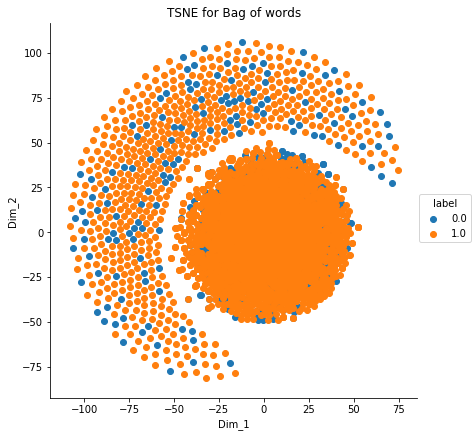

In [84]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0)
#(Configuring the parameteres : Default Settings
 #the number of components = 2
 #perplexity = 30
 #learning rate = 200
 #Maximum number of iterations for the optimization = 1000)


tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Bag of words')
plt.show()


# [5.1.2.2]perplexity = 50,number of iterations = 5000

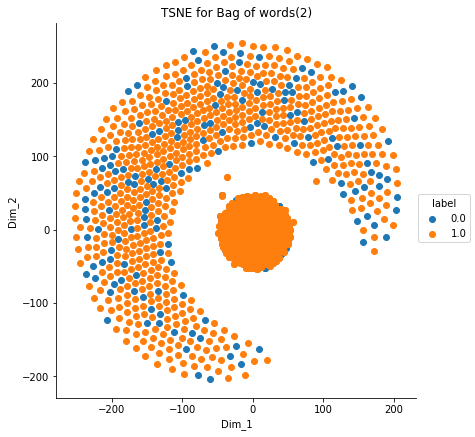

In [76]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0,perplexity=50,n_iter = 5000)
#Configuring the parameteres : Default Settings
 #the number of components = 2
 #learning rate = 200



tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Bag of words(2)')
plt.show()

* we changed the perplexity and number of iteratons to interpret the output of tsne efficiently

* it can be obsereved that data points are forming hihgly interjoined clusters which is a result of applying t-distribution on stochastic neighbouhood embedding

* we cannot draw any hyperplane to lineraly separate data points in class 1 or 0

## [5.2] Applying TNSE on Text TFIDF vectors

# [5.2.1] Standardizing the data

In [39]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler #in scikit learn
dense_mat = final_tf_idf.todense() #converting sparse matrix to dense matrix
std_data = StandardScaler().fit_transform(dense_mat)
print(std_data.shape)

(4986, 3144)


# [5.2.2.1]perplexity = 30,number of iterations = 1000

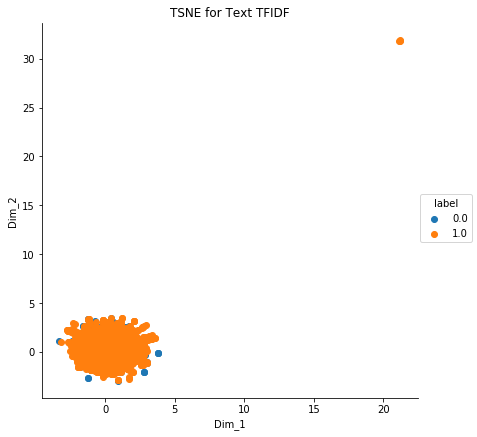

In [40]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0)
#(Configuring the parameteres : Default Settings
 #the number of components = 2
 #perplexity = 30
 #learning rate = 200
 #Maximum number of iterations for the optimization = 1000)


tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df= pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text TFIDF')
plt.show()

# [5.2.2.2]perplexity = 50,number of iterations = 5000

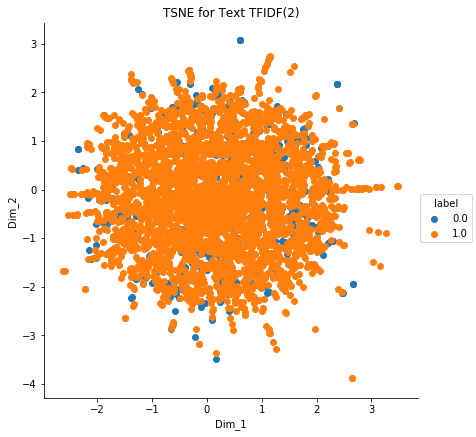

In [41]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0,perplexity = 50,n_iter = 5000)
#(Configuring the parameteres : Default Settings

 #learning rate = 200



tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text TFIDF(2)')
plt.show()

* As We change our perplexity and iteration we are getting different plot

* We are not able to separate positive and negative review 

## [5.3] Applying TNSE on Text Avg W2V vectors

# [5.3.1]Standardizing the data

In [42]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler #in scikit learn
std_data = StandardScaler().fit_transform(sent_vectors)
print(std_data.shape)

(4986, 50)


# [5.3.2.1]Perplexity = 30,number of iterations = 1000

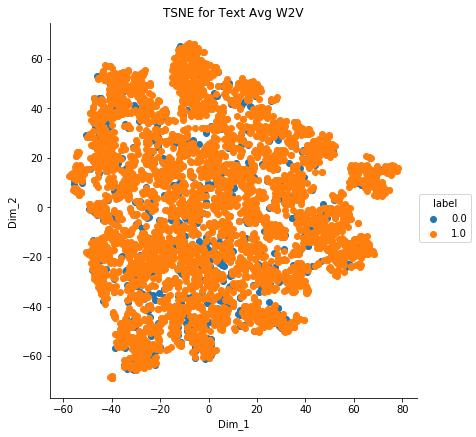

In [43]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0)
#(Configuring the parameteres : Default Settings
 #the number of components = 2
 #perplexity = 30
 #learning rate = 200
 #Maximum number of iterations for the optimization = 1000)


tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df= pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text Avg W2V')
plt.show()

# [5.3.2.1]Perplexity = 50,number of iterations = 5000

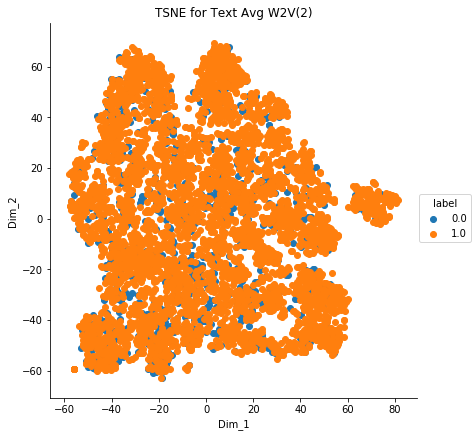

In [44]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0,perplexity=50,n_iter=5000)
#(Configuring the parameteres : Default Settings

 #learning rate = 200


tsne_data = model.fit_transform(std_data)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df= pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text Avg W2V(2)')
plt.show()

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

# [5.4.1]perplexity = 30,number of iterations = 1000

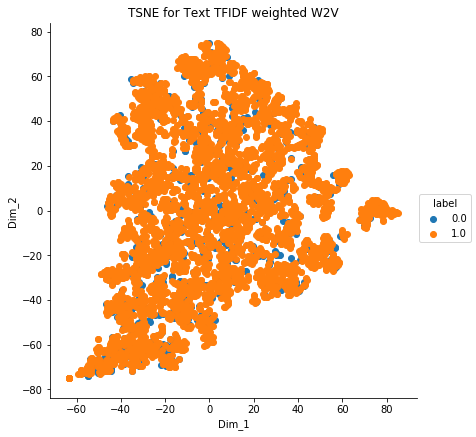

In [45]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0)
#(Configuring the parameteres : Default Settings
 #the number of components = 2
 #perplexity = 30
 #learning rate = 200
 #Maximum number of iterations for the optimization = 1000)


tsne_data = model.fit_transform(tfidf_sent_vectors)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text TFIDF weighted W2V')
plt.show()

# [5.4.2]perplexity=50,number of iterations=5000

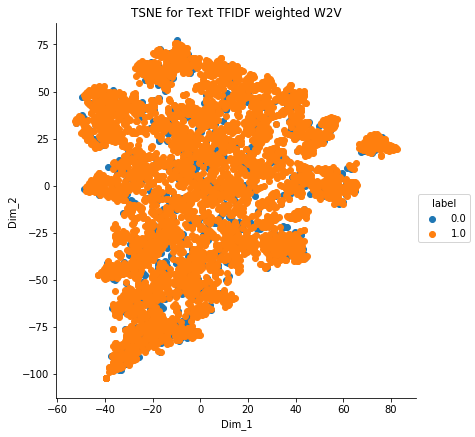

In [46]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state =0,perplexity=50,n_iter=5000)
#(Configuring the parameteres : Default Settings



tsne_data = model.fit_transform(tfidf_sent_vectors)
label = final['Score']


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE for Text TFIDF weighted W2V')
plt.show()

As We change our perplexity and iteration we are getting different plot

We are not able to separate positive and negative review

# [6] Conclusions

* TSNE helped in visualizing large dimensions data in 2 dimenions thus indicating somewhat how data is distributed
* Different values of perplexity and running TSNE for higher number of iterations shows better solution finding in each iteration.also it expands dense clusters and shrinks sparse clusters
* Application of TSNE on Review text vectors generated by different techniques does not help in separating the data in two classes
* better models are required to classify such high dimensional and highly imbalanced data